# Disseny amb Stable Baselines
___
Biel Nebot Cabrera

In [12]:
# pyTorch
import torch
import torch.nn as nn
# Stable baselines 3
from stable_baselines3 import DQN, PPO
from stable_baselines3.dqn import CnnPolicy, MlpPolicy
# gym
import gym

# altres imports
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from datetime import datetime
import math
import csv
import pandas as pd

## Entorn

In [13]:
# WRAPPER INTERPRETA ACCIONS
class InterpretaAccions(gym.ActionWrapper):
    def __init__(self, env,diccionariAccions):
        super().__init__(env)
        
        self.diccAccions = diccionariAccions
        
    def action(self, action):
        return self.diccAccions[action]

# WRAPPER TRANSFORMA OBSERVACIONS
def retallaRectangle(imatge):
    files, columnes = 11, 12
    rectNegre = np.zeros((files, columnes)) # matriu de zeros
    imatge[84:95, 0:12] = rectNegre # substituim a la imatge
    return imatge

def rgb2gray(imatge):
    # grisos
    transformada = imatge[:,:,1] # el canal verd
    valorMaxim = np.max(transformada)
    # normalitzar
    transformada = transformada/valorMaxim # normalitzar
    transformada[transformada == 204/valorMaxim] = 1 # convertir el verd en blanc
    transformada[transformada == 230/valorMaxim] = 1 # convertir el verd en blanc
    #retallar el rectangle dels punts
    transformada = retallaRectangle(transformada)
    # convertir a (1,96,96)
    transformada = np.reshape(transformada, (1,) + transformada.shape)
    
    return transformada

class TransformaObservacions(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # aquí podem agefir-hi variables
        
    def observation(self, observ):
        return rgb2gray(observ)


# CREACIÓ DE L'ENTORN FENT SERVIR ELS WRAPPERS
# accions d'entrenament
# diccAccions = {0: np.array([0.0,0.0,0.0]),  # res
#                1: np.array([0.0,0.4,0.0]),  # endavant
#                2: np.array([1.0,0.0,0.0]),  # dreta
#                3: np.array([-1.0,0.0,0.0]), # esquerra
#                4: np.array([0.0,0.0,0.5])}  # frenar

# accions versió 1
# diccAccions = {0: np.array([0.0,0.0,0.0]),  # res
#                1: np.array([0.0,0.35,0.0]),  # endavant
#                2: np.array([1.0,0.0,0.06]),  # dreta
#                3: np.array([-1.0,0.0,0.06]), # esquerra
#                4: np.array([0.0,0.0,0.5])}  # frenar


# accions versió 2
diccAccions = {0: np.array([0.0,0.0,0.0]),  # res
               1: np.array([0.0,0.5,0.0]),  # endavant
               2: np.array([1.0,0.0,0.06]),  # dreta
               3: np.array([-1.0,0.0,0.06]), # esquerra
               4: np.array([0.0,0.0,0.5])}  # frenar


# CREAR ENTORN
def creaEntornPerEntrenar(diccionariAccions):
    # retorna l'entorn havent discretitzat l'espai d'accions, havent
    #  aplicat els wrappers i llest per fer-lo servir amb el TensdorForce
    
    env = gym.make('CarRacing-v0') # crear l'entorn
    env.action_space = gym.spaces.discrete.Discrete(len(diccionariAccions)) # espai d'accions discretitzat
    env.observation_space = gym.spaces.Box(0.0, 1.0, (1,96,96))
    
    # Afegim els wrappers que haguem fet
    env = InterpretaAccions(env,diccionariAccions)
    env = TransformaObservacions(env)
    
    return env

In [14]:
env = creaEntornPerEntrenar(diccAccions)
espaiObservacions = env.observation_space; print("El nou entorn té:\nObservacions: ",espaiObservacions)
espaiAccions = env.action_space; print("Accions:      ",espaiAccions)

El nou entorn té:
Observacions:  Box(0.0, 1.0, (1, 96, 96), float32)
Accions:       Discrete(5)



## Agent
Aquí es crea l'agent.

La capa `TotSencer` s'ha creat per poder fer el print de tota la xarxa neuronal i comporvar les seves mides.

In [16]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torchinfo import summary 

class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of units for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 5):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        
        # The input is HxWxC (channels last) but PyTorch expects CxHxW images (channels first)
        # 
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
#         print("n_input_channels = ",n_input_channels)
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 8, kernel_size=7, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]
#             print(n_flatten)

        self.linear = nn.Sequential(nn.Linear(n_flatten, 400), nn.ReLU(),
                                    nn.Linear(400, features_dim), nn.ReLU())

        # per fer el print
        self.TotSencer = nn.Sequential(self.cnn, self.linear)
        print(summary(self.TotSencer, input_size=(1, 1, 96, 96)))
    
    
    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=len(diccAccions)),
)

model = DQN('CnnPolicy', env, verbose=1, policy_kwargs=policy_kwargs,
            buffer_size=10000,
            learning_rate = 0.001,
            learning_starts=20,
#             exploration_fraction=1,
#             exploration_initial_eps=1.0,
#             exploration_final_eps=0.05,
#            # gamma
           gamma = 0.99
           )


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Conv2d: 2-1                       [1, 8, 23, 23]            400
│    └─ReLU: 2-2                         [1, 8, 23, 23]            --
│    └─MaxPool2d: 2-3                    [1, 8, 11, 11]            --
│    └─Conv2d: 2-4                       [1, 16, 9, 9]             1,168
│    └─ReLU: 2-5                         [1, 16, 9, 9]             --
│    └─MaxPool2d: 2-6                    [1, 16, 4, 4]             --
│    └─Flatten: 2-7                      [1, 256]                  --
├─Sequential: 1-2                        [1, 5]                    --
│    └─Linear: 2-8                       [1, 400]                  102,800
│    └─ReLU: 2-9                         [1, 400]   

Una funció per carregar un agent guardat

In [6]:
def obreAgentDesat(nomCarpeta):
    return DQN.load(nomCarpeta)

In [7]:
# model = obreAgentDesat(nomFitxer2)
# model.set_env(env)

## Avalua l'agent

Aquesta funció serveix per avaluar l'aprenentatge d'un agent. Cal especificar:
* El nom de l'arxiu
* Els episodis que es volen avaluar
* Si es vol fer el render o no

Retorna una llista amb les recompenses que s'han aconseguit a cada episodi simulat.

També fa un histograma de les accions que s'han fet, així es pot fer un seguiment que les accions que fa l'agent, i quines són les més freqüents.

In [8]:
def AvaluaAgent(nomCarpeta,nreEpisodis,render_o_no):
    # retorna la recompensa mitjana dels n episodis que ha simulat
    
    env = creaEntornPerEntrenar(diccAccions) # crea l'entorn
    model = obreAgentDesat(nomCarpeta) # obre l'agent desat
    model.set_env(env)
    
    diccResultats = {}
    
    for episode in range(nreEpisodis):
        diccResultats[episode] = {"accions": [],
                                  "recompensa": 0}
        sumaRecompensa = 0.0

        obs = env.reset()
        for i in range(1000): # així es fixa la durada màxima d'un episodi. Alternativament es pot posar un while
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            
            diccResultats[episode]["accions"].append(action)
            sumaRecompensa += reward

            if render_o_no:
                env.render()
#             if done:
#                 break
#                 obs = env.reset()
                
        diccResultats[episode]["recompensa"] += sumaRecompensa
        print('Episodi {}: recompensa = {}'.format(episode,round(sumaRecompensa,4)))

        fig = plt.figure(figsize=(2,1))
        plt.hist(diccResultats[episode]["accions"],bins = len(diccAccions), alpha = 0.4, edgecolor = 'black',color="g")
        plt.show(); plt.close()
    
    env.close()
    
    print("AvaluaAgent() Acabat")
    return [diccResultats[elem]["recompensa"] for elem in diccResultats]

## Entrenament

In [9]:
########### per fer el csv ###########
# nomFitxerCSV = "dadesEntrenaments.csv"
# with open(nomFitxerCSV,"w",newline='') as fitxer:
#         writer = csv.writer(fitxer)
#         writer.writerow(["iteracio", "recompensa1", "recompensa2","recompensa3"])

In [10]:
minutsEntrenament = 60*12 # mentre no hagin passat aquest minuts, l'entrenament continua (i el for no s'hagi acabat)
horaInici = time.time()

for i in range(2000):
    
    horaAra = time.time()
    print("Ha passat: ",(horaAra-horaInici)/60," minuts")
    if (horaAra-horaInici)/60 < minutsEntrenament: # (<-> si estem dins el temps permès de simulació)
        
        print("\n########## Iteració ",i,"##########")
        model.learn(total_timesteps=10000)
        print("Ara es guarda")
        model.save(nomFitxer2+"_iteracio_{}".format(i))

        
#         print("Acabem de fer una de les iteracions. Ara mirem com es comporta en una mitja de 3:")
#         llistaRecompenses = AvaluaAgent(nomFitxer+"_iteracio_{}".format(i),3,False)
#         print("La recompensa mitjana ha estat: ",sum(llistaRecompenses)/len(llistaRecompenses))
        
#         # escriure al csv
#         # Desa els resultats al csv
#         with open(nomFitxerCSV,"a",newline='') as fitxer:
#             writer = csv.writer(fitxer)
#             writer.writerow([i, llistaRecompenses[0], llistaRecompenses[1], llistaRecompenses[2]])     
        
        
        # Nou entorn perquè no peti
        env.close()
        env = creaEntornPerEntrenar(diccAccions)
        model.set_env(env)

horaAra = datetime.now(); current_time = horaAra.strftime("%H:%M:%S")
print("\n########## Entrenament acabat a les ",current_time,"##########")

Ha passat:  0.0  minuts

########## Iteració  0 ##########
Track generation: 1047..1313 -> 266-tiles track
Track generation: 1299..1628 -> 329-tiles track
Track generation: 1018..1277 -> 259-tiles track
Track generation: 1010..1275 -> 265-tiles track
Track generation: 1120..1404 -> 284-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 42.4     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 101      |
|    time_elapsed     | 39       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.353    |
|    n_updates        | 557379   |
----------------------------------
Track generation: 1157..1450 -> 293-tiles track
Track generation: 1002..1261 -> 259-tiles track
Track generation: 1098..1377 -> 279-tiles track
Track generation: 1322..1658 -> 

Track generation: 1062..1332 -> 270-tiles track
Track generation: 1091..1367 -> 276-tiles track
Track generation: 1207..1513 -> 306-tiles track
Track generation: 1031..1293 -> 262-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 238      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 96       |
|    time_elapsed     | 83       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.543    |
|    n_updates        | 568359   |
----------------------------------
Track generation: 1158..1452 -> 294-tiles track
Track generation: 1165..1462 -> 297-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  8.756734772523243  minuts

########## Iteració  5 ##########
Track generation: 1123.

Track generation: 1120..1404 -> 284-tiles track
Track generation: 1116..1399 -> 283-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  15.819950409730275  minuts

########## Iteració  9 ##########
Track generation: 991..1243 -> 252-tiles track
Track generation: 1103..1383 -> 280-tiles track
Track generation: 1134..1422 -> 288-tiles track
Track generation: 1168..1464 -> 296-tiles track
Track generation: 1137..1433 -> 296-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 432      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 91       |
|    time_elapsed     | 43       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.713    |
|    n_updates        | 579834   |
----------

Track generation: 1033..1300 -> 267-tiles track
Track generation: 996..1253 -> 257-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1228..1539 -> 311-tiles track
Track generation: 1060..1329 -> 269-tiles track
Track generation: 1217..1525 -> 308-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 71       |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 66       |
|    time_elapsed     | 119      |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.519    |
|    n_updates        | 590814   |
----------------------------------
Track generation: 1096..1381 -> 285-tiles track
Track generation: 991..1243 -> 252-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapp

Track generation: 1185..1485 -> 300-tiles track
Track generation: 1203..1508 -> 305-tiles track
Track generation: 1206..1511 -> 305-tiles track
Track generation: 1239..1553 -> 314-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 161      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 97       |
|    time_elapsed     | 41       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.389    |
|    n_updates        | 602289   |
----------------------------------
Track generation: 973..1227 -> 254-tiles track
Track generation: 1167..1470 -> 303-tiles track
Track generation: 1096..1374 -> 278-tiles track
Track generation: 1104..1387 -> 283-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track genera

Track generation: 1176..1474 -> 298-tiles track
Track generation: 1067..1338 -> 271-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 91.9     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 98       |
|    time_elapsed     | 40       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.277    |
|    n_updates        | 612269   |
----------------------------------
Track generation: 1137..1425 -> 288-tiles track
Track generation: 1264..1584 -> 320-tiles track
Track generation: 1226..1537 -> 311-tiles track
Track generation: 937..1182 -> 245-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 88.5     |
|    exploration rate | 0.05     |
| time/      

Track generation: 1032..1294 -> 262-tiles track
Track generation: 1043..1308 -> 265-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  49.26951249043147  minuts

########## Iteració  27 ##########
Track generation: 954..1196 -> 242-tiles track
Track generation: 1026..1292 -> 266-tiles track
Track generation: 1121..1405 -> 284-tiles track
Track generation: 1248..1564 -> 316-tiles track
Track generation: 1261..1584 -> 323-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1244..1559 -> 315-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 41.2     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 99       |
|    time_elapsed     | 40       |
|    total timesteps  | 4000     |
| train/              

Track generation: 1107..1388 -> 281-tiles track
Track generation: 1272..1594 -> 322-tiles track
Track generation: 983..1233 -> 250-tiles track
Track generation: 1087..1363 -> 276-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 118      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 92       |
|    time_elapsed     | 86       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.453    |
|    n_updates        | 635724   |
----------------------------------
Track generation: 1372..1718 -> 346-tiles track
Track generation: 1296..1624 -> 328-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  57.9269845922788  minuts

########## Iteració  32 ##########
Track generation: 1166..

Track generation: 1299..1627 -> 328-tiles track
Track generation: 1128..1414 -> 286-tiles track
Track generation: 1236..1549 -> 313-tiles track
Track generation: 1144..1434 -> 290-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 185      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 96       |
|    time_elapsed     | 82       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.544    |
|    n_updates        | 648199   |
----------------------------------
Track generation: 1131..1418 -> 287-tiles track
Track generation: 992..1249 -> 257-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  66.4986278573672  minuts

########## Iteració  37 ##########
Track generation: 1204..

Track generation: 1139..1428 -> 289-tiles track
Track generation: 1003..1258 -> 255-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  73.46536738077799  minuts

########## Iteració  41 ##########
Track generation: 1469..1840 -> 371-tiles track
Track generation: 1455..1823 -> 368-tiles track
Track generation: 1167..1463 -> 296-tiles track
Track generation: 1254..1572 -> 318-tiles track
Track generation: 1303..1633 -> 330-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 198      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 95       |
|    time_elapsed     | 41       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.419    |
|    n_updates        | 659674   |
---------

Track generation: 1190..1494 -> 304-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1165..1460 -> 295-tiles track
Track generation: 1143..1435 -> 292-tiles track
Track generation: 1103..1386 -> 283-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1027..1288 -> 261-tiles track
Track generation: 935..1180 -> 245-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 258      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 93       |
|    time_elapsed     | 85       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.49     |
|    n_updates        | 670654   |
----------------------------------
Track generation: 1114..1399

Track generation: 1123..1411 -> 288-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1105..1388 -> 283-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1207..1513 -> 306-tiles track
Track generation: 1292..1619 -> 327-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  89.01148035526276  minuts

########## Iteració  50 ##########
Track generation: 1064..1334 -> 270-tiles track
Track generation: 1184..1484 -> 300-tiles track
Track generation: 1143..1433 -> 290-tiles track
Track generation: 1147..1438 -> 291-tiles track
Track generation: 1116..1399 -> 283-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 68.2     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        

Track generation: 1148..1439 -> 291-tiles track
Track generation: 1021..1283 -> 262-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1215..1523 -> 308-tiles track
Track generation: 1206..1520 -> 314-tiles track
Track generation: 1265..1623 -> 358-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1128..1414 -> 286-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 80.4     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 96       |
|    time_elapsed     | 82       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.459    |
|    n_updates        | 693109   |
----------------------------------
Track generation: 1015..127

Track generation: 1114..1397 -> 283-tiles track
Track generation: 1188..1489 -> 301-tiles track
Track generation: 1256..1575 -> 319-tiles track
Track generation: 1102..1387 -> 285-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 82.3     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 97       |
|    time_elapsed     | 41       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.575    |
|    n_updates        | 704584   |
----------------------------------
Track generation: 1090..1374 -> 284-tiles track
Track generation: 1227..1538 -> 311-tiles track
Track generation: 991..1243 -> 252-tiles track
Track generation: 1255..1573 -> 318-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      

Track generation: 1160..1454 -> 294-tiles track
Track generation: 1201..1513 -> 312-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  113.23226997057597  minuts

########## Iteració  64 ##########
Track generation: 1257..1575 -> 318-tiles track
Track generation: 1092..1369 -> 277-tiles track
Track generation: 1204..1510 -> 306-tiles track
Track generation: 1420..1779 -> 359-tiles track
Track generation: 1352..1702 -> 350-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 175      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 95       |
|    time_elapsed     | 41       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.663    |
|    n_updates        | 717059   |
--------

Track generation: 1279..1609 -> 330-tiles track
Track generation: 1095..1373 -> 278-tiles track
Track generation: 1078..1356 -> 278-tiles track
Track generation: 1381..1730 -> 349-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 38.1     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 91       |
|    time_elapsed     | 87       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.137    |
|    n_updates        | 728039   |
----------------------------------
Track generation: 1378..1726 -> 348-tiles track
Track generation: 1107..1388 -> 281-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  121.9132985552152  minuts

########## Iteració  69 ##########
Track generation: 1152

Track generation: 1265..1591 -> 326-tiles track
Track generation: 1084..1359 -> 275-tiles track
Track generation: 1010..1268 -> 258-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1025..1291 -> 266-tiles track
Track generation: 1130..1422 -> 292-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 130      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 96       |
|    time_elapsed     | 41       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.395    |
|    n_updates        | 739514   |
----------------------------------
Track generation: 1234..1547 -> 313-tiles track
Track generation: 1144..1434 -> 290-tiles track
Track generation: 997..1257 -> 260-tiles track
Track genera

Track generation: 1089..1366 -> 277-tiles track
Track generation: 1348..1699 -> 351-tiles track
Track generation: 1055..1323 -> 268-tiles track
Track generation: 1123..1408 -> 285-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 233      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 97       |
|    time_elapsed     | 81       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.432    |
|    n_updates        | 750494   |
----------------------------------
Track generation: 1152..1444 -> 292-tiles track
Track generation: 1100..1379 -> 279-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  137.54680728912354  minuts

########## Iteració  78 ##########
Track generation: 111

Track generation: 1368..1723 -> 355-tiles track
Track generation: 1116..1406 -> 290-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  144.55930821498234  minuts

########## Iteració  82 ##########
Track generation: 1202..1507 -> 305-tiles track
Track generation: 947..1188 -> 241-tiles track
Track generation: 1008..1264 -> 256-tiles track
Track generation: 949..1192 -> 243-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1116..1399 -> 283-tiles track
Track generation: 1068..1339 -> 271-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 141      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 97       |
|    time_elapsed     | 41       |
|    total timesteps  | 4000     |
| train/              

Track generation: 997..1252 -> 255-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1081..1358 -> 277-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1093..1375 -> 282-tiles track
Track generation: 1192..1494 -> 302-tiles track
Track generation: 1191..1493 -> 302-tiles track
Track generation: 1048..1314 -> 266-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 191      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 95       |
|    time_elapsed     | 83       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.277    |
|    n_updates        | 772949   |
----------------------------------
Track generation: 1275..1598

Track generation: 1193..1495 -> 302-tiles track
Track generation: 1162..1456 -> 294-tiles track
Track generation: 1163..1458 -> 295-tiles track
Track generation: 1336..1674 -> 338-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 129      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 94       |
|    time_elapsed     | 42       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.719    |
|    n_updates        | 784424   |
----------------------------------
Track generation: 1032..1302 -> 270-tiles track
Track generation: 1215..1523 -> 308-tiles track
Track generation: 1165..1460 -> 295-tiles track
Track generation: 1055..1323 -> 268-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean     

Track generation: 1137..1432 -> 295-tiles track
Track generation: 1005..1260 -> 255-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  169.02966188589733  minuts

########## Iteració  96 ##########
Track generation: 979..1231 -> 252-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1142..1440 -> 298-tiles track
Track generation: 1276..1599 -> 323-tiles track
Track generation: 1032..1294 -> 262-tiles track
Track generation: 1150..1440 -> 290-tiles track
Track generation: 1243..1558 -> 315-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 307      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 97       |
|    time_elapsed     | 40       |
|    total timesteps  | 4000     |
| train/             

Track generation: 1133..1420 -> 287-tiles track
Track generation: 1151..1443 -> 292-tiles track
Track generation: 1070..1342 -> 272-tiles track
Track generation: 1113..1395 -> 282-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 536      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 93       |
|    time_elapsed     | 85       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.651    |
|    n_updates        | 807879   |
----------------------------------
Track generation: 1096..1374 -> 278-tiles track
Track generation: 1142..1434 -> 292-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1167..1463 -> 296-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wra

Track generation: 1271..1593 -> 322-tiles track
Track generation: 1098..1376 -> 278-tiles track
Track generation: 1147..1438 -> 291-tiles track
Track generation: 962..1212 -> 250-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 269      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 93       |
|    time_elapsed     | 43       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.582    |
|    n_updates        | 819354   |
----------------------------------
Track generation: 1295..1623 -> 328-tiles track
Track generation: 1100..1379 -> 279-tiles track
Track generation: 1223..1532 -> 309-tiles track
Track generation: 1277..1600 -> 323-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      

Track generation: 1167..1463 -> 296-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 184      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 94       |
|    time_elapsed     | 84       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.409    |
|    n_updates        | 830334   |
----------------------------------
Track generation: 1131..1418 -> 287-tiles track
Track generation: 1147..1446 -> 299-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  193.58444861968357  minuts

########## Iteració  110 ##########
Track generation: 1131..1418 -> 287-tiles track
Track generation: 1159..1462 -> 303-tiles track
Track generation: 1348..1689 -> 341-tiles track
Track generation: 10

Track generation: 1279..1603 -> 324-tiles track
Track generation: 1102..1392 -> 290-tiles track
Track generation: 991..1249 -> 258-tiles track
Track generation: 1202..1505 -> 303-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 308      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 96       |
|    time_elapsed     | 41       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.758    |
|    n_updates        | 841809   |
----------------------------------
Track generation: 1051..1318 -> 267-tiles track
Track generation: 1220..1529 -> 309-tiles track
Track generation: 1106..1386 -> 280-tiles track
Track generation: 1140..1429 -> 289-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      

Track generation: 1348..1689 -> 341-tiles track
Track generation: 1063..1333 -> 270-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  210.08524667024614  minuts

########## Iteració  119 ##########
Track generation: 960..1207 -> 247-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 994..1249 -> 255-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1142..1439 -> 297-tiles track
Track generation: 1150..1476 -> 326-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1077..1351 -> 274-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1129..1415 -> 286-tiles track
Track generation: 1061..1337 -> 276-tiles track
Track generation: 1043..1314 -> 271-tiles track
Track generation: 1100..1379 -> 279

Track generation: 1005..1263 -> 258-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1139..1428 -> 289-tiles track
Track generation: 1110..1400 -> 290-tiles track
Track generation: 1058..1329 -> 271-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1051..1318 -> 267-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 198      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 98       |
|    time_elapsed     | 40       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.57     |
|    n_updates        | 864264   |
----------------------------------
Track generation: 1149..1440 -> 291-tiles track
Track generation: 1207..151

Track generation: 1112..1394 -> 282-tiles track
Track generation: 1166..1470 -> 304-tiles track
Track generation: 1183..1483 -> 300-tiles track
Track generation: 1200..1512 -> 312-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 308      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 94       |
|    time_elapsed     | 84       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.801    |
|    n_updates        | 875244   |
----------------------------------
Track generation: 1173..1470 -> 297-tiles track
Track generation: 1182..1490 -> 308-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  225.71968284447988  minuts

########## Iteració  128 ##########
Track generation: 11

Track generation: 1224..1534 -> 310-tiles track
Track generation: 1015..1273 -> 258-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  232.66346646149952  minuts

########## Iteració  132 ##########
Track generation: 1214..1522 -> 308-tiles track
Track generation: 1053..1320 -> 267-tiles track
Track generation: 1286..1612 -> 326-tiles track
Track generation: 1260..1579 -> 319-tiles track
Track generation: 1262..1582 -> 320-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 171      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 92       |
|    time_elapsed     | 43       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.349    |
|    n_updates        | 886719   |
-------

Track generation: 1152..1444 -> 292-tiles track
Track generation: 1179..1478 -> 299-tiles track
Track generation: 1116..1399 -> 283-tiles track
Track generation: 917..1157 -> 240-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 431      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 93       |
|    time_elapsed     | 85       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.843    |
|    n_updates        | 897699   |
----------------------------------
Track generation: 1175..1473 -> 298-tiles track
Track generation: 1131..1418 -> 287-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  241.5887894511223  minuts

########## Iteració  137 ##########
Track generation: 1267

Track generation: 1206..1511 -> 305-tiles track
Track generation: 1144..1434 -> 290-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  248.6270472963651  minuts

########## Iteració  141 ##########
Track generation: 1116..1404 -> 288-tiles track
Track generation: 1158..1459 -> 301-tiles track
Track generation: 1241..1555 -> 314-tiles track
Track generation: 1149..1447 -> 298-tiles track
Track generation: 1208..1514 -> 306-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 221      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 98       |
|    time_elapsed     | 40       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.628    |
|    n_updates        | 909174   |
--------

Track generation: 1066..1337 -> 271-tiles track
Track generation: 965..1214 -> 249-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1236..1549 -> 313-tiles track
Track generation: 1222..1532 -> 310-tiles track
Track generation: 1039..1305 -> 266-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1316..1649 -> 333-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 261      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 96       |
|    time_elapsed     | 83       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.411    |
|    n_updates        | 920154   |
----------------------------------
Track generation: 1053..1320

Track generation: 1278..1604 -> 326-tiles track
Track generation: 1052..1324 -> 272-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  264.47381211916604  minuts

########## Iteració  150 ##########
Track generation: 1380..1729 -> 349-tiles track
Track generation: 1220..1529 -> 309-tiles track
Track generation: 949..1194 -> 245-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1184..1485 -> 301-tiles track
Track generation: 1191..1493 -> 302-tiles track
Track generation: 1112..1394 -> 282-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 113      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 94       |
|    time_elapsed     | 42       |
|    total timesteps  | 4000     |
| train/            

Track generation: 1149..1440 -> 291-tiles track
Track generation: 1161..1456 -> 295-tiles track
Track generation: 1112..1394 -> 282-tiles track
Track generation: 1243..1558 -> 315-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 234      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 94       |
|    time_elapsed     | 84       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.352    |
|    n_updates        | 942609   |
----------------------------------
Track generation: 1192..1494 -> 302-tiles track
Track generation: 1199..1503 -> 304-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  273.426101009051  minuts

########## Iteració  155 ##########
Track generation: 1143

Track generation: 1096..1373 -> 277-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1172..1473 -> 301-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1218..1527 -> 309-tiles track
Track generation: 1154..1448 -> 294-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1232..1544 -> 312-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  280.4568015376727  minuts

########## Iteració  159 ##########
Track generation: 1228..1539 -> 311-tiles track
Track generation: 1099..1378 -> 279-tiles track
Track generation: 1117..1408 -> 291-tiles track
Track generation: 1108..1389 -> 281-tiles track
Track generation: 1172..1468 -> 296-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_r

Track generation: 1239..1553 -> 314-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 190      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 95       |
|    time_elapsed     | 41       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.365    |
|    n_updates        | 964064   |
----------------------------------
Track generation: 1280..1604 -> 324-tiles track
Track generation: 1172..1469 -> 297-tiles track
Track generation: 1102..1382 -> 280-tiles track
Track generation: 1283..1608 -> 325-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 220      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8

Track generation: 1103..1383 -> 280-tiles track
Track generation: 1125..1410 -> 285-tiles track
Track generation: 1149..1441 -> 292-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 217      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 91       |
|    time_elapsed     | 87       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.902    |
|    n_updates        | 975044   |
----------------------------------
Track generation: 1191..1500 -> 309-tiles track
Track generation: 1251..1568 -> 317-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  296.30520099401474  minuts

########## Iteració  168 ##########
Track generation: 992..1244 -> 252-tiles track
Track generation: 134

Track generation: 1092..1367 -> 275-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 160      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 98       |
|    time_elapsed     | 40       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.311    |
|    n_updates        | 986519   |
----------------------------------
Track generation: 1154..1447 -> 293-tiles track
Track generation: 1078..1353 -> 275-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1114..1406 -> 292-tiles track
Track generation: 1371..1718 -> 347-tiles track
Track generation: 1191..1493 -> 302-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
| 

Track generation: 1239..1553 -> 314-tiles track
Track generation: 1121..1412 -> 291-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  312.2012112855911  minuts

########## Iteració  177 ##########
Track generation: 1223..1533 -> 310-tiles track
Track generation: 1159..1453 -> 294-tiles track
Track generation: 1244..1559 -> 315-tiles track
Track generation: 1175..1472 -> 297-tiles track
Track generation: 1152..1444 -> 292-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 204      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 93       |
|    time_elapsed     | 42       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.697    |
|    n_updates        | 998994   |
--------

Track generation: 1179..1478 -> 299-tiles track
Track generation: 1092..1369 -> 277-tiles track
Track generation: 1083..1358 -> 275-tiles track
Track generation: 1124..1409 -> 285-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 178      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 93       |
|    time_elapsed     | 85       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.711    |
|    n_updates        | 1009974  |
----------------------------------
Track generation: 998..1259 -> 261-tiles track
Track generation: 1126..1412 -> 286-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  320.92912034193677  minuts

########## Iteració  182 ##########
Track generation: 108

Ha passat:  327.9546716292699  minuts

########## Iteració  186 ##########
Track generation: 1115..1406 -> 291-tiles track
Track generation: 1066..1336 -> 270-tiles track
Track generation: 1026..1295 -> 269-tiles track
Track generation: 1159..1453 -> 294-tiles track
Track generation: 1002..1262 -> 260-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 347      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 97       |
|    time_elapsed     | 41       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.88     |
|    n_updates        | 1021449  |
----------------------------------
Track generation: 1081..1355 -> 274-tiles track
Track generation: 1129..1415 -> 286-tiles track
Track generation: 1086..1365 -> 279-tiles track
retry to generat

Track generation: 1132..1419 -> 287-tiles track
Track generation: 1277..1601 -> 324-tiles track
Track generation: 1184..1484 -> 300-tiles track
Track generation: 1232..1544 -> 312-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 340      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 88       |
|    time_elapsed     | 90       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.811    |
|    n_updates        | 1032429  |
----------------------------------
Track generation: 1215..1522 -> 307-tiles track
Track generation: 1017..1275 -> 258-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  336.91453132629397  minuts

########## Iteració  191 ##########
Track generation: 12

Track generation: 1091..1368 -> 277-tiles track
Track generation: 1059..1328 -> 269-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Ha passat:  344.15375934441886  minuts

########## Iteració  195 ##########
Track generation: 1130..1416 -> 286-tiles track
Track generation: 1156..1449 -> 293-tiles track
Track generation: 1028..1289 -> 261-tiles track
Track generation: 1128..1414 -> 286-tiles track
Track generation: 1044..1309 -> 265-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 241      |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 94       |
|    time_elapsed     | 42       |
|    total timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.668    |
|    n_updates        | 1043904  |
-------

Track generation: 1251..1568 -> 317-tiles track
Track generation: 1119..1405 -> 286-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1139..1428 -> 289-tiles track
Track generation: 1155..1448 -> 293-tiles track
Track generation: 1053..1320 -> 267-tiles track
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 67.9     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 95       |
|    time_elapsed     | 83       |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.54     |
|    n_updates        | 1054884  |
----------------------------------
Track generation: 1189..1490 -> 301-tiles track
Track generation: 1127..1413 -> 286-tiles track
Ara es guarda
Wrapping the env with a `Monitor` wrapper
Wra

MemoryError: 


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_0
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1106..1393 -> 287-tiles track
Episodi 0: recompensa = -93.007


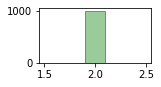

Track generation: 1012..1274 -> 262-tiles track
Episodi 1: recompensa = -92.3372


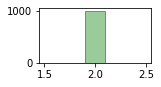

Track generation: 1135..1426 -> 291-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1159..1453 -> 294-tiles track
Episodi 2: recompensa = -93.1741


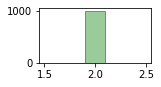

Track generation: 1152..1447 -> 295-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1151..1443 -> 292-tiles track
Episodi 3: recompensa = -93.1271


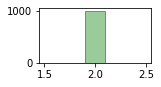

Track generation: 1226..1536 -> 310-tiles track
Episodi 4: recompensa = -93.5275


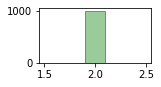

Track generation: 1187..1488 -> 301-tiles track
Episodi 5: recompensa = -93.3333


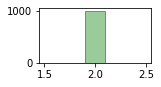

Track generation: 1199..1503 -> 304-tiles track
Episodi 6: recompensa = -93.3993


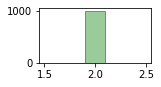

Track generation: 1240..1554 -> 314-tiles track
Episodi 7: recompensa = -93.6102


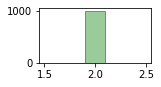

Track generation: 1144..1434 -> 290-tiles track
Episodi 8: recompensa = -93.0796


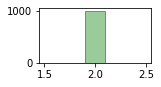

Track generation: 1212..1519 -> 307-tiles track
Episodi 9: recompensa = -93.4641


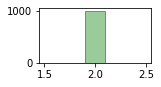

AvaluaAgent() Acabat


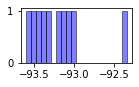


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_1
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1097..1375 -> 278-tiles track
Episodi 0: recompensa = 286.2816


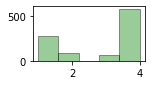

Track generation: 1330..1667 -> 337-tiles track
Episodi 1: recompensa = 224.4048


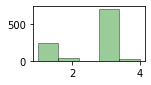

Track generation: 1058..1326 -> 268-tiles track
Episodi 2: recompensa = 282.0225


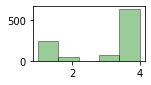

Track generation: 1222..1531 -> 309-tiles track
Episodi 3: recompensa = 367.5325


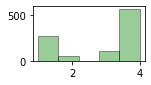

Track generation: 1163..1458 -> 295-tiles track
Episodi 4: recompensa = 267.3469


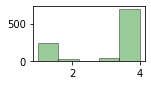

Track generation: 1068..1339 -> 271-tiles track
Episodi 5: recompensa = 311.1111


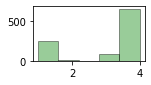

Track generation: 972..1219 -> 247-tiles track
Episodi 6: recompensa = 786.1789


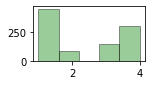

Track generation: 1152..1444 -> 292-tiles track
Episodi 7: recompensa = 772.8522


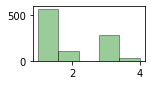

Track generation: 1002..1264 -> 262-tiles track
Episodi 8: recompensa = 7.2797


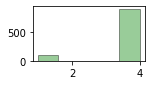

Track generation: 1016..1278 -> 262-tiles track
Episodi 9: recompensa = -0.3831


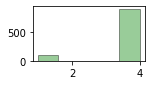

AvaluaAgent() Acabat


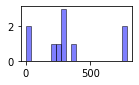


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_2
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1067..1338 -> 271-tiles track
Episodi 0: recompensa = -92.5926


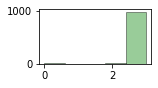

Track generation: 1159..1453 -> 294-tiles track
Episodi 1: recompensa = -93.1741


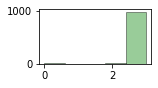

Track generation: 1168..1464 -> 296-tiles track
Episodi 2: recompensa = -93.2203


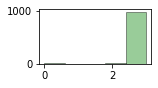

Track generation: 1059..1331 -> 272-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1065..1336 -> 271-tiles track
Episodi 3: recompensa = -92.5926


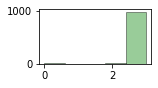

Track generation: 1205..1510 -> 305-tiles track
Episodi 4: recompensa = -93.4211


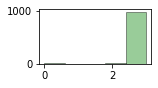

Track generation: 1102..1382 -> 280-tiles track
Episodi 5: recompensa = -92.8315


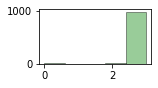

Track generation: 1192..1494 -> 302-tiles track
Episodi 6: recompensa = -93.3555


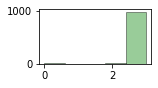

Track generation: 1008..1264 -> 256-tiles track
Episodi 7: recompensa = -92.1569


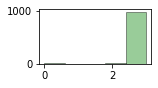

Track generation: 1235..1548 -> 313-tiles track
Episodi 8: recompensa = -93.5897


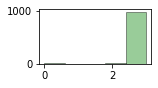

Track generation: 1141..1430 -> 289-tiles track
Episodi 9: recompensa = -93.0556


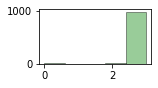

AvaluaAgent() Acabat


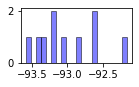


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_3
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1087..1363 -> 276-tiles track
Episodi 0: recompensa = -92.7273


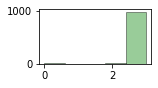

Track generation: 976..1226 -> 250-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1242..1557 -> 315-tiles track
Episodi 1: recompensa = -93.6306


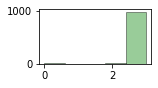

Track generation: 1132..1419 -> 287-tiles track
Episodi 2: recompensa = -93.007


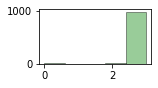

Track generation: 1040..1304 -> 264-tiles track
Episodi 3: recompensa = -92.3954


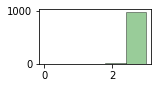

Track generation: 960..1204 -> 244-tiles track
Episodi 4: recompensa = -91.7695


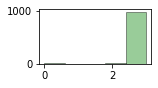

Track generation: 1075..1348 -> 273-tiles track
Episodi 5: recompensa = -92.6471


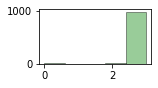

Track generation: 1231..1543 -> 312-tiles track
Episodi 6: recompensa = -93.5691


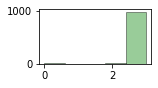

Track generation: 1240..1554 -> 314-tiles track
Episodi 7: recompensa = -93.6102


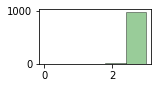

Track generation: 1089..1369 -> 280-tiles track
Episodi 8: recompensa = -92.8315


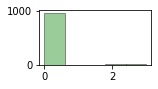

Track generation: 1155..1456 -> 301-tiles track
Episodi 9: recompensa = -93.3333


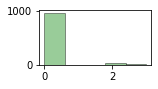

AvaluaAgent() Acabat


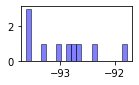


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_4
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1045..1313 -> 268-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1175..1473 -> 298-tiles track
Episodi 0: recompensa = -93.266


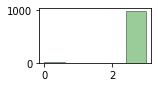

Track generation: 1313..1645 -> 332-tiles track
Episodi 1: recompensa = -93.9577


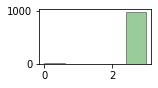

Track generation: 1127..1413 -> 286-tiles track
Episodi 2: recompensa = -92.9825


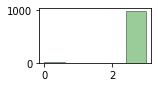

Track generation: 1161..1455 -> 294-tiles track
Episodi 3: recompensa = -93.1741


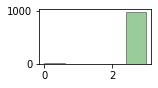

Track generation: 871..1096 -> 225-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1204..1509 -> 305-tiles track
Episodi 4: recompensa = -93.4211


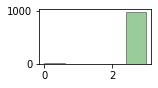

Track generation: 1164..1459 -> 295-tiles track
Episodi 5: recompensa = -93.1973


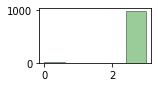

Track generation: 1257..1575 -> 318-tiles track
Episodi 6: recompensa = -93.6909


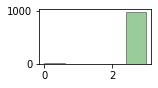

Track generation: 1165..1461 -> 296-tiles track
Episodi 7: recompensa = -93.2203


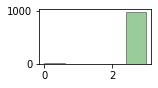

Track generation: 1215..1528 -> 313-tiles track
Episodi 8: recompensa = -93.5897


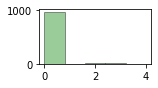

Track generation: 1182..1481 -> 299-tiles track
Episodi 9: recompensa = -93.2886


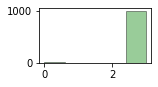

AvaluaAgent() Acabat


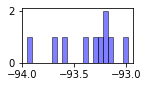


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_5
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1084..1365 -> 281-tiles track
Episodi 0: recompensa = 332.1429


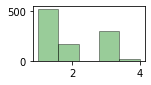

Track generation: 1166..1461 -> 295-tiles track
Episodi 1: recompensa = 253.7415


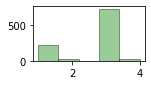

Track generation: 1210..1517 -> 307-tiles track
Episodi 2: recompensa = 501.3072


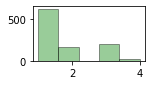

Track generation: 1099..1378 -> 279-tiles track
Episodi 3: recompensa = 698.5612


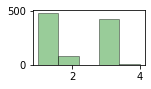

Track generation: 1128..1414 -> 286-tiles track
Episodi 4: recompensa = 538.5965


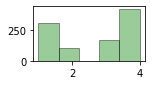

Track generation: 1199..1503 -> 304-tiles track
Episodi 5: recompensa = 282.8383


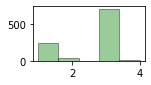

Track generation: 1192..1495 -> 303-tiles track
Episodi 6: recompensa = 270.8609


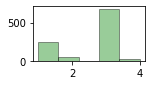

Track generation: 1048..1323 -> 275-tiles track
Episodi 7: recompensa = 184.6715


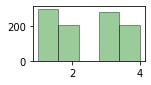

Track generation: 1164..1460 -> 296-tiles track
Episodi 8: recompensa = 266.1017


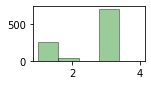

Track generation: 1274..1597 -> 323-tiles track
Episodi 9: recompensa = 163.9752


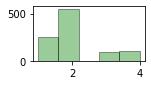

AvaluaAgent() Acabat


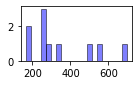


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_6
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1175..1473 -> 298-tiles track
Episodi 0: recompensa = 549.8316


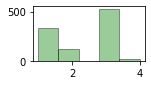

Track generation: 937..1180 -> 243-tiles track
Episodi 1: recompensa = 821.4876


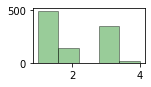

Track generation: 1144..1434 -> 290-tiles track
Episodi 2: recompensa = 595.5017


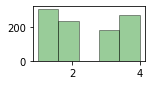

Track generation: 1049..1323 -> 274-tiles track
Episodi 3: recompensa = 64.8352


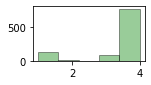

Track generation: 1051..1326 -> 275-tiles track
Episodi 4: recompensa = 768.6131


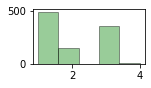

Track generation: 1117..1408 -> 291-tiles track
Episodi 5: recompensa = 41.3793


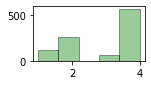

Track generation: 1258..1578 -> 320-tiles track
Episodi 6: recompensa = 765.2038


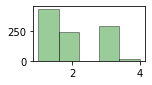

Track generation: 1196..1499 -> 303-tiles track
Episodi 7: recompensa = 280.7947


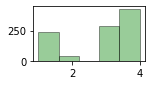

Track generation: 1223..1533 -> 310-tiles track
Episodi 8: recompensa = 628.1553


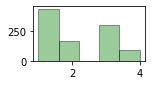

Track generation: 1171..1468 -> 297-tiles track
Episodi 9: recompensa = 349.3243


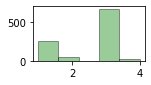

AvaluaAgent() Acabat


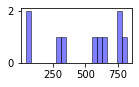


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_7
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1216..1524 -> 308-tiles track
Episodi 0: recompensa = -64.1694


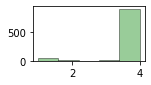

Track generation: 1161..1462 -> 301-tiles track
Episodi 1: recompensa = -63.3333


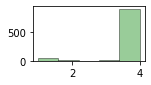

Track generation: 1196..1508 -> 312-tiles track
Episodi 2: recompensa = 31.8328


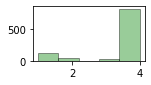

Track generation: 1372..1719 -> 347-tiles track
Episodi 3: recompensa = -91.3295


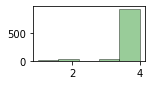

Track generation: 1107..1388 -> 281-tiles track
Episodi 4: recompensa = -53.5714


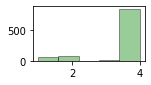

Track generation: 1029..1292 -> 263-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1204..1509 -> 305-tiles track
Episodi 5: recompensa = -90.1316


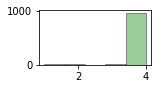

Track generation: 1072..1344 -> 272-tiles track
Episodi 6: recompensa = -55.7196


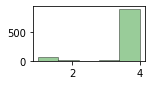

Track generation: 1199..1503 -> 304-tiles track
Episodi 7: recompensa = -90.099


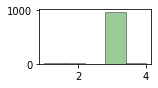

Track generation: 1132..1419 -> 287-tiles track
Episodi 8: recompensa = -51.049


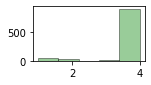

Track generation: 1091..1368 -> 277-tiles track
Episodi 9: recompensa = -56.5217


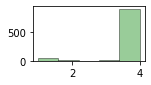

AvaluaAgent() Acabat


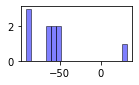


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_8
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1200..1504 -> 304-tiles track
Episodi 0: recompensa = 523.7624


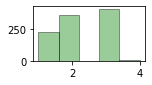

Track generation: 1320..1663 -> 343-tiles track
Episodi 1: recompensa = 350.2924


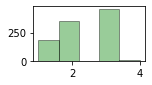

Track generation: 1085..1360 -> 275-tiles track
Episodi 2: recompensa = 637.2263


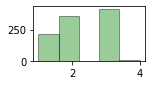

Track generation: 1171..1468 -> 297-tiles track
Episodi 3: recompensa = 545.2703


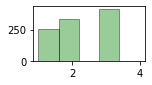

Track generation: 1079..1353 -> 274-tiles track
Episodi 4: recompensa = 269.9634


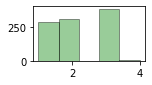

Track generation: 1083..1358 -> 275-tiles track
Episodi 5: recompensa = 527.7372


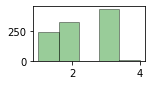

Track generation: 1038..1307 -> 269-tiles track
Episodi 6: recompensa = 485.8209


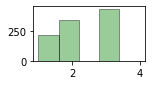

Track generation: 1179..1478 -> 299-tiles track
Episodi 7: recompensa = 514.094


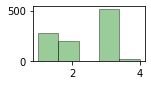

Track generation: 1271..1596 -> 325-tiles track
Episodi 8: recompensa = 205.5556


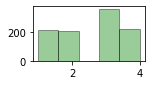

Track generation: 1164..1459 -> 295-tiles track
Episodi 9: recompensa = 287.7551


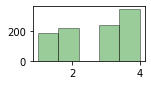

AvaluaAgent() Acabat


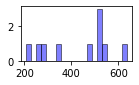


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_9
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1168..1464 -> 296-tiles track
Episodi 0: recompensa = -93.2203


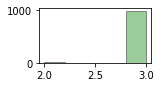

Track generation: 923..1158 -> 235-tiles track
Episodi 1: recompensa = -91.453


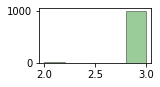

Track generation: 1033..1301 -> 268-tiles track
Episodi 2: recompensa = -92.5094


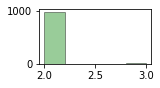

Track generation: 1144..1434 -> 290-tiles track
Episodi 3: recompensa = -93.0796


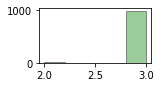

Track generation: 1236..1549 -> 313-tiles track
Episodi 4: recompensa = -93.5897


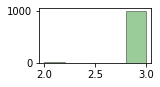

Track generation: 1148..1439 -> 291-tiles track
Episodi 5: recompensa = -93.1034


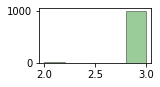

Track generation: 1135..1425 -> 290-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1253..1579 -> 326-tiles track
Episodi 6: recompensa = -93.8462


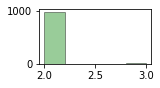

Track generation: 1135..1423 -> 288-tiles track
Episodi 7: recompensa = -93.0314


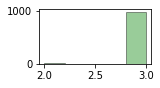

Track generation: 1200..1504 -> 304-tiles track
Episodi 8: recompensa = -93.3993


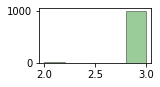

Track generation: 1129..1425 -> 296-tiles track
Episodi 9: recompensa = -93.2203


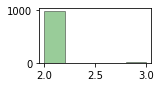

AvaluaAgent() Acabat


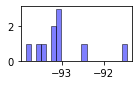


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_10
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1326..1662 -> 336-tiles track
Episodi 0: recompensa = -94.0299


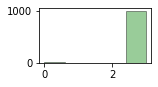

Track generation: 1095..1373 -> 278-tiles track
Episodi 1: recompensa = -92.7798


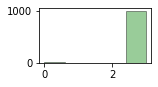

Track generation: 1115..1398 -> 283-tiles track
Episodi 2: recompensa = -92.9078


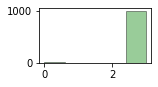

Track generation: 1149..1441 -> 292-tiles track
Episodi 3: recompensa = -93.1271


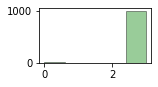

Track generation: 1096..1374 -> 278-tiles track
Episodi 4: recompensa = -92.7798


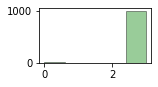

Track generation: 1072..1344 -> 272-tiles track
Episodi 5: recompensa = -92.6199


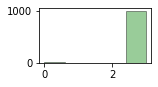

Track generation: 1103..1383 -> 280-tiles track
Episodi 6: recompensa = -92.8315


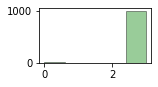

Track generation: 1076..1357 -> 281-tiles track
Episodi 7: recompensa = -92.8571


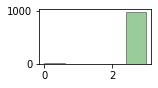

Track generation: 1112..1394 -> 282-tiles track
Episodi 8: recompensa = -92.8826


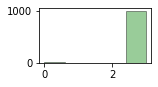

Track generation: 1112..1394 -> 282-tiles track
Episodi 9: recompensa = -92.8826


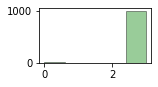

AvaluaAgent() Acabat


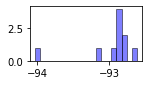


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_11
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1171..1468 -> 297-tiles track
Episodi 0: recompensa = 808.7838


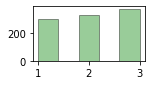

Track generation: 1331..1668 -> 337-tiles track
Episodi 1: recompensa = 376.1905


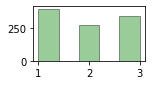

Track generation: 1188..1490 -> 302-tiles track
Episodi 2: recompensa = 584.3854


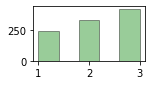

Track generation: 1089..1369 -> 280-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 947..1196 -> 249-tiles track
Episodi 3: recompensa = 452.4194


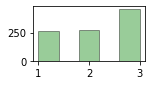

Track generation: 934..1174 -> 240-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1120..1404 -> 284-tiles track
Episodi 4: recompensa = 373.4982


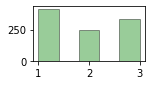

Track generation: 1288..1614 -> 326-tiles track
Episodi 5: recompensa = 376.9231


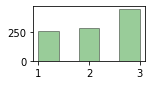

Track generation: 1158..1452 -> 294-tiles track
Episodi 6: recompensa = 572.3549


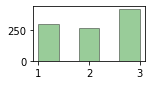

Track generation: 1230..1548 -> 318-tiles track
Episodi 7: recompensa = 445.7413


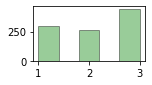

Track generation: 1032..1294 -> 262-tiles track
Episodi 8: recompensa = 811.8774


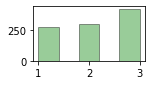

Track generation: 1034..1306 -> 272-tiles track
Episodi 9: recompensa = -92.6199


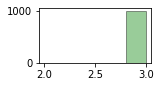

AvaluaAgent() Acabat


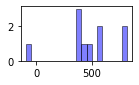


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_12
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1128..1450 -> 322-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1054..1328 -> 274-tiles track
Episodi 0: recompensa = -92.674


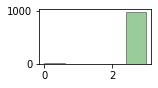

Track generation: 1050..1317 -> 267-tiles track
Episodi 1: recompensa = -92.4812


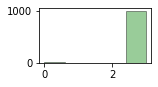

Track generation: 1388..1739 -> 351-tiles track
Episodi 2: recompensa = -94.2857


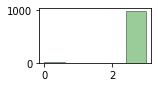

Track generation: 1211..1518 -> 307-tiles track
Episodi 3: recompensa = -93.4641


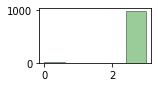

Track generation: 1029..1295 -> 266-tiles track
Episodi 4: recompensa = -92.4528


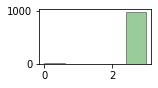

Track generation: 1153..1445 -> 292-tiles track
Episodi 5: recompensa = -93.1271


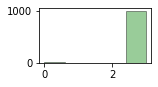

Track generation: 1115..1398 -> 283-tiles track
Episodi 6: recompensa = -92.9078


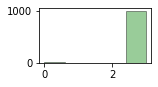

Track generation: 1223..1532 -> 309-tiles track
Episodi 7: recompensa = -93.5065


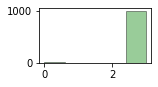

Track generation: 1084..1359 -> 275-tiles track
Episodi 8: recompensa = -92.7007


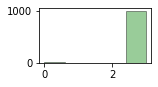

Track generation: 1172..1469 -> 297-tiles track
Episodi 9: recompensa = -93.2432


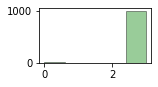

AvaluaAgent() Acabat


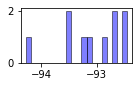


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_13
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1135..1423 -> 288-tiles track
Episodi 0: recompensa = 154.3554


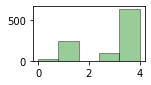

Track generation: 1199..1501 -> 302-tiles track
Episodi 1: recompensa = -53.4884


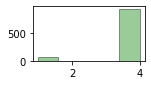

Track generation: 1259..1578 -> 319-tiles track
Episodi 2: recompensa = -52.8302


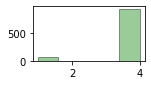

Track generation: 1056..1324 -> 268-tiles track
Episodi 3: recompensa = -47.5655


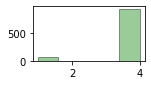

Track generation: 1277..1600 -> 323-tiles track
Episodi 4: recompensa = -56.5217


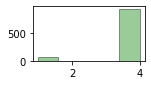

Track generation: 1137..1430 -> 293-tiles track
Episodi 5: recompensa = -17.8082


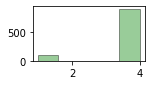

Track generation: 1223..1533 -> 310-tiles track
Episodi 6: recompensa = -51.4563


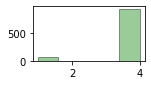

Track generation: 1151..1443 -> 292-tiles track
Episodi 7: recompensa = -48.4536


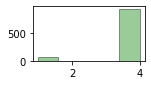

Track generation: 1244..1559 -> 315-tiles track
Episodi 8: recompensa = -58.5987


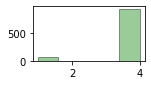

Track generation: 1112..1394 -> 282-tiles track
Episodi 9: recompensa = -53.7367


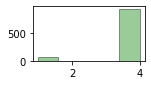

AvaluaAgent() Acabat


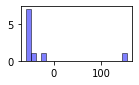


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_14
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1158..1451 -> 293-tiles track
Episodi 0: recompensa = -93.1507


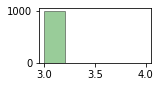

Track generation: 1214..1522 -> 308-tiles track
Episodi 1: recompensa = -93.4853


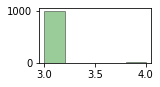

Track generation: 1054..1324 -> 270-tiles track
Episodi 2: recompensa = -92.5651


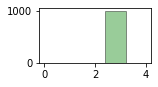

Track generation: 1129..1420 -> 291-tiles track
Episodi 3: recompensa = -93.1034


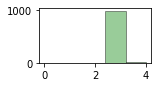

Track generation: 1076..1349 -> 273-tiles track
Episodi 4: recompensa = -92.6471


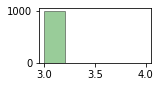

Track generation: 1228..1539 -> 311-tiles track
Episodi 5: recompensa = -93.5484


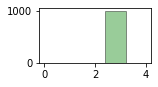

Track generation: 1044..1309 -> 265-tiles track
Episodi 6: recompensa = -92.4242


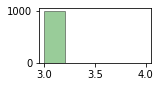

Track generation: 1141..1436 -> 295-tiles track
Episodi 7: recompensa = -93.1973


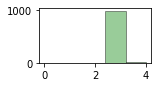

Track generation: 1039..1305 -> 266-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1182..1482 -> 300-tiles track
Episodi 8: recompensa = -93.311


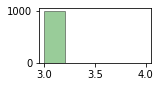

Track generation: 1105..1385 -> 280-tiles track
Episodi 9: recompensa = -92.8315


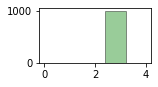

AvaluaAgent() Acabat


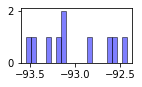


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_15
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1201..1505 -> 304-tiles track
Episodi 0: recompensa = -93.3993


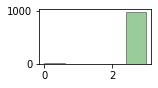

Track generation: 1021..1280 -> 259-tiles track
Episodi 1: recompensa = -92.2481


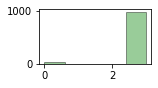

Track generation: 1037..1305 -> 268-tiles track
Episodi 2: recompensa = -92.5094


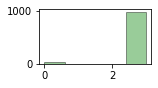

Track generation: 1112..1394 -> 282-tiles track
Episodi 3: recompensa = -92.8826


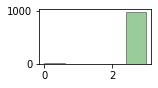

Track generation: 1136..1424 -> 288-tiles track
Episodi 4: recompensa = -93.0314


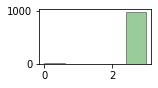

Track generation: 1092..1373 -> 281-tiles track
Episodi 5: recompensa = -92.8571


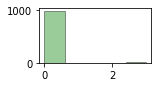

Track generation: 1199..1503 -> 304-tiles track
Episodi 6: recompensa = -93.3993


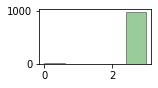

Track generation: 1075..1356 -> 281-tiles track
Episodi 7: recompensa = -92.8571


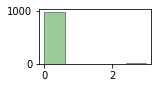

Track generation: 1250..1567 -> 317-tiles track
Episodi 8: recompensa = -93.6709


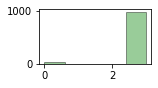

Track generation: 1128..1414 -> 286-tiles track
Episodi 9: recompensa = -92.9825


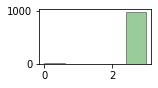

AvaluaAgent() Acabat


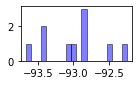


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_16
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1060..1329 -> 269-tiles track
Episodi 0: recompensa = -92.5373


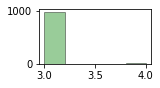

Track generation: 1040..1304 -> 264-tiles track
Episodi 1: recompensa = -92.3954


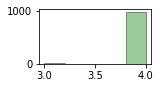

Track generation: 1328..1664 -> 336-tiles track
Episodi 2: recompensa = -94.0299


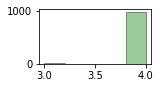

Track generation: 1084..1359 -> 275-tiles track
Episodi 3: recompensa = -92.7007


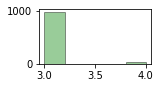

Track generation: 1253..1570 -> 317-tiles track
Episodi 4: recompensa = -93.6709


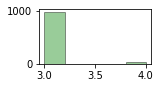

Track generation: 1187..1488 -> 301-tiles track
Episodi 5: recompensa = -93.3333


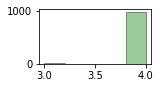

Track generation: 1214..1522 -> 308-tiles track
Episodi 6: recompensa = -93.4853


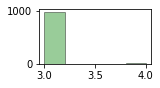

Track generation: 1253..1570 -> 317-tiles track
Episodi 7: recompensa = -93.6709


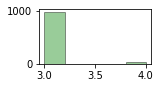

Track generation: 1232..1544 -> 312-tiles track
Episodi 8: recompensa = -93.5691


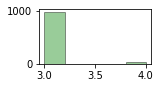

Track generation: 1075..1351 -> 276-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1032..1300 -> 268-tiles track
Episodi 9: recompensa = -92.5094


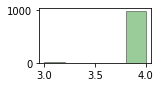

AvaluaAgent() Acabat


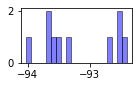


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_17
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1139..1428 -> 289-tiles track
Episodi 0: recompensa = -93.0556


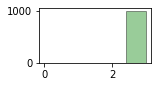

Track generation: 1092..1369 -> 277-tiles track
Episodi 1: recompensa = -92.7536


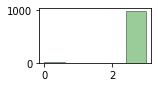

Track generation: 1200..1504 -> 304-tiles track
Episodi 2: recompensa = -93.3993


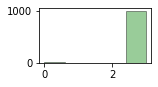

Track generation: 1175..1473 -> 298-tiles track
Episodi 3: recompensa = -93.266


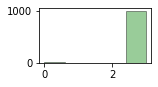

Track generation: 1331..1668 -> 337-tiles track
Episodi 4: recompensa = -94.0476


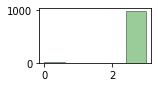

Track generation: 1091..1372 -> 281-tiles track
Episodi 5: recompensa = -92.8571


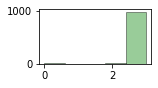

Track generation: 1089..1365 -> 276-tiles track
Episodi 6: recompensa = -92.7273


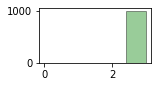

Track generation: 1100..1379 -> 279-tiles track
Episodi 7: recompensa = -92.8058


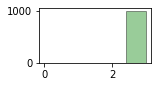

Track generation: 1048..1314 -> 266-tiles track
Episodi 8: recompensa = -92.4528


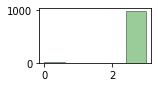

Track generation: 1059..1328 -> 269-tiles track
Episodi 9: recompensa = -92.5373


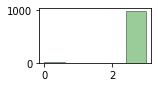

AvaluaAgent() Acabat


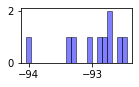


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_18
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1164..1459 -> 295-tiles track
Episodi 0: recompensa = -93.1973


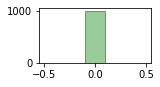

Track generation: 1154..1448 -> 294-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1196..1499 -> 303-tiles track
Episodi 1: recompensa = -93.3775


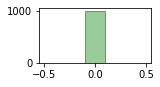

Track generation: 1117..1400 -> 283-tiles track
Episodi 2: recompensa = -92.9078


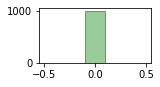

Track generation: 1088..1365 -> 277-tiles track
Episodi 3: recompensa = -92.7536


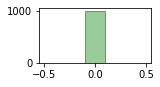

Track generation: 1213..1520 -> 307-tiles track
Episodi 4: recompensa = -93.4641


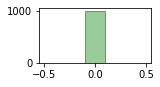

Track generation: 991..1243 -> 252-tiles track
Episodi 5: recompensa = -92.0319


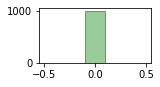

Track generation: 1128..1414 -> 286-tiles track
Episodi 6: recompensa = -92.9825


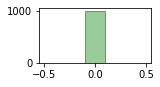

Track generation: 1152..1451 -> 299-tiles track
Episodi 7: recompensa = -93.2886


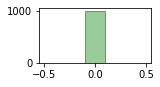

Track generation: 1229..1540 -> 311-tiles track
Episodi 8: recompensa = -93.5484


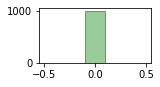

Track generation: 1024..1292 -> 268-tiles track
Episodi 9: recompensa = -92.5094


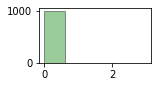

AvaluaAgent() Acabat


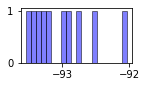


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_19
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1084..1366 -> 282-tiles track
Episodi 0: recompensa = 49.4662


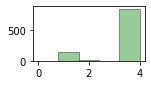

Track generation: 1232..1544 -> 312-tiles track
Episodi 1: recompensa = -32.4759


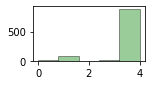

Track generation: 969..1221 -> 252-tiles track
Episodi 2: recompensa = 51.3944


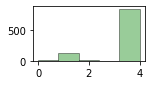

Track generation: 1069..1347 -> 278-tiles track
Episodi 3: recompensa = 37.1841


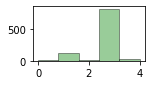

Track generation: 1291..1618 -> 327-tiles track
Episodi 4: recompensa = -32.5153


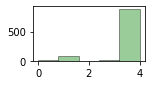

Track generation: 1177..1475 -> 298-tiles track
Episodi 5: recompensa = 58.2492


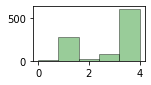

Track generation: 1144..1434 -> 290-tiles track
Episodi 6: recompensa = -23.8754


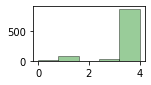

Track generation: 1037..1310 -> 273-tiles track
Episodi 7: recompensa = 80.1471


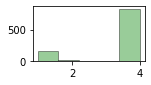

Track generation: 1128..1424 -> 296-tiles track
Episodi 8: recompensa = 49.1525


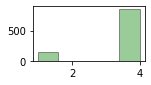

Track generation: 1215..1523 -> 308-tiles track
Episodi 9: recompensa = -31.5961


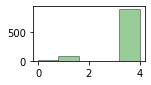

AvaluaAgent() Acabat


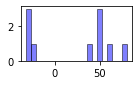


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_20
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1057..1330 -> 273-tiles track
Episodi 0: recompensa = 657.3529


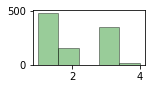

Track generation: 1229..1546 -> 317-tiles track
Episodi 1: recompensa = 377.8481


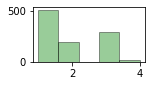

Track generation: 1115..1398 -> 283-tiles track
Episodi 2: recompensa = 722.695


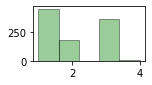

Track generation: 1172..1469 -> 297-tiles track
Episodi 3: recompensa = 314.1865


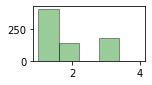

Track generation: 1220..1529 -> 309-tiles track
Episodi 4: recompensa = 357.7922


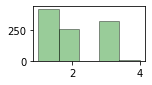

Track generation: 1252..1569 -> 317-tiles track
Episodi 5: recompensa = 311.3924


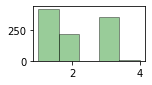

Track generation: 1202..1506 -> 304-tiles track
Episodi 6: recompensa = 38.7218


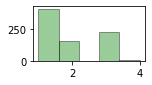

Track generation: 1187..1488 -> 301-tiles track
Episodi 7: recompensa = 248.8333


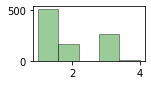

Track generation: 1015..1279 -> 264-tiles track
Episodi 8: recompensa = 451.3308


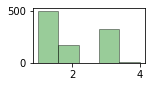

Track generation: 1096..1374 -> 278-tiles track
Episodi 9: recompensa = 259.9332


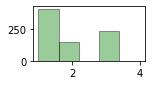

AvaluaAgent() Acabat


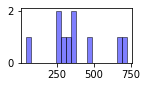


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_21
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1168..1464 -> 296-tiles track
Episodi 0: recompensa = -93.2203


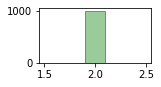

Track generation: 1181..1480 -> 299-tiles track
Episodi 1: recompensa = -93.2886


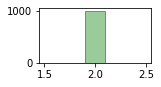

Track generation: 1134..1422 -> 288-tiles track
Episodi 2: recompensa = -93.0314


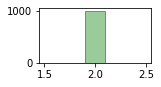

Track generation: 1343..1683 -> 340-tiles track
Episodi 3: recompensa = -94.1003


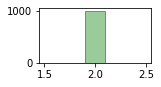

Track generation: 1134..1421 -> 287-tiles track
Episodi 4: recompensa = -93.007


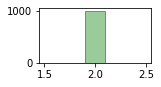

Track generation: 1300..1629 -> 329-tiles track
Episodi 5: recompensa = -93.9024


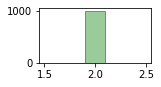

Track generation: 1240..1554 -> 314-tiles track
Episodi 6: recompensa = -93.6102


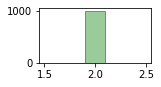

Track generation: 1111..1394 -> 283-tiles track
Episodi 7: recompensa = -92.9078


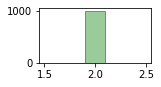

Track generation: 1193..1495 -> 302-tiles track
Episodi 8: recompensa = -93.3555


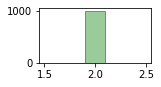

Track generation: 1099..1429 -> 330-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1086..1371 -> 285-tiles track
Episodi 9: recompensa = -92.9577


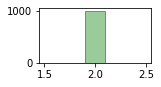

AvaluaAgent() Acabat


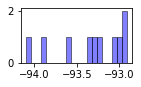


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_22
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1207..1513 -> 306-tiles track
Episodi 0: recompensa = -93.4426


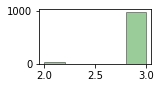

Track generation: 1047..1321 -> 274-tiles track
Episodi 1: recompensa = -92.674


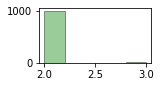

Track generation: 1172..1469 -> 297-tiles track
Episodi 2: recompensa = -93.2432


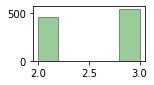

Track generation: 1150..1442 -> 292-tiles track
Episodi 3: recompensa = -93.1271


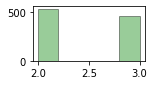

Track generation: 1071..1343 -> 272-tiles track
Episodi 4: recompensa = -92.6199


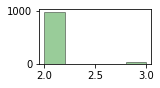

Track generation: 1169..1467 -> 298-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1099..1378 -> 279-tiles track
Episodi 5: recompensa = -92.8058


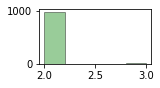

Track generation: 1183..1490 -> 307-tiles track
Episodi 6: recompensa = -93.4641


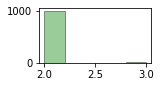

Track generation: 1165..1468 -> 303-tiles track
Episodi 7: recompensa = -93.3775


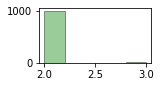

Track generation: 1082..1362 -> 280-tiles track
Episodi 8: recompensa = -92.8315


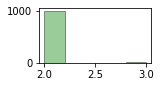

Track generation: 1108..1393 -> 285-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1260..1579 -> 319-tiles track
Episodi 9: recompensa = -93.7107


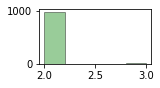

AvaluaAgent() Acabat


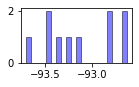


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_23
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1188..1490 -> 302-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1164..1467 -> 303-tiles track
Episodi 0: recompensa = 280.7947


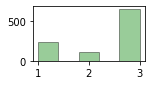

Track generation: 1028..1289 -> 261-tiles track
Episodi 1: recompensa = 284.6154


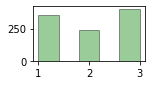

Track generation: 1255..1573 -> 318-tiles track
Episodi 2: recompensa = 534.0694


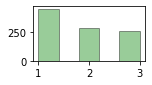

Track generation: 1123..1408 -> 285-tiles track
Episodi 3: recompensa = 438.7324


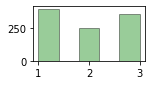

Track generation: 1189..1498 -> 309-tiles track
Episodi 4: recompensa = 396.7532


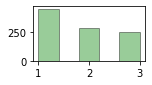

Track generation: 1078..1352 -> 274-tiles track
Episodi 5: recompensa = 643.5897


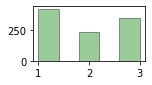

Track generation: 1221..1530 -> 309-tiles track
Episodi 6: recompensa = 477.9221


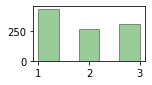

Track generation: 1144..1434 -> 290-tiles track
Episodi 7: recompensa = 477.8547


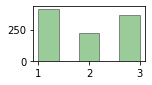

Track generation: 1023..1282 -> 259-tiles track
Episodi 8: recompensa = 748.8372


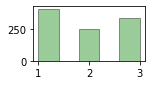

Track generation: 1060..1329 -> 269-tiles track
Episodi 9: recompensa = 523.1343


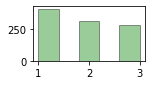

AvaluaAgent() Acabat


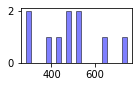


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_24
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1021..1280 -> 259-tiles track
Episodi 0: recompensa = -92.2481


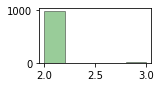

Track generation: 1331..1668 -> 337-tiles track
Episodi 1: recompensa = -94.0476


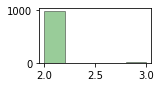

Track generation: 1313..1645 -> 332-tiles track
Episodi 2: recompensa = -93.9577


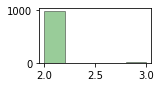

Track generation: 1063..1335 -> 272-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1075..1348 -> 273-tiles track
Episodi 3: recompensa = -92.6471


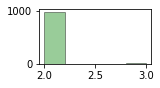

Track generation: 1203..1508 -> 305-tiles track
Episodi 4: recompensa = -93.4211


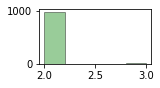

Track generation: 1237..1550 -> 313-tiles track
Episodi 5: recompensa = -93.5897


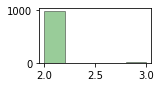

Track generation: 1236..1549 -> 313-tiles track
Episodi 6: recompensa = -93.5897


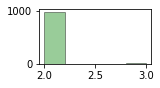

Track generation: 1164..1459 -> 295-tiles track
Episodi 7: recompensa = -93.1973


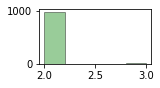

Track generation: 976..1229 -> 253-tiles track
Episodi 8: recompensa = -92.0635


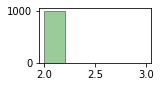

Track generation: 1168..1464 -> 296-tiles track
Episodi 9: recompensa = -93.2203


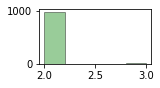

AvaluaAgent() Acabat


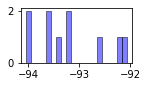


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_25
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 993..1249 -> 256-tiles track
Episodi 0: recompensa = -92.1569


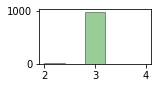

Track generation: 1230..1545 -> 315-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1304..1634 -> 330-tiles track
Episodi 1: recompensa = -93.921


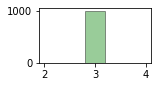

Track generation: 1263..1583 -> 320-tiles track
Episodi 2: recompensa = -93.7304


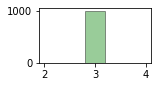

Track generation: 1407..1763 -> 356-tiles track
Episodi 3: recompensa = -94.3662


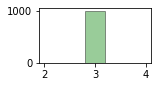

Track generation: 1087..1363 -> 276-tiles track
Episodi 4: recompensa = -92.7273


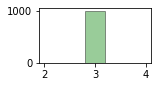

Track generation: 1094..1377 -> 283-tiles track
Episodi 5: recompensa = -92.9078


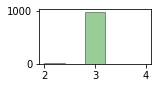

Track generation: 1395..1748 -> 353-tiles track
Episodi 6: recompensa = -94.3182


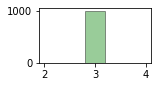

Track generation: 1151..1443 -> 292-tiles track
Episodi 7: recompensa = -93.1271


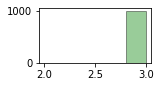

Track generation: 1195..1497 -> 302-tiles track
Episodi 8: recompensa = -93.3555


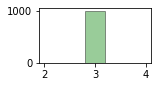

Track generation: 1237..1551 -> 314-tiles track
Episodi 9: recompensa = -93.6102


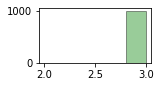

AvaluaAgent() Acabat


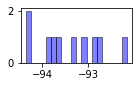


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_26
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1105..1386 -> 281-tiles track
Episodi 0: recompensa = -92.8571


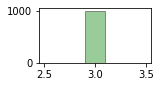

Track generation: 1055..1328 -> 273-tiles track
Episodi 1: recompensa = -92.6471


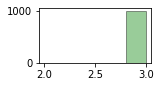

Track generation: 1130..1424 -> 294-tiles track
Episodi 2: recompensa = -93.1741


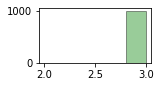

Track generation: 1236..1549 -> 313-tiles track
Episodi 3: recompensa = -93.5897


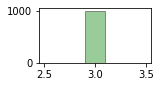

Track generation: 1208..1515 -> 307-tiles track
Episodi 4: recompensa = -93.4641


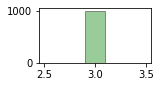

Track generation: 1260..1579 -> 319-tiles track
Episodi 5: recompensa = -93.7107


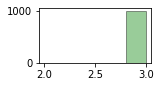

Track generation: 1048..1321 -> 273-tiles track
Episodi 6: recompensa = -92.6471


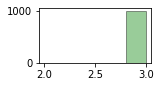

Track generation: 1144..1434 -> 290-tiles track
Episodi 7: recompensa = -93.0796


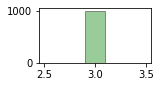

Track generation: 1131..1418 -> 287-tiles track
Episodi 8: recompensa = -93.007


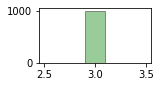

Track generation: 1116..1403 -> 287-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1017..1281 -> 264-tiles track
Episodi 9: recompensa = -92.3954


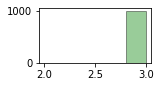

AvaluaAgent() Acabat


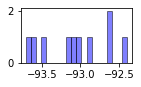


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_27
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1127..1413 -> 286-tiles track
Episodi 0: recompensa = -92.9825


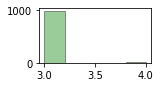

Track generation: 1168..1469 -> 301-tiles track
Episodi 1: recompensa = -93.3333


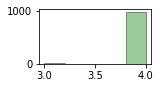

Track generation: 988..1239 -> 251-tiles track
Episodi 2: recompensa = -92.0


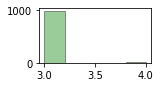

Track generation: 1286..1611 -> 325-tiles track
Episodi 3: recompensa = -93.8272


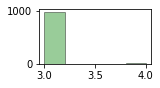

Track generation: 1024..1284 -> 260-tiles track
Episodi 4: recompensa = -92.278


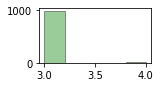

Track generation: 918..1157 -> 239-tiles track
Episodi 5: recompensa = -91.5966


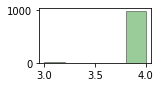

Track generation: 1271..1593 -> 322-tiles track
Episodi 6: recompensa = -93.7695


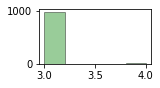

Track generation: 1199..1505 -> 306-tiles track
Episodi 7: recompensa = -93.4426


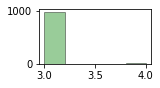

Track generation: 1175..1473 -> 298-tiles track
Episodi 8: recompensa = -93.266


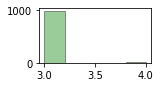

Track generation: 1020..1279 -> 259-tiles track
Episodi 9: recompensa = -92.2481


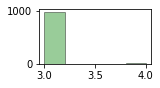

AvaluaAgent() Acabat


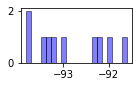


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_28
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1212..1519 -> 307-tiles track
Episodi 0: recompensa = 553.5948


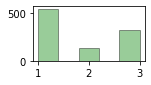

Track generation: 1115..1408 -> 293-tiles track
Episodi 1: recompensa = 458.2192


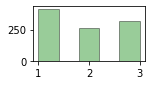

Track generation: 1095..1381 -> 286-tiles track
Episodi 2: recompensa = 71.9298


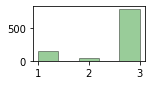

Track generation: 1242..1557 -> 315-tiles track
Episodi 3: recompensa = 492.3567


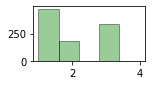

Track generation: 1124..1409 -> 285-tiles track
Episodi 4: recompensa = 498.5915


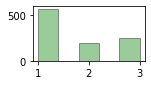

Track generation: 1108..1389 -> 281-tiles track
Episodi 5: recompensa = 475.0


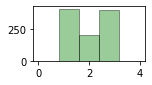

Track generation: 1147..1438 -> 291-tiles track
Episodi 6: recompensa = 524.1379


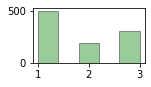

Track generation: 1193..1495 -> 302-tiles track
Episodi 7: recompensa = 458.1395


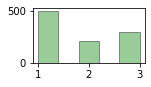

Track generation: 1120..1404 -> 284-tiles track
Episodi 8: recompensa = 398.2332


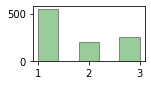

Track generation: 1224..1534 -> 310-tiles track
Episodi 9: recompensa = 414.5631


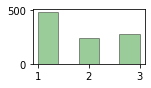

AvaluaAgent() Acabat


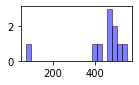


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_29
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1050..1324 -> 274-tiles track
Episodi 0: recompensa = 368.8645


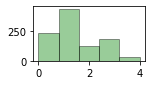

Track generation: 1196..1499 -> 303-tiles track
Episodi 1: recompensa = 466.2252


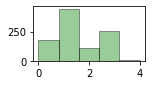

Track generation: 1160..1454 -> 294-tiles track
Episodi 2: recompensa = 166.2116


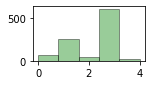

Track generation: 1143..1433 -> 290-tiles track
Episodi 3: recompensa = 256.4014


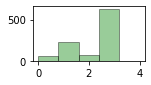

Track generation: 1096..1374 -> 278-tiles track
Episodi 4: recompensa = 123.8267


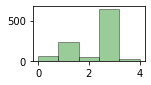

Track generation: 1184..1484 -> 300-tiles track
Episodi 5: recompensa = 287.9599


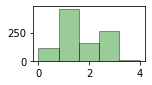

Track generation: 1244..1559 -> 315-tiles track
Episodi 6: recompensa = 336.3057


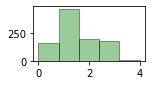

Track generation: 1003..1262 -> 259-tiles track
Episodi 7: recompensa = 299.2248


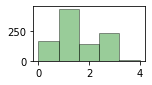

Track generation: 1071..1343 -> 272-tiles track
Episodi 8: recompensa = 460.8856


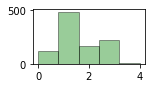

Track generation: 1224..1534 -> 310-tiles track
Episodi 9: recompensa = 29.4498


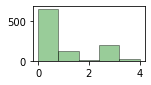

AvaluaAgent() Acabat


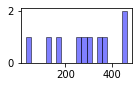


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_30
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1049..1303 -> 254-tiles track
Episodi 0: recompensa = 46.2451


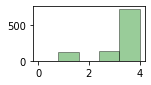

Track generation: 1141..1430 -> 289-tiles track
Episodi 1: recompensa = 90.9722


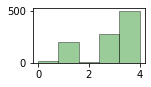

Track generation: 1275..1598 -> 323-tiles track
Episodi 2: recompensa = 67.7019


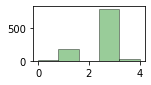

Track generation: 1179..1478 -> 299-tiles track
Episodi 3: recompensa = 208.7248


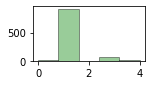

Track generation: 1287..1613 -> 326-tiles track
Episodi 4: recompensa = 16.9231


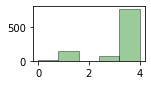

Track generation: 1207..1513 -> 306-tiles track
Episodi 5: recompensa = 326.2295


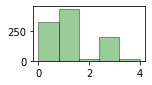

Track generation: 1302..1640 -> 338-tiles track
Episodi 6: recompensa = 220.4748


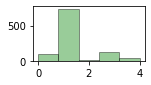

Track generation: 1239..1553 -> 314-tiles track
Episodi 7: recompensa = 139.6166


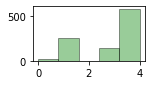

Track generation: 986..1237 -> 251-tiles track
Episodi 8: recompensa = 296.0


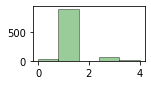

Track generation: 1315..1647 -> 332-tiles track
Episodi 9: recompensa = 226.284


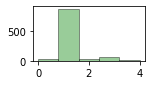

AvaluaAgent() Acabat


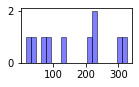


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_31
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1125..1410 -> 285-tiles track
Episodi 0: recompensa = -92.9577


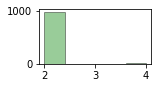

Track generation: 1100..1379 -> 279-tiles track
Episodi 1: recompensa = -92.8058


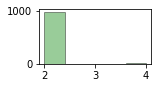

Track generation: 1079..1353 -> 274-tiles track
Episodi 2: recompensa = -92.674


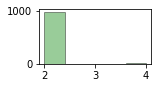

Track generation: 1128..1414 -> 286-tiles track
Episodi 3: recompensa = -92.9825


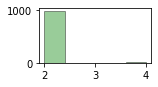

Track generation: 1091..1368 -> 277-tiles track
Episodi 4: recompensa = -92.7536


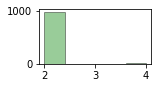

Track generation: 1252..1569 -> 317-tiles track
Episodi 5: recompensa = -93.6709


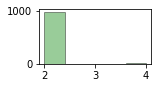

Track generation: 1248..1564 -> 316-tiles track
Episodi 6: recompensa = -93.6508


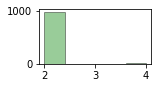

Track generation: 1160..1454 -> 294-tiles track
Episodi 7: recompensa = -93.1741


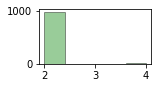

Track generation: 1087..1362 -> 275-tiles track
Episodi 8: recompensa = -92.7007


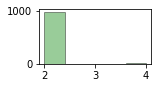

Track generation: 1052..1324 -> 272-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1231..1543 -> 312-tiles track
Episodi 9: recompensa = -93.5691


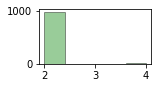

AvaluaAgent() Acabat


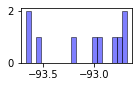


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_32
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1189..1490 -> 301-tiles track
Episodi 0: recompensa = -93.3333


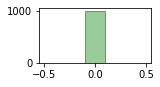

Track generation: 1189..1491 -> 302-tiles track
Episodi 1: recompensa = -93.3555


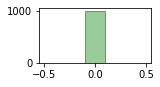

Track generation: 1164..1466 -> 302-tiles track
Episodi 2: recompensa = -93.3555


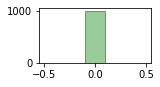

Track generation: 1146..1445 -> 299-tiles track
Episodi 3: recompensa = -93.2886


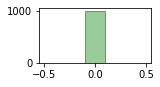

Track generation: 994..1218 -> 224-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1216..1524 -> 308-tiles track
Episodi 4: recompensa = -93.4853


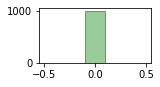

Track generation: 996..1249 -> 253-tiles track
Episodi 5: recompensa = -92.0635


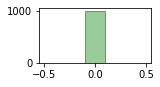

Track generation: 1171..1473 -> 302-tiles track
Episodi 6: recompensa = -93.3555


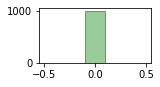

Track generation: 1223..1533 -> 310-tiles track
Episodi 7: recompensa = -93.5275


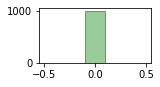

Track generation: 1266..1586 -> 320-tiles track
Episodi 8: recompensa = -93.7304


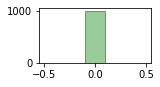

Track generation: 970..1222 -> 252-tiles track
Episodi 9: recompensa = -92.0319


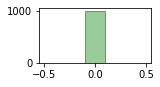

AvaluaAgent() Acabat


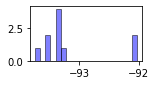


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_33
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1211..1518 -> 307-tiles track
Episodi 0: recompensa = -93.4641


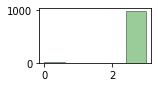

Track generation: 1288..1614 -> 326-tiles track
Episodi 1: recompensa = -93.8462


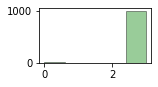

Track generation: 1150..1446 -> 296-tiles track
Episodi 2: recompensa = -93.2203


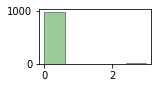

Track generation: 1060..1329 -> 269-tiles track
Episodi 3: recompensa = -92.5373


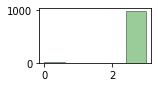

Track generation: 1026..1290 -> 264-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1213..1526 -> 313-tiles track
Episodi 4: recompensa = -93.5897


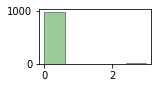

Track generation: 1318..1652 -> 334-tiles track
Episodi 5: recompensa = -93.994


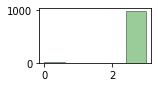

Track generation: 1020..1282 -> 262-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1020..1282 -> 262-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1364..1709 -> 345-tiles track
Episodi 6: recompensa = -94.186


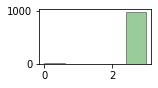

Track generation: 1072..1349 -> 277-tiles track
Episodi 7: recompensa = -92.7536


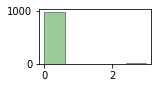

Track generation: 1220..1537 -> 317-tiles track
Episodi 8: recompensa = -93.6709


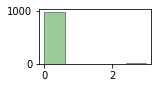

Track generation: 1042..1314 -> 272-tiles track
Episodi 9: recompensa = -92.6199


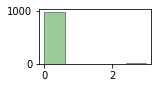

AvaluaAgent() Acabat


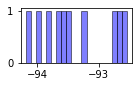


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_34
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1128..1424 -> 296-tiles track
Episodi 0: recompensa = 157.6271


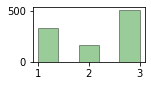

Track generation: 1079..1353 -> 274-tiles track
Episodi 1: recompensa = 262.6374


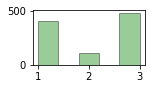

Track generation: 1185..1485 -> 300-tiles track
Episodi 2: recompensa = 605.6856


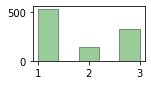

Track generation: 1125..1410 -> 285-tiles track
Episodi 3: recompensa = 275.1465


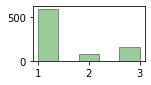

Track generation: 1287..1613 -> 326-tiles track
Episodi 4: recompensa = 232.3077


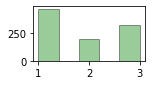

Track generation: 1214..1522 -> 308-tiles track
Episodi 5: recompensa = 303.9088


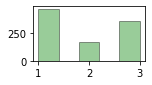

Track generation: 1027..1288 -> 261-tiles track
Episodi 6: recompensa = 438.4615


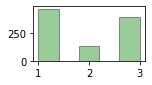

Track generation: 1154..1454 -> 300-tiles track
Episodi 7: recompensa = 107.3579


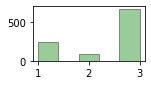

Track generation: 1007..1263 -> 256-tiles track
Episodi 8: recompensa = 158.8235


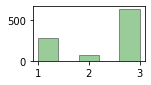

Track generation: 1240..1554 -> 314-tiles track
Episodi 9: recompensa = 130.0319


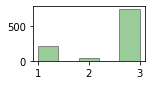

AvaluaAgent() Acabat


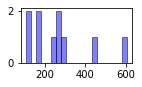


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_35
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1063..1334 -> 271-tiles track
Episodi 0: recompensa = 574.0741


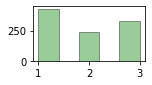

Track generation: 1085..1360 -> 275-tiles track
Episodi 1: recompensa = 582.4818


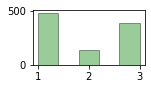

Track generation: 1134..1429 -> 295-tiles track
Episodi 2: recompensa = 651.7007


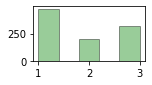

Track generation: 1012..1269 -> 257-tiles track
Episodi 3: recompensa = 419.5312


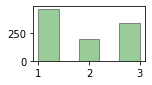

Track generation: 941..1185 -> 244-tiles track
Episodi 4: recompensa = 558.4362


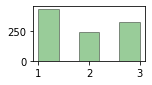

Track generation: 1080..1357 -> 277-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1106..1394 -> 288-tiles track
Episodi 5: recompensa = 287.3362


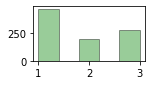

Track generation: 1379..1728 -> 349-tiles track
Episodi 6: recompensa = 451.7241


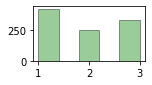

Track generation: 1126..1412 -> 286-tiles track
Episodi 7: recompensa = 187.7193


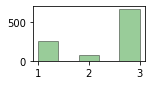

Track generation: 1260..1579 -> 319-tiles track
Episodi 8: recompensa = 346.5409


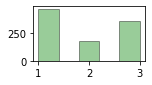

Track generation: 1237..1560 -> 323-tiles track
Episodi 9: recompensa = 350.3106


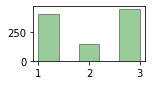

AvaluaAgent() Acabat


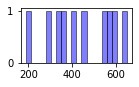


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_36
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1080..1354 -> 274-tiles track
Episodi 0: recompensa = -92.674


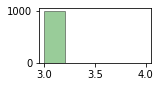

Track generation: 981..1238 -> 257-tiles track
Episodi 1: recompensa = -92.1875


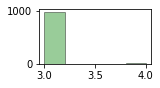

Track generation: 1156..1449 -> 293-tiles track
Episodi 2: recompensa = -93.1507


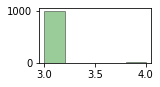

Track generation: 1125..1410 -> 285-tiles track
Episodi 3: recompensa = -92.9577


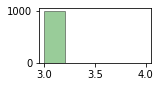

Track generation: 1256..1574 -> 318-tiles track
Episodi 4: recompensa = -93.6909


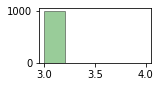

Track generation: 1030..1299 -> 269-tiles track
Episodi 5: recompensa = -92.5373


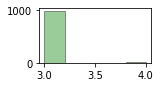

Track generation: 1058..1327 -> 269-tiles track
Episodi 6: recompensa = -92.5373


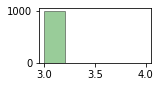

Track generation: 1116..1399 -> 283-tiles track
Episodi 7: recompensa = -92.9078


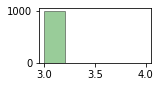

Track generation: 1247..1575 -> 328-tiles track
Episodi 8: recompensa = -93.8838


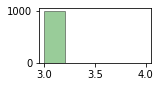

Track generation: 1113..1395 -> 282-tiles track
Episodi 9: recompensa = -92.8826


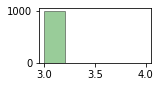

AvaluaAgent() Acabat


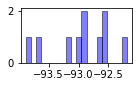


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_37
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1177..1476 -> 299-tiles track
Episodi 0: recompensa = -19.4631


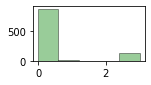

Track generation: 1228..1539 -> 311-tiles track
Episodi 1: recompensa = -25.8065


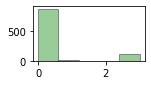

Track generation: 1137..1432 -> 295-tiles track
Episodi 2: recompensa = 46.2585


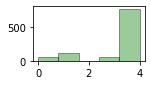

Track generation: 1146..1437 -> 291-tiles track
Episodi 3: recompensa = -17.2414


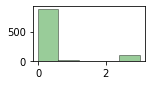

Track generation: 1184..1484 -> 300-tiles track
Episodi 4: recompensa = -19.7324


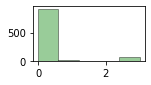

Track generation: 1206..1513 -> 307-tiles track
Episodi 5: recompensa = -21.5686


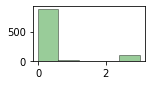

Track generation: 927..1168 -> 241-tiles track
Episodi 6: recompensa = 54.1667


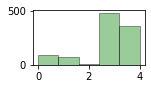

Track generation: 1110..1396 -> 286-tiles track
Episodi 7: recompensa = 19.2982


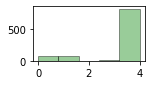

Track generation: 1132..1419 -> 287-tiles track
Episodi 8: recompensa = -16.0839


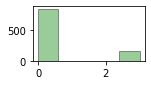

Track generation: 1191..1503 -> 312-tiles track
Episodi 9: recompensa = -29.2605


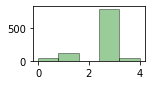

AvaluaAgent() Acabat


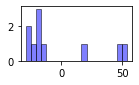


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_38
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1227..1537 -> 310-tiles track
Episodi 0: recompensa = -93.5275


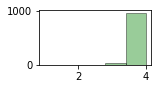

Track generation: 1279..1603 -> 324-tiles track
Episodi 1: recompensa = -65.9443


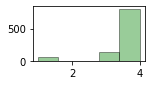

Track generation: 1181..1480 -> 299-tiles track
Episodi 2: recompensa = 779.1946


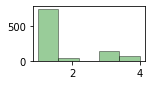

Track generation: 1027..1291 -> 264-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1152..1444 -> 292-tiles track
Episodi 3: recompensa = 247.079


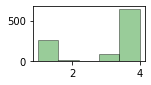

Track generation: 1107..1388 -> 281-tiles track
Episodi 4: recompensa = 707.1429


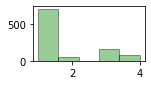

Track generation: 1020..1279 -> 259-tiles track
Episodi 5: recompensa = -92.2481


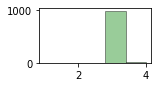

Track generation: 1172..1469 -> 297-tiles track
Episodi 6: recompensa = -62.8378


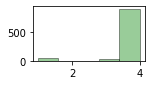

Track generation: 1140..1429 -> 289-tiles track
Episodi 7: recompensa = -61.8056


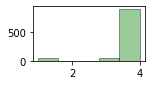

Track generation: 1104..1384 -> 280-tiles track
Episodi 8: recompensa = -92.8315


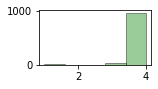

Track generation: 1180..1479 -> 299-tiles track
Episodi 9: recompensa = -59.7315


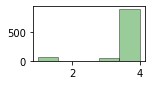

AvaluaAgent() Acabat


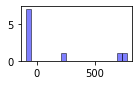


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_39
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1180..1479 -> 299-tiles track
Episodi 0: recompensa = 520.8054


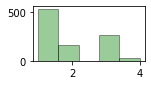

Track generation: 1022..1299 -> 277-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1248..1564 -> 316-tiles track
Episodi 1: recompensa = 242.8571


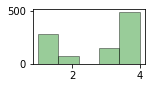

Track generation: 1060..1329 -> 269-tiles track
Episodi 2: recompensa = 26.8657


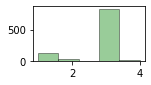

Track generation: 1045..1310 -> 265-tiles track
Episodi 3: recompensa = 206.8182


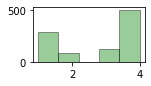

Track generation: 1168..1464 -> 296-tiles track
Episodi 4: recompensa = 686.4407


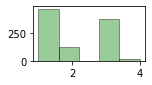

Track generation: 1108..1389 -> 281-tiles track
Episodi 5: recompensa = 357.1429


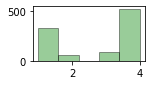

Track generation: 1279..1603 -> 324-tiles track
Episodi 6: recompensa = 144.582


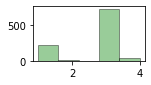

Track generation: 1127..1413 -> 286-tiles track
Episodi 7: recompensa = 15.7895


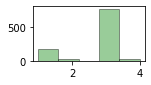

Track generation: 1184..1484 -> 300-tiles track
Episodi 8: recompensa = 234.4482


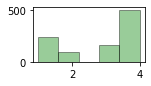

Track generation: 1145..1433 -> 288-tiles track
Episodi 9: recompensa = 725.784


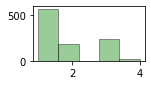

AvaluaAgent() Acabat


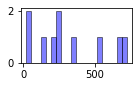


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_40
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1294..1628 -> 334-tiles track
Episodi 0: recompensa = 329.4294


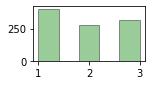

Track generation: 1116..1399 -> 283-tiles track
Episodi 1: recompensa = 319.0539


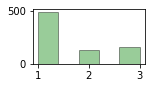

Track generation: 1159..1462 -> 303-tiles track
Episodi 2: recompensa = 330.4636


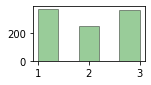

Track generation: 1116..1399 -> 283-tiles track
Episodi 3: recompensa = 351.8532


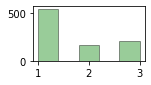

Track generation: 1147..1438 -> 291-tiles track
Episodi 4: recompensa = 644.8276


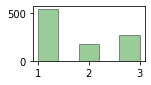

Track generation: 1207..1513 -> 306-tiles track
Episodi 5: recompensa = 411.4754


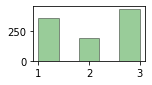

Track generation: 1033..1306 -> 273-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1104..1389 -> 285-tiles track
Episodi 6: recompensa = 435.2113


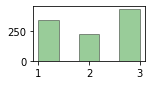

Track generation: 1330..1667 -> 337-tiles track
Episodi 7: recompensa = 298.8095


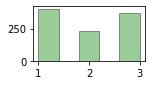

Track generation: 1023..1283 -> 260-tiles track
Episodi 8: recompensa = 695.3668


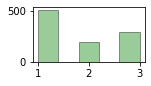

Track generation: 1189..1490 -> 301-tiles track
Episodi 9: recompensa = 208.4333


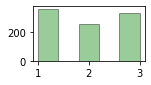

AvaluaAgent() Acabat


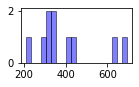


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_41
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1248..1564 -> 316-tiles track
Episodi 0: recompensa = -93.6508


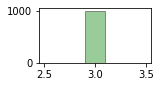

Track generation: 962..1210 -> 248-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1227..1538 -> 311-tiles track
Episodi 1: recompensa = -93.5484


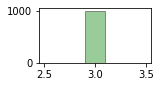

Track generation: 1147..1439 -> 292-tiles track
Episodi 2: recompensa = -93.1271


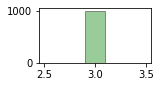

Track generation: 1152..1444 -> 292-tiles track
Episodi 3: recompensa = -93.1271


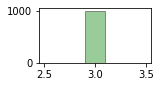

Track generation: 1104..1384 -> 280-tiles track
Episodi 4: recompensa = -92.8315


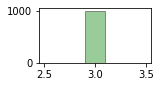

Track generation: 1097..1382 -> 285-tiles track
Episodi 5: recompensa = -92.9577


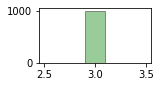

Track generation: 1157..1451 -> 294-tiles track
Episodi 6: recompensa = -93.1741


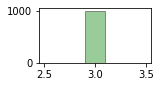

Track generation: 1435..1797 -> 362-tiles track
Episodi 7: recompensa = -94.4598


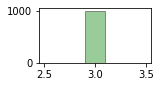

Track generation: 1270..1591 -> 321-tiles track
Episodi 8: recompensa = -93.75


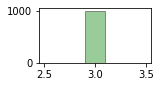

Track generation: 1171..1468 -> 297-tiles track
Episodi 9: recompensa = -93.2432


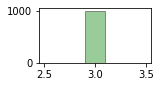

AvaluaAgent() Acabat


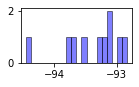


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_42
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1204..1510 -> 306-tiles track
Episodi 0: recompensa = 11.4754


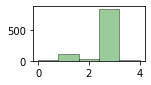

Track generation: 987..1241 -> 254-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1089..1365 -> 276-tiles track
Episodi 1: recompensa = 70.9091


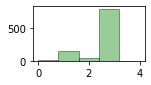

Track generation: 1211..1518 -> 307-tiles track
Episodi 2: recompensa = 14.3791


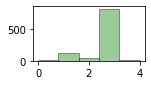

Track generation: 1240..1554 -> 314-tiles track
Episodi 3: recompensa = 40.5751


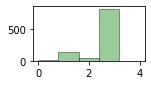

Track generation: 1076..1357 -> 281-tiles track
Episodi 4: recompensa = 121.4286


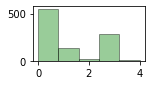

Track generation: 1160..1454 -> 294-tiles track
Episodi 5: recompensa = 29.6928


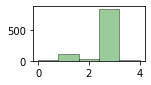

Track generation: 1229..1541 -> 312-tiles track
Episodi 6: recompensa = 18.9711


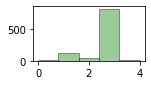

Track generation: 1012..1273 -> 261-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1207..1517 -> 310-tiles track
Episodi 7: recompensa = 110.356


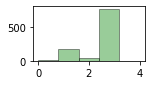

Track generation: 1077..1347 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1191..1492 -> 301-tiles track
Episodi 8: recompensa = 16.6667


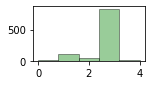

Track generation: 1081..1355 -> 274-tiles track
Episodi 9: recompensa = 416.4835


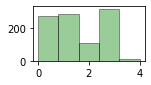

AvaluaAgent() Acabat


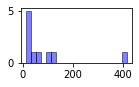


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_43
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1151..1452 -> 301-tiles track
Episodi 0: recompensa = -93.3333


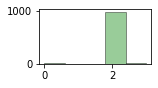

Track generation: 1166..1461 -> 295-tiles track
Episodi 1: recompensa = -93.1973


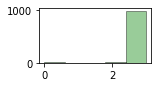

Track generation: 1124..1412 -> 288-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1106..1387 -> 281-tiles track
Episodi 2: recompensa = -92.8571


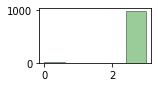

Track generation: 1076..1359 -> 283-tiles track
Episodi 3: recompensa = -92.9078


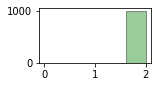

Track generation: 1132..1419 -> 287-tiles track
Episodi 4: recompensa = -93.007


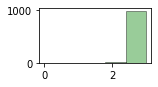

Track generation: 1158..1451 -> 293-tiles track
Episodi 5: recompensa = -93.1507


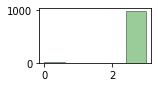

Track generation: 1320..1654 -> 334-tiles track
Episodi 6: recompensa = -93.994


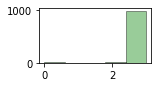

Track generation: 1268..1589 -> 321-tiles track
Episodi 7: recompensa = -93.75


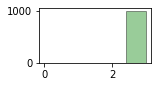

Track generation: 1156..1449 -> 293-tiles track
Episodi 8: recompensa = -93.1507


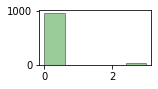

Track generation: 1365..1710 -> 345-tiles track
Episodi 9: recompensa = -94.186


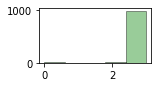

AvaluaAgent() Acabat


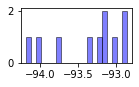


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_44
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1396..1749 -> 353-tiles track
Episodi 0: recompensa = 5.1136


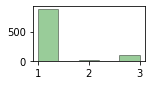

Track generation: 1162..1457 -> 295-tiles track
Episodi 1: recompensa = 29.2517


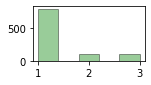

Track generation: 1184..1484 -> 300-tiles track
Episodi 2: recompensa = 17.0569


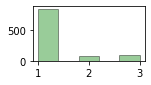

Track generation: 1078..1355 -> 277-tiles track
Episodi 3: recompensa = 44.9275


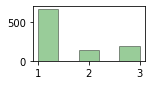

Track generation: 1080..1359 -> 279-tiles track
Episodi 4: recompensa = 83.4532


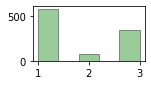

Track generation: 1164..1459 -> 295-tiles track
Episodi 5: recompensa = 19.0476


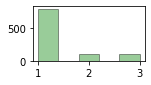

Track generation: 1188..1489 -> 301-tiles track
Episodi 6: recompensa = 46.6667


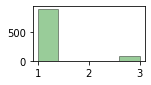

Track generation: 1154..1454 -> 300-tiles track
Episodi 7: recompensa = 174.2475


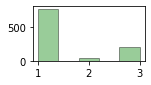

Track generation: 996..1253 -> 257-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1135..1423 -> 288-tiles track
Episodi 8: recompensa = 63.7631


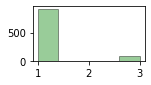

Track generation: 1079..1353 -> 274-tiles track
Episodi 9: recompensa = 39.1941


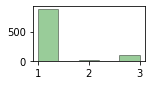

AvaluaAgent() Acabat


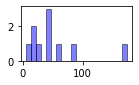


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_45
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1123..1408 -> 285-tiles track
Episodi 0: recompensa = 283.8028


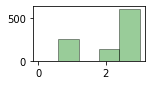

Track generation: 1203..1508 -> 305-tiles track
Episodi 1: recompensa = 452.6316


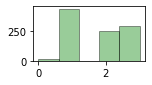

Track generation: 1012..1269 -> 257-tiles track
Episodi 2: recompensa = 790.625


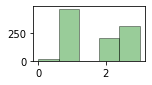

Track generation: 1055..1323 -> 268-tiles track
Episodi 3: recompensa = 461.7978


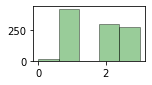

Track generation: 1167..1463 -> 296-tiles track
Episodi 4: recompensa = 588.1356


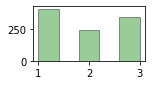

Track generation: 1125..1410 -> 285-tiles track
Episodi 5: recompensa = 607.7465


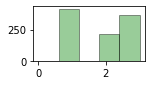

Track generation: 1011..1275 -> 264-tiles track
Episodi 6: recompensa = 531.238


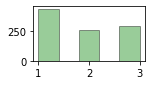

Track generation: 1260..1579 -> 319-tiles track
Episodi 7: recompensa = 525.7862


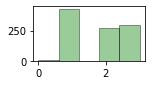

Track generation: 1248..1565 -> 317-tiles track
Episodi 8: recompensa = 551.8987


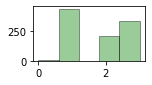

Track generation: 1259..1578 -> 319-tiles track
Episodi 9: recompensa = 315.0943


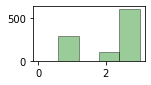

AvaluaAgent() Acabat


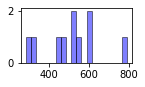


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_46
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1173..1470 -> 297-tiles track
Episodi 0: recompensa = -93.2432


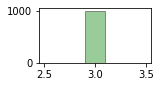

Track generation: 1183..1483 -> 300-tiles track
Episodi 1: recompensa = -93.311


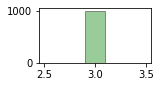

Track generation: 1033..1295 -> 262-tiles track
Episodi 2: recompensa = 95.4023


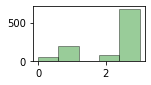

Track generation: 1120..1404 -> 284-tiles track
Episodi 3: recompensa = 228.6219


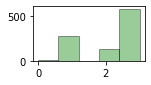

Track generation: 1136..1424 -> 288-tiles track
Episodi 4: recompensa = -93.0314


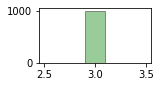

Track generation: 1169..1465 -> 296-tiles track
Episodi 5: recompensa = 283.0508


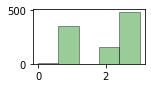

Track generation: 1188..1489 -> 301-tiles track
Episodi 6: recompensa = -93.3333


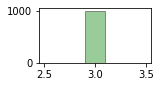

Track generation: 1097..1375 -> 278-tiles track
Episodi 7: recompensa = 177.9783


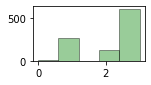

Track generation: 1191..1493 -> 302-tiles track
Episodi 8: recompensa = 192.3588


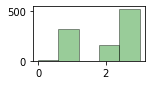

Track generation: 1183..1483 -> 300-tiles track
Episodi 9: recompensa = 190.9699


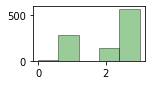

AvaluaAgent() Acabat


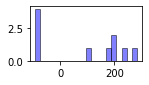


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_47
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1087..1364 -> 277-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1015..1273 -> 258-tiles track
Episodi 0: recompensa = -92.2179


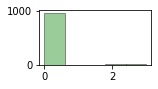

Track generation: 1152..1444 -> 292-tiles track
Episodi 1: recompensa = -93.1271


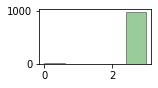

Track generation: 1224..1534 -> 310-tiles track
Episodi 2: recompensa = -93.5275


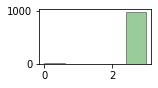

Track generation: 1127..1413 -> 286-tiles track
Episodi 3: recompensa = -92.9825


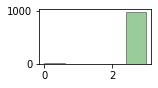

Track generation: 1203..1508 -> 305-tiles track
Episodi 4: recompensa = -93.4211


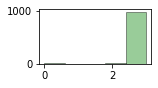

Track generation: 1224..1534 -> 310-tiles track
Episodi 5: recompensa = -93.5275


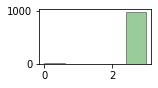

Track generation: 1108..1389 -> 281-tiles track
Episodi 6: recompensa = -92.8571


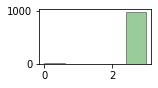

Track generation: 1087..1360 -> 273-tiles track
Episodi 7: recompensa = -92.6471


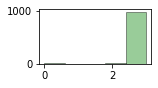

Track generation: 1333..1670 -> 337-tiles track
Episodi 8: recompensa = -94.0476


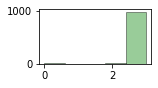

Track generation: 1130..1423 -> 293-tiles track
Episodi 9: recompensa = -93.1507


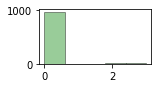

AvaluaAgent() Acabat


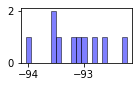


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_48
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1244..1569 -> 325-tiles track
Episodi 0: recompensa = 29.6296


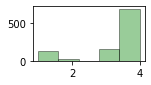

Track generation: 1181..1490 -> 309-tiles track
Episodi 1: recompensa = 98.0519


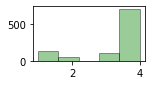

Track generation: 1075..1348 -> 273-tiles track
Episodi 2: recompensa = 569.1176


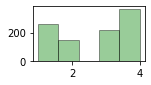

Track generation: 1043..1308 -> 265-tiles track
Episodi 3: recompensa = 426.5152


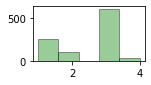

Track generation: 1134..1422 -> 288-tiles track
Episodi 4: recompensa = -93.0314


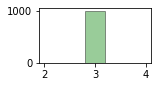

Track generation: 919..1154 -> 235-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1079..1353 -> 274-tiles track
Episodi 5: recompensa = 321.2454


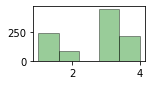

Track generation: 1176..1474 -> 298-tiles track
Episodi 6: recompensa = 647.4747


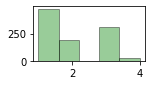

Track generation: 1039..1303 -> 264-tiles track
Episodi 7: recompensa = 740.3042


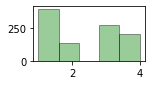

Track generation: 1255..1573 -> 318-tiles track
Episodi 8: recompensa = 351.1041


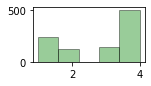

Track generation: 1215..1523 -> 308-tiles track
Episodi 9: recompensa = -93.4853


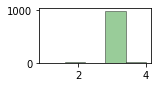

AvaluaAgent() Acabat


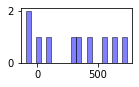


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_49
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1054..1329 -> 275-tiles track
Episodi 0: recompensa = -92.7007


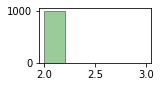

Track generation: 1252..1569 -> 317-tiles track
Episodi 1: recompensa = -93.6709


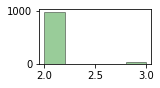

Track generation: 1108..1389 -> 281-tiles track
Episodi 2: recompensa = -92.8571


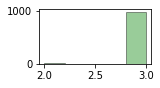

Track generation: 1215..1523 -> 308-tiles track
Episodi 3: recompensa = -93.4853


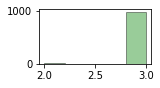

Track generation: 1214..1521 -> 307-tiles track
Episodi 4: recompensa = -93.4641


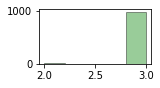

Track generation: 1120..1404 -> 284-tiles track
Episodi 5: recompensa = -92.9329


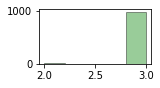

Track generation: 1180..1487 -> 307-tiles track
Episodi 6: recompensa = -93.4641


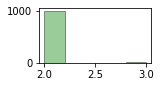

Track generation: 1009..1271 -> 262-tiles track
Episodi 7: recompensa = -92.3372


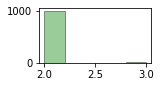

Track generation: 1251..1573 -> 322-tiles track
Episodi 8: recompensa = -93.7695


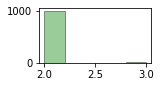

Track generation: 1176..1474 -> 298-tiles track
Episodi 9: recompensa = -93.266


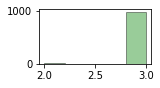

AvaluaAgent() Acabat


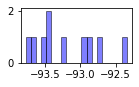


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_50
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1133..1427 -> 294-tiles track
Episodi 0: recompensa = -93.1741


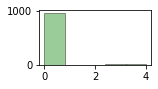

Track generation: 1058..1326 -> 268-tiles track
Episodi 1: recompensa = -92.5094


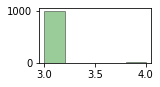

Track generation: 1124..1411 -> 287-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1145..1437 -> 292-tiles track
Episodi 2: recompensa = -93.1271


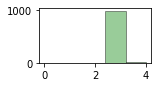

Track generation: 1115..1398 -> 283-tiles track
Episodi 3: recompensa = -92.9078


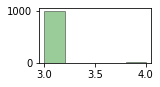

Track generation: 1169..1468 -> 299-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1099..1378 -> 279-tiles track
Episodi 4: recompensa = -92.8058


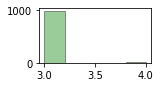

Track generation: 1043..1316 -> 273-tiles track
Episodi 5: recompensa = -92.6471


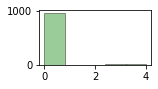

Track generation: 1282..1606 -> 324-tiles track
Episodi 6: recompensa = -93.808


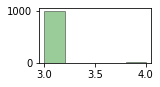

Track generation: 1136..1424 -> 288-tiles track
Episodi 7: recompensa = -93.0314


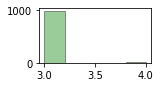

Track generation: 1129..1415 -> 286-tiles track
Episodi 8: recompensa = -92.9825


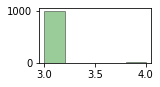

Track generation: 1064..1334 -> 270-tiles track
Episodi 9: recompensa = -92.5651


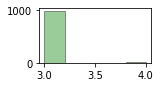

AvaluaAgent() Acabat


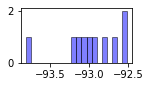


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_51
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1040..1304 -> 264-tiles track
Episodi 0: recompensa = -92.3954


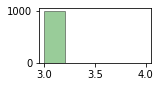

Track generation: 1080..1354 -> 274-tiles track
Episodi 1: recompensa = -92.674


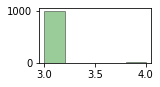

Track generation: 1193..1496 -> 303-tiles track
Episodi 2: recompensa = -93.3775


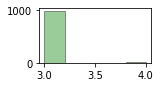

Track generation: 1043..1308 -> 265-tiles track
Episodi 3: recompensa = -92.4242


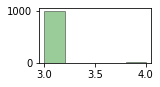

Track generation: 1119..1412 -> 293-tiles track
Episodi 4: recompensa = -93.1507


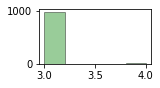

Track generation: 1050..1317 -> 267-tiles track
Episodi 5: recompensa = -92.4812


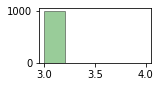

Track generation: 1099..1377 -> 278-tiles track
Episodi 6: recompensa = -92.7798


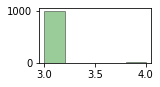

Track generation: 1083..1358 -> 275-tiles track
Episodi 7: recompensa = -92.7007


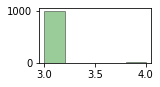

Track generation: 1219..1528 -> 309-tiles track
Episodi 8: recompensa = -93.5065


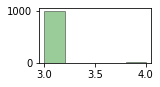

Track generation: 1210..1519 -> 309-tiles track
Episodi 9: recompensa = -93.5065


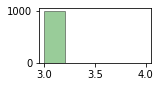

AvaluaAgent() Acabat


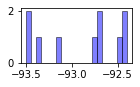


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_52
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1009..1297 -> 288-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1152..1444 -> 292-tiles track
Episodi 0: recompensa = -93.1271


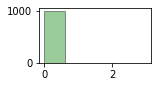

Track generation: 1209..1523 -> 314-tiles track
Episodi 1: recompensa = -93.6102


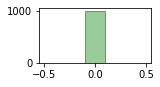

Track generation: 1024..1284 -> 260-tiles track
Episodi 2: recompensa = -92.278


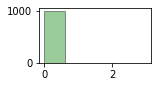

Track generation: 1048..1314 -> 266-tiles track
Episodi 3: recompensa = -92.4528


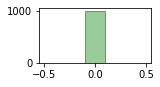

Track generation: 1141..1430 -> 289-tiles track
Episodi 4: recompensa = -93.0556


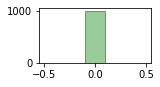

Track generation: 1092..1375 -> 283-tiles track
Episodi 5: recompensa = -92.9078


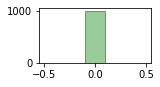

Track generation: 1196..1499 -> 303-tiles track
Episodi 6: recompensa = -93.3775


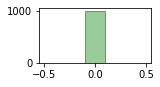

Track generation: 1084..1365 -> 281-tiles track
Episodi 7: recompensa = -92.8571


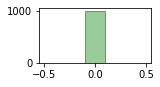

Track generation: 1168..1468 -> 300-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1154..1454 -> 300-tiles track
Episodi 8: recompensa = -93.311


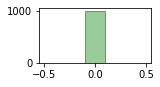

Track generation: 1190..1499 -> 309-tiles track
Episodi 9: recompensa = -93.5065


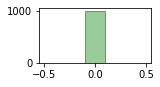

AvaluaAgent() Acabat


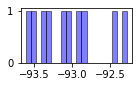


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_53
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1129..1415 -> 286-tiles track
Episodi 0: recompensa = -92.9825


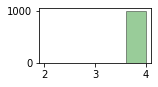

Track generation: 1192..1497 -> 305-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1160..1454 -> 294-tiles track
Episodi 1: recompensa = -93.1741


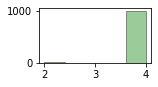

Track generation: 1231..1543 -> 312-tiles track
Episodi 2: recompensa = -93.5691


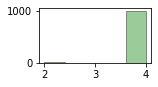

Track generation: 1315..1648 -> 333-tiles track
Episodi 3: recompensa = -93.9759


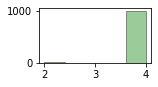

Track generation: 1256..1583 -> 327-tiles track
Episodi 4: recompensa = -93.865


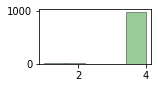

Track generation: 1096..1383 -> 287-tiles track
Episodi 5: recompensa = -93.007


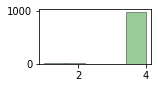

Track generation: 1007..1263 -> 256-tiles track
Episodi 6: recompensa = -92.1569


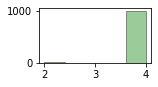

Track generation: 979..1228 -> 249-tiles track
Episodi 7: recompensa = -91.9355


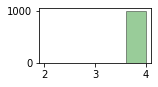

Track generation: 1164..1459 -> 295-tiles track
Episodi 8: recompensa = -93.1973


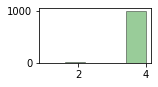

Track generation: 1131..1418 -> 287-tiles track
Episodi 9: recompensa = -93.007


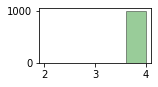

AvaluaAgent() Acabat


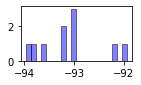


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_54
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1078..1357 -> 279-tiles track
Episodi 0: recompensa = 716.5468


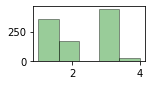

Track generation: 1308..1639 -> 331-tiles track
Episodi 1: recompensa = -93.9394


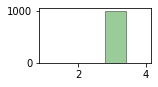

Track generation: 1194..1496 -> 302-tiles track
Episodi 2: recompensa = 192.3588


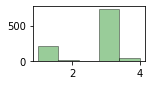

Track generation: 1192..1494 -> 302-tiles track
Episodi 3: recompensa = 248.8372


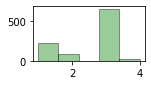

Track generation: 1150..1441 -> 291-tiles track
Episodi 4: recompensa = 324.1379


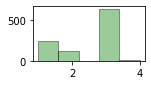

Track generation: 1130..1426 -> 296-tiles track
Episodi 5: recompensa = 52.5424


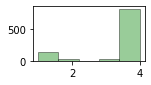

Track generation: 1082..1360 -> 278-tiles track
Episodi 6: recompensa = 40.7942


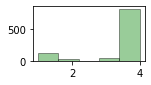

Track generation: 1000..1263 -> 263-tiles track
Episodi 7: recompensa = 140.458


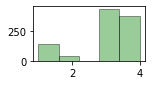

Track generation: 1185..1486 -> 301-tiles track
Episodi 8: recompensa = 310.0


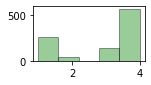

Track generation: 1176..1474 -> 298-tiles track
Episodi 9: recompensa = 317.5084


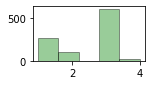

AvaluaAgent() Acabat


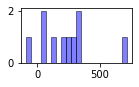


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_55
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1199..1503 -> 304-tiles track
Episodi 0: recompensa = 414.8515


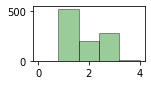

Track generation: 1279..1603 -> 324-tiles track
Episodi 1: recompensa = 454.1796


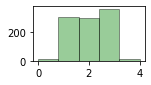

Track generation: 1285..1610 -> 325-tiles track
Episodi 2: recompensa = 143.8272


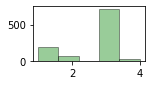

Track generation: 1378..1727 -> 349-tiles track
Episodi 3: recompensa = 138.5057


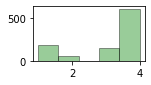

Track generation: 1204..1509 -> 305-tiles track
Episodi 4: recompensa = 505.2632


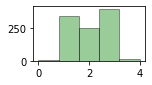

Track generation: 1060..1329 -> 269-tiles track
Episodi 5: recompensa = 802.9851


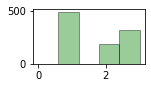

Track generation: 1158..1451 -> 293-tiles track
Episodi 6: recompensa = 266.4384


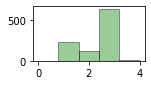

Track generation: 1256..1574 -> 318-tiles track
Episodi 7: recompensa = 168.1388


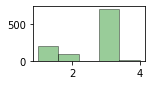

Track generation: 1215..1523 -> 308-tiles track
Episodi 8: recompensa = 215.9609


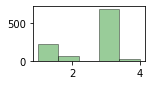

Track generation: 1087..1363 -> 276-tiles track
Episodi 9: recompensa = 485.4545


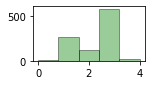

AvaluaAgent() Acabat


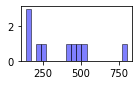


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_56
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1098..1376 -> 278-tiles track
Episodi 0: recompensa = -92.7798


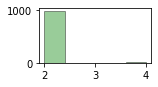

Track generation: 1116..1399 -> 283-tiles track
Episodi 1: recompensa = -92.9078


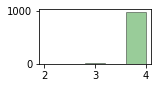

Track generation: 1115..1398 -> 283-tiles track
Episodi 2: recompensa = -92.9078


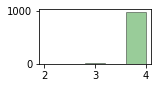

Track generation: 1013..1275 -> 262-tiles track
Episodi 3: recompensa = -92.3372


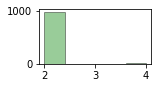

Track generation: 1314..1647 -> 333-tiles track
Episodi 4: recompensa = -93.9759


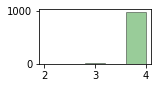

Track generation: 1195..1499 -> 304-tiles track
Episodi 5: recompensa = -93.3993


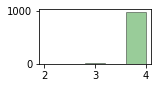

Track generation: 1038..1307 -> 269-tiles track
Episodi 6: recompensa = -92.5373


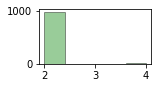

Track generation: 1191..1496 -> 305-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1268..1589 -> 321-tiles track
Episodi 7: recompensa = -93.75


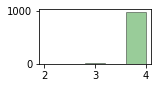

Track generation: 1133..1420 -> 287-tiles track
Episodi 8: recompensa = -93.007


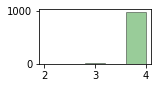

Track generation: 1223..1533 -> 310-tiles track
Episodi 9: recompensa = -93.5275


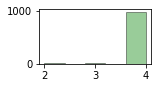

AvaluaAgent() Acabat


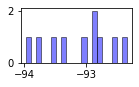


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_57
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1284..1610 -> 326-tiles track
Episodi 0: recompensa = 229.2308


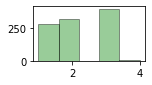

Track generation: 1105..1388 -> 283-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1087..1363 -> 276-tiles track
Episodi 1: recompensa = 354.5455


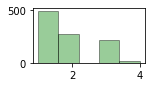

Track generation: 1224..1534 -> 310-tiles track
Episodi 2: recompensa = 531.068


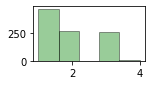

Track generation: 1128..1420 -> 292-tiles track
Episodi 3: recompensa = 645.7045


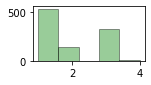

Track generation: 1043..1308 -> 265-tiles track
Episodi 4: recompensa = 650.0


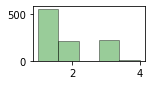

Track generation: 1031..1293 -> 262-tiles track
Episodi 5: recompensa = 532.1839


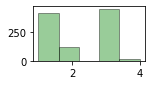

Track generation: 1247..1563 -> 316-tiles track
Episodi 6: recompensa = 322.2222


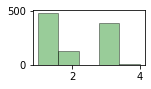

Track generation: 1209..1515 -> 306-tiles track
Episodi 7: recompensa = 519.6721


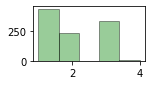

Track generation: 1227..1538 -> 311-tiles track
Episodi 8: recompensa = 200.0


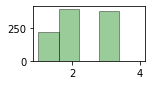

Track generation: 1194..1496 -> 302-tiles track
Episodi 9: recompensa = 248.8372


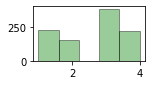

AvaluaAgent() Acabat


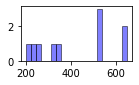


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_58
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1262..1592 -> 330-tiles track
Episodi 0: recompensa = -93.921


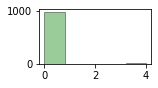

Track generation: 1213..1529 -> 316-tiles track
Episodi 1: recompensa = -93.6508


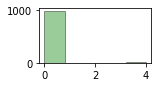

Track generation: 1282..1607 -> 325-tiles track
Episodi 2: recompensa = -93.8272


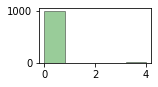

Track generation: 1243..1558 -> 315-tiles track
Episodi 3: recompensa = -93.6306


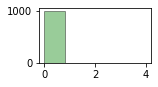

Track generation: 1048..1314 -> 266-tiles track
Episodi 4: recompensa = -92.4528


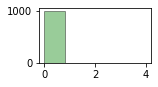

Track generation: 1240..1554 -> 314-tiles track
Episodi 5: recompensa = -93.6102


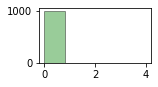

Track generation: 1218..1527 -> 309-tiles track
Episodi 6: recompensa = -93.5065


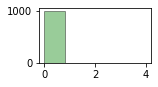

Track generation: 1183..1483 -> 300-tiles track
Episodi 7: recompensa = -93.311


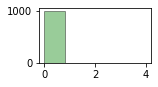

Track generation: 1261..1580 -> 319-tiles track
Episodi 8: recompensa = -93.7107


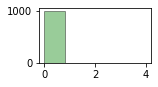

Track generation: 1186..1487 -> 301-tiles track
Episodi 9: recompensa = -93.3333


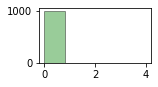

AvaluaAgent() Acabat


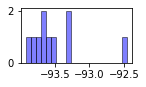


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_59
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1003..1265 -> 262-tiles track
Episodi 0: recompensa = -92.3372


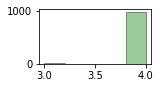

Track generation: 1147..1438 -> 291-tiles track
Episodi 1: recompensa = -93.1034


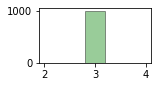

Track generation: 1197..1500 -> 303-tiles track
Episodi 2: recompensa = -93.3775


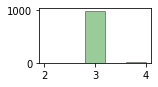

Track generation: 1093..1370 -> 277-tiles track
Episodi 3: recompensa = -92.7536


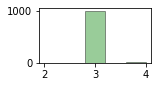

Track generation: 1225..1536 -> 311-tiles track
Episodi 4: recompensa = -93.5484


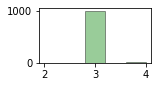

Track generation: 1055..1325 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1268..1595 -> 327-tiles track
Episodi 5: recompensa = -93.865


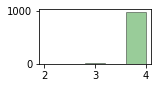

Track generation: 1216..1524 -> 308-tiles track
Episodi 6: recompensa = -93.4853


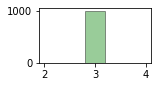

Track generation: 1068..1339 -> 271-tiles track
Episodi 7: recompensa = -92.5926


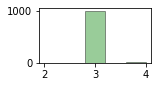

Track generation: 1231..1549 -> 318-tiles track
Episodi 8: recompensa = -93.6909


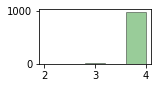

Track generation: 1092..1376 -> 284-tiles track
Episodi 9: recompensa = -92.9329


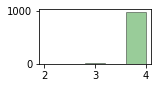

AvaluaAgent() Acabat


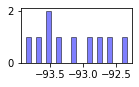


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_60
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1037..1306 -> 269-tiles track
Episodi 0: recompensa = 220.8955


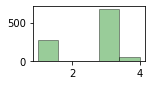

Track generation: 1085..1362 -> 277-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1140..1429 -> 289-tiles track
Episodi 1: recompensa = -9.7222


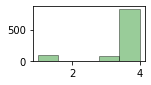

Track generation: 1089..1365 -> 276-tiles track
Episodi 2: recompensa = -27.2727


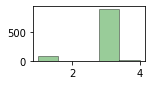

Track generation: 1180..1481 -> 301-tiles track
Episodi 3: recompensa = -10.0


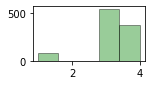

Track generation: 1120..1404 -> 284-tiles track
Episodi 4: recompensa = -15.1943


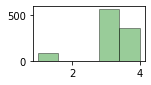

Track generation: 1168..1464 -> 296-tiles track
Episodi 5: recompensa = -18.6441


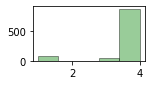

Track generation: 1123..1408 -> 285-tiles track
Episodi 6: recompensa = -26.0563


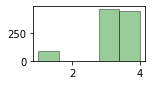

Track generation: 1148..1439 -> 291-tiles track
Episodi 7: recompensa = -17.2414


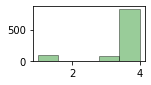

Track generation: 1216..1524 -> 308-tiles track
Episodi 8: recompensa = -31.5961


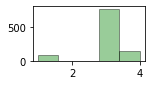

Track generation: 1123..1410 -> 287-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1122..1414 -> 292-tiles track
Episodi 9: recompensa = -55.3265


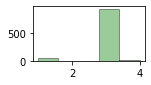

AvaluaAgent() Acabat


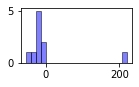


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_61
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1165..1460 -> 295-tiles track
Episodi 0: recompensa = -93.1973


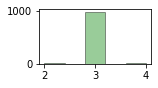

Track generation: 1180..1479 -> 299-tiles track
Episodi 1: recompensa = -93.2886


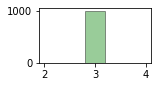

Track generation: 1145..1442 -> 297-tiles track
Episodi 2: recompensa = -93.2432


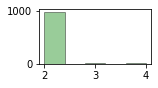

Track generation: 1207..1513 -> 306-tiles track
Episodi 3: recompensa = -93.4426


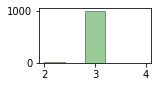

Track generation: 1108..1397 -> 289-tiles track
Episodi 4: recompensa = -93.0556


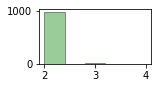

Track generation: 1204..1509 -> 305-tiles track
Episodi 5: recompensa = -93.4211


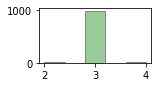

Track generation: 1107..1388 -> 281-tiles track
Episodi 6: recompensa = -92.8571


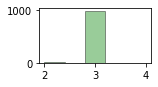

Track generation: 1049..1320 -> 271-tiles track
Episodi 7: recompensa = -92.5926


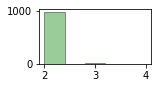

Track generation: 1152..1444 -> 292-tiles track
Episodi 8: recompensa = -93.1271


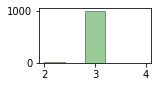

Track generation: 1243..1557 -> 314-tiles track
Episodi 9: recompensa = -93.6102


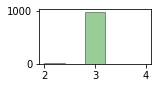

AvaluaAgent() Acabat


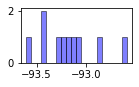


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_62
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1264..1584 -> 320-tiles track
Episodi 0: recompensa = -93.7304


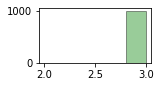

Track generation: 1164..1459 -> 295-tiles track
Episodi 1: recompensa = -93.1973


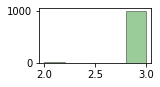

Track generation: 1140..1429 -> 289-tiles track
Episodi 2: recompensa = -93.0556


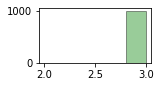

Track generation: 1301..1630 -> 329-tiles track
Episodi 3: recompensa = -93.9024


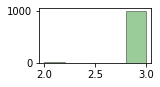

Track generation: 1104..1391 -> 287-tiles track
Episodi 4: recompensa = -93.007


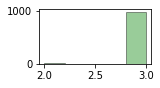

Track generation: 1267..1587 -> 320-tiles track
Episodi 5: recompensa = -93.7304


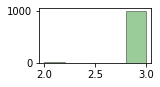

Track generation: 1456..1825 -> 369-tiles track
Episodi 6: recompensa = -94.5652


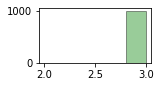

Track generation: 1142..1429 -> 287-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1128..1415 -> 287-tiles track
Episodi 7: recompensa = -93.007


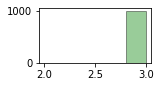

Track generation: 1283..1608 -> 325-tiles track
Episodi 8: recompensa = -93.8272


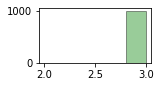

Track generation: 1106..1394 -> 288-tiles track
Episodi 9: recompensa = -93.0314


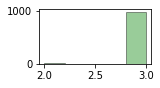

AvaluaAgent() Acabat


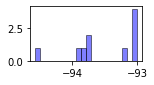


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_63
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1390..1742 -> 352-tiles track
Episodi 0: recompensa = -94.302


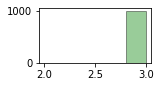

Track generation: 1020..1279 -> 259-tiles track
Episodi 1: recompensa = -92.2481


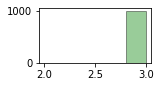

Track generation: 1055..1324 -> 269-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1213..1520 -> 307-tiles track
Episodi 2: recompensa = -93.4641


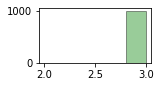

Track generation: 1267..1587 -> 320-tiles track
Episodi 3: recompensa = -93.7304


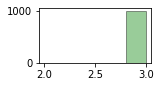

Track generation: 1244..1559 -> 315-tiles track
Episodi 4: recompensa = -93.6306


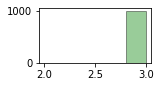

Track generation: 1119..1403 -> 284-tiles track
Episodi 5: recompensa = -92.9329


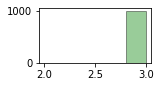

Track generation: 1089..1365 -> 276-tiles track
Episodi 6: recompensa = -92.7273


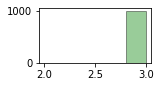

Track generation: 1019..1278 -> 259-tiles track
Episodi 7: recompensa = -92.2481


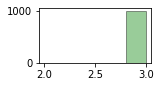

Track generation: 1183..1483 -> 300-tiles track
Episodi 8: recompensa = -93.311


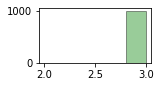

Track generation: 1338..1677 -> 339-tiles track
Episodi 9: recompensa = -94.0828


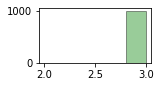

AvaluaAgent() Acabat


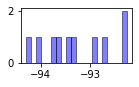


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_64
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1198..1501 -> 303-tiles track
Episodi 0: recompensa = -93.3775


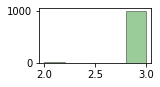

Track generation: 1176..1474 -> 298-tiles track
Episodi 1: recompensa = -93.266


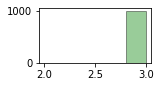

Track generation: 1154..1453 -> 299-tiles track
Episodi 2: recompensa = -93.2886


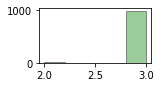

Track generation: 1215..1523 -> 308-tiles track
Episodi 3: recompensa = -93.4853


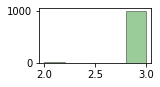

Track generation: 1181..1481 -> 300-tiles track
Episodi 4: recompensa = -93.311


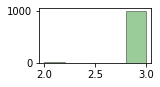

Track generation: 1247..1572 -> 325-tiles track
Episodi 5: recompensa = -93.8272


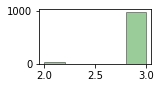

Track generation: 1105..1385 -> 280-tiles track
Episodi 6: recompensa = -92.8315


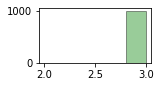

Track generation: 1193..1495 -> 302-tiles track
Episodi 7: recompensa = -93.3555


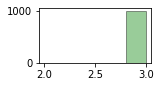

Track generation: 1079..1353 -> 274-tiles track
Episodi 8: recompensa = -92.674


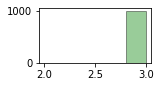

Track generation: 1219..1528 -> 309-tiles track
Episodi 9: recompensa = -93.5065


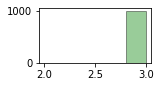

AvaluaAgent() Acabat


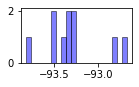


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_65
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1183..1483 -> 300-tiles track
Episodi 0: recompensa = -89.9666


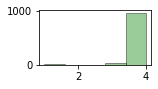

Track generation: 1015..1279 -> 264-tiles track
Episodi 1: recompensa = 55.8935


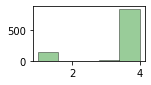

Track generation: 1178..1483 -> 305-tiles track
Episodi 2: recompensa = -7.8947


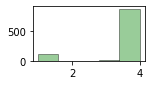

Track generation: 1161..1455 -> 294-tiles track
Episodi 3: recompensa = -93.1741


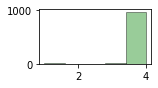

Track generation: 1060..1329 -> 269-tiles track
Episodi 4: recompensa = -92.5373


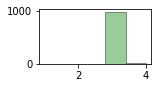

Track generation: 1196..1499 -> 303-tiles track
Episodi 5: recompensa = -93.3775


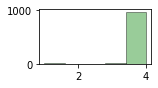

Track generation: 1269..1590 -> 321-tiles track
Episodi 6: recompensa = -93.75


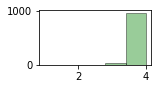

Track generation: 1007..1269 -> 262-tiles track
Episodi 7: recompensa = -11.8774


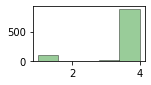

Track generation: 1105..1385 -> 280-tiles track
Episodi 8: recompensa = -92.8315


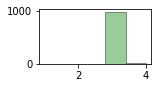

Track generation: 1109..1390 -> 281-tiles track
Episodi 9: recompensa = -89.2857


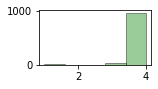

AvaluaAgent() Acabat


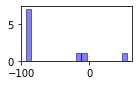


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_66
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1108..1390 -> 282-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1093..1371 -> 278-tiles track
Episodi 0: recompensa = 163.5379


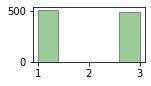

Track generation: 1270..1592 -> 322-tiles track
Episodi 1: recompensa = 55.7632


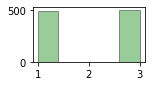

Track generation: 1114..1398 -> 284-tiles track
Episodi 2: recompensa = -92.9329


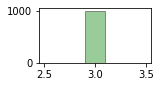

Track generation: 1116..1400 -> 284-tiles track
Episodi 3: recompensa = 133.2155


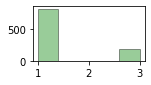

Track generation: 1132..1428 -> 296-tiles track
Episodi 4: recompensa = -18.6441


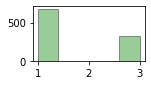

Track generation: 1312..1644 -> 332-tiles track
Episodi 5: recompensa = -93.9577


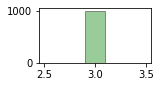

Track generation: 1123..1408 -> 285-tiles track
Episodi 6: recompensa = -92.9577


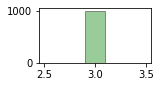

Track generation: 1277..1601 -> 324-tiles track
Episodi 7: recompensa = -93.808


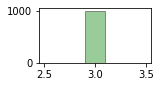

Track generation: 1406..1762 -> 356-tiles track
Episodi 8: recompensa = -94.3662


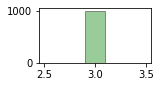

Track generation: 1016..1274 -> 258-tiles track
Episodi 9: recompensa = -92.2179


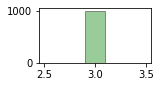

AvaluaAgent() Acabat


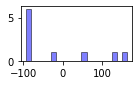


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_67
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1260..1579 -> 319-tiles track
Episodi 0: recompensa = 110.6918


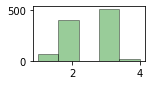

Track generation: 1172..1469 -> 297-tiles track
Episodi 1: recompensa = 52.027


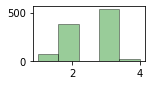

Track generation: 1215..1523 -> 308-tiles track
Episodi 2: recompensa = 27.0358


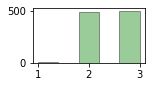

Track generation: 1088..1364 -> 276-tiles track
Episodi 3: recompensa = 45.4545


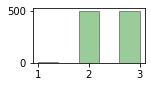

Track generation: 1049..1320 -> 271-tiles track
Episodi 4: recompensa = 70.3704


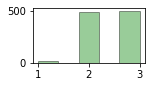

Track generation: 1257..1575 -> 318-tiles track
Episodi 5: recompensa = 16.7192


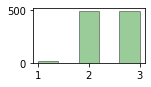

Track generation: 1156..1449 -> 293-tiles track
Episodi 6: recompensa = 71.2329


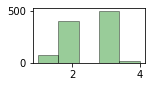

Track generation: 1105..1396 -> 291-tiles track
Episodi 7: recompensa = 55.1724


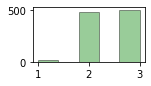

Track generation: 1200..1504 -> 304-tiles track
Episodi 8: recompensa = -70.297


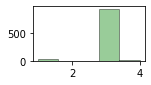

Track generation: 969..1222 -> 253-tiles track
Episodi 9: recompensa = 78.5714


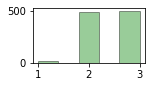

AvaluaAgent() Acabat


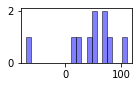


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_68
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1254..1572 -> 318-tiles track
Episodi 0: recompensa = -93.6909


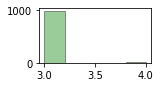

Track generation: 1089..1371 -> 282-tiles track
Episodi 1: recompensa = -92.8826


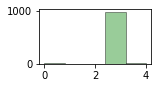

Track generation: 1109..1390 -> 281-tiles track
Episodi 2: recompensa = -92.8571


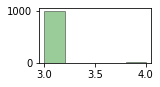

Track generation: 1109..1401 -> 292-tiles track
Episodi 3: recompensa = -93.1271


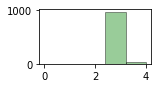

Track generation: 1034..1298 -> 264-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1156..1459 -> 303-tiles track
Episodi 4: recompensa = -93.3775


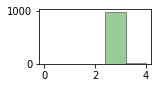

Track generation: 1027..1288 -> 261-tiles track
Episodi 5: recompensa = -92.3077


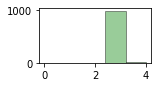

Track generation: 1383..1733 -> 350-tiles track
Episodi 6: recompensa = -94.2693


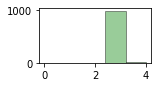

Track generation: 1147..1438 -> 291-tiles track
Episodi 7: recompensa = -93.1034


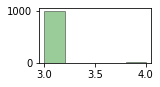

Track generation: 1216..1524 -> 308-tiles track
Episodi 8: recompensa = -93.4853


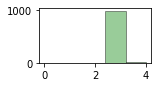

Track generation: 1083..1358 -> 275-tiles track
Episodi 9: recompensa = -92.7007


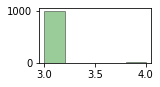

AvaluaAgent() Acabat


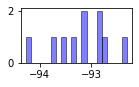


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_69
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1052..1319 -> 267-tiles track
Episodi 0: recompensa = 31.5789


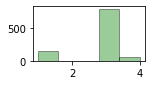

Track generation: 1295..1623 -> 328-tiles track
Episodi 1: recompensa = -11.315


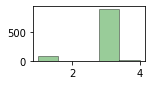

Track generation: 1133..1420 -> 287-tiles track
Episodi 2: recompensa = -9.0909


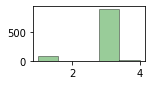

Track generation: 1380..1729 -> 349-tiles track
Episodi 3: recompensa = 17.8161


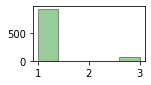

Track generation: 1188..1489 -> 301-tiles track
Episodi 4: recompensa = -6.6667


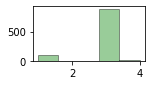

Track generation: 1024..1284 -> 260-tiles track
Episodi 5: recompensa = -7.3359


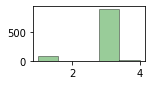

Track generation: 1152..1442 -> 290-tiles track
Episodi 6: recompensa = -3.1142


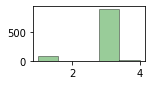

Track generation: 1355..1698 -> 343-tiles track
Episodi 7: recompensa = 66.6667


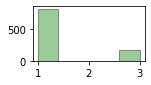

Track generation: 1164..1459 -> 295-tiles track
Episodi 8: recompensa = -4.7619


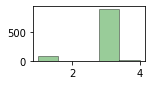

Track generation: 1191..1494 -> 303-tiles track
Episodi 9: recompensa = 181.457


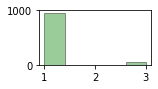

AvaluaAgent() Acabat


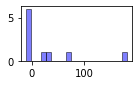


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_70
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1231..1543 -> 312-tiles track
Episodi 0: recompensa = 9.3248


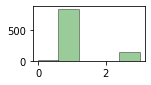

Track generation: 1198..1501 -> 303-tiles track
Episodi 1: recompensa = -30.4636


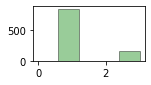

Track generation: 1339..1678 -> 339-tiles track
Episodi 2: recompensa = -31.9527


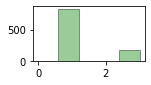

Track generation: 1215..1527 -> 312-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1343..1683 -> 340-tiles track
Episodi 3: recompensa = 100.59


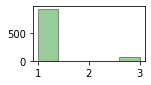

Track generation: 1151..1450 -> 299-tiles track
Episodi 4: recompensa = 111.4094


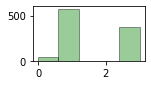

Track generation: 1243..1558 -> 315-tiles track
Episodi 5: recompensa = -33.121


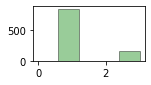

Track generation: 1204..1509 -> 305-tiles track
Episodi 6: recompensa = 57.8947


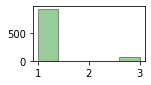

Track generation: 1124..1409 -> 285-tiles track
Episodi 7: recompensa = -19.0141


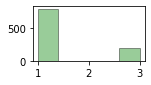

Track generation: 1274..1604 -> 330-tiles track
Episodi 8: recompensa = -30.0912


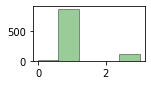

Track generation: 1220..1529 -> 309-tiles track
Episodi 9: recompensa = -22.0779


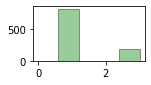

AvaluaAgent() Acabat


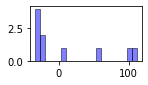


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_71
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1209..1515 -> 306-tiles track
Episodi 0: recompensa = 37.7049


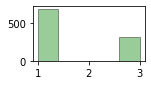

Track generation: 1257..1575 -> 318-tiles track
Episodi 1: recompensa = 92.429


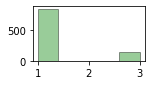

Track generation: 1089..1365 -> 276-tiles track
Episodi 2: recompensa = -41.8182


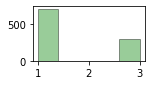

Track generation: 1292..1620 -> 328-tiles track
Episodi 3: recompensa = -57.1865


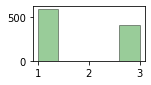

Track generation: 1134..1424 -> 290-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1116..1399 -> 283-tiles track
Episodi 4: recompensa = 9.9291


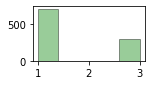

Track generation: 1369..1714 -> 345-tiles track
Episodi 5: recompensa = -76.7442


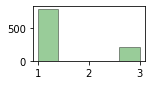

Track generation: 1232..1544 -> 312-tiles track
Episodi 6: recompensa = -35.6913


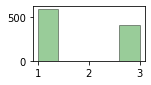

Track generation: 1152..1449 -> 297-tiles track
Episodi 7: recompensa = 75.6757


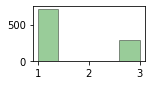

Track generation: 1257..1576 -> 319-tiles track
Episodi 8: recompensa = 3.7736


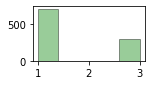

Track generation: 1161..1437 -> 276-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1110..1392 -> 282-tiles track
Episodi 9: recompensa = -67.9715


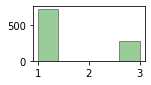

AvaluaAgent() Acabat


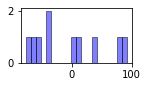


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_72
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1104..1394 -> 290-tiles track
Episodi 0: recompensa = -93.0796


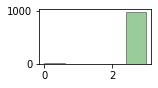

Track generation: 1172..1479 -> 307-tiles track
Episodi 1: recompensa = -93.4641


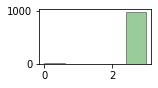

Track generation: 1216..1524 -> 308-tiles track
Episodi 2: recompensa = -93.4853


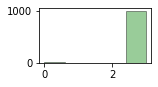

Track generation: 1185..1485 -> 300-tiles track
Episodi 3: recompensa = -93.311


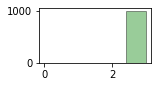

Track generation: 1131..1418 -> 287-tiles track
Episodi 4: recompensa = -93.007


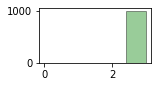

Track generation: 1189..1491 -> 302-tiles track
Episodi 5: recompensa = -93.3555


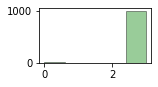

Track generation: 1143..1433 -> 290-tiles track
Episodi 6: recompensa = -93.0796


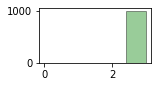

Track generation: 934..1178 -> 244-tiles track
Episodi 7: recompensa = -91.7695


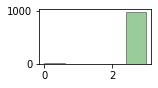

Track generation: 1037..1302 -> 265-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1119..1403 -> 284-tiles track
Episodi 8: recompensa = -92.9329


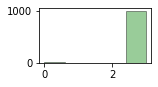

Track generation: 1259..1581 -> 322-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1092..1369 -> 277-tiles track
Episodi 9: recompensa = -92.7536


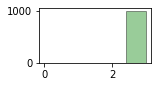

AvaluaAgent() Acabat


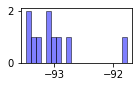


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_73
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1072..1344 -> 272-tiles track
Episodi 0: recompensa = -92.6199


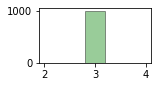

Track generation: 1292..1619 -> 327-tiles track
Episodi 1: recompensa = -93.865


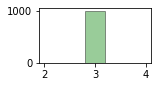

Track generation: 1032..1294 -> 262-tiles track
Episodi 2: recompensa = -92.3372


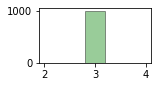

Track generation: 1051..1318 -> 267-tiles track
Episodi 3: recompensa = -92.4812


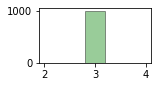

Track generation: 1103..1383 -> 280-tiles track
Episodi 4: recompensa = -92.8315


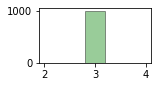

Track generation: 1224..1534 -> 310-tiles track
Episodi 5: recompensa = -93.5275


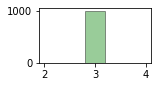

Track generation: 1000..1262 -> 262-tiles track
Episodi 6: recompensa = -92.3372


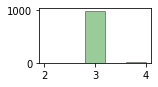

Track generation: 1152..1444 -> 292-tiles track
Episodi 7: recompensa = -93.1271


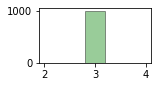

Track generation: 1233..1544 -> 311-tiles track
Episodi 8: recompensa = -93.5484


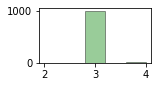

Track generation: 1033..1297 -> 264-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1179..1478 -> 299-tiles track
Episodi 9: recompensa = -93.2886


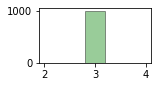

AvaluaAgent() Acabat


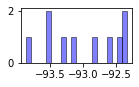


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_74
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1004..1266 -> 262-tiles track
Episodi 0: recompensa = -92.3372


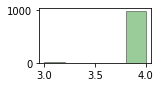

Track generation: 1234..1551 -> 317-tiles track
Episodi 1: recompensa = -93.6709


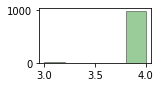

Track generation: 1213..1520 -> 307-tiles track
Episodi 2: recompensa = -93.4641


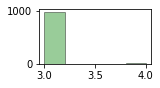

Track generation: 1097..1375 -> 278-tiles track
Episodi 3: recompensa = -92.7798


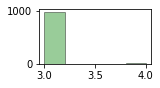

Track generation: 1049..1317 -> 268-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 932..1174 -> 242-tiles track
Episodi 4: recompensa = -91.7012


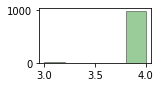

Track generation: 1172..1469 -> 297-tiles track
Episodi 5: recompensa = -93.2432


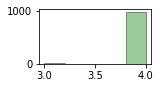

Track generation: 1184..1484 -> 300-tiles track
Episodi 6: recompensa = -93.311


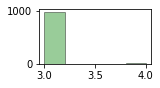

Track generation: 1203..1515 -> 312-tiles track
Episodi 7: recompensa = -93.5691


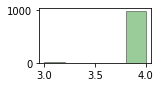

Track generation: 1152..1451 -> 299-tiles track
Episodi 8: recompensa = -93.2886


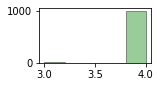

Track generation: 1080..1354 -> 274-tiles track
Episodi 9: recompensa = -92.674


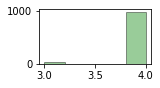

AvaluaAgent() Acabat


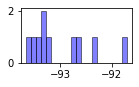


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_75
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1324..1659 -> 335-tiles track
Episodi 0: recompensa = -94.012


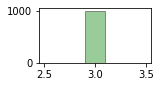

Track generation: 1294..1622 -> 328-tiles track
Episodi 1: recompensa = -93.8838


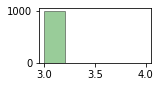

Track generation: 1087..1363 -> 276-tiles track
Episodi 2: recompensa = -92.7273


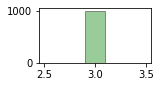

Track generation: 1124..1409 -> 285-tiles track
Episodi 3: recompensa = -92.9577


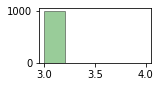

Track generation: 1071..1343 -> 272-tiles track
Episodi 4: recompensa = -92.6199


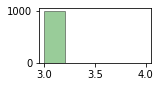

Track generation: 1039..1310 -> 271-tiles track
Episodi 5: recompensa = -92.5926


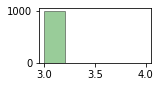

Track generation: 1276..1599 -> 323-tiles track
Episodi 6: recompensa = -93.7888


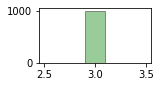

Track generation: 1161..1455 -> 294-tiles track
Episodi 7: recompensa = -93.1741


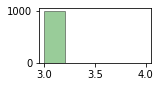

Track generation: 1262..1581 -> 319-tiles track
Episodi 8: recompensa = -93.7107


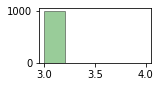

Track generation: 1180..1479 -> 299-tiles track
Episodi 9: recompensa = -93.2886


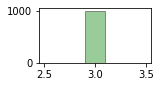

AvaluaAgent() Acabat


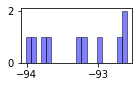


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_76
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1112..1396 -> 284-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1166..1460 -> 294-tiles track
Episodi 0: recompensa = -93.1741


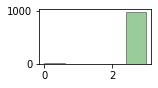

Track generation: 1407..1763 -> 356-tiles track
Episodi 1: recompensa = -94.3662


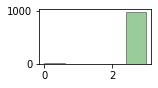

Track generation: 1385..1735 -> 350-tiles track
Episodi 2: recompensa = -94.2693


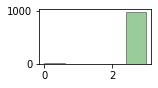

Track generation: 1108..1389 -> 281-tiles track
Episodi 3: recompensa = -92.8571


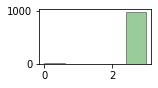

Track generation: 1094..1378 -> 284-tiles track
Episodi 4: recompensa = -92.9329


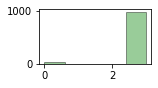

Track generation: 1103..1383 -> 280-tiles track
Episodi 5: recompensa = -92.8315


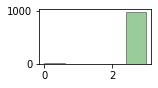

Track generation: 1323..1658 -> 335-tiles track
Episodi 6: recompensa = -94.012


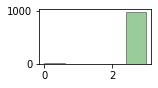

Track generation: 1100..1379 -> 279-tiles track
Episodi 7: recompensa = -92.8058


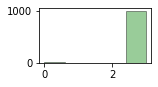

Track generation: 1177..1478 -> 301-tiles track
Episodi 8: recompensa = -93.3333


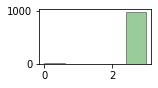

Track generation: 1100..1379 -> 279-tiles track
Episodi 9: recompensa = -92.8058


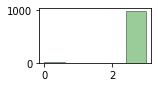

AvaluaAgent() Acabat


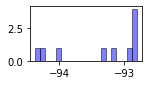


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_77
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1172..1477 -> 305-tiles track
Episodi 0: recompensa = 317.7632


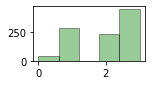

Track generation: 1088..1364 -> 276-tiles track
Episodi 1: recompensa = -92.7273


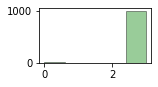

Track generation: 1114..1403 -> 289-tiles track
Episodi 2: recompensa = 434.7222


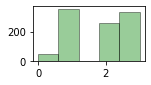

Track generation: 1003..1258 -> 255-tiles track
Episodi 3: recompensa = -92.126


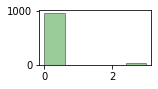

Track generation: 1121..1405 -> 284-tiles track
Episodi 4: recompensa = -92.9329


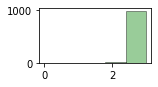

Track generation: 1101..1389 -> 288-tiles track
Episodi 5: recompensa = 624.7387


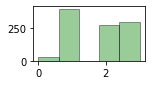

Track generation: 1091..1368 -> 277-tiles track
Episodi 6: recompensa = -92.7536


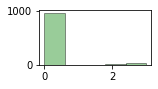

Track generation: 1131..1418 -> 287-tiles track
Episodi 7: recompensa = -93.007


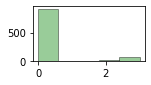

Track generation: 1179..1478 -> 299-tiles track
Episodi 8: recompensa = -93.2886


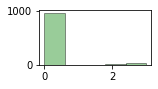

Track generation: 1179..1478 -> 299-tiles track
Episodi 9: recompensa = -93.2886


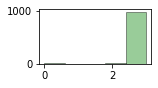

AvaluaAgent() Acabat


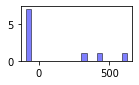


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_78
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1128..1414 -> 286-tiles track
Episodi 0: recompensa = -92.9825


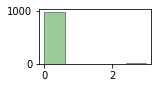

Track generation: 1236..1549 -> 313-tiles track
Episodi 1: recompensa = -93.5897


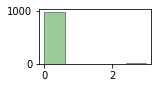

Track generation: 1163..1458 -> 295-tiles track
Episodi 2: recompensa = -93.1973


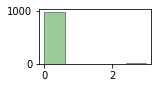

Track generation: 1174..1471 -> 297-tiles track
Episodi 3: recompensa = -93.2432


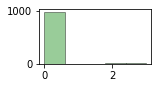

Track generation: 1123..1408 -> 285-tiles track
Episodi 4: recompensa = -92.9577


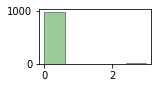

Track generation: 1191..1493 -> 302-tiles track
Episodi 5: recompensa = -93.3555


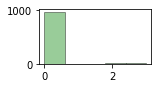

Track generation: 1051..1322 -> 271-tiles track
Episodi 6: recompensa = -92.5926


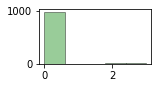

Track generation: 1105..1391 -> 286-tiles track
Episodi 7: recompensa = -92.9825


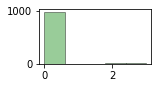

Track generation: 1084..1359 -> 275-tiles track
Episodi 8: recompensa = -92.7007


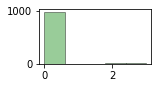

Track generation: 1213..1520 -> 307-tiles track
Episodi 9: recompensa = -93.4641


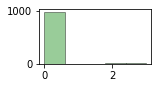

AvaluaAgent() Acabat


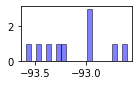


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_79
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1235..1546 -> 311-tiles track
Episodi 0: recompensa = -93.5484


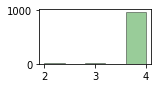

Track generation: 956..1199 -> 243-tiles track
Episodi 1: recompensa = -91.7355


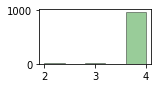

Track generation: 1057..1334 -> 277-tiles track
Episodi 2: recompensa = -92.7536


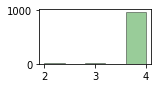

Track generation: 1215..1523 -> 308-tiles track
Episodi 3: recompensa = -93.4853


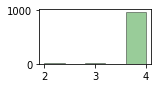

Track generation: 1136..1424 -> 288-tiles track
Episodi 4: recompensa = -93.0314


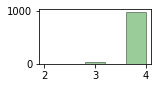

Track generation: 1183..1483 -> 300-tiles track
Episodi 5: recompensa = -93.311


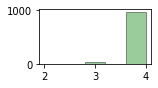

Track generation: 1179..1483 -> 304-tiles track
Episodi 6: recompensa = -93.3993


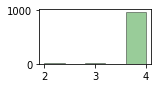

Track generation: 1104..1389 -> 285-tiles track
Episodi 7: recompensa = -92.9577


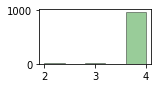

Track generation: 1027..1296 -> 269-tiles track
Episodi 8: recompensa = -92.5373


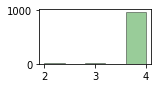

Track generation: 979..1228 -> 249-tiles track
Episodi 9: recompensa = -91.9355


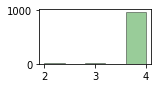

AvaluaAgent() Acabat


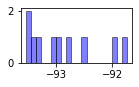


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_80
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1218..1527 -> 309-tiles track
Episodi 0: recompensa = -93.5065


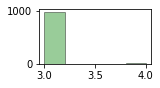

Track generation: 1066..1316 -> 250-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1195..1498 -> 303-tiles track
Episodi 1: recompensa = -93.3775


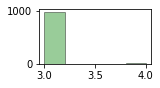

Track generation: 1167..1463 -> 296-tiles track
Episodi 2: recompensa = -93.2203


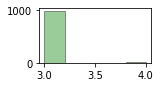

Track generation: 1123..1408 -> 285-tiles track
Episodi 3: recompensa = -92.9577


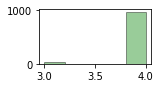

Track generation: 1067..1341 -> 274-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1196..1499 -> 303-tiles track
Episodi 4: recompensa = -93.3775


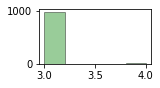

Track generation: 1155..1448 -> 293-tiles track
Episodi 5: recompensa = -93.1507


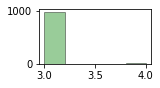

Track generation: 1221..1530 -> 309-tiles track
Episodi 6: recompensa = -93.5065


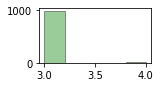

Track generation: 1288..1614 -> 326-tiles track
Episodi 7: recompensa = -93.8462


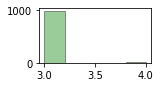

Track generation: 1132..1419 -> 287-tiles track
Episodi 8: recompensa = -93.007


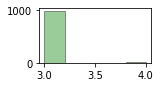

Track generation: 1252..1575 -> 323-tiles track
Episodi 9: recompensa = -93.7888


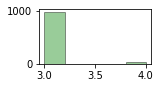

AvaluaAgent() Acabat


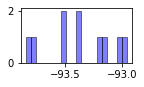


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_81
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1116..1399 -> 283-tiles track
Episodi 0: recompensa = -92.9078


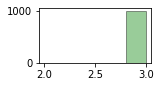

Track generation: 1056..1324 -> 268-tiles track
Episodi 1: recompensa = -92.5094


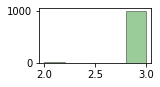

Track generation: 1209..1524 -> 315-tiles track
Episodi 2: recompensa = -93.6306


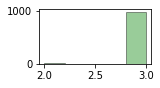

Track generation: 1244..1559 -> 315-tiles track
Episodi 3: recompensa = -93.6306


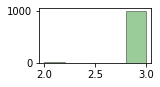

Track generation: 1137..1425 -> 288-tiles track
Episodi 4: recompensa = -93.0314


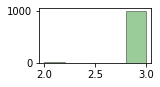

Track generation: 1015..1273 -> 258-tiles track
Episodi 5: recompensa = -92.2179


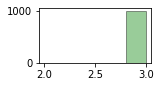

Track generation: 1164..1459 -> 295-tiles track
Episodi 6: recompensa = -93.1973


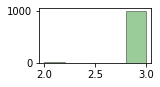

Track generation: 1111..1393 -> 282-tiles track
Episodi 7: recompensa = -92.8826


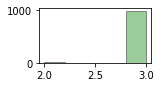

Track generation: 1166..1462 -> 296-tiles track
Episodi 8: recompensa = -93.2203


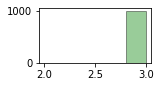

Track generation: 1193..1497 -> 304-tiles track
Episodi 9: recompensa = -93.3993


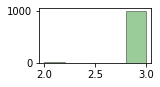

AvaluaAgent() Acabat


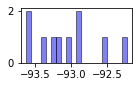


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_82
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1109..1397 -> 288-tiles track
Episodi 0: recompensa = -93.0314


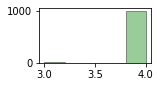

Track generation: 1312..1644 -> 332-tiles track
Episodi 1: recompensa = -93.9577


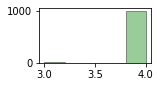

Track generation: 1068..1341 -> 273-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 978..1227 -> 249-tiles track
Episodi 2: recompensa = -91.9355


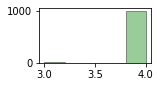

Track generation: 1256..1574 -> 318-tiles track
Episodi 3: recompensa = -93.6909


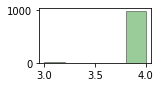

Track generation: 1217..1525 -> 308-tiles track
Episodi 4: recompensa = -93.4853


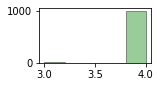

Track generation: 1331..1671 -> 340-tiles track
Episodi 5: recompensa = -94.1003


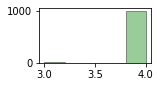

Track generation: 1211..1526 -> 315-tiles track
Episodi 6: recompensa = -93.6306


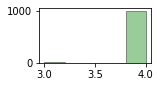

Track generation: 1048..1320 -> 272-tiles track
Episodi 7: recompensa = -92.6199


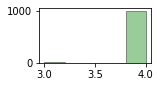

Track generation: 1084..1359 -> 275-tiles track
Episodi 8: recompensa = -92.7007


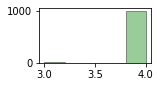

Track generation: 1200..1504 -> 304-tiles track
Episodi 9: recompensa = -93.3993


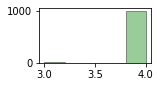

AvaluaAgent() Acabat


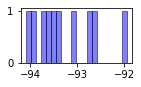


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_83
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1352..1695 -> 343-tiles track
Episodi 0: recompensa = -94.152


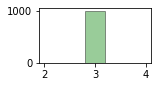

Track generation: 1146..1442 -> 296-tiles track
Episodi 1: recompensa = -93.2203


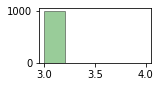

Track generation: 994..1249 -> 255-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1091..1368 -> 277-tiles track
Episodi 2: recompensa = -92.7536


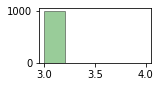

Track generation: 1184..1484 -> 300-tiles track
Episodi 3: recompensa = -93.311


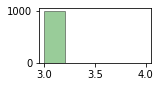

Track generation: 1111..1393 -> 282-tiles track
Episodi 4: recompensa = -92.8826


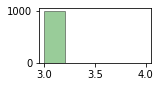

Track generation: 1303..1633 -> 330-tiles track
Episodi 5: recompensa = -93.921


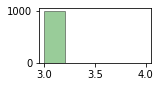

Track generation: 1145..1435 -> 290-tiles track
Episodi 6: recompensa = -93.0796


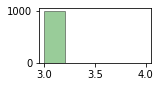

Track generation: 1177..1476 -> 299-tiles track
Episodi 7: recompensa = -93.2886


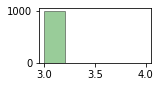

Track generation: 1104..1384 -> 280-tiles track
Episodi 8: recompensa = -92.8315


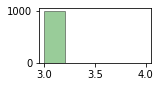

Track generation: 1112..1394 -> 282-tiles track
Episodi 9: recompensa = -92.8826


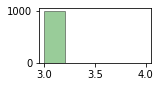

AvaluaAgent() Acabat


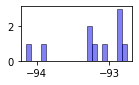


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_84
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1029..1296 -> 267-tiles track
Episodi 0: recompensa = 151.8797


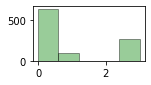

Track generation: 1088..1364 -> 276-tiles track
Episodi 1: recompensa = 252.7273


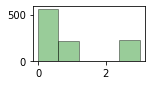

Track generation: 1165..1460 -> 295-tiles track
Episodi 2: recompensa = 359.1837


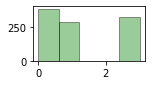

Track generation: 1209..1520 -> 311-tiles track
Episodi 3: recompensa = 203.2258


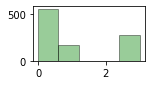

Track generation: 1243..1558 -> 315-tiles track
Episodi 4: recompensa = 183.4395


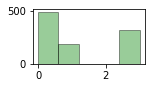

Track generation: 1107..1388 -> 281-tiles track
Episodi 5: recompensa = 235.7143


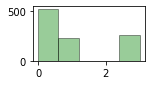

Track generation: 993..1245 -> 252-tiles track
Episodi 6: recompensa = 119.1235


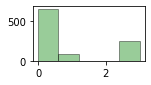

Track generation: 1140..1429 -> 289-tiles track
Episodi 7: recompensa = 354.8611


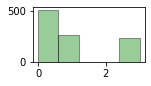

Track generation: 1107..1388 -> 281-tiles track
Episodi 8: recompensa = 157.1429


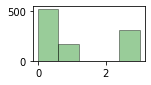

Track generation: 1038..1305 -> 267-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1097..1375 -> 278-tiles track
Episodi 9: recompensa = 286.2816


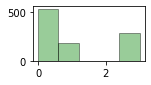

AvaluaAgent() Acabat


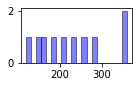


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_85
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1139..1428 -> 289-tiles track
Episodi 0: recompensa = -93.0556


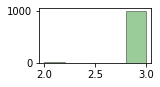

Track generation: 1156..1449 -> 293-tiles track
Episodi 1: recompensa = -93.1507


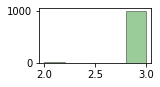

Track generation: 1089..1365 -> 276-tiles track
Episodi 2: recompensa = -92.7273


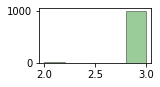

Track generation: 990..1250 -> 260-tiles track
Episodi 3: recompensa = -92.278


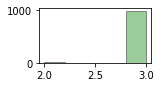

Track generation: 1147..1438 -> 291-tiles track
Episodi 4: recompensa = -93.1034


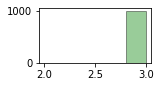

Track generation: 1316..1650 -> 334-tiles track
Episodi 5: recompensa = -93.994


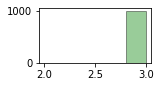

Track generation: 1171..1468 -> 297-tiles track
Episodi 6: recompensa = -93.2432


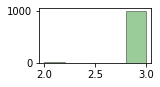

Track generation: 1147..1438 -> 291-tiles track
Episodi 7: recompensa = -93.1034


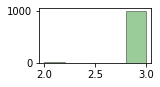

Track generation: 1172..1469 -> 297-tiles track
Episodi 8: recompensa = -93.2432


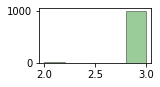

Track generation: 1080..1354 -> 274-tiles track
Episodi 9: recompensa = -92.674


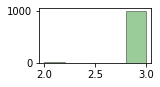

AvaluaAgent() Acabat


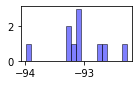


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_86
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1168..1464 -> 296-tiles track
Episodi 0: recompensa = -93.2203


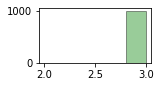

Track generation: 1255..1573 -> 318-tiles track
Episodi 1: recompensa = -93.6909


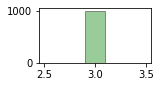

Track generation: 1194..1497 -> 303-tiles track
Episodi 2: recompensa = -93.3775


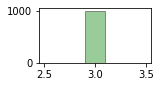

Track generation: 1119..1403 -> 284-tiles track
Episodi 3: recompensa = -92.9329


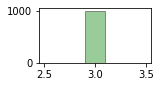

Track generation: 1212..1519 -> 307-tiles track
Episodi 4: recompensa = -93.4641


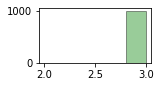

Track generation: 1076..1349 -> 273-tiles track
Episodi 5: recompensa = -92.6471


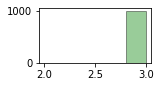

Track generation: 1232..1544 -> 312-tiles track
Episodi 6: recompensa = -93.5691


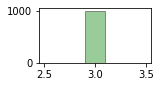

Track generation: 1179..1478 -> 299-tiles track
Episodi 7: recompensa = -93.2886


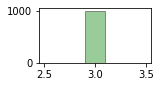

Track generation: 1119..1403 -> 284-tiles track
Episodi 8: recompensa = -92.9329


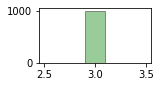

Track generation: 1144..1434 -> 290-tiles track
Episodi 9: recompensa = -93.0796


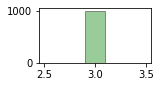

AvaluaAgent() Acabat


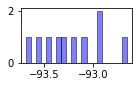


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_87
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1314..1653 -> 339-tiles track
Episodi 0: recompensa = 225.4438


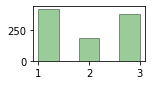

Track generation: 1113..1395 -> 282-tiles track
Episodi 1: recompensa = 287.9004


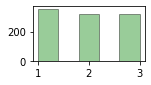

Track generation: 1332..1669 -> 337-tiles track
Episodi 2: recompensa = 206.5476


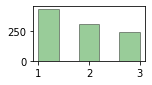

Track generation: 1148..1439 -> 291-tiles track
Episodi 3: recompensa = 106.8966


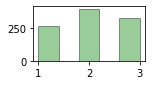

Track generation: 1233..1545 -> 312-tiles track
Episodi 4: recompensa = 324.4373


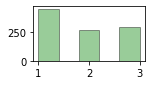

Track generation: 1188..1490 -> 302-tiles track
Episodi 5: recompensa = 96.0133


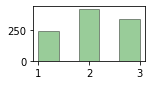

Track generation: 1175..1473 -> 298-tiles track
Episodi 6: recompensa = 152.5253


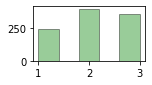

Track generation: 1036..1299 -> 263-tiles track
Episodi 7: recompensa = 350.3817


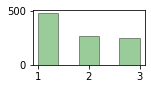

Track generation: 1031..1293 -> 262-tiles track
Episodi 8: recompensa = 363.6015


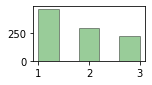

Track generation: 1132..1419 -> 287-tiles track
Episodi 9: recompensa = 67.8322


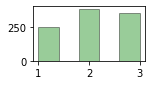

AvaluaAgent() Acabat


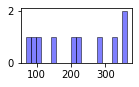


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_88
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1086..1363 -> 277-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1055..1332 -> 277-tiles track
Episodi 0: recompensa = -92.7536


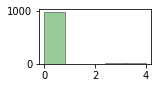

Track generation: 1231..1543 -> 312-tiles track
Episodi 1: recompensa = -93.5691


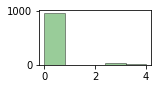

Track generation: 1139..1428 -> 289-tiles track
Episodi 2: recompensa = -93.0556


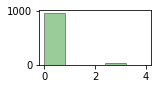

Track generation: 993..1251 -> 258-tiles track
Episodi 3: recompensa = -92.2179


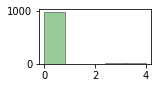

Track generation: 1148..1439 -> 291-tiles track
Episodi 4: recompensa = -93.1034


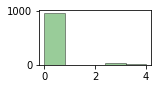

Track generation: 1162..1464 -> 302-tiles track
Episodi 5: recompensa = -93.3555


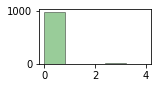

Track generation: 1228..1539 -> 311-tiles track
Episodi 6: recompensa = -93.5484


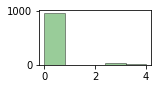

Track generation: 1196..1499 -> 303-tiles track
Episodi 7: recompensa = -93.3775


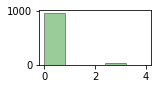

Track generation: 1179..1478 -> 299-tiles track
Episodi 8: recompensa = -93.2886


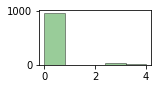

Track generation: 1064..1334 -> 270-tiles track
Episodi 9: recompensa = -92.5651


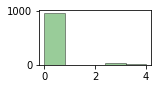

AvaluaAgent() Acabat


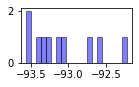


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_89
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1080..1361 -> 281-tiles track
Episodi 0: recompensa = -92.8571


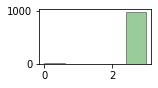

Track generation: 1244..1559 -> 315-tiles track
Episodi 1: recompensa = -93.6306


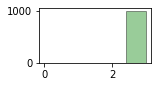

Track generation: 1070..1350 -> 280-tiles track
Episodi 2: recompensa = -92.8315


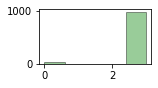

Track generation: 1146..1437 -> 291-tiles track
Episodi 3: recompensa = -93.1034


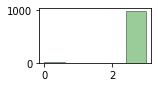

Track generation: 1062..1336 -> 274-tiles track
Episodi 4: recompensa = -92.674


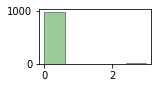

Track generation: 1160..1461 -> 301-tiles track
Episodi 5: recompensa = -93.3333


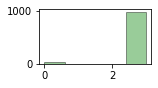

Track generation: 1068..1339 -> 271-tiles track
Episodi 6: recompensa = -92.5926


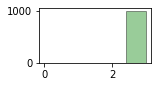

Track generation: 1062..1332 -> 270-tiles track
Episodi 7: recompensa = -92.5651


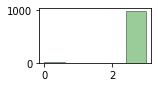

Track generation: 1156..1449 -> 293-tiles track
Episodi 8: recompensa = -93.1507


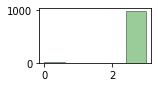

Track generation: 1005..1263 -> 258-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1243..1559 -> 316-tiles track
Episodi 9: recompensa = -93.6508


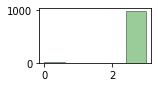

AvaluaAgent() Acabat


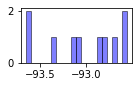


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_90
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1177..1475 -> 298-tiles track
Episodi 0: recompensa = -93.266


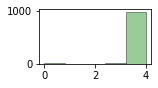

Track generation: 1025..1292 -> 267-tiles track
Episodi 1: recompensa = -92.4812


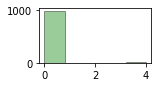

Track generation: 1091..1368 -> 277-tiles track
Episodi 2: recompensa = -92.7536


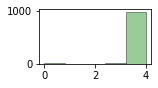

Track generation: 1179..1478 -> 299-tiles track
Episodi 3: recompensa = -93.2886


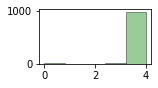

Track generation: 1207..1513 -> 306-tiles track
Episodi 4: recompensa = -93.4426


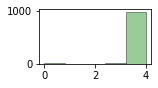

Track generation: 1134..1428 -> 294-tiles track
Episodi 5: recompensa = -93.1741


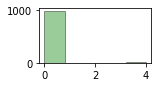

Track generation: 1297..1625 -> 328-tiles track
Episodi 6: recompensa = -93.8838


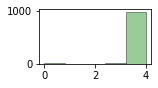

Track generation: 1139..1428 -> 289-tiles track
Episodi 7: recompensa = -93.0556


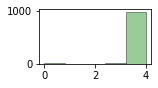

Track generation: 1099..1386 -> 287-tiles track
Episodi 8: recompensa = -93.007


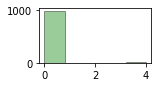

Track generation: 1132..1419 -> 287-tiles track
Episodi 9: recompensa = -93.007


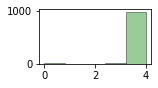

AvaluaAgent() Acabat


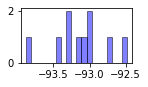


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_91
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1212..1519 -> 307-tiles track
Episodi 0: recompensa = -93.4641


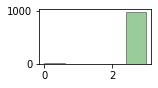

Track generation: 1237..1550 -> 313-tiles track
Episodi 1: recompensa = -93.5897


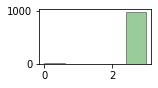

Track generation: 1096..1380 -> 284-tiles track
Episodi 2: recompensa = -92.9329


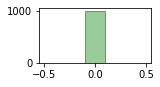

Track generation: 1132..1428 -> 296-tiles track
Episodi 3: recompensa = -93.2203


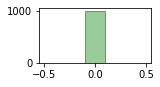

Track generation: 1016..1274 -> 258-tiles track
Episodi 4: recompensa = -92.2179


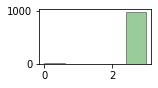

Track generation: 1317..1650 -> 333-tiles track
Episodi 5: recompensa = -93.9759


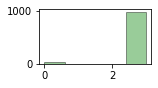

Track generation: 1175..1473 -> 298-tiles track
Episodi 6: recompensa = -93.266


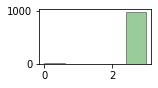

Track generation: 1153..1445 -> 292-tiles track
Episodi 7: recompensa = -93.1271


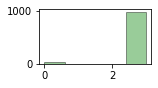

Track generation: 1100..1379 -> 279-tiles track
Episodi 8: recompensa = -92.8058


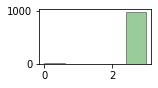

Track generation: 1083..1358 -> 275-tiles track
Episodi 9: recompensa = -92.7007


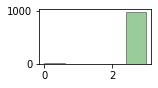

AvaluaAgent() Acabat


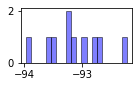


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_92
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1079..1353 -> 274-tiles track
Episodi 0: recompensa = -92.674


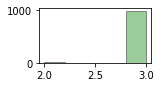

Track generation: 1143..1436 -> 293-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1121..1411 -> 290-tiles track
Episodi 1: recompensa = -93.0796


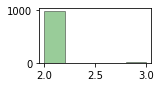

Track generation: 1237..1550 -> 313-tiles track
Episodi 2: recompensa = -93.5897


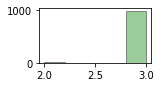

Track generation: 1128..1414 -> 286-tiles track
Episodi 3: recompensa = -92.9825


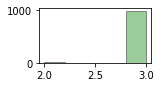

Track generation: 1186..1487 -> 301-tiles track
Episodi 4: recompensa = -93.3333


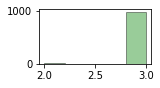

Track generation: 1181..1486 -> 305-tiles track
Episodi 5: recompensa = -93.4211


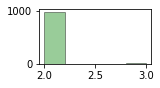

Track generation: 1052..1319 -> 267-tiles track
Episodi 6: recompensa = -92.4812


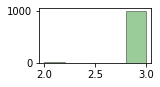

Track generation: 1148..1445 -> 297-tiles track
Episodi 7: recompensa = -93.2432


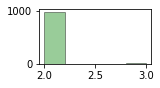

Track generation: 1162..1457 -> 295-tiles track
Episodi 8: recompensa = -93.1973


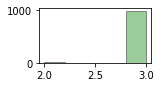

Track generation: 1152..1444 -> 292-tiles track
Episodi 9: recompensa = -93.1271


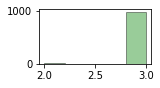

AvaluaAgent() Acabat


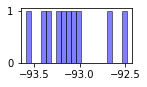


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_93
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1295..1623 -> 328-tiles track
Episodi 0: recompensa = 104.893


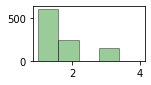

Track generation: 1072..1344 -> 272-tiles track
Episodi 1: recompensa = 69.7417


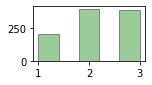

Track generation: 1240..1554 -> 314-tiles track
Episodi 2: recompensa = 305.7508


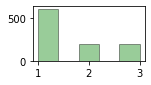

Track generation: 1071..1350 -> 279-tiles track
Episodi 3: recompensa = 180.5755


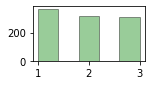

Track generation: 1182..1481 -> 299-tiles track
Episodi 4: recompensa = 124.8322


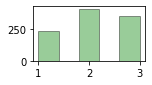

Track generation: 1257..1575 -> 318-tiles track
Episodi 5: recompensa = 193.3754


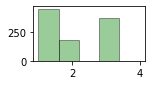

Track generation: 1249..1565 -> 316-tiles track
Episodi 6: recompensa = 223.8095


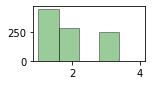

Track generation: 1055..1323 -> 268-tiles track
Episodi 7: recompensa = 61.0487


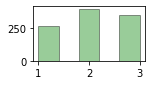

Track generation: 1058..1326 -> 268-tiles track
Episodi 8: recompensa = 135.9551


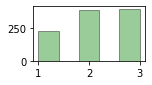

Track generation: 1008..1269 -> 261-tiles track
Episodi 9: recompensa = 126.9231


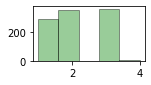

AvaluaAgent() Acabat


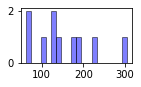


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_94
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1309..1640 -> 331-tiles track
Episodi 0: recompensa = -93.9394


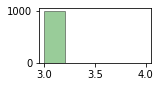

Track generation: 1154..1455 -> 301-tiles track
Episodi 1: recompensa = 23.3333


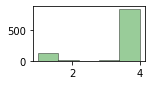

Track generation: 1255..1573 -> 318-tiles track
Episodi 2: recompensa = -93.6909


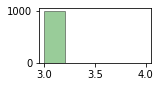

Track generation: 1284..1609 -> 325-tiles track
Episodi 3: recompensa = 492.5926


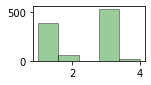

Track generation: 1140..1429 -> 289-tiles track
Episodi 4: recompensa = -93.0556


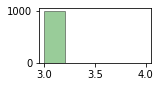

Track generation: 1067..1346 -> 279-tiles track
Episodi 5: recompensa = 72.6619


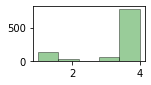

Track generation: 1247..1563 -> 316-tiles track
Episodi 6: recompensa = -93.6508


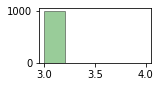

Track generation: 1140..1429 -> 289-tiles track
Episodi 7: recompensa = -93.0556


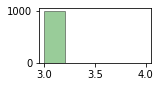

Track generation: 1069..1343 -> 274-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1051..1318 -> 267-tiles track
Episodi 8: recompensa = -92.4812


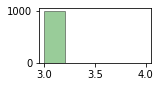

Track generation: 1186..1487 -> 301-tiles track
Episodi 9: recompensa = -93.3333


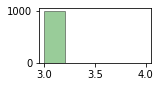

AvaluaAgent() Acabat


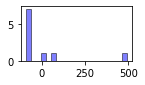


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_95
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1081..1360 -> 279-tiles track
Episodi 0: recompensa = 558.2734


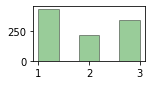

Track generation: 1184..1484 -> 300-tiles track
Episodi 1: recompensa = -93.311


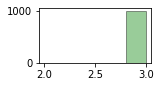

Track generation: 1124..1409 -> 285-tiles track
Episodi 2: recompensa = -92.9577


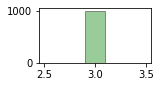

Track generation: 1088..1364 -> 276-tiles track
Episodi 3: recompensa = 576.3636


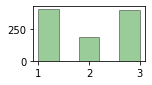

Track generation: 1161..1463 -> 302-tiles track
Episodi 4: recompensa = 195.6811


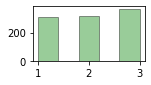

Track generation: 1067..1338 -> 271-tiles track
Episodi 5: recompensa = -92.5926


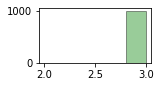

Track generation: 1119..1402 -> 283-tiles track
Episodi 6: recompensa = 662.4113


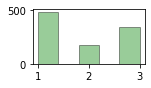

Track generation: 1079..1353 -> 274-tiles track
Episodi 7: recompensa = 398.1685


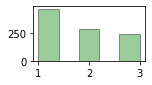

Track generation: 1032..1298 -> 266-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 983..1233 -> 250-tiles track
Episodi 8: recompensa = 470.2811


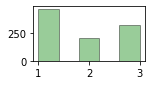

Track generation: 1043..1315 -> 272-tiles track
Episodi 9: recompensa = 479.3358


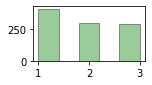

AvaluaAgent() Acabat


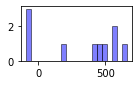


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_96
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1176..1474 -> 298-tiles track
Episodi 0: recompensa = -93.266


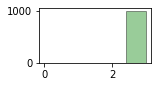

Track generation: 1320..1654 -> 334-tiles track
Episodi 1: recompensa = -93.994


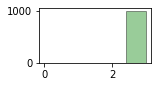

Track generation: 1282..1616 -> 334-tiles track
Episodi 2: recompensa = -93.994


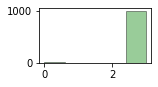

Track generation: 1098..1384 -> 286-tiles track
Episodi 3: recompensa = -92.9825


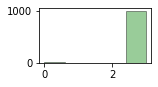

Track generation: 975..1227 -> 252-tiles track
Episodi 4: recompensa = -92.0319


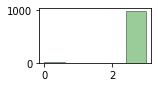

Track generation: 1225..1536 -> 311-tiles track
Episodi 5: recompensa = -93.5484


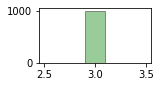

Track generation: 1079..1352 -> 273-tiles track
Episodi 6: recompensa = -92.6471


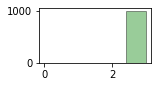

Track generation: 1074..1354 -> 280-tiles track
Episodi 7: recompensa = -92.8315


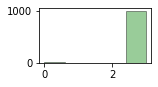

Track generation: 1001..1262 -> 261-tiles track
Episodi 8: recompensa = -92.3077


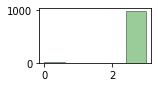

Track generation: 1268..1595 -> 327-tiles track
Episodi 9: recompensa = -93.865


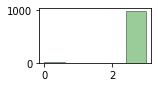

AvaluaAgent() Acabat


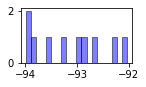


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_97
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1339..1678 -> 339-tiles track
Episodi 0: recompensa = -94.0828


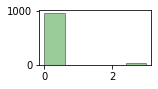

Track generation: 1146..1437 -> 291-tiles track
Episodi 1: recompensa = -93.1034


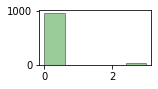

Track generation: 1299..1628 -> 329-tiles track
Episodi 2: recompensa = -93.9024


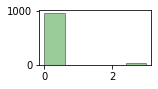

Track generation: 1125..1418 -> 293-tiles track
Episodi 3: recompensa = -93.1507


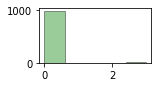

Track generation: 1026..1287 -> 261-tiles track
Episodi 4: recompensa = -92.3077


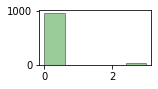

Track generation: 1178..1476 -> 298-tiles track
Episodi 5: recompensa = -93.266


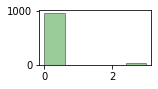

Track generation: 1139..1428 -> 289-tiles track
Episodi 6: recompensa = -93.0556


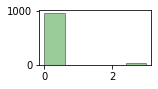

Track generation: 1159..1453 -> 294-tiles track
Episodi 7: recompensa = -93.1741


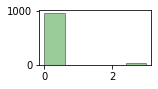

Track generation: 1168..1464 -> 296-tiles track
Episodi 8: recompensa = -93.2203


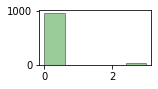

Track generation: 1213..1520 -> 307-tiles track
Episodi 9: recompensa = -93.4641


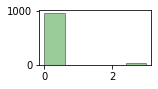

AvaluaAgent() Acabat


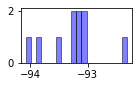


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_98
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1020..1279 -> 259-tiles track
Episodi 0: recompensa = -92.2481


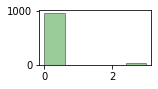

Track generation: 1100..1379 -> 279-tiles track
Episodi 1: recompensa = -92.8058


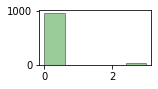

Track generation: 1245..1560 -> 315-tiles track
Episodi 2: recompensa = -93.6306


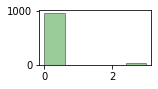

Track generation: 1143..1440 -> 297-tiles track
Episodi 3: recompensa = -93.2432


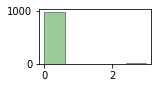

Track generation: 1156..1458 -> 302-tiles track
Episodi 4: recompensa = -93.3555


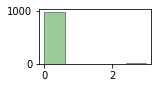

Track generation: 1086..1366 -> 280-tiles track
Episodi 5: recompensa = -28.3154


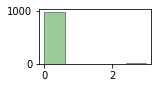

Track generation: 1144..1441 -> 297-tiles track
Episodi 6: recompensa = -93.2432


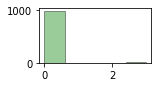

Track generation: 1182..1487 -> 305-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1224..1534 -> 310-tiles track
Episodi 7: recompensa = -93.5275


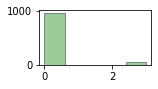

Track generation: 1131..1418 -> 287-tiles track
Episodi 8: recompensa = -93.007


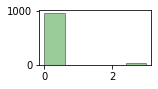

Track generation: 1113..1439 -> 326-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1182..1489 -> 307-tiles track
Episodi 9: recompensa = 37.2549


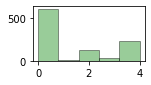

AvaluaAgent() Acabat


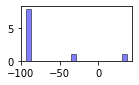


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_99
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1025..1295 -> 270-tiles track
Episodi 0: recompensa = 28.3037


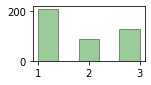

Track generation: 1159..1453 -> 294-tiles track
Episodi 1: recompensa = 231.058


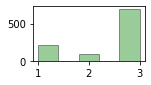

Track generation: 1022..1288 -> 266-tiles track
Episodi 2: recompensa = 311.3208


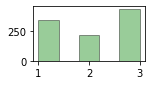

Track generation: 1173..1471 -> 298-tiles track
Episodi 3: recompensa = 691.2458


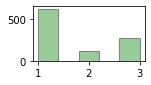

Track generation: 1121..1411 -> 290-tiles track
Episodi 4: recompensa = 342.9066


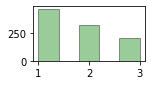

Track generation: 1080..1354 -> 274-tiles track
Episodi 5: recompensa = 368.8645


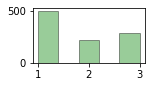

Track generation: 1221..1530 -> 309-tiles track
Episodi 6: recompensa = 354.5455


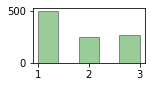

Track generation: 1079..1355 -> 276-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1131..1418 -> 287-tiles track
Episodi 7: recompensa = 246.1538


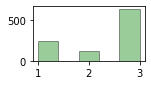

Track generation: 1104..1384 -> 280-tiles track
Episodi 8: recompensa = 695.6989


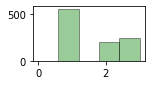

Track generation: 1171..1477 -> 306-tiles track
Episodi 9: recompensa = 201.6393


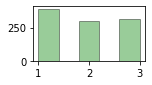

AvaluaAgent() Acabat


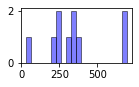


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_100
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1128..1420 -> 292-tiles track
Episodi 0: recompensa = -93.1271


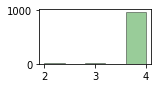

Track generation: 1316..1649 -> 333-tiles track
Episodi 1: recompensa = -93.9759


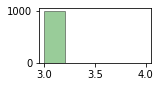

Track generation: 1199..1503 -> 304-tiles track
Episodi 2: recompensa = -93.3993


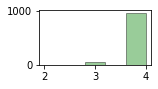

Track generation: 1043..1308 -> 265-tiles track
Episodi 3: recompensa = -92.4242


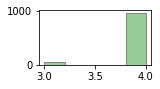

Track generation: 1175..1473 -> 298-tiles track
Episodi 4: recompensa = -93.266


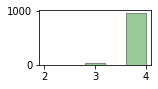

Track generation: 1060..1335 -> 275-tiles track
Episodi 5: recompensa = -92.7007


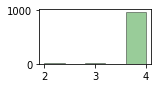

Track generation: 1167..1463 -> 296-tiles track
Episodi 6: recompensa = -93.2203


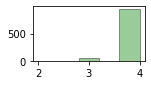

Track generation: 1117..1400 -> 283-tiles track
Episodi 7: recompensa = -92.9078


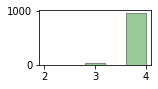

Track generation: 1084..1359 -> 275-tiles track
Episodi 8: recompensa = -92.7007


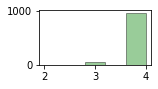

Track generation: 1042..1309 -> 267-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1131..1418 -> 287-tiles track
Episodi 9: recompensa = -93.007


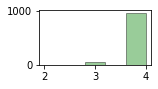

AvaluaAgent() Acabat


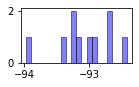


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_101
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1180..1487 -> 307-tiles track
Episodi 0: recompensa = -93.4641


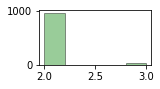

Track generation: 1099..1378 -> 279-tiles track
Episodi 1: recompensa = -92.8058


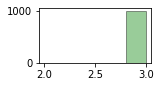

Track generation: 989..1240 -> 251-tiles track
Episodi 2: recompensa = -92.0


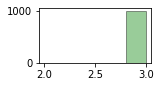

Track generation: 1010..1268 -> 258-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1173..1470 -> 297-tiles track
Episodi 3: recompensa = -93.2432


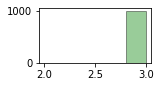

Track generation: 1041..1309 -> 268-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1083..1363 -> 280-tiles track
Episodi 4: recompensa = -92.8315


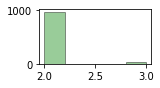

Track generation: 1036..1305 -> 269-tiles track
Episodi 5: recompensa = -92.5373


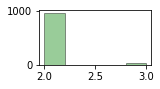

Track generation: 1199..1503 -> 304-tiles track
Episodi 6: recompensa = -93.3993


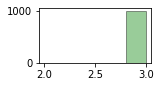

Track generation: 1112..1394 -> 282-tiles track
Episodi 7: recompensa = -92.8826


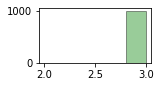

Track generation: 1032..1294 -> 262-tiles track
Episodi 8: recompensa = -92.3372


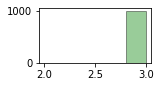

Track generation: 1047..1313 -> 266-tiles track
Episodi 9: recompensa = -92.4528


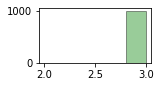

AvaluaAgent() Acabat


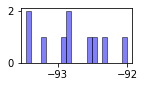


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_102
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1053..1324 -> 271-tiles track
Episodi 0: recompensa = 488.8889


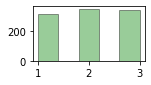

Track generation: 1148..1439 -> 291-tiles track
Episodi 1: recompensa = 386.2069


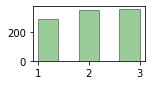

Track generation: 1100..1379 -> 279-tiles track
Episodi 2: recompensa = 583.4532


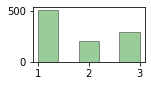

Track generation: 1184..1484 -> 300-tiles track
Episodi 3: recompensa = 602.3411


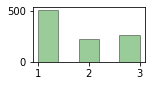

Track generation: 1125..1416 -> 291-tiles track
Episodi 4: recompensa = 755.1724


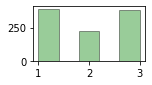

Track generation: 1275..1598 -> 323-tiles track
Episodi 5: recompensa = 775.7764


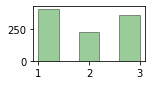

Track generation: 1073..1352 -> 279-tiles track
Episodi 6: recompensa = 230.9353


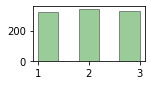

Track generation: 1119..1403 -> 284-tiles track
Episodi 7: recompensa = 546.6431


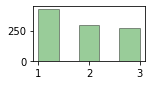

Track generation: 1203..1508 -> 305-tiles track
Episodi 8: recompensa = 748.6842


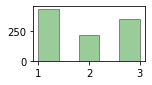

Track generation: 1250..1566 -> 316-tiles track
Episodi 9: recompensa = 477.7778


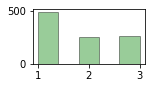

AvaluaAgent() Acabat


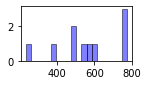


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_103
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1184..1484 -> 300-tiles track
Episodi 0: recompensa = -93.311


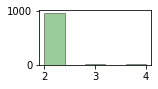

Track generation: 1199..1503 -> 304-tiles track
Episodi 1: recompensa = -93.3993


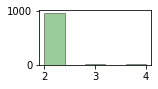

Track generation: 1296..1624 -> 328-tiles track
Episodi 2: recompensa = -93.8838


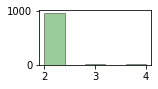

Track generation: 1198..1501 -> 303-tiles track
Episodi 3: recompensa = -93.3775


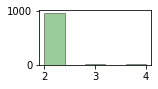

Track generation: 986..1242 -> 256-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1252..1569 -> 317-tiles track
Episodi 4: recompensa = -93.6709


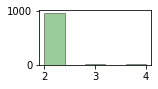

Track generation: 1335..1673 -> 338-tiles track
Episodi 5: recompensa = -94.0653


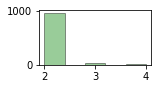

Track generation: 1264..1584 -> 320-tiles track
Episodi 6: recompensa = -93.7304


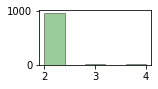

Track generation: 1199..1503 -> 304-tiles track
Episodi 7: recompensa = -93.3993


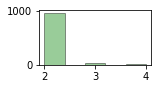

Track generation: 1083..1358 -> 275-tiles track
Episodi 8: recompensa = -92.7007


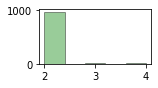

Track generation: 1215..1523 -> 308-tiles track
Episodi 9: recompensa = -93.4853


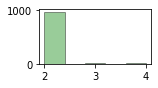

AvaluaAgent() Acabat


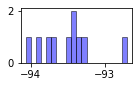


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_104
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1240..1558 -> 318-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1139..1428 -> 289-tiles track
Episodi 0: recompensa = -93.0556


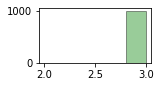

Track generation: 1282..1606 -> 324-tiles track
Episodi 1: recompensa = 485.1393


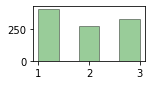

Track generation: 1180..1479 -> 299-tiles track
Episodi 2: recompensa = -93.2886


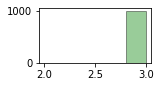

Track generation: 1087..1363 -> 276-tiles track
Episodi 3: recompensa = 812.7273


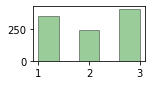

Track generation: 1169..1466 -> 297-tiles track
Episodi 4: recompensa = -93.2432


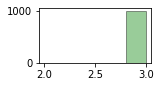

Track generation: 1129..1422 -> 293-tiles track
Episodi 5: recompensa = 355.4795


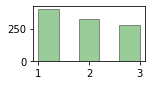

Track generation: 1145..1435 -> 290-tiles track
Episodi 6: recompensa = 823.8754


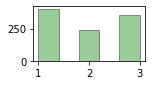

Track generation: 1088..1364 -> 276-tiles track
Episodi 7: recompensa = 830.9091


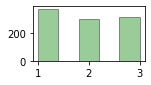

Track generation: 1013..1268 -> 255-tiles track
Episodi 8: recompensa = 545.6693


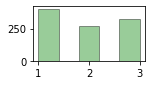

Track generation: 1094..1372 -> 278-tiles track
Episodi 9: recompensa = -92.7798


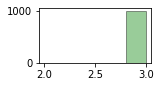

AvaluaAgent() Acabat


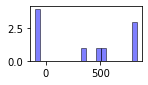


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_105
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1014..1272 -> 258-tiles track
Episodi 0: recompensa = -92.2179


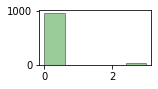

Track generation: 1252..1569 -> 317-tiles track
Episodi 1: recompensa = -93.6709


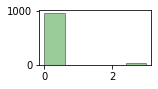

Track generation: 1216..1524 -> 308-tiles track
Episodi 2: recompensa = -93.4853


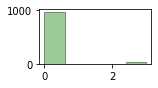

Track generation: 1063..1333 -> 270-tiles track
Episodi 3: recompensa = -92.5651


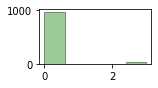

Track generation: 1187..1488 -> 301-tiles track
Episodi 4: recompensa = -93.3333


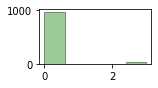

Track generation: 1114..1400 -> 286-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1131..1423 -> 292-tiles track
Episodi 5: recompensa = -93.1271


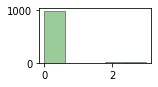

Track generation: 1075..1348 -> 273-tiles track
Episodi 6: recompensa = -92.6471


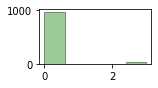

Track generation: 1229..1540 -> 311-tiles track
Episodi 7: recompensa = -93.5484


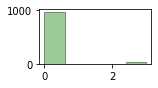

Track generation: 1116..1399 -> 283-tiles track
Episodi 8: recompensa = -92.9078


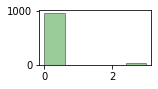

Track generation: 1084..1359 -> 275-tiles track
Episodi 9: recompensa = -92.7007


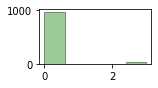

AvaluaAgent() Acabat


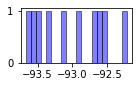


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_106
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1029..1292 -> 263-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1137..1425 -> 288-tiles track
Episodi 0: recompensa = -93.0314


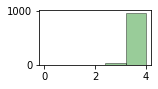

Track generation: 1098..1377 -> 279-tiles track
Episodi 1: recompensa = -92.8058


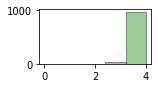

Track generation: 1181..1480 -> 299-tiles track
Episodi 2: recompensa = -93.2886


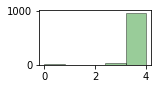

Track generation: 1346..1686 -> 340-tiles track
Episodi 3: recompensa = -94.1003


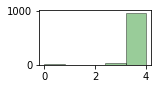

Track generation: 1132..1419 -> 287-tiles track
Episodi 4: recompensa = -93.007


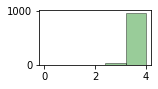

Track generation: 1136..1424 -> 288-tiles track
Episodi 5: recompensa = -93.0314


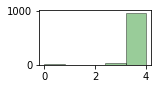

Track generation: 1195..1498 -> 303-tiles track
Episodi 6: recompensa = -93.3775


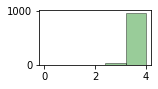

Track generation: 1160..1454 -> 294-tiles track
Episodi 7: recompensa = -93.1741


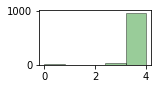

Track generation: 1047..1313 -> 266-tiles track
Episodi 8: recompensa = -92.4528


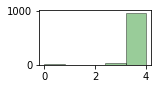

Track generation: 1201..1504 -> 303-tiles track
Episodi 9: recompensa = -93.3775


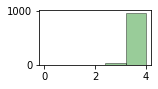

AvaluaAgent() Acabat


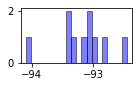


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_107
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1315..1648 -> 333-tiles track
Episodi 0: recompensa = -93.9759


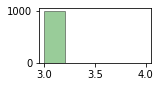

Track generation: 1258..1576 -> 318-tiles track
Episodi 1: recompensa = -93.6909


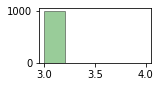

Track generation: 1337..1675 -> 338-tiles track
Episodi 2: recompensa = -94.0653


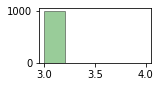

Track generation: 1091..1368 -> 277-tiles track
Episodi 3: recompensa = -92.7536


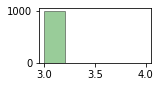

Track generation: 1440..1805 -> 365-tiles track
Episodi 4: recompensa = -94.5055


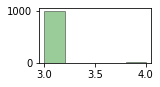

Track generation: 1283..1607 -> 324-tiles track
Episodi 5: recompensa = -93.808


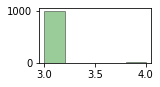

Track generation: 1103..1383 -> 280-tiles track
Episodi 6: recompensa = -92.8315


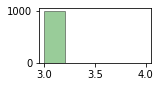

Track generation: 963..1212 -> 249-tiles track
Episodi 7: recompensa = -91.9355


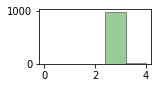

Track generation: 1340..1679 -> 339-tiles track
Episodi 8: recompensa = -94.0828


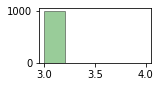

Track generation: 943..1189 -> 246-tiles track
Episodi 9: recompensa = -91.8367


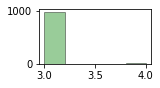

AvaluaAgent() Acabat


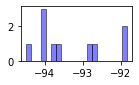


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_108
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1210..1517 -> 307-tiles track
Episodi 0: recompensa = -93.4641


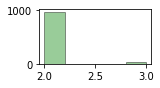

Track generation: 1092..1369 -> 277-tiles track
Episodi 1: recompensa = -92.7536


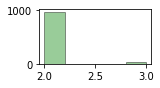

Track generation: 1253..1577 -> 324-tiles track
Episodi 2: recompensa = -93.808


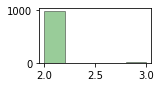

Track generation: 1285..1621 -> 336-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1185..1492 -> 307-tiles track
Episodi 3: recompensa = -93.4641


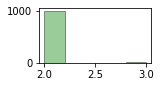

Track generation: 1260..1579 -> 319-tiles track
Episodi 4: recompensa = -93.7107


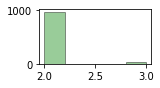

Track generation: 1093..1371 -> 278-tiles track
Episodi 5: recompensa = -92.7798


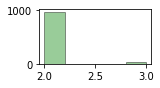

Track generation: 1143..1435 -> 292-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1049..1322 -> 273-tiles track
Episodi 6: recompensa = -92.6471


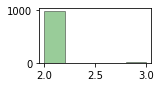

Track generation: 1300..1629 -> 329-tiles track
Episodi 7: recompensa = -93.9024


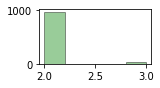

Track generation: 1007..1263 -> 256-tiles track
Episodi 8: recompensa = -92.1569


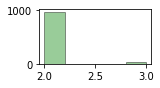

Track generation: 1235..1548 -> 313-tiles track
Episodi 9: recompensa = -93.5897


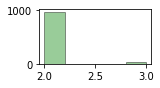

AvaluaAgent() Acabat


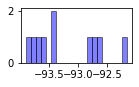


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_109
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1216..1524 -> 308-tiles track
Episodi 0: recompensa = -93.4853


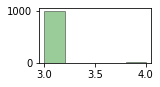

Track generation: 1103..1383 -> 280-tiles track
Episodi 1: recompensa = -92.8315


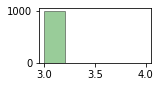

Track generation: 1263..1583 -> 320-tiles track
Episodi 2: recompensa = -93.7304


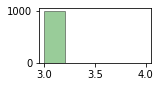

Track generation: 1220..1529 -> 309-tiles track
Episodi 3: recompensa = -93.5065


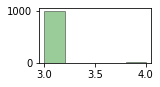

Track generation: 1220..1529 -> 309-tiles track
Episodi 4: recompensa = -93.5065


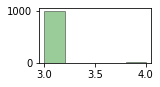

Track generation: 1170..1467 -> 297-tiles track
Episodi 5: recompensa = -93.2432


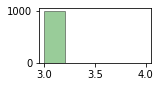

Track generation: 1108..1389 -> 281-tiles track
Episodi 6: recompensa = -92.8571


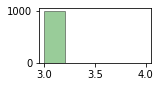

Track generation: 870..1095 -> 225-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1137..1434 -> 297-tiles track
Episodi 7: recompensa = -93.2432


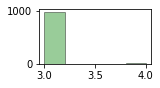

Track generation: 1166..1461 -> 295-tiles track
Episodi 8: recompensa = -93.1973


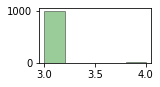

Track generation: 1200..1505 -> 305-tiles track
Episodi 9: recompensa = -93.4211


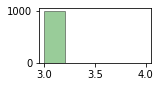

AvaluaAgent() Acabat


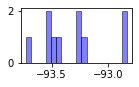


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_110
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1139..1435 -> 296-tiles track
Episodi 0: recompensa = -93.2203


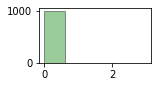

Track generation: 1148..1439 -> 291-tiles track
Episodi 1: recompensa = -93.1034


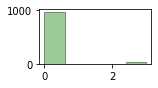

Track generation: 1197..1501 -> 304-tiles track
Episodi 2: recompensa = -93.3993


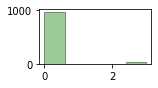

Track generation: 1245..1560 -> 315-tiles track
Episodi 3: recompensa = -93.6306


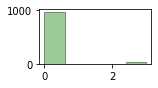

Track generation: 981..1237 -> 256-tiles track
Episodi 4: recompensa = -92.1569


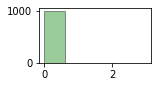

Track generation: 1028..1292 -> 264-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1280..1604 -> 324-tiles track
Episodi 5: recompensa = -93.808


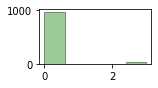

Track generation: 1197..1501 -> 304-tiles track
Episodi 6: recompensa = -93.3993


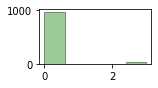

Track generation: 1311..1643 -> 332-tiles track
Episodi 7: recompensa = -93.9577


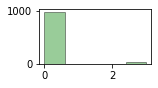

Track generation: 1180..1480 -> 300-tiles track
Episodi 8: recompensa = -93.311


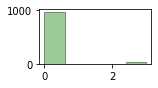

Track generation: 1210..1523 -> 313-tiles track
Episodi 9: recompensa = -93.5897


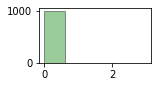

AvaluaAgent() Acabat


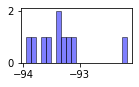


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_111
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1013..1281 -> 268-tiles track
Episodi 0: recompensa = -92.5094


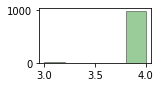

Track generation: 1103..1385 -> 282-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1264..1584 -> 320-tiles track
Episodi 1: recompensa = -93.7304


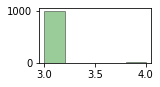

Track generation: 1086..1367 -> 281-tiles track
Episodi 2: recompensa = -92.8571


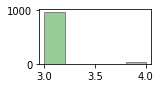

Track generation: 1130..1416 -> 286-tiles track
Episodi 3: recompensa = -92.9825


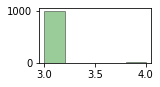

Track generation: 1323..1665 -> 342-tiles track
Episodi 4: recompensa = -94.1349


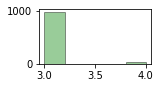

Track generation: 1190..1491 -> 301-tiles track
Episodi 5: recompensa = -93.3333


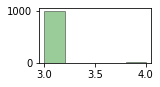

Track generation: 1131..1418 -> 287-tiles track
Episodi 6: recompensa = -93.007


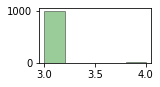

Track generation: 1158..1452 -> 294-tiles track
Episodi 7: recompensa = -93.1741


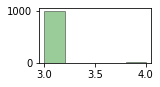

Track generation: 1099..1385 -> 286-tiles track
Episodi 8: recompensa = -92.9825


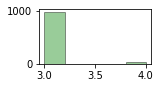

Track generation: 1116..1399 -> 283-tiles track
Episodi 9: recompensa = -92.9078


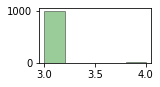

AvaluaAgent() Acabat


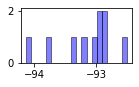


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_112
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1084..1366 -> 282-tiles track
Episodi 0: recompensa = -92.8826


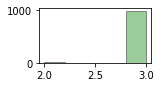

Track generation: 983..1233 -> 250-tiles track
Episodi 1: recompensa = -91.9679


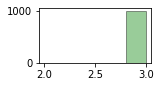

Track generation: 1160..1454 -> 294-tiles track
Episodi 2: recompensa = -93.1741


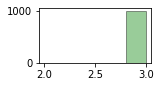

Track generation: 1104..1384 -> 280-tiles track
Episodi 3: recompensa = -92.8315


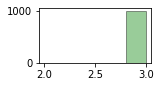

Track generation: 1112..1410 -> 298-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1158..1461 -> 303-tiles track
Episodi 4: recompensa = -93.3775


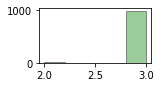

Track generation: 1191..1493 -> 302-tiles track
Episodi 5: recompensa = -93.3555


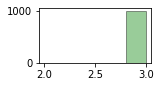

Track generation: 1055..1323 -> 268-tiles track
Episodi 6: recompensa = -92.5094


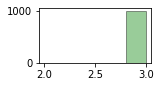

Track generation: 1148..1439 -> 291-tiles track
Episodi 7: recompensa = -93.1034


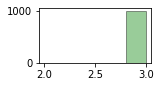

Track generation: 1023..1289 -> 266-tiles track
Episodi 8: recompensa = -92.4528


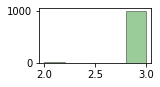

Track generation: 1088..1364 -> 276-tiles track
Episodi 9: recompensa = -92.7273


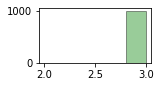

AvaluaAgent() Acabat


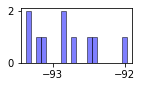


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_113
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1043..1308 -> 265-tiles track
Episodi 0: recompensa = 453.0303


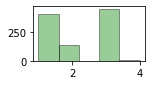

Track generation: 1339..1678 -> 339-tiles track
Episodi 1: recompensa = 263.9053


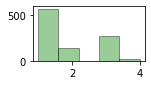

Track generation: 1171..1468 -> 297-tiles track
Episodi 2: recompensa = 308.7838


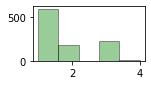

Track generation: 1081..1364 -> 283-tiles track
Episodi 3: recompensa = 240.4255


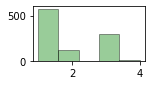

Track generation: 1267..1588 -> 321-tiles track
Episodi 4: recompensa = 396.875


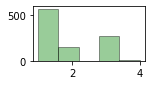

Track generation: 1244..1559 -> 315-tiles track
Episodi 5: recompensa = 377.707


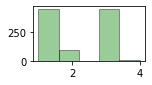

Track generation: 1004..1262 -> 258-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1166..1461 -> 295-tiles track
Episodi 6: recompensa = 67.6966


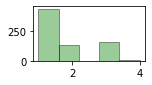

Track generation: 1200..1504 -> 304-tiles track
Episodi 7: recompensa = 190.429


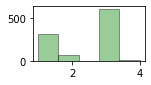

Track generation: 1179..1485 -> 306-tiles track
Episodi 8: recompensa = 237.7049


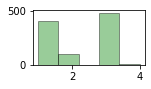

Track generation: 1124..1409 -> 285-tiles track
Episodi 9: recompensa = 459.8592


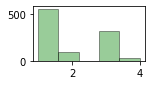

AvaluaAgent() Acabat


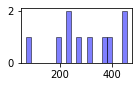


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_114
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1136..1424 -> 288-tiles track
Episodi 0: recompensa = 161.324


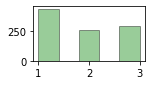

Track generation: 922..1163 -> 241-tiles track
Episodi 1: recompensa = 233.3333


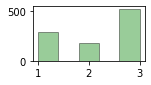

Track generation: 1179..1478 -> 299-tiles track
Episodi 2: recompensa = 131.5436


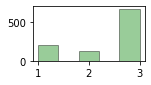

Track generation: 1128..1414 -> 286-tiles track
Episodi 3: recompensa = 257.8947


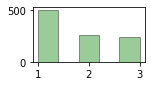

Track generation: 1134..1421 -> 287-tiles track
Episodi 4: recompensa = 326.5734


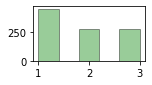

Track generation: 1078..1351 -> 273-tiles track
Episodi 5: recompensa = 297.0588


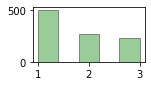

Track generation: 1111..1393 -> 282-tiles track
Episodi 6: recompensa = 262.9893


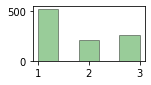

Track generation: 979..1235 -> 256-tiles track
Episodi 7: recompensa = 44.1275


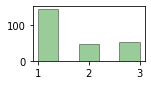

Track generation: 1000..1260 -> 260-tiles track
Episodi 8: recompensa = 139.3822


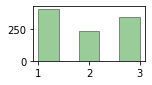

Track generation: 1114..1396 -> 282-tiles track
Episodi 9: recompensa = 234.5196


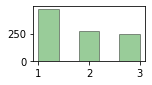

AvaluaAgent() Acabat


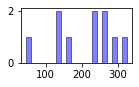


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_115
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1016..1274 -> 258-tiles track
Episodi 0: recompensa = -92.2179


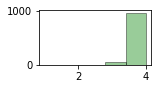

Track generation: 977..1225 -> 248-tiles track
Episodi 1: recompensa = -91.9028


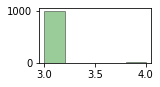

Track generation: 1132..1419 -> 287-tiles track
Episodi 2: recompensa = -93.007


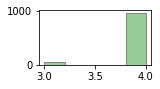

Track generation: 1092..1369 -> 277-tiles track
Episodi 3: recompensa = -92.7536


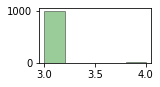

Track generation: 1228..1539 -> 311-tiles track
Episodi 4: recompensa = -93.5484


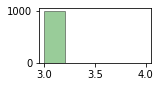

Track generation: 1192..1494 -> 302-tiles track
Episodi 5: recompensa = -93.3555


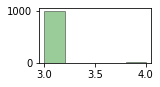

Track generation: 1111..1393 -> 282-tiles track
Episodi 6: recompensa = -92.8826


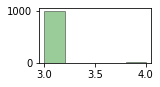

Track generation: 1131..1418 -> 287-tiles track
Episodi 7: recompensa = -93.007


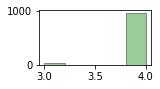

Track generation: 1004..1261 -> 257-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1087..1372 -> 285-tiles track
Episodi 8: recompensa = -92.9577


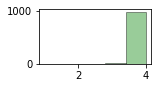

Track generation: 1034..1296 -> 262-tiles track
Episodi 9: recompensa = -92.3372


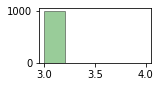

AvaluaAgent() Acabat


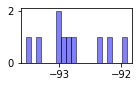


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_116
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1095..1379 -> 284-tiles track
Episodi 0: recompensa = 313.4276


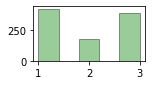

Track generation: 1122..1407 -> 285-tiles track
Episodi 1: recompensa = 56.3211


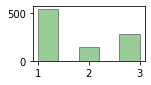

Track generation: 1224..1540 -> 316-tiles track
Episodi 2: recompensa = 214.2857


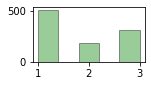

Track generation: 990..1245 -> 255-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1288..1615 -> 327-tiles track
Episodi 3: recompensa = 20.6215


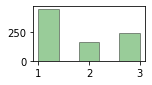

Track generation: 1145..1442 -> 297-tiles track
Episodi 4: recompensa = 139.8649


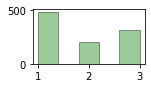

Track generation: 1212..1519 -> 307-tiles track
Episodi 5: recompensa = 56.8627


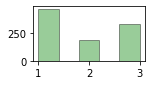

Track generation: 1020..1279 -> 259-tiles track
Episodi 6: recompensa = 400.0


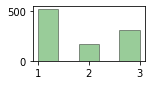

Track generation: 1054..1327 -> 273-tiles track
Episodi 7: recompensa = 116.9118


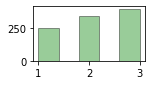

Track generation: 1193..1497 -> 304-tiles track
Episodi 8: recompensa = 147.5248


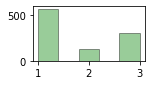

Track generation: 1150..1442 -> 292-tiles track
Episodi 9: recompensa = 422.3368


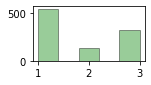

AvaluaAgent() Acabat


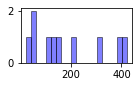


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_117
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 986..1242 -> 256-tiles track
Episodi 0: recompensa = -92.1569


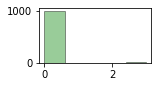

Track generation: 1099..1378 -> 279-tiles track
Episodi 1: recompensa = -92.8058


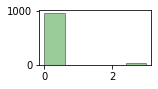

Track generation: 1337..1675 -> 338-tiles track
Episodi 2: recompensa = -94.0653


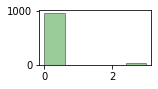

Track generation: 1197..1500 -> 303-tiles track
Episodi 3: recompensa = -93.3775


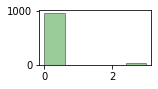

Track generation: 1212..1519 -> 307-tiles track
Episodi 4: recompensa = -93.4641


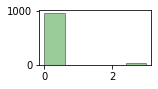

Track generation: 1204..1509 -> 305-tiles track
Episodi 5: recompensa = -93.4211


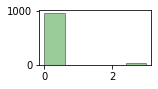

Track generation: 1127..1413 -> 286-tiles track
Episodi 6: recompensa = -92.9825


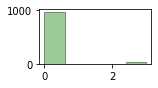

Track generation: 1213..1525 -> 312-tiles track
Episodi 7: recompensa = -93.5691


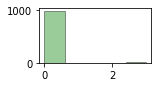

Track generation: 1205..1510 -> 305-tiles track
Episodi 8: recompensa = -93.4211


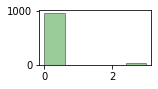

Track generation: 1055..1331 -> 276-tiles track
Episodi 9: recompensa = -92.7273


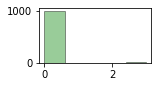

AvaluaAgent() Acabat


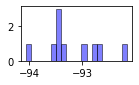


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_118
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1179..1478 -> 299-tiles track
Episodi 0: recompensa = -93.2886


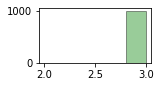

Track generation: 1280..1604 -> 324-tiles track
Episodi 1: recompensa = -93.808


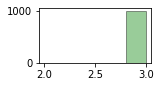

Track generation: 1127..1413 -> 286-tiles track
Episodi 2: recompensa = -92.9825


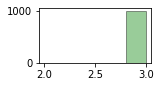

Track generation: 1117..1400 -> 283-tiles track
Episodi 3: recompensa = -92.9078


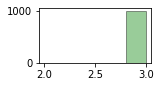

Track generation: 1208..1514 -> 306-tiles track
Episodi 4: recompensa = -93.4426


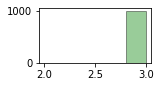

Track generation: 1134..1421 -> 287-tiles track
Episodi 5: recompensa = -93.007


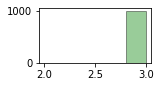

Track generation: 1051..1321 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1093..1379 -> 286-tiles track
Episodi 6: recompensa = -92.9825


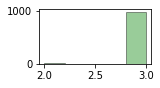

Track generation: 1280..1604 -> 324-tiles track
Episodi 7: recompensa = -93.808


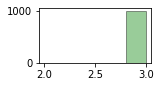

Track generation: 1052..1319 -> 267-tiles track
Episodi 8: recompensa = -92.4812


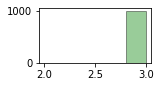

Track generation: 1140..1429 -> 289-tiles track
Episodi 9: recompensa = -93.0556


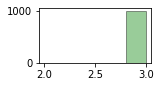

AvaluaAgent() Acabat


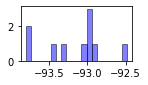


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_119
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1198..1502 -> 304-tiles track
Episodi 0: recompensa = -93.3993


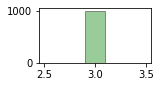

Track generation: 1220..1529 -> 309-tiles track
Episodi 1: recompensa = -93.5065


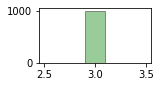

Track generation: 1131..1418 -> 287-tiles track
Episodi 2: recompensa = -93.007


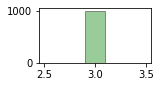

Track generation: 1095..1373 -> 278-tiles track
Episodi 3: recompensa = -92.7798


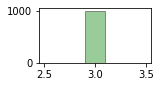

Track generation: 1293..1630 -> 337-tiles track
Episodi 4: recompensa = -94.0476


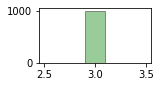

Track generation: 1170..1467 -> 297-tiles track
Episodi 5: recompensa = -93.2432


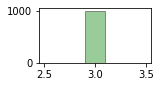

Track generation: 1162..1459 -> 297-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1116..1399 -> 283-tiles track
Episodi 6: recompensa = -92.9078


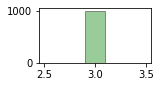

Track generation: 1071..1343 -> 272-tiles track
Episodi 7: recompensa = -92.6199


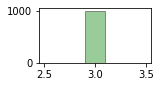

Track generation: 1083..1361 -> 278-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1265..1592 -> 327-tiles track
Episodi 8: recompensa = 191.411


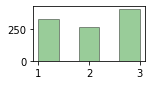

Track generation: 1031..1292 -> 261-tiles track
Episodi 9: recompensa = -92.3077


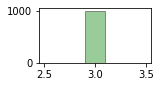

AvaluaAgent() Acabat


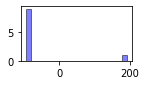


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_120
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1258..1576 -> 318-tiles track
Episodi 0: recompensa = -93.6909


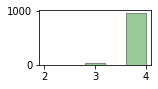

Track generation: 1264..1584 -> 320-tiles track
Episodi 1: recompensa = -93.7304


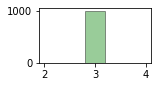

Track generation: 1172..1469 -> 297-tiles track
Episodi 2: recompensa = -93.2432


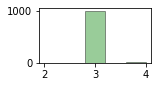

Track generation: 1135..1423 -> 288-tiles track
Episodi 3: recompensa = -93.0314


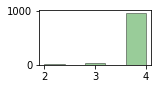

Track generation: 1238..1559 -> 321-tiles track
Episodi 4: recompensa = -93.75


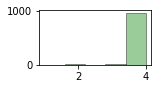

Track generation: 1246..1563 -> 317-tiles track
Episodi 5: recompensa = -93.6709


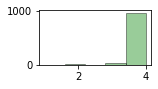

Track generation: 1074..1348 -> 274-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1115..1398 -> 283-tiles track
Episodi 6: recompensa = -92.9078


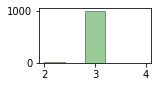

Track generation: 1081..1360 -> 279-tiles track
Episodi 7: recompensa = -92.8058


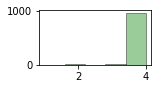

Track generation: 1084..1359 -> 275-tiles track
Episodi 8: recompensa = -92.7007


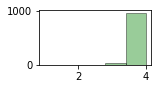

Track generation: 1050..1324 -> 274-tiles track
Episodi 9: recompensa = -92.674


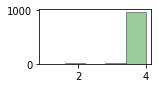

AvaluaAgent() Acabat


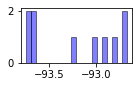


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_121
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1148..1439 -> 291-tiles track
Episodi 0: recompensa = -93.1034


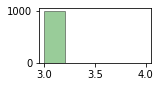

Track generation: 1189..1490 -> 301-tiles track
Episodi 1: recompensa = -93.3333


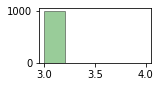

Track generation: 988..1239 -> 251-tiles track
Episodi 2: recompensa = -92.0


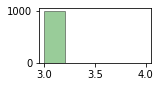

Track generation: 1273..1596 -> 323-tiles track
Episodi 3: recompensa = -93.7888


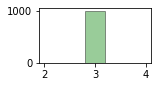

Track generation: 1294..1622 -> 328-tiles track
Episodi 4: recompensa = -93.8838


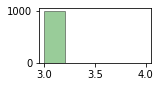

Track generation: 1255..1572 -> 317-tiles track
Episodi 5: recompensa = -93.6709


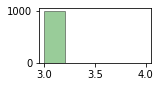

Track generation: 1008..1271 -> 263-tiles track
Episodi 6: recompensa = -92.3664


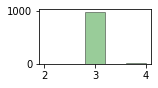

Track generation: 1110..1400 -> 290-tiles track
Episodi 7: recompensa = -93.0796


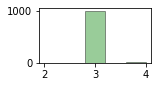

Track generation: 1303..1632 -> 329-tiles track
Episodi 8: recompensa = -93.9024


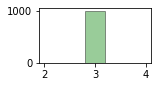

Track generation: 1137..1433 -> 296-tiles track
Episodi 9: recompensa = -93.2203


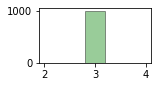

AvaluaAgent() Acabat


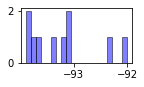


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_122
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1275..1598 -> 323-tiles track
Episodi 0: recompensa = 238.5093


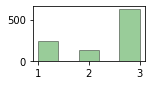

Track generation: 1010..1266 -> 256-tiles track
Episodi 1: recompensa = -92.1569


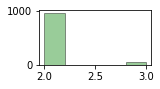

Track generation: 1052..1319 -> 267-tiles track
Episodi 2: recompensa = -92.4812


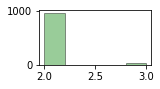

Track generation: 1093..1370 -> 277-tiles track
Episodi 3: recompensa = -92.7536


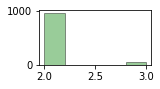

Track generation: 1223..1533 -> 310-tiles track
Episodi 4: recompensa = -93.5275


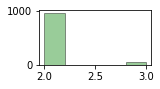

Track generation: 1143..1433 -> 290-tiles track
Episodi 5: recompensa = -93.0796


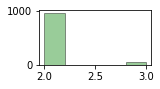

Track generation: 1084..1359 -> 275-tiles track
Episodi 6: recompensa = -92.7007


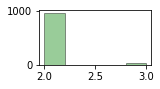

Track generation: 1208..1514 -> 306-tiles track
Episodi 7: recompensa = -93.4426


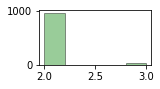

Track generation: 1175..1473 -> 298-tiles track
Episodi 8: recompensa = 580.1347


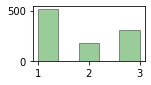

Track generation: 1092..1370 -> 278-tiles track
Episodi 9: recompensa = -92.7798


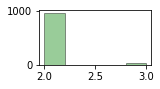

AvaluaAgent() Acabat


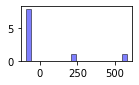


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_123
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1184..1491 -> 307-tiles track
Episodi 0: recompensa = -93.4641


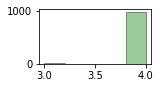

Track generation: 1289..1615 -> 326-tiles track
Episodi 1: recompensa = -93.8462


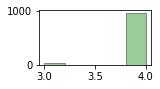

Track generation: 1163..1458 -> 295-tiles track
Episodi 2: recompensa = -93.1973


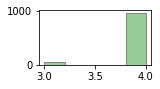

Track generation: 1051..1318 -> 267-tiles track
Episodi 3: recompensa = -92.4812


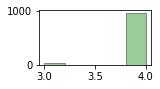

Track generation: 1235..1548 -> 313-tiles track
Episodi 4: recompensa = -93.5897


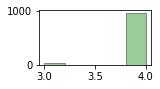

Track generation: 1219..1528 -> 309-tiles track
Episodi 5: recompensa = -93.5065


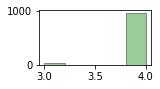

Track generation: 1119..1403 -> 284-tiles track
Episodi 6: recompensa = -92.9329


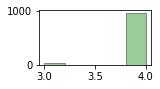

Track generation: 1134..1425 -> 291-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1156..1449 -> 293-tiles track
Episodi 7: recompensa = -93.1507


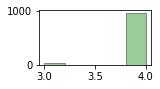

Track generation: 1245..1561 -> 316-tiles track
Episodi 8: recompensa = -93.6508


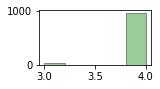

Track generation: 1095..1373 -> 278-tiles track
Episodi 9: recompensa = -92.7798


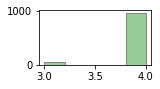

AvaluaAgent() Acabat


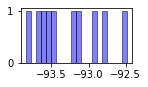


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_124
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1071..1343 -> 272-tiles track
Episodi 0: recompensa = -92.6199


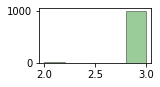

Track generation: 1214..1525 -> 311-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1203..1508 -> 305-tiles track
Episodi 1: recompensa = -93.4211


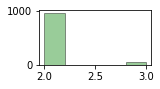

Track generation: 1184..1484 -> 300-tiles track
Episodi 2: recompensa = -93.311


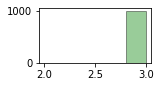

Track generation: 1063..1335 -> 272-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1024..1286 -> 262-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1231..1543 -> 312-tiles track
Episodi 3: recompensa = -93.5691


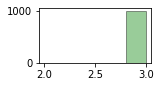

Track generation: 1112..1394 -> 282-tiles track
Episodi 4: recompensa = -92.8826


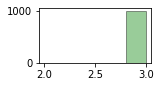

Track generation: 1158..1459 -> 301-tiles track
Episodi 5: recompensa = -93.3333


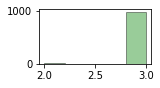

Track generation: 1104..1384 -> 280-tiles track
Episodi 6: recompensa = -92.8315


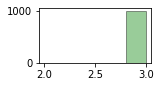

Track generation: 1120..1404 -> 284-tiles track
Episodi 7: recompensa = -92.9329


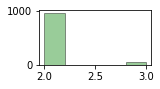

Track generation: 1010..1267 -> 257-tiles track
Episodi 8: recompensa = -92.1875


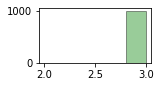

Track generation: 1204..1509 -> 305-tiles track
Episodi 9: recompensa = -93.4211


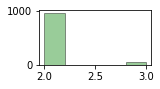

AvaluaAgent() Acabat


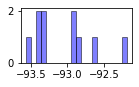


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_125
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1075..1348 -> 273-tiles track
Episodi 0: recompensa = 223.5294


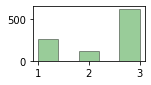

Track generation: 983..1233 -> 250-tiles track
Episodi 1: recompensa = 466.2651


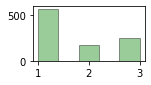

Track generation: 1121..1405 -> 284-tiles track
Episodi 2: recompensa = 165.0177


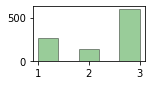

Track generation: 1167..1469 -> 302-tiles track
Episodi 3: recompensa = 275.4153


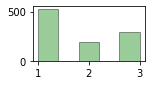

Track generation: 1234..1547 -> 313-tiles track
Episodi 4: recompensa = 182.0513


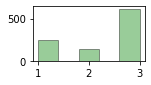

Track generation: 1048..1314 -> 266-tiles track
Episodi 5: recompensa = 190.917


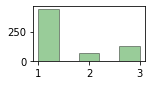

Track generation: 1071..1343 -> 272-tiles track
Episodi 6: recompensa = 223.614


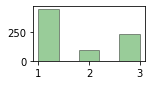

Track generation: 1188..1489 -> 301-tiles track
Episodi 7: recompensa = 400.0


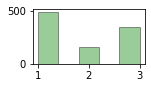

Track generation: 1108..1389 -> 281-tiles track
Episodi 8: recompensa = 292.8571


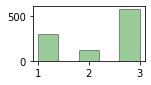

Track generation: 1176..1474 -> 298-tiles track
Episodi 9: recompensa = 243.4343


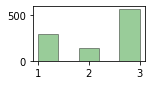

AvaluaAgent() Acabat


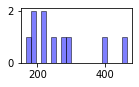


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_126
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1228..1539 -> 311-tiles track
Episodi 0: recompensa = 158.0645


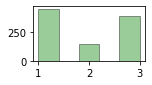

Track generation: 1268..1590 -> 322-tiles track
Episodi 1: recompensa = -12.7726


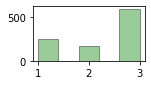

Track generation: 1155..1448 -> 293-tiles track
Episodi 2: recompensa = 54.1096


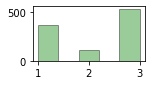

Track generation: 1148..1439 -> 291-tiles track
Episodi 3: recompensa = 89.6552


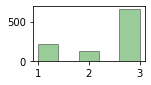

Track generation: 1227..1547 -> 320-tiles track
Episodi 4: recompensa = 88.0878


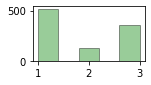

Track generation: 1220..1528 -> 308-tiles track
Episodi 5: recompensa = 141.0423


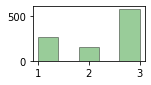

Track generation: 1067..1342 -> 275-tiles track
Episodi 6: recompensa = 283.2117


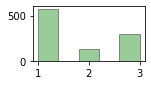

Track generation: 1184..1484 -> 300-tiles track
Episodi 7: recompensa = 204.3478


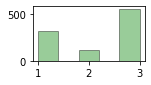

Track generation: 1124..1409 -> 285-tiles track
Episodi 8: recompensa = 269.7183


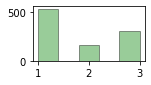

Track generation: 1248..1564 -> 316-tiles track
Episodi 9: recompensa = 134.9206


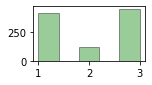

AvaluaAgent() Acabat


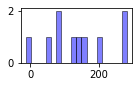


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_127
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1112..1394 -> 282-tiles track
Episodi 0: recompensa = -92.8826


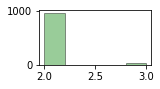

Track generation: 996..1249 -> 253-tiles track
Episodi 1: recompensa = -92.0635


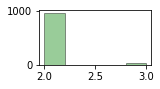

Track generation: 1356..1699 -> 343-tiles track
Episodi 2: recompensa = -94.152


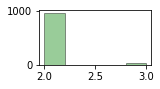

Track generation: 1171..1468 -> 297-tiles track
Episodi 3: recompensa = -93.2432


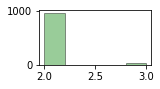

Track generation: 1194..1497 -> 303-tiles track
Episodi 4: recompensa = -93.3775


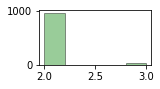

Track generation: 1271..1593 -> 322-tiles track
Episodi 5: recompensa = -93.7695


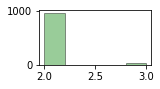

Track generation: 1173..1470 -> 297-tiles track
Episodi 6: recompensa = -93.2432


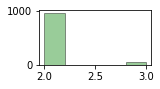

Track generation: 1158..1452 -> 294-tiles track
Episodi 7: recompensa = -93.1741


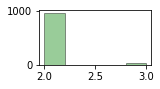

Track generation: 1172..1469 -> 297-tiles track
Episodi 8: recompensa = -93.2432


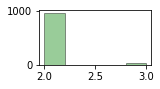

Track generation: 1087..1363 -> 276-tiles track
Episodi 9: recompensa = -92.7273


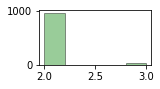

AvaluaAgent() Acabat


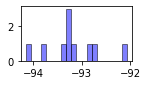


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_128
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1148..1439 -> 291-tiles track
Episodi 0: recompensa = -93.1034


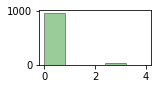

Track generation: 1134..1422 -> 288-tiles track
Episodi 1: recompensa = -93.0314


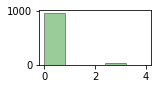

Track generation: 1153..1445 -> 292-tiles track
Episodi 2: recompensa = -93.1271


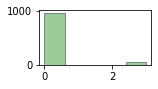

Track generation: 1277..1600 -> 323-tiles track
Episodi 3: recompensa = -93.7888


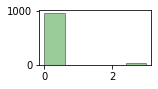

Track generation: 1227..1538 -> 311-tiles track
Episodi 4: recompensa = -93.5484


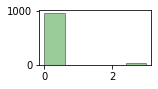

Track generation: 1095..1379 -> 284-tiles track
Episodi 5: recompensa = -1.0601


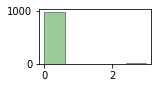

Track generation: 1148..1439 -> 291-tiles track
Episodi 6: recompensa = -93.1034


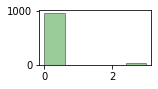

Track generation: 1160..1454 -> 294-tiles track
Episodi 7: recompensa = -93.1741


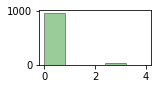

Track generation: 1316..1649 -> 333-tiles track
Episodi 8: recompensa = -93.9759


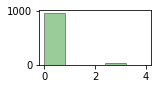

Track generation: 1109..1390 -> 281-tiles track
Episodi 9: recompensa = -92.8571


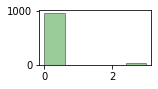

AvaluaAgent() Acabat


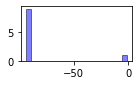


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_129
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1206..1512 -> 306-tiles track
Episodi 0: recompensa = 513.1148


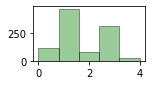

Track generation: 1182..1487 -> 305-tiles track
Episodi 1: recompensa = 294.7368


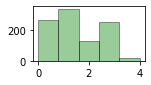

Track generation: 1131..1418 -> 287-tiles track
Episodi 2: recompensa = 354.5455


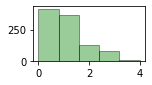

Track generation: 981..1234 -> 253-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1196..1499 -> 303-tiles track
Episodi 3: recompensa = 221.1921


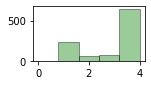

Track generation: 1092..1369 -> 277-tiles track
Episodi 4: recompensa = 244.2029


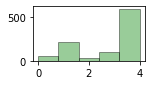

Track generation: 1165..1462 -> 297-tiles track
Episodi 5: recompensa = 180.4054


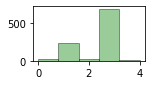

Track generation: 1064..1334 -> 270-tiles track
Episodi 6: recompensa = 773.6059


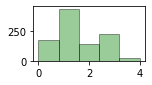

Track generation: 1104..1385 -> 281-tiles track
Episodi 7: recompensa = 350.0


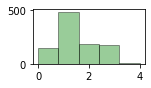

Track generation: 1049..1317 -> 268-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1145..1438 -> 293-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1038..1308 -> 270-tiles track
Episodi 8: recompensa = 401.8587


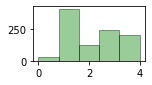

Track generation: 1199..1503 -> 304-tiles track
Episodi 9: recompensa = 233.3333


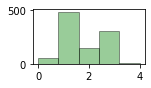

AvaluaAgent() Acabat


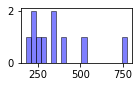


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_130
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1151..1443 -> 292-tiles track
Episodi 0: recompensa = -93.1271


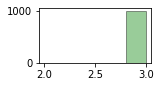

Track generation: 1316..1649 -> 333-tiles track
Episodi 1: recompensa = -93.9759


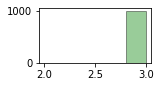

Track generation: 983..1241 -> 258-tiles track
Episodi 2: recompensa = -92.2179


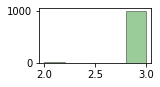

Track generation: 1111..1393 -> 282-tiles track
Episodi 3: recompensa = -92.8826


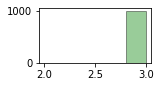

Track generation: 1113..1402 -> 289-tiles track
Episodi 4: recompensa = -93.0556


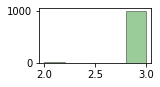

Track generation: 1159..1461 -> 302-tiles track
Episodi 5: recompensa = -93.3555


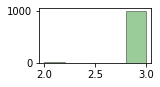

Track generation: 1233..1545 -> 312-tiles track
Episodi 6: recompensa = -93.5691


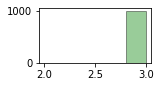

Track generation: 1159..1454 -> 295-tiles track
Episodi 7: recompensa = -93.1973


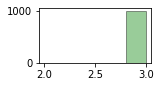

Track generation: 1272..1594 -> 322-tiles track
Episodi 8: recompensa = -93.7695


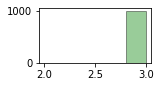

Track generation: 1167..1463 -> 296-tiles track
Episodi 9: recompensa = -93.2203


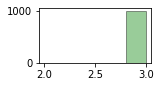

AvaluaAgent() Acabat


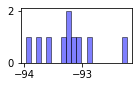


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_131
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1039..1309 -> 270-tiles track
Episodi 0: recompensa = 372.119


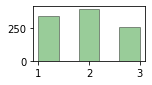

Track generation: 1164..1459 -> 295-tiles track
Episodi 1: recompensa = 206.1224


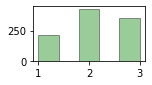

Track generation: 1176..1474 -> 298-tiles track
Episodi 2: recompensa = 236.7003


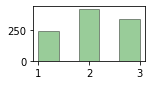

Track generation: 1108..1389 -> 281-tiles track
Episodi 3: recompensa = 232.1429


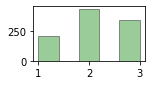

Track generation: 1271..1593 -> 322-tiles track
Episodi 4: recompensa = 678.8162


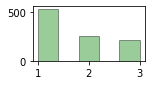

Track generation: 1064..1334 -> 270-tiles track
Episodi 5: recompensa = 416.7286


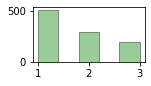

Track generation: 1203..1516 -> 313-tiles track
Episodi 6: recompensa = 268.5897


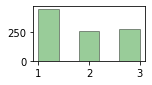

Track generation: 1118..1402 -> 284-tiles track
Episodi 7: recompensa = 306.3604


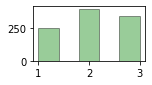

Track generation: 1096..1374 -> 278-tiles track
Episodi 8: recompensa = 358.4838


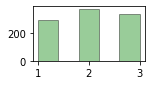

Track generation: 1180..1479 -> 299-tiles track
Episodi 9: recompensa = 359.7315


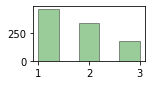

AvaluaAgent() Acabat


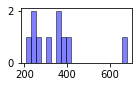


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_132
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1012..1273 -> 261-tiles track
Episodi 0: recompensa = 330.7692


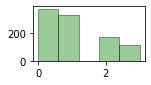

Track generation: 1359..1703 -> 344-tiles track
Episodi 1: recompensa = 334.4023


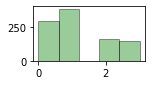

Track generation: 1199..1503 -> 304-tiles track
Episodi 2: recompensa = 550.165


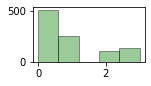

Track generation: 1391..1743 -> 352-tiles track
Episodi 3: recompensa = 187.7493


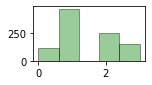

Track generation: 1168..1465 -> 297-tiles track
Episodi 4: recompensa = 545.2703


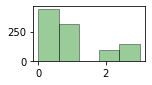

Track generation: 1124..1409 -> 285-tiles track
Episodi 5: recompensa = 19.7183


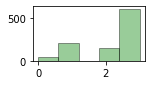

Track generation: 1194..1496 -> 302-tiles track
Episodi 6: recompensa = 72.7575


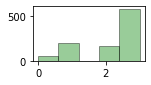

Track generation: 1023..1289 -> 266-tiles track
Episodi 7: recompensa = 443.3962


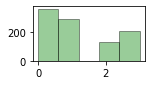

Track generation: 1092..1369 -> 277-tiles track
Episodi 8: recompensa = 443.4783


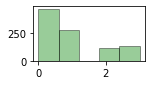

Track generation: 1149..1440 -> 291-tiles track
Episodi 9: recompensa = 441.3793


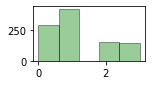

AvaluaAgent() Acabat


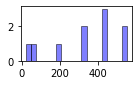


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_133
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1154..1451 -> 297-tiles track
Episodi 0: recompensa = -93.2432


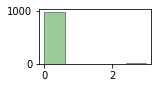

Track generation: 1057..1332 -> 275-tiles track
Episodi 1: recompensa = -92.7007


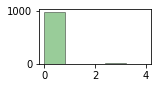

Track generation: 1015..1276 -> 261-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1087..1363 -> 276-tiles track
Episodi 2: recompensa = -92.7273


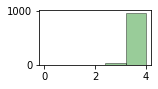

Track generation: 1157..1450 -> 293-tiles track
Episodi 3: recompensa = -82.8767


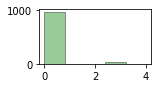

Track generation: 1178..1477 -> 299-tiles track
Episodi 4: recompensa = -93.2886


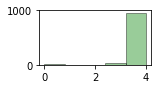

Track generation: 1208..1514 -> 306-tiles track
Episodi 5: recompensa = -93.4426


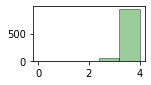

Track generation: 1203..1508 -> 305-tiles track
Episodi 6: recompensa = -93.4211


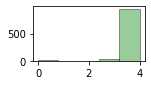

Track generation: 962..1213 -> 251-tiles track
Episodi 7: recompensa = -92.0


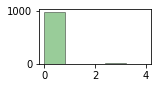

Track generation: 1136..1424 -> 288-tiles track
Episodi 8: recompensa = -82.5784


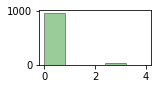

Track generation: 1151..1443 -> 292-tiles track
Episodi 9: recompensa = -93.1271


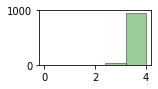

AvaluaAgent() Acabat


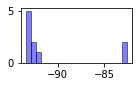


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_134
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1123..1408 -> 285-tiles track
Episodi 0: recompensa = -92.9577


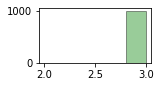

Track generation: 1207..1513 -> 306-tiles track
Episodi 1: recompensa = -93.4426


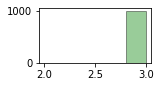

Track generation: 1263..1583 -> 320-tiles track
Episodi 2: recompensa = -93.7304


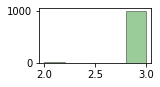

Track generation: 1187..1488 -> 301-tiles track
Episodi 3: recompensa = -93.3333


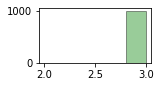

Track generation: 1109..1396 -> 287-tiles track
Episodi 4: recompensa = -93.007


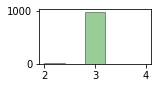

Track generation: 1236..1549 -> 313-tiles track
Episodi 5: recompensa = -93.5897


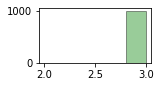

Track generation: 1136..1424 -> 288-tiles track
Episodi 6: recompensa = -93.0314


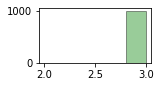

Track generation: 1077..1350 -> 273-tiles track
Episodi 7: recompensa = -92.6471


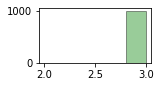

Track generation: 1090..1367 -> 277-tiles track
Episodi 8: recompensa = -92.7536


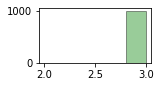

Track generation: 1111..1393 -> 282-tiles track
Episodi 9: recompensa = -92.8826


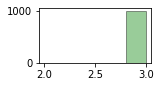

AvaluaAgent() Acabat


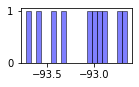


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_135
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1252..1569 -> 317-tiles track
Episodi 0: recompensa = -93.6709


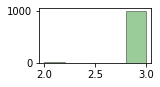

Track generation: 1137..1425 -> 288-tiles track
Episodi 1: recompensa = -93.0314


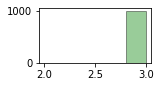

Track generation: 1126..1411 -> 285-tiles track
Episodi 2: recompensa = -92.9577


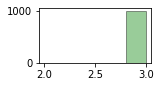

Track generation: 1141..1436 -> 295-tiles track
Episodi 3: recompensa = -93.1973


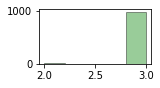

Track generation: 1169..1473 -> 304-tiles track
Episodi 4: recompensa = -93.3993


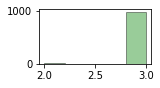

Track generation: 1403..1758 -> 355-tiles track
Episodi 5: recompensa = -94.3503


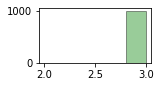

Track generation: 1112..1394 -> 282-tiles track
Episodi 6: recompensa = -92.8826


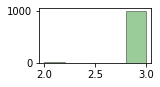

Track generation: 940..1183 -> 243-tiles track
Episodi 7: recompensa = -91.7355


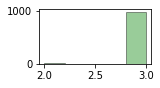

Track generation: 1163..1465 -> 302-tiles track
Episodi 8: recompensa = -93.3555


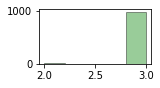

Track generation: 1004..1259 -> 255-tiles track
Episodi 9: recompensa = -92.126


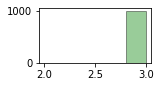

AvaluaAgent() Acabat


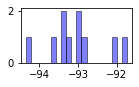


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_136
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1044..1309 -> 265-tiles track
Episodi 0: recompensa = 214.3939


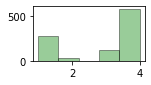

Track generation: 1352..1694 -> 342-tiles track
Episodi 1: recompensa = 23.1672


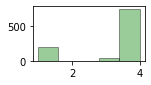

Track generation: 1136..1424 -> 288-tiles track
Episodi 2: recompensa = 269.338


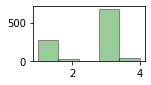

Track generation: 1227..1538 -> 311-tiles track
Episodi 3: recompensa = 122.5806


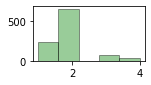

Track generation: 1054..1326 -> 272-tiles track
Episodi 4: recompensa = 14.3911


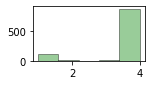

Track generation: 1126..1412 -> 286-tiles track
Episodi 5: recompensa = 117.5439


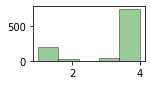

Track generation: 1130..1423 -> 293-tiles track
Episodi 6: recompensa = 36.9863


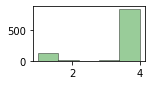

Track generation: 1068..1339 -> 271-tiles track
Episodi 7: recompensa = 214.8148


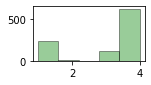

Track generation: 1176..1474 -> 298-tiles track
Episodi 8: recompensa = 233.3333


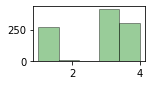

Track generation: 1119..1407 -> 288-tiles track
Episodi 9: recompensa = 11.4983


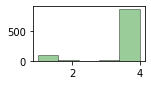

AvaluaAgent() Acabat


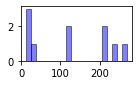


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_137
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1167..1463 -> 296-tiles track
Episodi 0: recompensa = 167.7966


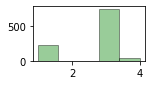

Track generation: 1147..1446 -> 299-tiles track
Episodi 1: recompensa = -83.2215


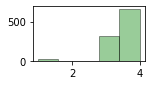

Track generation: 1123..1408 -> 285-tiles track
Episodi 2: recompensa = 51.4085


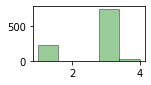

Track generation: 1100..1379 -> 279-tiles track
Episodi 3: recompensa = 331.6547


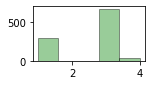

Track generation: 1112..1400 -> 288-tiles track
Episodi 4: recompensa = -75.6098


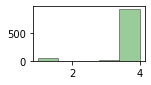

Track generation: 922..1163 -> 241-tiles track
Episodi 5: recompensa = -75.0


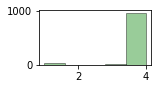

Track generation: 1135..1423 -> 288-tiles track
Episodi 6: recompensa = 234.4948


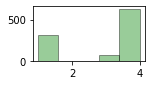

Track generation: 1135..1429 -> 294-tiles track
Episodi 7: recompensa = -72.6962


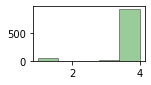

Track generation: 1132..1419 -> 287-tiles track
Episodi 8: recompensa = 39.8601


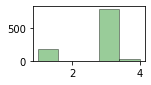

Track generation: 1315..1658 -> 343-tiles track
Episodi 9: recompensa = -23.9766


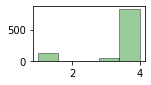

AvaluaAgent() Acabat


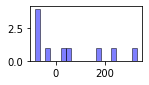


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_138
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1213..1520 -> 307-tiles track
Episodi 0: recompensa = -93.4641


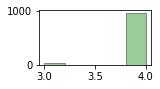

Track generation: 1154..1446 -> 292-tiles track
Episodi 1: recompensa = -93.1271


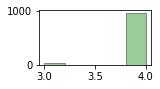

Track generation: 1314..1647 -> 333-tiles track
Episodi 2: recompensa = -93.9759


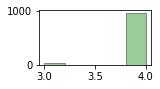

Track generation: 1101..1390 -> 289-tiles track
Episodi 3: recompensa = -93.0556


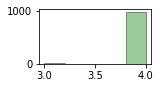

Track generation: 1212..1519 -> 307-tiles track
Episodi 4: recompensa = -93.4641


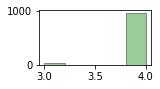

Track generation: 1015..1273 -> 258-tiles track
Episodi 5: recompensa = -92.2179


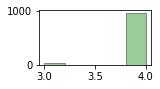

Track generation: 1136..1424 -> 288-tiles track
Episodi 6: recompensa = -93.0314


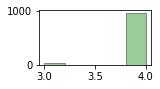

Track generation: 1163..1458 -> 295-tiles track
Episodi 7: recompensa = -93.1973


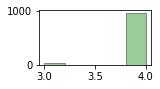

Track generation: 1177..1475 -> 298-tiles track
Episodi 8: recompensa = -93.266


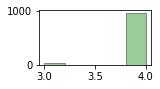

Track generation: 1049..1315 -> 266-tiles track
Episodi 9: recompensa = -92.4528


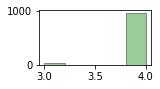

AvaluaAgent() Acabat


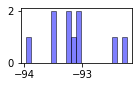


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_139
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1363..1707 -> 344-tiles track
Episodi 0: recompensa = -94.1691


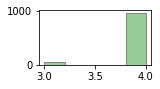

Track generation: 1110..1391 -> 281-tiles track
Episodi 1: recompensa = -92.8571


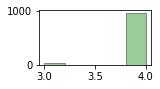

Track generation: 1265..1587 -> 322-tiles track
Episodi 2: recompensa = -93.7695


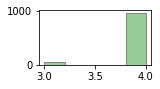

Track generation: 1271..1593 -> 322-tiles track
Episodi 3: recompensa = -93.7695


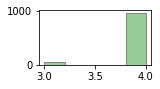

Track generation: 1305..1635 -> 330-tiles track
Episodi 4: recompensa = -93.921


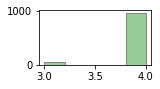

Track generation: 1117..1400 -> 283-tiles track
Episodi 5: recompensa = -92.9078


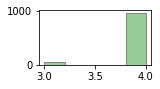

Track generation: 966..1178 -> 212-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1156..1448 -> 292-tiles track
Episodi 6: recompensa = -93.1271


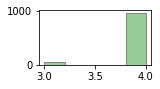

Track generation: 1181..1481 -> 300-tiles track
Episodi 7: recompensa = -93.311


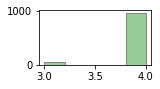

Track generation: 1140..1426 -> 286-tiles track
Episodi 8: recompensa = -92.9825


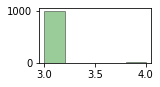

Track generation: 1082..1357 -> 275-tiles track
Episodi 9: recompensa = -92.7007


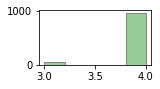

AvaluaAgent() Acabat


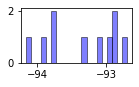


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_140
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1067..1338 -> 271-tiles track
Episodi 0: recompensa = -92.5926


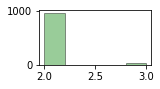

Track generation: 1000..1261 -> 261-tiles track
Episodi 1: recompensa = -92.3077


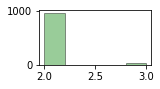

Track generation: 1177..1478 -> 301-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1091..1368 -> 277-tiles track
Episodi 2: recompensa = -92.7536


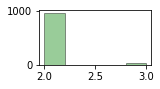

Track generation: 1219..1528 -> 309-tiles track
Episodi 3: recompensa = -93.5065


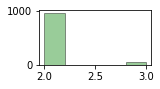

Track generation: 1151..1443 -> 292-tiles track
Episodi 4: recompensa = -93.1271


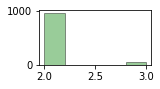

Track generation: 1119..1403 -> 284-tiles track
Episodi 5: recompensa = -92.9329


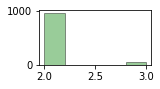

Track generation: 1029..1291 -> 262-tiles track
Episodi 6: recompensa = -92.3372


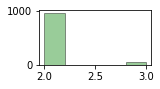

Track generation: 1120..1410 -> 290-tiles track
Episodi 7: recompensa = -93.0796


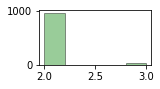

Track generation: 1104..1384 -> 280-tiles track
Episodi 8: recompensa = -92.8315


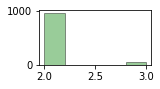

Track generation: 1206..1512 -> 306-tiles track
Episodi 9: recompensa = -93.4426


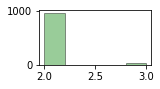

AvaluaAgent() Acabat


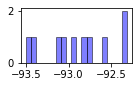


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_141
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1220..1530 -> 310-tiles track
Episodi 0: recompensa = 550.4854


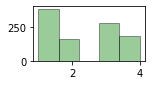

Track generation: 1307..1647 -> 340-tiles track
Episodi 1: recompensa = -82.3009


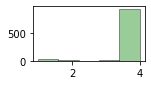

Track generation: 1162..1458 -> 296-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1231..1543 -> 312-tiles track
Episodi 2: recompensa = 385.5305


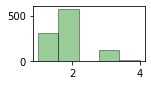

Track generation: 1319..1653 -> 334-tiles track
Episodi 3: recompensa = 644.7447


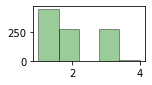

Track generation: 1144..1439 -> 295-tiles track
Episodi 4: recompensa = 590.4762


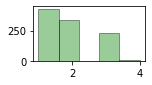

Track generation: 1242..1557 -> 315-tiles track
Episodi 5: recompensa = 294.9045


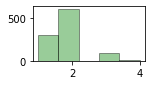

Track generation: 1142..1431 -> 289-tiles track
Episodi 6: recompensa = 459.0278


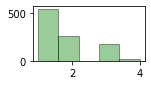

Track generation: 1472..1844 -> 372-tiles track
Episodi 7: recompensa = 290.8356


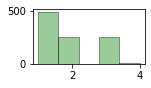

Track generation: 1172..1469 -> 297-tiles track
Episodi 8: recompensa = 575.6757


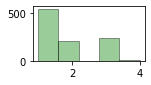

Track generation: 1112..1394 -> 282-tiles track
Episodi 9: recompensa = 309.2527


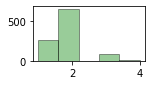

AvaluaAgent() Acabat


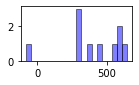


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_142
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1154..1453 -> 299-tiles track
Episodi 0: recompensa = 208.7248


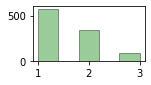

Track generation: 1182..1481 -> 299-tiles track
Episodi 1: recompensa = 248.9933


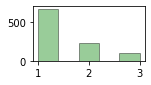

Track generation: 1073..1346 -> 273-tiles track
Episodi 2: recompensa = 109.5588


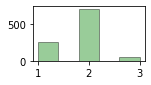

Track generation: 1254..1572 -> 318-tiles track
Episodi 3: recompensa = 221.7666


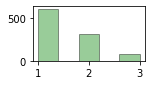

Track generation: 1117..1400 -> 283-tiles track
Episodi 4: recompensa = 80.8511


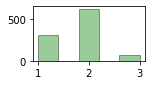

Track generation: 1203..1508 -> 305-tiles track
Episodi 5: recompensa = 94.0789


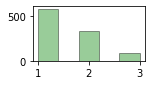

Track generation: 1061..1336 -> 275-tiles track
Episodi 6: recompensa = 264.9635


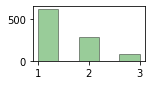

Track generation: 1147..1438 -> 291-tiles track
Episodi 7: recompensa = 151.7241


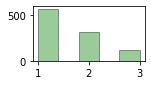

Track generation: 1044..1309 -> 265-tiles track
Episodi 8: recompensa = 131.0606


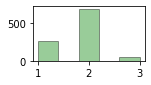

Track generation: 1219..1528 -> 309-tiles track
Episodi 9: recompensa = 140.2597


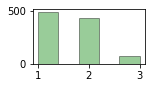

AvaluaAgent() Acabat


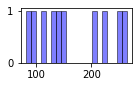


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_143
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1018..1279 -> 261-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1206..1522 -> 316-tiles track
Episodi 0: recompensa = -93.6508


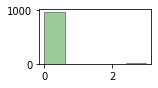

Track generation: 1144..1434 -> 290-tiles track
Episodi 1: recompensa = -93.0796


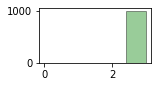

Track generation: 1319..1653 -> 334-tiles track
Episodi 2: recompensa = -93.994


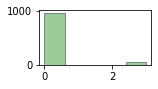

Track generation: 1086..1364 -> 278-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 958..1206 -> 248-tiles track
Episodi 3: recompensa = -91.9028


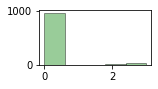

Track generation: 1097..1376 -> 279-tiles track
Episodi 4: recompensa = -92.8058


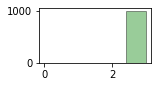

Track generation: 1013..1277 -> 264-tiles track
Episodi 5: recompensa = -92.3954


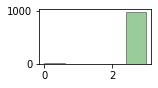

Track generation: 1239..1553 -> 314-tiles track
Episodi 6: recompensa = -93.6102


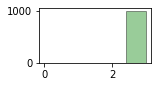

Track generation: 1109..1390 -> 281-tiles track
Episodi 7: recompensa = -92.8571


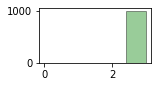

Track generation: 1088..1373 -> 285-tiles track
Episodi 8: recompensa = -92.9577


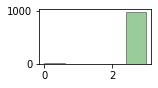

Track generation: 1179..1480 -> 301-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1248..1564 -> 316-tiles track
Episodi 9: recompensa = -93.6508


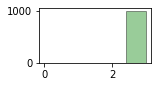

AvaluaAgent() Acabat


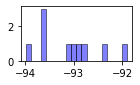


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_144
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1243..1558 -> 315-tiles track
Episodi 0: recompensa = -1.2739


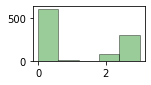

Track generation: 1164..1459 -> 295-tiles track
Episodi 1: recompensa = -14.966


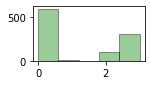

Track generation: 1204..1520 -> 316-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1176..1474 -> 298-tiles track
Episodi 2: recompensa = -15.8249


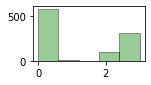

Track generation: 1160..1454 -> 294-tiles track
Episodi 3: recompensa = -4.4369


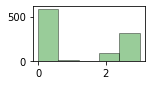

Track generation: 1195..1498 -> 303-tiles track
Episodi 4: recompensa = -3.9735


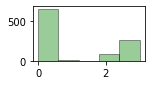

Track generation: 1332..1669 -> 337-tiles track
Episodi 5: recompensa = -10.7143


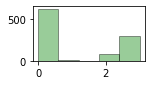

Track generation: 1128..1414 -> 286-tiles track
Episodi 6: recompensa = -12.2807


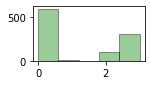

Track generation: 1035..1298 -> 263-tiles track
Episodi 7: recompensa = -4.5802


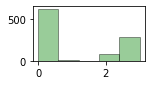

Track generation: 1064..1343 -> 279-tiles track
Episodi 8: recompensa = 11.5108


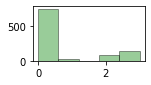

Track generation: 1272..1594 -> 322-tiles track
Episodi 9: recompensa = -12.7726


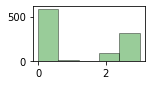

AvaluaAgent() Acabat


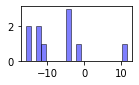


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_145
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1179..1478 -> 299-tiles track
Episodi 0: recompensa = -93.2886


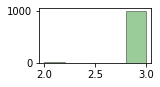

Track generation: 963..1213 -> 250-tiles track
Episodi 1: recompensa = 478.3133


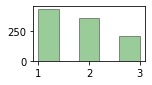

Track generation: 989..1240 -> 251-tiles track
Episodi 2: recompensa = -92.0


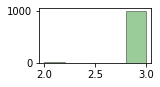

Track generation: 1056..1332 -> 276-tiles track
Episodi 3: recompensa = 474.5455


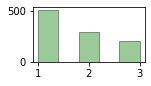

Track generation: 1077..1355 -> 278-tiles track
Episodi 4: recompensa = 455.9567


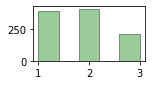

Track generation: 1179..1478 -> 299-tiles track
Episodi 5: recompensa = -93.2886


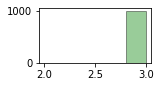

Track generation: 1226..1537 -> 311-tiles track
Episodi 6: recompensa = -93.5484


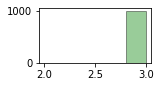

Track generation: 1249..1573 -> 324-tiles track
Episodi 7: recompensa = 187.9257


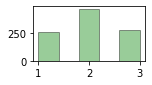

Track generation: 1126..1412 -> 286-tiles track
Episodi 8: recompensa = -92.9825


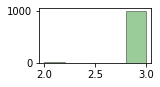

Track generation: 1189..1490 -> 301-tiles track
Episodi 9: recompensa = -93.3333


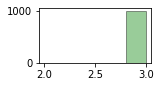

AvaluaAgent() Acabat


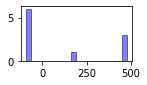


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_146
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1096..1378 -> 282-tiles track
Episodi 0: recompensa = -92.8826


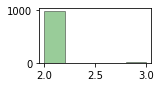

Track generation: 1104..1384 -> 280-tiles track
Episodi 1: recompensa = -92.8315


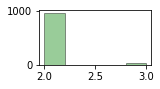

Track generation: 1045..1314 -> 269-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1108..1389 -> 281-tiles track
Episodi 2: recompensa = -92.8571


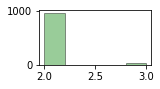

Track generation: 1199..1503 -> 304-tiles track
Episodi 3: recompensa = -93.3993


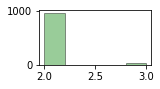

Track generation: 951..1197 -> 246-tiles track
Episodi 4: recompensa = -91.8367


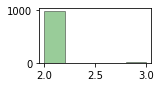

Track generation: 1282..1607 -> 325-tiles track
Episodi 5: recompensa = -93.8272


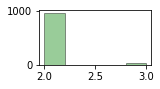

Track generation: 1216..1524 -> 308-tiles track
Episodi 6: recompensa = -93.4853


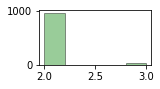

Track generation: 1248..1564 -> 316-tiles track
Episodi 7: recompensa = -93.6508


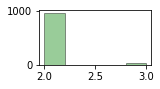

Track generation: 1092..1369 -> 277-tiles track
Episodi 8: recompensa = -92.7536


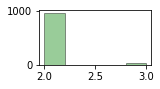

Track generation: 1091..1368 -> 277-tiles track
Episodi 9: recompensa = -92.7536


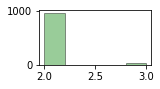

AvaluaAgent() Acabat


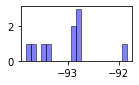


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_147
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1316..1649 -> 333-tiles track
Episodi 0: recompensa = -93.9759


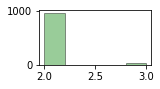

Track generation: 1108..1389 -> 281-tiles track
Episodi 1: recompensa = -92.8571


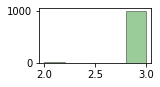

Track generation: 1178..1476 -> 298-tiles track
Episodi 2: recompensa = -93.266


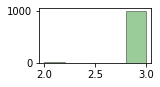

Track generation: 1160..1454 -> 294-tiles track
Episodi 3: recompensa = -93.1741


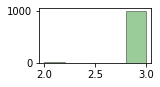

Track generation: 1046..1311 -> 265-tiles track
Episodi 4: recompensa = -92.4242


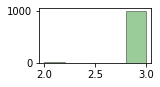

Track generation: 1085..1363 -> 278-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1087..1363 -> 276-tiles track
Episodi 5: recompensa = -92.7273


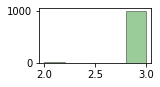

Track generation: 1092..1369 -> 277-tiles track
Episodi 6: recompensa = -92.7536


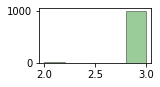

Track generation: 1058..1328 -> 270-tiles track
Episodi 7: recompensa = -92.5651


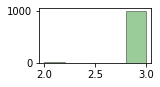

Track generation: 994..1249 -> 255-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1141..1430 -> 289-tiles track
Episodi 8: recompensa = -93.0556


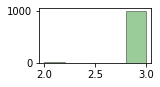

Track generation: 1184..1484 -> 300-tiles track
Episodi 9: recompensa = -93.311


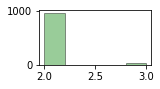

AvaluaAgent() Acabat


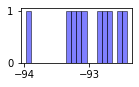


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_148
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1144..1434 -> 290-tiles track
Episodi 0: recompensa = 339.4464


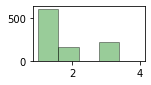

Track generation: 1075..1348 -> 273-tiles track
Episodi 1: recompensa = 352.2059


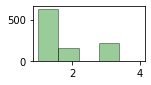

Track generation: 918..1158 -> 240-tiles track
Episodi 2: recompensa = 427.6469


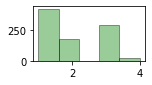

Track generation: 1098..1375 -> 277-tiles track
Episodi 3: recompensa = 302.1739


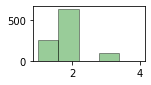

Track generation: 1127..1412 -> 285-tiles track
Episodi 4: recompensa = 484.507


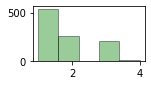

Track generation: 975..1227 -> 252-tiles track
Episodi 5: recompensa = 382.0717


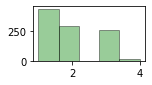

Track generation: 1284..1609 -> 325-tiles track
Episodi 6: recompensa = 230.2469


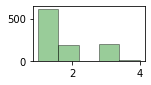

Track generation: 1123..1408 -> 285-tiles track
Episodi 7: recompensa = 178.169


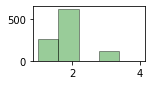

Track generation: 1096..1379 -> 283-tiles track
Episodi 8: recompensa = 286.5248


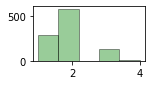

Track generation: 1078..1351 -> 273-tiles track
Episodi 9: recompensa = 344.8529


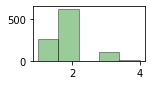

AvaluaAgent() Acabat


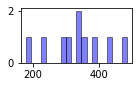


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_149
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1227..1538 -> 311-tiles track
Episodi 0: recompensa = -93.5484


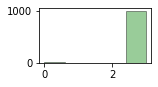

Track generation: 1224..1534 -> 310-tiles track
Episodi 1: recompensa = -93.5275


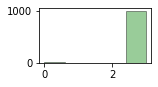

Track generation: 1180..1480 -> 300-tiles track
Episodi 2: recompensa = -93.311


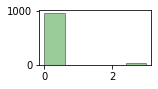

Track generation: 1206..1511 -> 305-tiles track
Episodi 3: recompensa = -93.4211


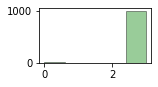

Track generation: 1363..1708 -> 345-tiles track
Episodi 4: recompensa = -94.186


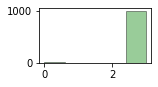

Track generation: 1189..1490 -> 301-tiles track
Episodi 5: recompensa = -93.3333


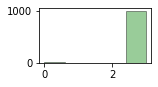

Track generation: 976..1232 -> 256-tiles track
Episodi 6: recompensa = -92.1569


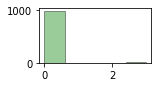

Track generation: 1224..1534 -> 310-tiles track
Episodi 7: recompensa = -93.5275


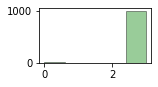

Track generation: 1203..1508 -> 305-tiles track
Episodi 8: recompensa = -93.4211


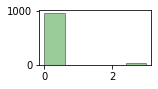

Track generation: 1199..1508 -> 309-tiles track
Episodi 9: recompensa = -93.5065


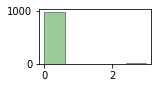

AvaluaAgent() Acabat


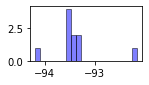


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_150
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1198..1501 -> 303-tiles track
Episodi 0: recompensa = -93.3775


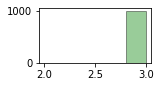

Track generation: 1093..1371 -> 278-tiles track
Episodi 1: recompensa = -92.7798


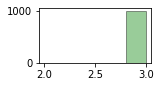

Track generation: 1060..1337 -> 277-tiles track
Episodi 2: recompensa = -92.7536


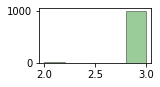

Track generation: 1228..1539 -> 311-tiles track
Episodi 3: recompensa = -93.5484


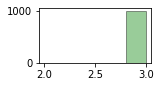

Track generation: 1339..1678 -> 339-tiles track
Episodi 4: recompensa = -94.0828


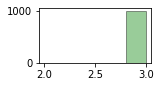

Track generation: 1172..1469 -> 297-tiles track
Episodi 5: recompensa = -93.2432


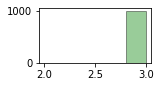

Track generation: 1142..1432 -> 290-tiles track
Episodi 6: recompensa = -93.0796


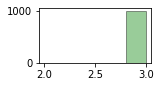

Track generation: 1130..1421 -> 291-tiles track
Episodi 7: recompensa = -93.1034


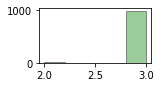

Track generation: 1095..1373 -> 278-tiles track
Episodi 8: recompensa = -92.7798


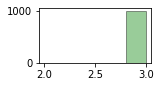

Track generation: 1203..1508 -> 305-tiles track
Episodi 9: recompensa = -93.4211


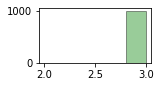

AvaluaAgent() Acabat


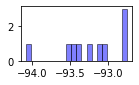


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_151
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1099..1380 -> 281-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 892..1124 -> 232-tiles track
Episodi 0: recompensa = -91.342


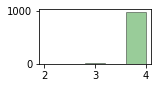

Track generation: 1128..1414 -> 286-tiles track
Episodi 1: recompensa = -92.9825


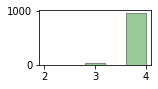

Track generation: 1124..1409 -> 285-tiles track
Episodi 2: recompensa = -92.9577


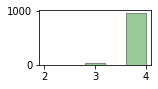

Track generation: 1244..1559 -> 315-tiles track
Episodi 3: recompensa = -93.6306


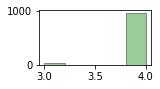

Track generation: 1058..1326 -> 268-tiles track
Episodi 4: recompensa = -92.5094


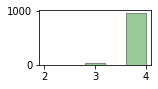

Track generation: 879..1108 -> 229-tiles track
Episodi 5: recompensa = -91.2281


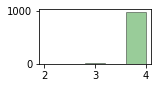

Track generation: 1136..1424 -> 288-tiles track
Episodi 6: recompensa = -93.0314


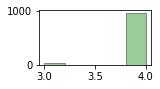

Track generation: 1133..1420 -> 287-tiles track
Episodi 7: recompensa = -93.007


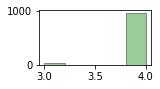

Track generation: 1135..1423 -> 288-tiles track
Episodi 8: recompensa = -93.0314


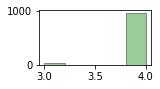

Track generation: 1147..1446 -> 299-tiles track
Episodi 9: recompensa = -93.2886


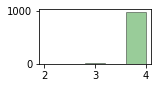

AvaluaAgent() Acabat


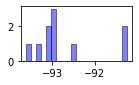


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_152
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1160..1454 -> 294-tiles track
Episodi 0: recompensa = -93.1741


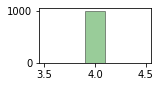

Track generation: 1230..1541 -> 311-tiles track
Episodi 1: recompensa = -93.5484


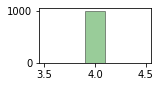

Track generation: 1122..1407 -> 285-tiles track
Episodi 2: recompensa = -92.9577


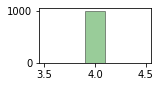

Track generation: 1108..1389 -> 281-tiles track
Episodi 3: recompensa = -92.8571


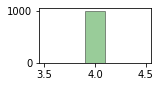

Track generation: 1252..1569 -> 317-tiles track
Episodi 4: recompensa = -93.6709


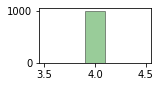

Track generation: 1176..1474 -> 298-tiles track
Episodi 5: recompensa = -93.266


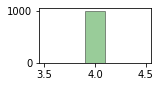

Track generation: 1068..1343 -> 275-tiles track
Episodi 6: recompensa = -92.7007


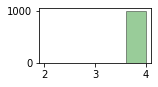

Track generation: 1169..1473 -> 304-tiles track
Episodi 7: recompensa = -93.3993


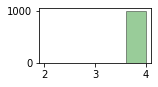

Track generation: 1312..1644 -> 332-tiles track
Episodi 8: recompensa = -93.9577


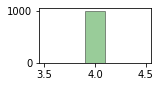

Track generation: 1063..1333 -> 270-tiles track
Episodi 9: recompensa = -92.5651


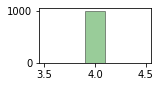

AvaluaAgent() Acabat


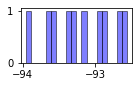


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_153
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1151..1443 -> 292-tiles track
Episodi 0: recompensa = 240.2062


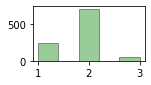

Track generation: 1237..1550 -> 313-tiles track
Episodi 1: recompensa = 172.4359


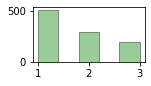

Track generation: 1097..1375 -> 278-tiles track
Episodi 2: recompensa = 322.3827


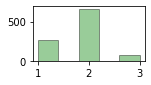

Track generation: 1254..1579 -> 325-tiles track
Episodi 3: recompensa = 208.642


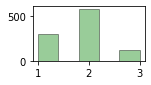

Track generation: 1056..1324 -> 268-tiles track
Episodi 4: recompensa = 289.5131


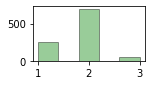

Track generation: 944..1184 -> 240-tiles track
Episodi 5: recompensa = 351.8828


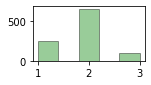

Track generation: 1091..1376 -> 285-tiles track
Episodi 6: recompensa = 350.7042


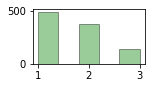

Track generation: 1311..1643 -> 332-tiles track
Episodi 7: recompensa = 253.4743


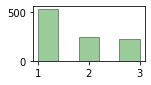

Track generation: 1095..1379 -> 284-tiles track
Episodi 8: recompensa = 232.1555


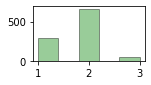

Track generation: 1198..1502 -> 304-tiles track
Episodi 9: recompensa = 424.7525


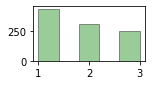

AvaluaAgent() Acabat


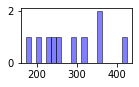


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_154
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1048..1314 -> 266-tiles track
Episodi 0: recompensa = 477.3585


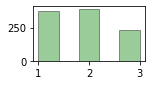

Track generation: 1204..1508 -> 304-tiles track
Episodi 1: recompensa = 233.3333


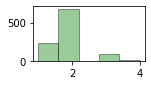

Track generation: 1170..1466 -> 296-tiles track
Episodi 2: recompensa = 486.4407


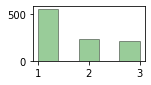

Track generation: 1251..1568 -> 317-tiles track
Episodi 3: recompensa = 270.2532


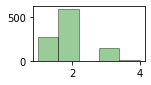

Track generation: 1116..1403 -> 287-tiles track
Episodi 4: recompensa = 242.6573


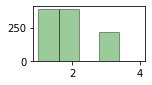

Track generation: 1201..1505 -> 304-tiles track
Episodi 5: recompensa = 715.1815


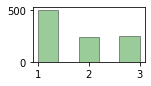

Track generation: 988..1248 -> 260-tiles track
Episodi 6: recompensa = 517.7606


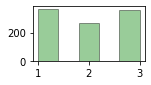

Track generation: 1348..1689 -> 341-tiles track
Episodi 7: recompensa = 285.2941


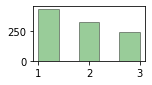

Track generation: 1058..1326 -> 268-tiles track
Episodi 8: recompensa = -92.5094


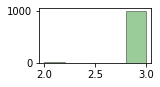

Track generation: 1216..1524 -> 308-tiles track
Episodi 9: recompensa = 245.2769


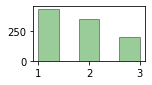

AvaluaAgent() Acabat


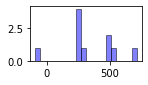


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_155
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1069..1340 -> 271-tiles track
Episodi 0: recompensa = 33.3333


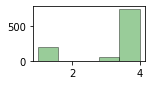

Track generation: 1080..1360 -> 280-tiles track
Episodi 1: recompensa = -78.4946


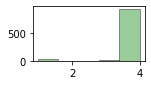

Track generation: 1100..1379 -> 279-tiles track
Episodi 2: recompensa = 83.4532


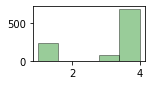

Track generation: 1056..1326 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1185..1491 -> 306-tiles track
Episodi 3: recompensa = -86.8852


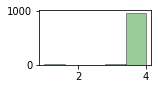

Track generation: 1087..1363 -> 276-tiles track
Episodi 4: recompensa = -81.8182


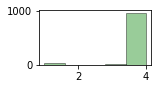

Track generation: 1333..1670 -> 337-tiles track
Episodi 5: recompensa = 22.0238


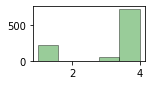

Track generation: 1016..1274 -> 258-tiles track
Episodi 6: recompensa = 36.1868


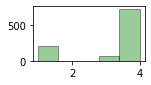

Track generation: 1051..1318 -> 267-tiles track
Episodi 7: recompensa = 174.4361


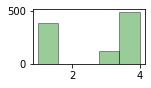

Track generation: 1149..1440 -> 291-tiles track
Episodi 8: recompensa = 41.3793


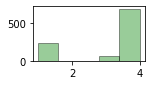

Track generation: 1164..1468 -> 304-tiles track
Episodi 9: recompensa = -83.4983


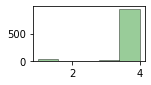

AvaluaAgent() Acabat


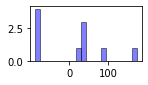


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_156
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1157..1451 -> 294-tiles track
Episodi 0: recompensa = 265.1877


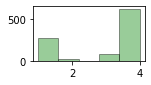

Track generation: 955..1200 -> 245-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1335..1673 -> 338-tiles track
Episodi 1: recompensa = 72.1068


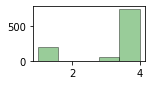

Track generation: 1063..1333 -> 270-tiles track
Episodi 2: recompensa = -92.5651


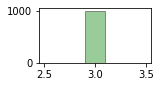

Track generation: 1196..1498 -> 302-tiles track
Episodi 3: recompensa = -93.3555


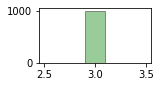

Track generation: 1224..1534 -> 310-tiles track
Episodi 4: recompensa = -93.5275


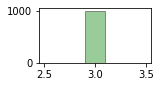

Track generation: 944..1191 -> 247-tiles track
Episodi 5: recompensa = -71.5447


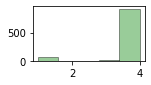

Track generation: 1130..1424 -> 294-tiles track
Episodi 6: recompensa = -76.1092


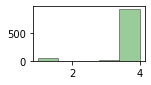

Track generation: 910..1146 -> 236-tiles track
Episodi 7: recompensa = 602.1277


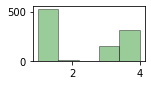

Track generation: 1061..1330 -> 269-tiles track
Episodi 8: recompensa = 265.6716


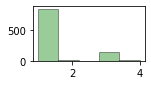

Track generation: 1168..1471 -> 303-tiles track
Episodi 9: recompensa = -80.1325


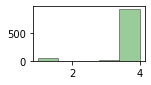

AvaluaAgent() Acabat


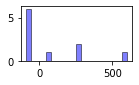


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_157
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1124..1409 -> 285-tiles track
Episodi 0: recompensa = -92.9577


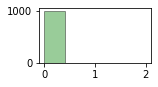

Track generation: 1223..1533 -> 310-tiles track
Episodi 1: recompensa = -93.5275


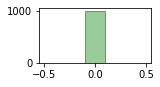

Track generation: 1128..1414 -> 286-tiles track
Episodi 2: recompensa = -92.9825


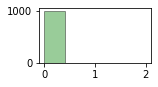

Track generation: 1138..1427 -> 289-tiles track
Episodi 3: recompensa = -93.0556


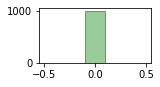

Track generation: 1226..1538 -> 312-tiles track
Episodi 4: recompensa = -93.5691


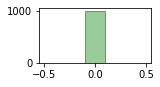

Track generation: 1058..1332 -> 274-tiles track
Episodi 5: recompensa = 31.8681


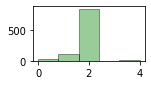

Track generation: 971..1229 -> 258-tiles track
Episodi 6: recompensa = 8.9494


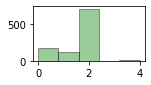

Track generation: 1026..1291 -> 265-tiles track
Episodi 7: recompensa = 17.4242


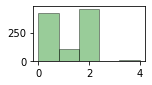

Track generation: 1519..1903 -> 384-tiles track
Episodi 8: recompensa = -94.7781


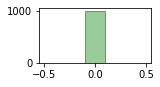

Track generation: 1220..1529 -> 309-tiles track
Episodi 9: recompensa = -93.5065


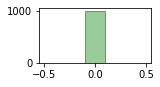

AvaluaAgent() Acabat


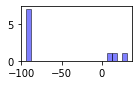


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_158
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1079..1353 -> 274-tiles track
Episodi 0: recompensa = -92.674


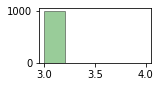

Track generation: 1190..1497 -> 307-tiles track
Episodi 1: recompensa = -93.4641


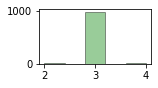

Track generation: 1100..1379 -> 279-tiles track
Episodi 2: recompensa = -92.8058


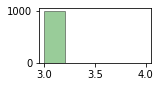

Track generation: 1107..1388 -> 281-tiles track
Episodi 3: recompensa = -92.8571


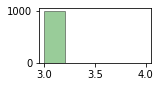

Track generation: 1157..1451 -> 294-tiles track
Episodi 4: recompensa = -93.1741


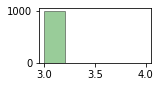

Track generation: 1116..1399 -> 283-tiles track
Episodi 5: recompensa = -92.9078


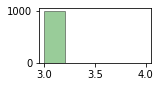

Track generation: 1309..1641 -> 332-tiles track
Episodi 6: recompensa = -93.9577


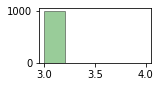

Track generation: 1109..1390 -> 281-tiles track
Episodi 7: recompensa = -92.8571


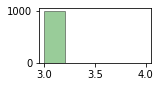

Track generation: 1055..1323 -> 268-tiles track
Episodi 8: recompensa = -92.5094


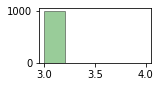

Track generation: 1136..1424 -> 288-tiles track
Episodi 9: recompensa = -93.0314


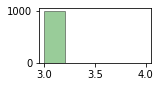

AvaluaAgent() Acabat


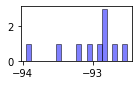


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_159
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1221..1530 -> 309-tiles track
Episodi 0: recompensa = -93.5065


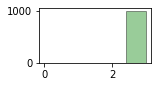

Track generation: 1221..1530 -> 309-tiles track
Episodi 1: recompensa = -93.5065


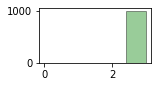

Track generation: 1156..1449 -> 293-tiles track
Episodi 2: recompensa = -93.1507


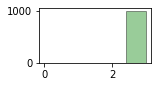

Track generation: 1166..1470 -> 304-tiles track
Episodi 3: recompensa = -93.3993


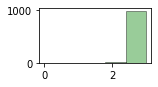

Track generation: 1095..1373 -> 278-tiles track
Episodi 4: recompensa = -92.7798


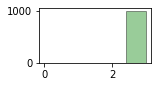

Track generation: 1151..1443 -> 292-tiles track
Episodi 5: recompensa = -93.1271


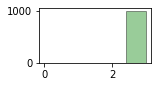

Track generation: 1276..1599 -> 323-tiles track
Episodi 6: recompensa = -93.7888


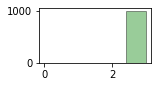

Track generation: 1289..1615 -> 326-tiles track
Episodi 7: recompensa = -93.8462


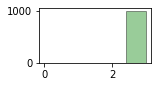

Track generation: 1264..1584 -> 320-tiles track
Episodi 8: recompensa = -93.7304


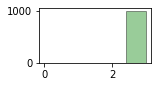

Track generation: 1124..1409 -> 285-tiles track
Episodi 9: recompensa = -92.9577


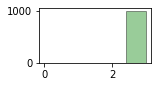

AvaluaAgent() Acabat


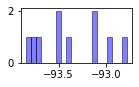


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_160
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1224..1534 -> 310-tiles track
Episodi 0: recompensa = 94.1748


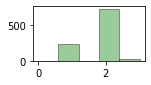

Track generation: 1209..1515 -> 306-tiles track
Episodi 1: recompensa = 1.6393


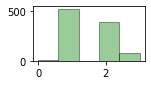

Track generation: 1247..1563 -> 316-tiles track
Episodi 2: recompensa = -33.3333


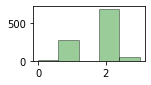

Track generation: 1047..1313 -> 266-tiles track
Episodi 3: recompensa = -20.7547


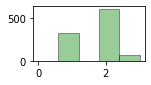

Track generation: 1048..1314 -> 266-tiles track
Episodi 4: recompensa = 43.3962


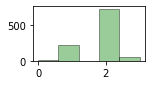

Track generation: 1234..1547 -> 313-tiles track
Episodi 5: recompensa = -32.6923


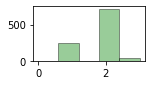

Track generation: 1045..1312 -> 267-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1113..1395 -> 282-tiles track
Episodi 6: recompensa = 85.0534


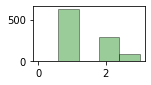

Track generation: 1151..1441 -> 290-tiles track
Episodi 7: recompensa = -30.7958


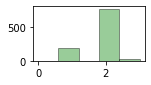

Track generation: 1135..1423 -> 288-tiles track
Episodi 8: recompensa = -26.8293


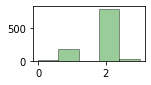

Track generation: 1132..1419 -> 287-tiles track
Episodi 9: recompensa = 137.7622


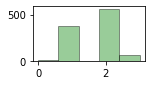

AvaluaAgent() Acabat


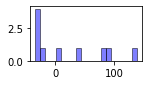


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_161
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1146..1444 -> 298-tiles track
Episodi 0: recompensa = -93.266


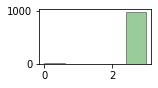

Track generation: 1090..1372 -> 282-tiles track
Episodi 1: recompensa = -92.8826


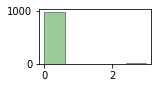

Track generation: 1066..1336 -> 270-tiles track
Episodi 2: recompensa = -92.5651


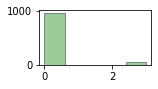

Track generation: 1088..1368 -> 280-tiles track
Episodi 3: recompensa = -92.8315


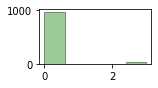

Track generation: 1203..1512 -> 309-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1179..1478 -> 299-tiles track
Episodi 4: recompensa = -93.2886


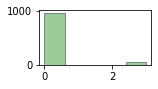

Track generation: 1176..1474 -> 298-tiles track
Episodi 5: recompensa = -93.266


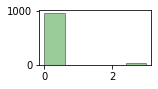

Track generation: 1172..1469 -> 297-tiles track
Episodi 6: recompensa = -93.2432


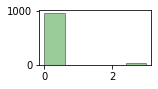

Track generation: 1064..1334 -> 270-tiles track
Episodi 7: recompensa = -92.5651


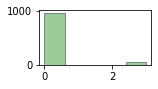

Track generation: 1132..1419 -> 287-tiles track
Episodi 8: recompensa = -93.007


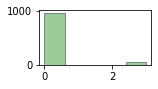

Track generation: 1116..1399 -> 283-tiles track
Episodi 9: recompensa = -92.9078


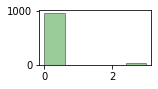

AvaluaAgent() Acabat


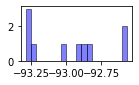


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_162
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1015..1276 -> 261-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1091..1368 -> 277-tiles track
Episodi 0: recompensa = -92.7536


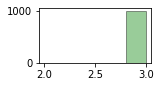

Track generation: 1275..1598 -> 323-tiles track
Episodi 1: recompensa = -93.7888


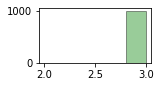

Track generation: 1006..1270 -> 264-tiles track
Episodi 2: recompensa = -92.3954


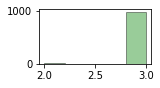

Track generation: 1081..1356 -> 275-tiles track
Episodi 3: recompensa = -92.7007


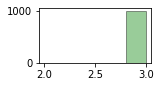

Track generation: 1061..1338 -> 277-tiles track
Episodi 4: recompensa = -92.7536


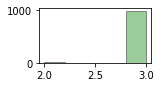

Track generation: 1133..1421 -> 288-tiles track
Episodi 5: recompensa = -93.0314


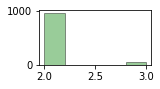

Track generation: 1235..1548 -> 313-tiles track
Episodi 6: recompensa = -93.5897


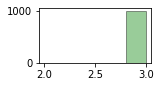

Track generation: 1050..1325 -> 275-tiles track
Episodi 7: recompensa = -92.7007


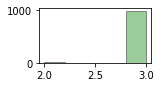

Track generation: 1052..1324 -> 272-tiles track
Episodi 8: recompensa = -92.6199


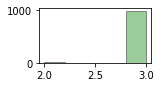

Track generation: 1068..1339 -> 271-tiles track
Episodi 9: recompensa = -92.5926


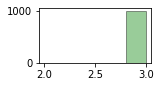

AvaluaAgent() Acabat


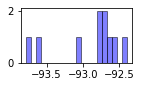


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_163
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1076..1359 -> 283-tiles track
Episodi 0: recompensa = -89.3617


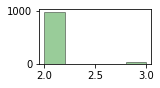

Track generation: 1143..1433 -> 290-tiles track
Episodi 1: recompensa = -93.0796


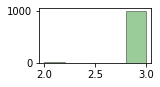

Track generation: 1120..1404 -> 284-tiles track
Episodi 2: recompensa = -92.9329


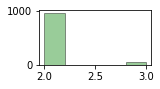

Track generation: 1235..1548 -> 313-tiles track
Episodi 3: recompensa = -93.5897


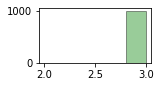

Track generation: 1261..1581 -> 320-tiles track
Episodi 4: recompensa = -93.7304


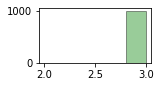

Track generation: 1107..1388 -> 281-tiles track
Episodi 5: recompensa = -92.8571


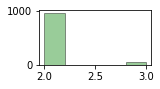

Track generation: 1226..1537 -> 311-tiles track
Episodi 6: recompensa = -93.5484


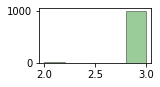

Track generation: 1239..1553 -> 314-tiles track
Episodi 7: recompensa = -93.6102


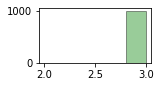

Track generation: 1021..1280 -> 259-tiles track
Episodi 8: recompensa = -92.2481


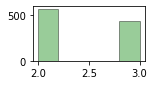

Track generation: 1266..1593 -> 327-tiles track
Episodi 9: recompensa = -93.865


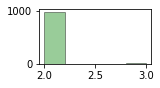

AvaluaAgent() Acabat


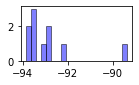


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_164
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1108..1398 -> 290-tiles track
Episodi 0: recompensa = -93.0796


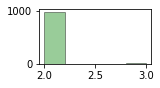

Track generation: 1211..1518 -> 307-tiles track
Episodi 1: recompensa = -93.4641


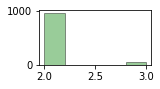

Track generation: 1060..1329 -> 269-tiles track
Episodi 2: recompensa = -92.5373


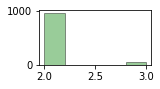

Track generation: 1174..1472 -> 298-tiles track
Episodi 3: recompensa = -93.266


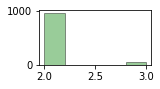

Track generation: 1228..1540 -> 312-tiles track
Episodi 4: recompensa = -93.5691


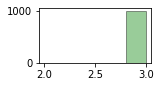

Track generation: 1150..1451 -> 301-tiles track
Episodi 5: recompensa = -93.3333


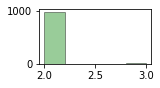

Track generation: 1159..1453 -> 294-tiles track
Episodi 6: recompensa = -93.1741


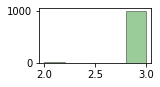

Track generation: 1116..1399 -> 283-tiles track
Episodi 7: recompensa = -92.9078


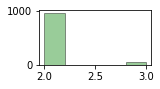

Track generation: 1234..1550 -> 316-tiles track
Episodi 8: recompensa = -93.6508


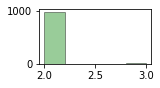

Track generation: 1079..1353 -> 274-tiles track
Episodi 9: recompensa = -92.674


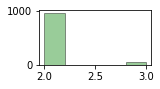

AvaluaAgent() Acabat


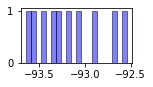


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_165
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1136..1424 -> 288-tiles track
Episodi 0: recompensa = -93.0314


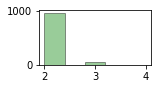

Track generation: 1232..1544 -> 312-tiles track
Episodi 1: recompensa = -93.5691


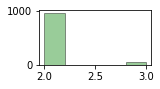

Track generation: 1219..1528 -> 309-tiles track
Episodi 2: recompensa = -93.5065


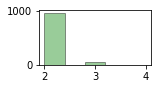

Track generation: 1007..1263 -> 256-tiles track
Episodi 3: recompensa = -92.1569


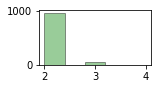

Track generation: 1260..1579 -> 319-tiles track
Episodi 4: recompensa = -93.7107


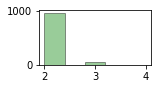

Track generation: 1018..1282 -> 264-tiles track
Episodi 5: recompensa = -92.3954


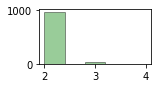

Track generation: 1073..1352 -> 279-tiles track
Episodi 6: recompensa = -92.8058


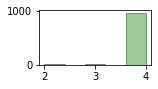

Track generation: 1102..1387 -> 285-tiles track
Episodi 7: recompensa = -92.9577


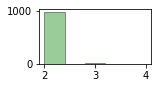

Track generation: 1188..1489 -> 301-tiles track
Episodi 8: recompensa = -93.3333


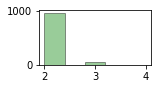

Track generation: 1196..1499 -> 303-tiles track
Episodi 9: recompensa = -93.3775


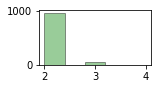

AvaluaAgent() Acabat


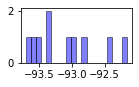


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_166
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1080..1354 -> 274-tiles track
Episodi 0: recompensa = -92.674


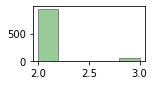

Track generation: 1227..1538 -> 311-tiles track
Episodi 1: recompensa = -93.5484


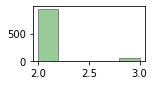

Track generation: 1118..1410 -> 292-tiles track
Episodi 2: recompensa = -93.1271


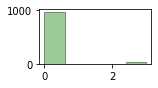

Track generation: 1085..1360 -> 275-tiles track
Episodi 3: recompensa = -92.7007


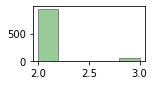

Track generation: 929..1171 -> 242-tiles track
Episodi 4: recompensa = -91.7012


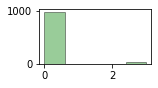

Track generation: 1268..1589 -> 321-tiles track
Episodi 5: recompensa = -93.75


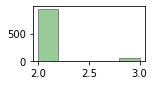

Track generation: 1068..1347 -> 279-tiles track
Episodi 6: recompensa = -92.8058


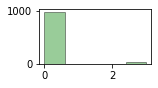

Track generation: 1060..1337 -> 277-tiles track
Episodi 7: recompensa = -92.7536


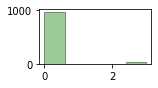

Track generation: 1197..1500 -> 303-tiles track
Episodi 8: recompensa = -93.3775


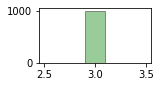

Track generation: 937..1183 -> 246-tiles track
Episodi 9: recompensa = -91.8367


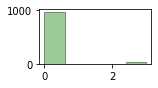

AvaluaAgent() Acabat


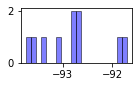


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_167
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1092..1369 -> 277-tiles track
Episodi 0: recompensa = -92.7536


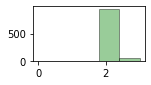

Track generation: 1000..1254 -> 254-tiles track
Episodi 1: recompensa = -92.0949


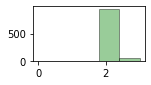

Track generation: 1232..1544 -> 312-tiles track
Episodi 2: recompensa = -93.5691


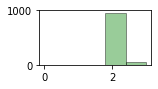

Track generation: 1179..1486 -> 307-tiles track
Episodi 3: recompensa = -93.4641


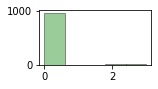

Track generation: 1145..1435 -> 290-tiles track
Episodi 4: recompensa = -93.0796


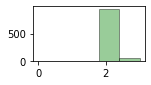

Track generation: 1103..1383 -> 280-tiles track
Episodi 5: recompensa = -92.8315


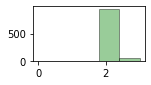

Track generation: 1128..1414 -> 286-tiles track
Episodi 6: recompensa = -92.9825


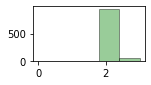

Track generation: 1078..1352 -> 274-tiles track
Episodi 7: recompensa = -92.674


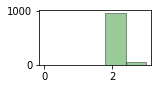

Track generation: 1032..1294 -> 262-tiles track
Episodi 8: recompensa = -92.3372


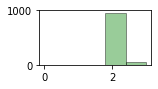

Track generation: 1131..1418 -> 287-tiles track
Episodi 9: recompensa = -93.007


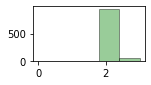

AvaluaAgent() Acabat


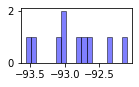


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_168
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1211..1518 -> 307-tiles track
Episodi 0: recompensa = -93.4641


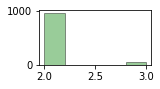

Track generation: 1097..1375 -> 278-tiles track
Episodi 1: recompensa = -92.7798


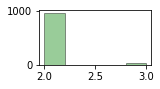

Track generation: 1319..1653 -> 334-tiles track
Episodi 2: recompensa = -93.994


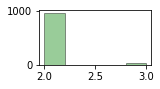

Track generation: 1249..1566 -> 317-tiles track
Episodi 3: recompensa = -93.6709


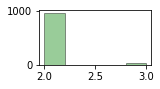

Track generation: 1196..1499 -> 303-tiles track
Episodi 4: recompensa = -93.3775


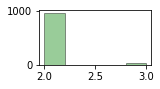

Track generation: 1163..1458 -> 295-tiles track
Episodi 5: recompensa = -93.1973


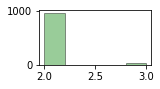

Track generation: 1272..1594 -> 322-tiles track
Episodi 6: recompensa = -93.7695


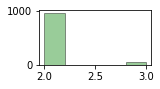

Track generation: 1173..1470 -> 297-tiles track
Episodi 7: recompensa = -93.2432


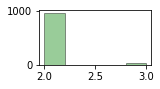

Track generation: 1303..1633 -> 330-tiles track
Episodi 8: recompensa = -93.921


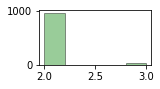

Track generation: 1169..1473 -> 304-tiles track
Episodi 9: recompensa = -93.3993


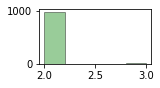

AvaluaAgent() Acabat


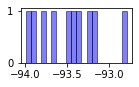


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_169
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1165..1468 -> 303-tiles track
Episodi 0: recompensa = -93.3775


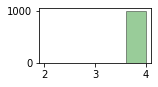

Track generation: 1079..1353 -> 274-tiles track
Episodi 1: recompensa = -92.674


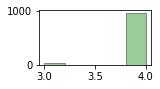

Track generation: 1240..1554 -> 314-tiles track
Episodi 2: recompensa = -93.6102


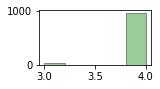

Track generation: 1040..1305 -> 265-tiles track
Episodi 3: recompensa = -92.4242


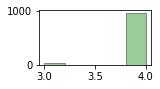

Track generation: 1041..1305 -> 264-tiles track
Episodi 4: recompensa = -92.3954


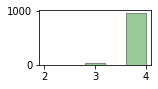

Track generation: 1061..1330 -> 269-tiles track
Episodi 5: recompensa = -92.5373


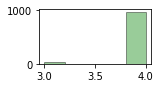

Track generation: 1074..1353 -> 279-tiles track
Episodi 6: recompensa = -92.8058


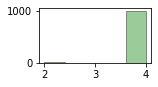

Track generation: 1250..1566 -> 316-tiles track
Episodi 7: recompensa = -93.6508


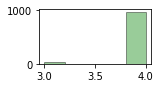

Track generation: 1195..1505 -> 310-tiles track
Episodi 8: recompensa = -93.5275


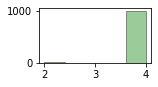

Track generation: 1195..1498 -> 303-tiles track
Episodi 9: recompensa = -93.3775


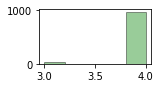

AvaluaAgent() Acabat


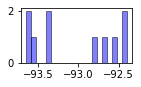


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_170
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1017..1283 -> 266-tiles track
Episodi 0: recompensa = -92.4528


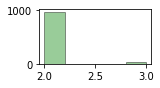

Track generation: 957..1201 -> 244-tiles track
Episodi 1: recompensa = -91.7695


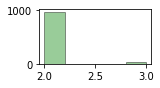

Track generation: 1108..1389 -> 281-tiles track
Episodi 2: recompensa = -92.8571


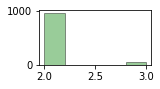

Track generation: 1152..1444 -> 292-tiles track
Episodi 3: recompensa = -93.1271


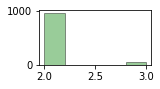

Track generation: 1036..1299 -> 263-tiles track
Episodi 4: recompensa = -92.3664


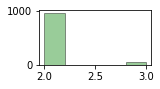

Track generation: 1134..1422 -> 288-tiles track
Episodi 5: recompensa = -93.0314


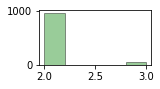

Track generation: 1192..1494 -> 302-tiles track
Episodi 6: recompensa = -93.3555


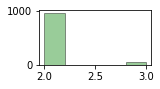

Track generation: 1170..1467 -> 297-tiles track
Episodi 7: recompensa = -93.2432


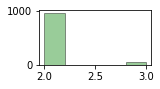

Track generation: 1231..1543 -> 312-tiles track
Episodi 8: recompensa = -93.5691


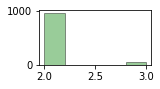

Track generation: 1224..1534 -> 310-tiles track
Episodi 9: recompensa = -93.5275


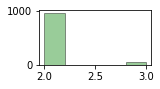

AvaluaAgent() Acabat


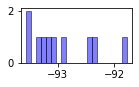


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_171
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1172..1469 -> 297-tiles track
Episodi 0: recompensa = -93.2432


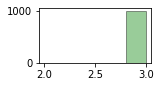

Track generation: 1294..1622 -> 328-tiles track
Episodi 1: recompensa = -93.8838


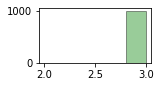

Track generation: 1076..1353 -> 277-tiles track
Episodi 2: recompensa = -92.7536


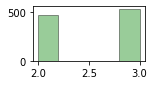

Track generation: 1240..1554 -> 314-tiles track
Episodi 3: recompensa = -93.6102


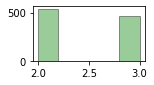

Track generation: 1106..1387 -> 281-tiles track
Episodi 4: recompensa = -92.8571


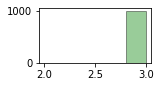

Track generation: 1063..1341 -> 278-tiles track
Episodi 5: recompensa = -92.7798


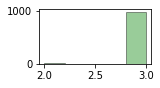

Track generation: 1347..1688 -> 341-tiles track
Episodi 6: recompensa = -94.1176


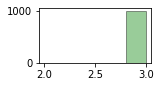

Track generation: 1131..1418 -> 287-tiles track
Episodi 7: recompensa = -93.007


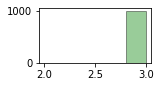

Track generation: 976..1227 -> 251-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1250..1567 -> 317-tiles track
Episodi 8: recompensa = -93.6709


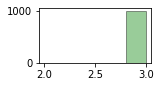

Track generation: 1244..1559 -> 315-tiles track
Episodi 9: recompensa = -93.6306


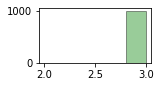

AvaluaAgent() Acabat


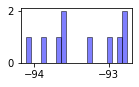


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_172
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1010..1267 -> 257-tiles track
Episodi 0: recompensa = -92.1875


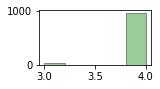

Track generation: 1200..1504 -> 304-tiles track
Episodi 1: recompensa = -93.3993


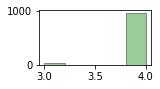

Track generation: 1034..1302 -> 268-tiles track
Episodi 2: recompensa = -92.5094


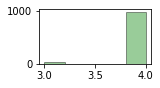

Track generation: 1172..1469 -> 297-tiles track
Episodi 3: recompensa = -93.2432


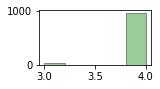

Track generation: 977..1225 -> 248-tiles track
Episodi 4: recompensa = -91.9028


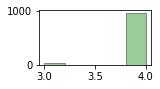

Track generation: 1115..1396 -> 281-tiles track
Episodi 5: recompensa = -92.8571


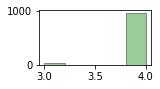

Track generation: 1040..1304 -> 264-tiles track
Episodi 6: recompensa = -92.3954


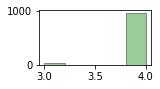

Track generation: 1019..1286 -> 267-tiles track
Episodi 7: recompensa = -92.4812


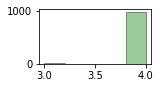

Track generation: 1032..1297 -> 265-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1111..1402 -> 291-tiles track
Episodi 8: recompensa = -89.6552


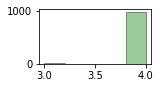

Track generation: 1191..1498 -> 307-tiles track
Episodi 9: recompensa = -93.4641


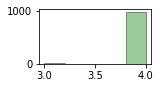

AvaluaAgent() Acabat


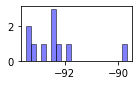


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_173
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1045..1316 -> 271-tiles track
Episodi 0: recompensa = 25.9259


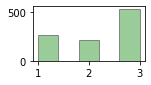

Track generation: 1021..1280 -> 259-tiles track
Episodi 1: recompensa = -92.2481


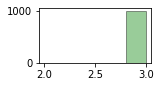

Track generation: 922..1160 -> 238-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1173..1471 -> 298-tiles track
Episodi 2: recompensa = 290.5724


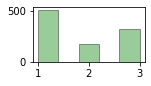

Track generation: 1072..1344 -> 272-tiles track
Episodi 3: recompensa = -92.6199


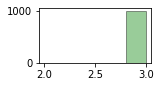

Track generation: 1056..1331 -> 275-tiles track
Episodi 4: recompensa = 38.6861


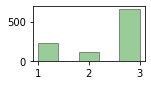

Track generation: 1230..1551 -> 321-tiles track
Episodi 5: recompensa = 125.0


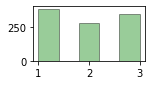

Track generation: 1019..1279 -> 260-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1287..1613 -> 326-tiles track
Episodi 6: recompensa = 158.0231


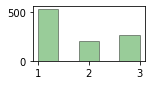

Track generation: 1149..1440 -> 291-tiles track
Episodi 7: recompensa = 189.6552


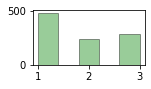

Track generation: 1132..1419 -> 287-tiles track
Episodi 8: recompensa = 88.7238


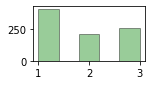

Track generation: 1140..1429 -> 289-tiles track
Episodi 9: recompensa = -93.0556


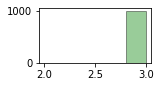

AvaluaAgent() Acabat


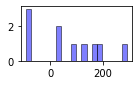


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_174
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1030..1298 -> 268-tiles track
Episodi 0: recompensa = -92.5094


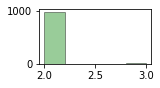

Track generation: 1149..1449 -> 300-tiles track
Episodi 1: recompensa = -93.311


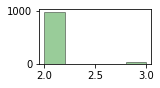

Track generation: 1204..1509 -> 305-tiles track
Episodi 2: recompensa = -93.4211


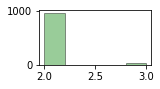

Track generation: 1108..1389 -> 281-tiles track
Episodi 3: recompensa = -92.8571


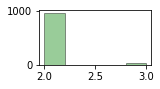

Track generation: 1203..1516 -> 313-tiles track
Episodi 4: recompensa = -93.5897


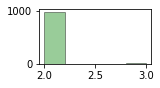

Track generation: 1188..1489 -> 301-tiles track
Episodi 5: recompensa = -93.3333


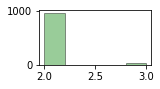

Track generation: 1020..1283 -> 263-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1187..1488 -> 301-tiles track
Episodi 6: recompensa = -93.3333


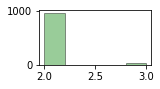

Track generation: 1032..1294 -> 262-tiles track
Episodi 7: recompensa = -92.3372


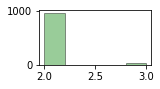

Track generation: 1133..1426 -> 293-tiles track
Episodi 8: recompensa = -93.1507


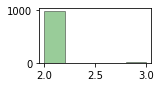

Track generation: 1196..1503 -> 307-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1031..1299 -> 268-tiles track
Episodi 9: recompensa = -92.5094


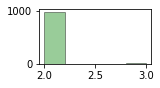

AvaluaAgent() Acabat


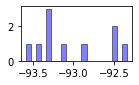


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_175
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1250..1566 -> 316-tiles track
Episodi 0: recompensa = -93.6508


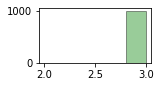

Track generation: 1252..1569 -> 317-tiles track
Episodi 1: recompensa = -93.6709


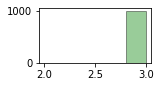

Track generation: 1196..1497 -> 301-tiles track
Episodi 2: recompensa = -93.3333


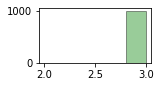

Track generation: 1118..1408 -> 290-tiles track
Episodi 3: recompensa = -93.0796


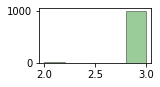

Track generation: 1232..1544 -> 312-tiles track
Episodi 4: recompensa = -93.5691


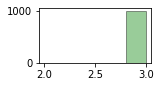

Track generation: 1228..1539 -> 311-tiles track
Episodi 5: recompensa = -93.5484


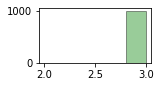

Track generation: 948..1196 -> 248-tiles track
Episodi 6: recompensa = -91.9028


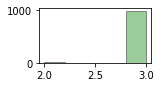

Track generation: 1121..1405 -> 284-tiles track
Episodi 7: recompensa = -92.9329


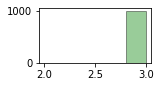

Track generation: 1074..1350 -> 276-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1151..1443 -> 292-tiles track
Episodi 8: recompensa = -93.1271


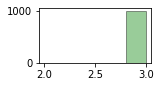

Track generation: 1100..1379 -> 279-tiles track
Episodi 9: recompensa = -92.8058


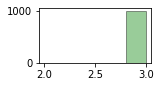

AvaluaAgent() Acabat


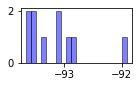


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_176
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1050..1317 -> 267-tiles track
Episodi 0: recompensa = 215.7895


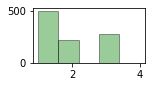

Track generation: 1219..1528 -> 309-tiles track
Episodi 1: recompensa = 273.3766


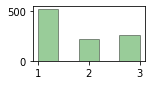

Track generation: 929..1174 -> 245-tiles track
Episodi 2: recompensa = 313.9344


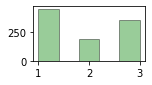

Track generation: 1174..1472 -> 298-tiles track
Episodi 3: recompensa = 246.8013


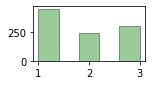

Track generation: 1114..1396 -> 282-tiles track
Episodi 4: recompensa = 53.0249


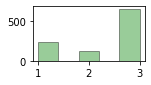

Track generation: 1168..1464 -> 296-tiles track
Episodi 5: recompensa = 313.5593


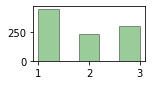

Track generation: 1076..1361 -> 285-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1211..1525 -> 314-tiles track
Episodi 6: recompensa = 168.3706


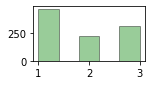

Track generation: 1152..1444 -> 292-tiles track
Episodi 7: recompensa = 298.6254


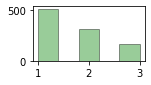

Track generation: 1143..1433 -> 290-tiles track
Episodi 8: recompensa = 277.1626


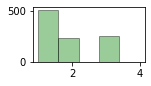

Track generation: 1195..1498 -> 303-tiles track
Episodi 9: recompensa = 181.457


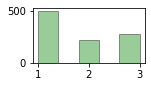

AvaluaAgent() Acabat


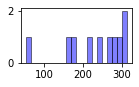


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_177
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1003..1266 -> 263-tiles track
Episodi 0: recompensa = -92.3664


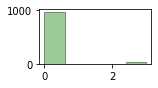

Track generation: 1122..1406 -> 284-tiles track
Episodi 1: recompensa = -92.9329


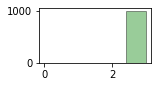

Track generation: 1011..1268 -> 257-tiles track
Episodi 2: recompensa = -92.1875


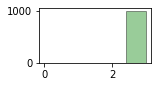

Track generation: 1152..1450 -> 298-tiles track
Episodi 3: recompensa = -93.266


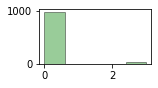

Track generation: 1115..1403 -> 288-tiles track
Episodi 4: recompensa = -93.0314


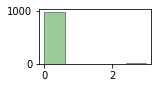

Track generation: 1188..1489 -> 301-tiles track
Episodi 5: recompensa = -93.3333


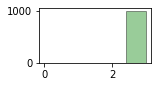

Track generation: 1168..1464 -> 296-tiles track
Episodi 6: recompensa = -93.2203


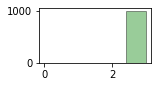

Track generation: 1154..1445 -> 291-tiles track
Episodi 7: recompensa = -93.1034


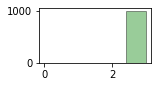

Track generation: 1199..1503 -> 304-tiles track
Episodi 8: recompensa = -93.3993


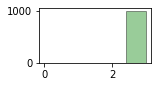

Track generation: 1186..1487 -> 301-tiles track
Episodi 9: recompensa = -93.3333


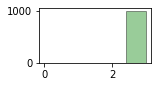

AvaluaAgent() Acabat


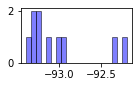


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_178
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1252..1569 -> 317-tiles track
Episodi 0: recompensa = -93.6709


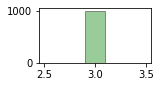

Track generation: 1176..1474 -> 298-tiles track
Episodi 1: recompensa = -93.266


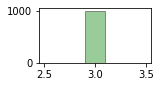

Track generation: 1216..1524 -> 308-tiles track
Episodi 2: recompensa = -93.4853


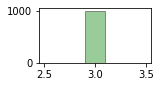

Track generation: 1029..1307 -> 278-tiles track
Episodi 3: recompensa = -92.7798


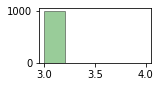

Track generation: 1151..1443 -> 292-tiles track
Episodi 4: recompensa = -93.1271


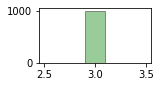

Track generation: 1085..1366 -> 281-tiles track
Episodi 5: recompensa = -92.8571


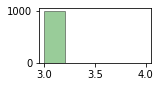

Track generation: 1120..1404 -> 284-tiles track
Episodi 6: recompensa = -92.9329


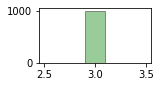

Track generation: 1232..1544 -> 312-tiles track
Episodi 7: recompensa = -93.5691


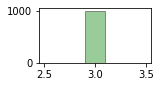

Track generation: 1184..1484 -> 300-tiles track
Episodi 8: recompensa = -93.311


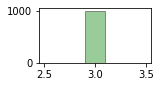

Track generation: 1395..1748 -> 353-tiles track
Episodi 9: recompensa = -94.3182


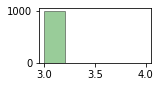

AvaluaAgent() Acabat


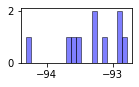


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_179
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1204..1509 -> 305-tiles track
Episodi 0: recompensa = -93.4211


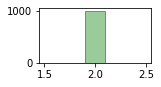

Track generation: 1284..1609 -> 325-tiles track
Episodi 1: recompensa = -93.8272


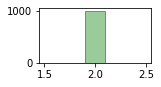

Track generation: 1053..1321 -> 268-tiles track
Episodi 2: recompensa = -92.5094


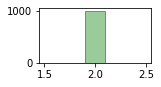

Track generation: 1118..1401 -> 283-tiles track
Episodi 3: recompensa = -92.9078


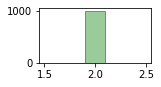

Track generation: 1100..1379 -> 279-tiles track
Episodi 4: recompensa = -92.8058


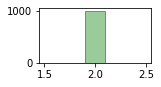

Track generation: 1273..1596 -> 323-tiles track
Episodi 5: recompensa = -93.7888


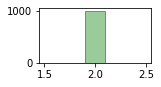

Track generation: 1283..1608 -> 325-tiles track
Episodi 6: recompensa = -93.8272


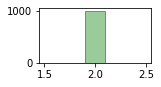

Track generation: 1272..1594 -> 322-tiles track
Episodi 7: recompensa = -93.7695


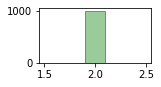

Track generation: 1056..1324 -> 268-tiles track
Episodi 8: recompensa = -92.5094


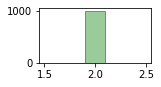

Track generation: 1140..1438 -> 298-tiles track
Episodi 9: recompensa = -93.266


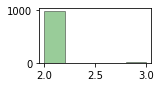

AvaluaAgent() Acabat


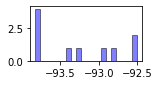


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_180
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1172..1470 -> 298-tiles track
Episodi 0: recompensa = -93.266


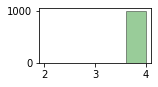

Track generation: 1128..1419 -> 291-tiles track
Episodi 1: recompensa = -93.1034


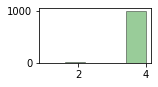

Track generation: 1180..1479 -> 299-tiles track
Episodi 2: recompensa = -93.2886


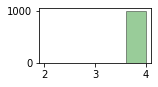

Track generation: 1112..1394 -> 282-tiles track
Episodi 3: recompensa = -92.8826


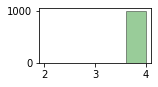

Track generation: 1237..1550 -> 313-tiles track
Episodi 4: recompensa = -93.5897


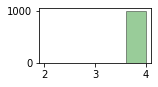

Track generation: 1195..1498 -> 303-tiles track
Episodi 5: recompensa = -93.3775


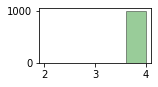

Track generation: 1072..1344 -> 272-tiles track
Episodi 6: recompensa = -92.6199


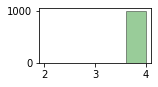

Track generation: 1035..1298 -> 263-tiles track
Episodi 7: recompensa = -92.3664


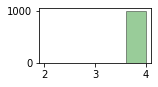

Track generation: 1150..1441 -> 291-tiles track
Episodi 8: recompensa = -93.1034


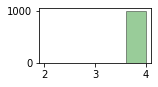

Track generation: 1136..1424 -> 288-tiles track
Episodi 9: recompensa = -93.0314


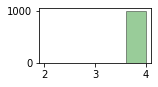

AvaluaAgent() Acabat


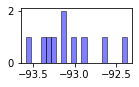


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_181
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1037..1310 -> 273-tiles track
Episodi 0: recompensa = 6.6176


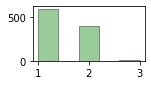

Track generation: 1277..1605 -> 328-tiles track
Episodi 1: recompensa = -16.9245


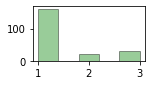

Track generation: 1139..1429 -> 290-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1112..1394 -> 282-tiles track
Episodi 2: recompensa = -47.3669


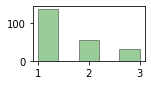

Track generation: 988..1240 -> 252-tiles track
Episodi 3: recompensa = -39.7347


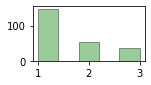

Track generation: 1126..1412 -> 286-tiles track
Episodi 4: recompensa = -50.8158


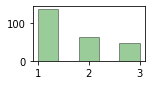

Track generation: 1102..1390 -> 288-tiles track
Episodi 5: recompensa = 63.7631


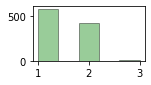

Track generation: 1227..1538 -> 311-tiles track
Episodi 6: recompensa = -57.0581


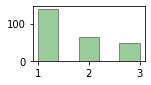

Track generation: 1138..1430 -> 292-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1060..1329 -> 269-tiles track
Episodi 7: recompensa = -23.5343


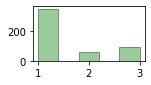

Track generation: 990..1249 -> 259-tiles track
Episodi 8: recompensa = 70.5426


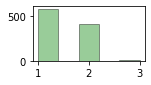

Track generation: 1065..1337 -> 272-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1099..1378 -> 279-tiles track
Episodi 9: recompensa = -50.6604


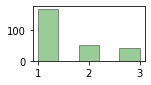

AvaluaAgent() Acabat


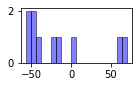


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_182
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1142..1431 -> 289-tiles track
Episodi 0: recompensa = 139.5833


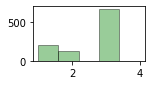

Track generation: 1059..1328 -> 269-tiles track
Episodi 1: recompensa = -92.5373


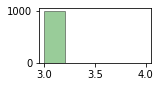

Track generation: 1191..1493 -> 302-tiles track
Episodi 2: recompensa = -93.3555


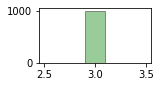

Track generation: 1128..1418 -> 290-tiles track
Episodi 3: recompensa = 166.436


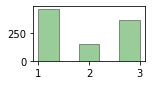

Track generation: 1208..1514 -> 306-tiles track
Episodi 4: recompensa = -93.4426


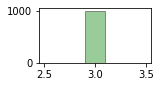

Track generation: 1064..1334 -> 270-tiles track
Episodi 5: recompensa = 188.6297


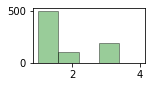

Track generation: 1110..1392 -> 282-tiles track
Episodi 6: recompensa = -92.8826


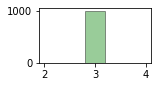

Track generation: 1147..1437 -> 290-tiles track
Episodi 7: recompensa = -93.0796


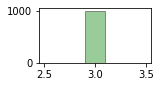

Track generation: 1133..1421 -> 288-tiles track
Episodi 8: recompensa = -93.0314


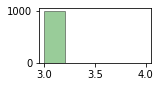

Track generation: 1295..1623 -> 328-tiles track
Episodi 9: recompensa = -93.8838


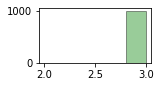

AvaluaAgent() Acabat


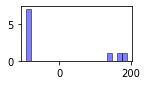


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_183
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1060..1331 -> 271-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1305..1635 -> 330-tiles track
Episodi 0: recompensa = -93.921


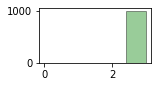

Track generation: 1146..1436 -> 290-tiles track
Episodi 1: recompensa = -93.0796


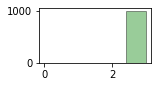

Track generation: 1176..1474 -> 298-tiles track
Episodi 2: recompensa = -93.266


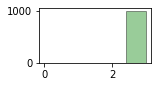

Track generation: 1351..1693 -> 342-tiles track
Episodi 3: recompensa = -94.1349


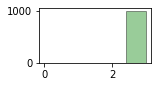

Track generation: 1148..1439 -> 291-tiles track
Episodi 4: recompensa = -93.1034


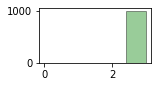

Track generation: 1360..1704 -> 344-tiles track
Episodi 5: recompensa = -94.1691


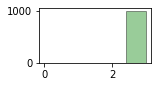

Track generation: 1075..1348 -> 273-tiles track
Episodi 6: recompensa = -92.6471


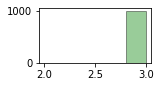

Track generation: 1068..1339 -> 271-tiles track
Episodi 7: recompensa = -92.5926


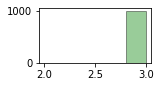

Track generation: 1135..1428 -> 293-tiles track
Episodi 8: recompensa = -93.1507


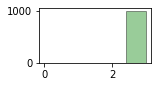

Track generation: 987..1241 -> 254-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1190..1492 -> 302-tiles track
Episodi 9: recompensa = -93.3555


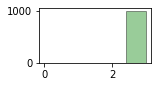

AvaluaAgent() Acabat


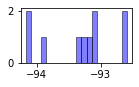


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_184
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1380..1729 -> 349-tiles track
Episodi 0: recompensa = -94.2529


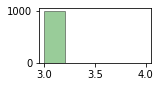

Track generation: 1119..1409 -> 290-tiles track
Episodi 1: recompensa = 221.7993


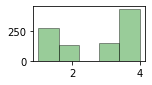

Track generation: 1173..1470 -> 297-tiles track
Episodi 2: recompensa = -93.2432


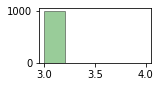

Track generation: 1287..1619 -> 332-tiles track
Episodi 3: recompensa = 165.332


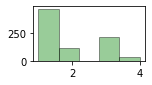

Track generation: 1272..1594 -> 322-tiles track
Episodi 4: recompensa = -93.7695


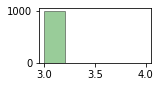

Track generation: 1108..1389 -> 281-tiles track
Episodi 5: recompensa = -92.8571


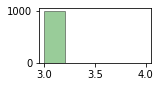

Track generation: 1111..1393 -> 282-tiles track
Episodi 6: recompensa = -92.8826


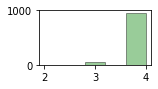

Track generation: 1215..1523 -> 308-tiles track
Episodi 7: recompensa = -93.4853


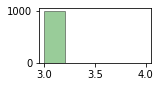

Track generation: 1203..1508 -> 305-tiles track
Episodi 8: recompensa = -93.4211


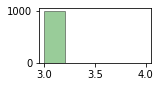

Track generation: 1315..1648 -> 333-tiles track
Episodi 9: recompensa = -93.9759


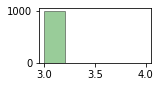

AvaluaAgent() Acabat


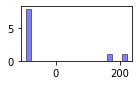


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_185
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1178..1476 -> 298-tiles track
Episodi 0: recompensa = -93.266


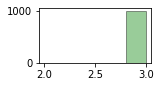

Track generation: 1124..1409 -> 285-tiles track
Episodi 1: recompensa = -92.9577


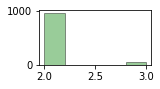

Track generation: 1184..1484 -> 300-tiles track
Episodi 2: recompensa = -93.311


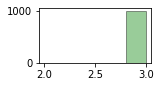

Track generation: 1185..1494 -> 309-tiles track
Episodi 3: recompensa = 513.6364


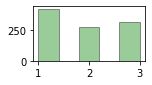

Track generation: 1119..1408 -> 289-tiles track
Episodi 4: recompensa = -93.0556


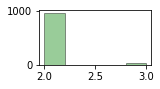

Track generation: 1089..1365 -> 276-tiles track
Episodi 5: recompensa = -92.7273


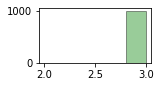

Track generation: 1183..1483 -> 300-tiles track
Episodi 6: recompensa = -93.311


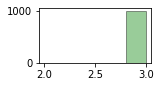

Track generation: 1053..1320 -> 267-tiles track
Episodi 7: recompensa = -92.4812


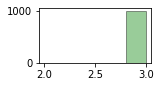

Track generation: 1224..1534 -> 310-tiles track
Episodi 8: recompensa = -93.5275


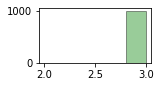

Track generation: 1041..1309 -> 268-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1180..1479 -> 299-tiles track
Episodi 9: recompensa = -93.2886


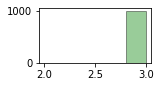

AvaluaAgent() Acabat


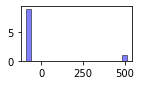


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_186
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1123..1408 -> 285-tiles track
Episodi 0: recompensa = 199.2958


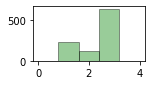

Track generation: 1139..1428 -> 289-tiles track
Episodi 1: recompensa = 118.75


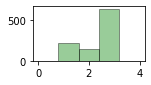

Track generation: 967..1221 -> 254-tiles track
Episodi 2: recompensa = 477.0751


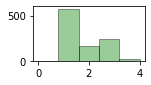

Track generation: 1175..1473 -> 298-tiles track
Episodi 3: recompensa = 320.8754


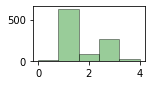

Track generation: 1053..1328 -> 275-tiles track
Episodi 4: recompensa = 5.8394


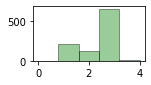

Track generation: 1235..1548 -> 313-tiles track
Episodi 5: recompensa = 47.4359


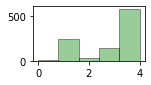

Track generation: 909..1146 -> 237-tiles track
Episodi 6: recompensa = 324.9864


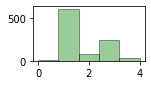

Track generation: 1047..1313 -> 266-tiles track
Episodi 7: recompensa = 281.1321


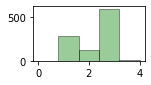

Track generation: 1279..1603 -> 324-tiles track
Episodi 8: recompensa = -93.808


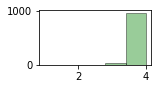

Track generation: 1287..1613 -> 326-tiles track
Episodi 9: recompensa = 41.5385


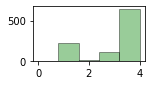

AvaluaAgent() Acabat


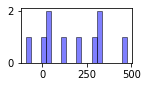


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_187
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1177..1475 -> 298-tiles track
Episodi 0: recompensa = 334.3434


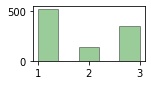

Track generation: 1086..1366 -> 280-tiles track
Episodi 1: recompensa = 271.9656


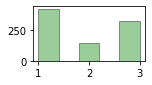

Track generation: 1282..1613 -> 331-tiles track
Episodi 2: recompensa = 177.0061


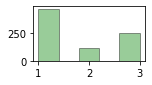

Track generation: 1119..1403 -> 284-tiles track
Episodi 3: recompensa = 246.2898


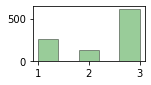

Track generation: 1236..1549 -> 313-tiles track
Episodi 4: recompensa = 473.7179


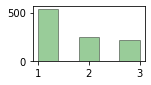

Track generation: 1151..1443 -> 292-tiles track
Episodi 5: recompensa = 302.0619


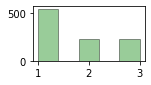

Track generation: 1352..1694 -> 342-tiles track
Episodi 6: recompensa = 383.871


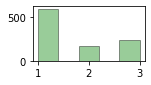

Track generation: 1341..1681 -> 340-tiles track
Episodi 7: recompensa = -94.1003


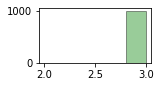

Track generation: 992..1246 -> 254-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1252..1569 -> 317-tiles track
Episodi 8: recompensa = -93.6709


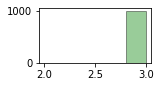

Track generation: 1142..1432 -> 290-tiles track
Episodi 9: recompensa = 131.8339


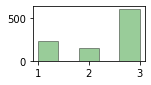

AvaluaAgent() Acabat


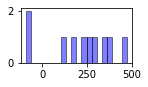


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_188
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1322..1656 -> 334-tiles track
Episodi 0: recompensa = -93.994


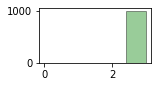

Track generation: 1138..1427 -> 289-tiles track
Episodi 1: recompensa = -93.0556


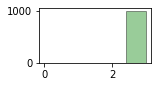

Track generation: 1059..1334 -> 275-tiles track
Episodi 2: recompensa = -92.7007


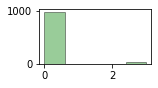

Track generation: 1096..1374 -> 278-tiles track
Episodi 3: recompensa = -92.7798


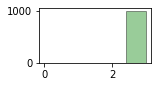

Track generation: 1133..1429 -> 296-tiles track
Episodi 4: recompensa = -93.2203


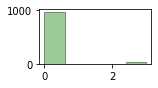

Track generation: 1219..1528 -> 309-tiles track
Episodi 5: recompensa = -93.5065


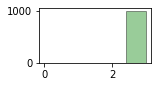

Track generation: 1196..1499 -> 303-tiles track
Episodi 6: recompensa = -93.3775


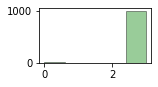

Track generation: 1083..1358 -> 275-tiles track
Episodi 7: recompensa = -92.7007


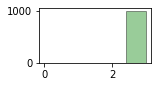

Track generation: 1202..1506 -> 304-tiles track
Episodi 8: recompensa = -93.3993


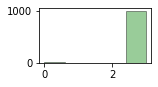

Track generation: 1128..1414 -> 286-tiles track
Episodi 9: recompensa = -92.9825


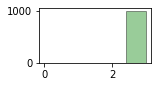

AvaluaAgent() Acabat


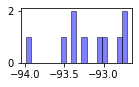


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_189
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1174..1472 -> 298-tiles track
Episodi 0: recompensa = -93.266


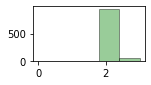

Track generation: 1121..1405 -> 284-tiles track
Episodi 1: recompensa = -92.9329


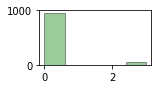

Track generation: 1251..1568 -> 317-tiles track
Episodi 2: recompensa = -93.6709


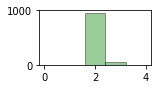

Track generation: 1088..1365 -> 277-tiles track
Episodi 3: recompensa = -92.7536


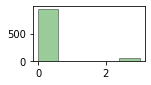

Track generation: 1180..1479 -> 299-tiles track
Episodi 4: recompensa = -93.2886


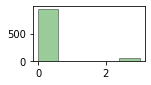

Track generation: 1133..1420 -> 287-tiles track
Episodi 5: recompensa = -93.007


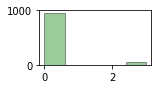

Track generation: 1106..1387 -> 281-tiles track
Episodi 6: recompensa = -92.8571


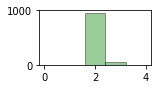

Track generation: 1040..1304 -> 264-tiles track
Episodi 7: recompensa = -92.3954


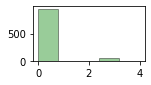

Track generation: 1072..1344 -> 272-tiles track
Episodi 8: recompensa = -92.6199


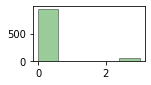

Track generation: 1079..1363 -> 284-tiles track
Episodi 9: recompensa = -92.9329


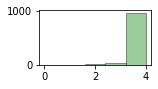

AvaluaAgent() Acabat


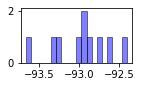


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_190
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1180..1479 -> 299-tiles track
Episodi 0: recompensa = 141.6107


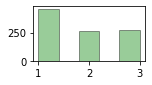

Track generation: 1093..1371 -> 278-tiles track
Episodi 1: recompensa = -92.7798


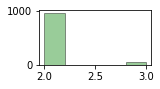

Track generation: 1128..1414 -> 286-tiles track
Episodi 2: recompensa = 198.2456


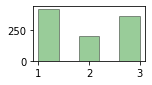

Track generation: 1198..1509 -> 311-tiles track
Episodi 3: recompensa = 83.871


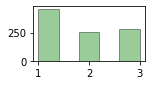

Track generation: 1032..1294 -> 262-tiles track
Episodi 4: recompensa = -92.3372


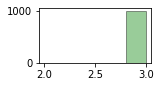

Track generation: 1158..1452 -> 294-tiles track
Episodi 5: recompensa = -93.1741


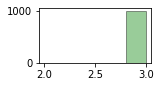

Track generation: 1101..1385 -> 284-tiles track
Episodi 6: recompensa = 119.0813


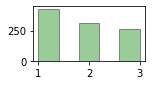

Track generation: 1235..1553 -> 318-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1208..1522 -> 314-tiles track
Episodi 7: recompensa = 120.4473


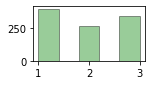

Track generation: 1140..1429 -> 289-tiles track
Episodi 8: recompensa = -93.0556


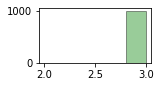

Track generation: 1105..1391 -> 286-tiles track
Episodi 9: recompensa = 128.0702


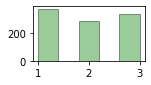

AvaluaAgent() Acabat


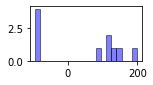


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_191
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1081..1356 -> 275-tiles track
Episodi 0: recompensa = -92.7007


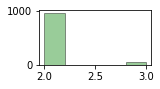

Track generation: 1148..1439 -> 291-tiles track
Episodi 1: recompensa = -93.1034


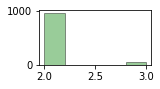

Track generation: 1167..1463 -> 296-tiles track
Episodi 2: recompensa = -93.2203


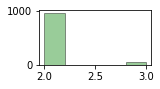

Track generation: 1196..1499 -> 303-tiles track
Episodi 3: recompensa = -93.3775


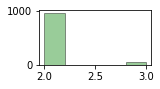

Track generation: 1059..1333 -> 274-tiles track
Episodi 4: recompensa = 321.2454


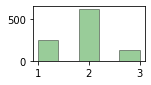

Track generation: 1067..1338 -> 271-tiles track
Episodi 5: recompensa = -92.5926


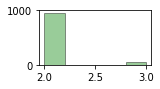

Track generation: 1199..1503 -> 304-tiles track
Episodi 6: recompensa = -93.3993


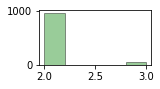

Track generation: 1123..1408 -> 285-tiles track
Episodi 7: recompensa = -92.9577


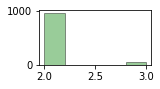

Track generation: 1027..1288 -> 261-tiles track
Episodi 8: recompensa = -92.3077


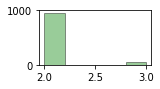

Track generation: 1239..1553 -> 314-tiles track
Episodi 9: recompensa = -93.6102


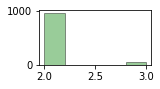

AvaluaAgent() Acabat


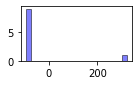


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_192
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1024..1284 -> 260-tiles track
Episodi 0: recompensa = -92.278


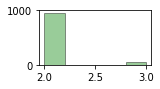

Track generation: 1053..1320 -> 267-tiles track
Episodi 1: recompensa = -92.4812


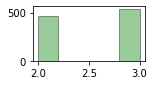

Track generation: 1050..1323 -> 273-tiles track
Episodi 2: recompensa = 304.4118


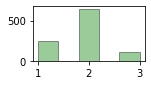

Track generation: 1053..1323 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1128..1414 -> 286-tiles track
Episodi 3: recompensa = -92.9825


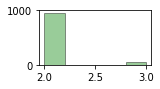

Track generation: 1192..1494 -> 302-tiles track
Episodi 4: recompensa = -93.3555


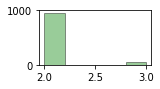

Track generation: 1203..1508 -> 305-tiles track
Episodi 5: recompensa = -93.4211


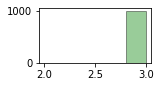

Track generation: 1200..1504 -> 304-tiles track
Episodi 6: recompensa = -93.3993


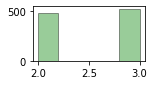

Track generation: 1227..1538 -> 311-tiles track
Episodi 7: recompensa = -93.5484


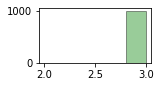

Track generation: 1124..1409 -> 285-tiles track
Episodi 8: recompensa = -92.9577


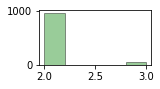

Track generation: 1136..1424 -> 288-tiles track
Episodi 9: recompensa = -93.0314


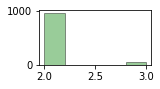

AvaluaAgent() Acabat


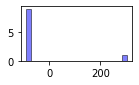


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_193
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1128..1414 -> 286-tiles track
Episodi 0: recompensa = -92.9825


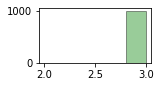

Track generation: 1395..1748 -> 353-tiles track
Episodi 1: recompensa = -94.3182


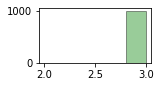

Track generation: 1155..1448 -> 293-tiles track
Episodi 2: recompensa = -93.1507


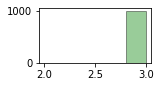

Track generation: 1037..1306 -> 269-tiles track
Episodi 3: recompensa = -92.5373


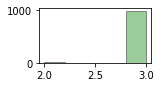

Track generation: 1183..1483 -> 300-tiles track
Episodi 4: recompensa = -93.311


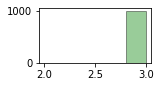

Track generation: 1089..1366 -> 277-tiles track
Episodi 5: recompensa = -92.7536


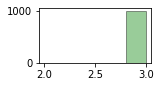

Track generation: 1079..1353 -> 274-tiles track
Episodi 6: recompensa = -92.674


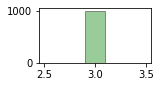

Track generation: 1239..1553 -> 314-tiles track
Episodi 7: recompensa = -93.6102


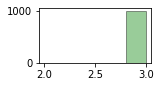

Track generation: 1108..1389 -> 281-tiles track
Episodi 8: recompensa = -92.8571


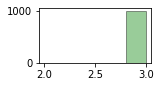

Track generation: 1160..1455 -> 295-tiles track
Episodi 9: recompensa = -93.1973


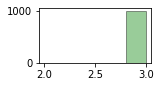

AvaluaAgent() Acabat


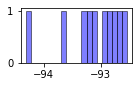


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_194
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1133..1420 -> 287-tiles track
Episodi 0: recompensa = -93.007


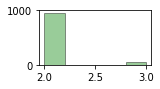

Track generation: 1224..1534 -> 310-tiles track
Episodi 1: recompensa = -93.5275


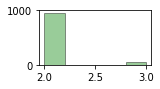

Track generation: 1141..1430 -> 289-tiles track
Episodi 2: recompensa = -93.0556


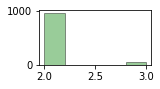

Track generation: 1171..1468 -> 297-tiles track
Episodi 3: recompensa = -93.2432


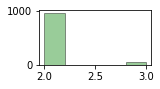

Track generation: 1388..1747 -> 359-tiles track
Episodi 4: recompensa = -35.7542


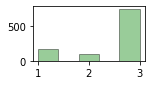

Track generation: 1172..1469 -> 297-tiles track
Episodi 5: recompensa = -93.2432


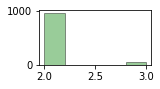

Track generation: 1216..1524 -> 308-tiles track
Episodi 6: recompensa = -93.4853


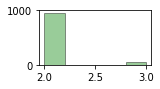

Track generation: 1119..1403 -> 284-tiles track
Episodi 7: recompensa = -92.9329


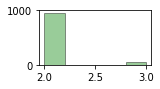

Track generation: 1236..1549 -> 313-tiles track
Episodi 8: recompensa = -93.5897


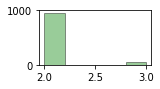

Track generation: 1280..1604 -> 324-tiles track
Episodi 9: recompensa = -93.808


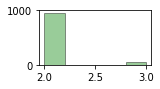

AvaluaAgent() Acabat


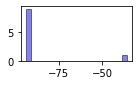


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_195
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1215..1523 -> 308-tiles track
Episodi 0: recompensa = 176.873


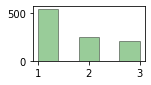

Track generation: 1253..1571 -> 318-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 873..1102 -> 229-tiles track
Episodi 1: recompensa = 97.3684


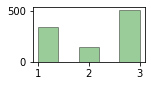

Track generation: 1178..1475 -> 297-tiles track
Episodi 2: recompensa = 92.5676


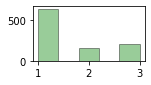

Track generation: 1004..1263 -> 259-tiles track
Episodi 3: recompensa = 27.907


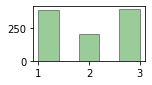

Track generation: 1274..1595 -> 321-tiles track
Episodi 4: recompensa = 128.125


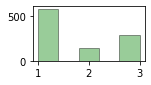

Track generation: 1046..1312 -> 266-tiles track
Episodi 5: recompensa = 201.8868


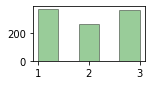

Track generation: 1156..1455 -> 299-tiles track
Episodi 6: recompensa = 228.8591


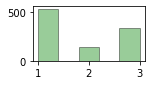

Track generation: 1247..1563 -> 316-tiles track
Episodi 7: recompensa = 201.5873


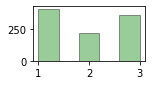

Track generation: 1124..1409 -> 285-tiles track
Episodi 8: recompensa = 114.7887


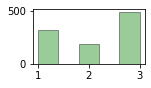

Track generation: 1045..1310 -> 265-tiles track
Episodi 9: recompensa = 354.5455


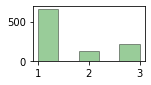

AvaluaAgent() Acabat


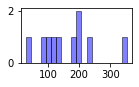


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_196
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1113..1395 -> 282-tiles track
Episodi 0: recompensa = 327.0463


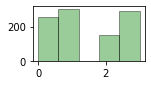

Track generation: 1112..1394 -> 282-tiles track
Episodi 1: recompensa = 565.4804


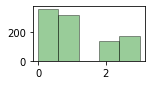

Track generation: 1311..1642 -> 331-tiles track
Episodi 2: recompensa = -93.9394


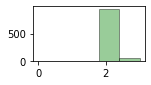

Track generation: 1067..1345 -> 278-tiles track
Episodi 3: recompensa = 380.1444


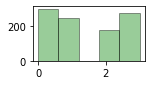

Track generation: 1079..1360 -> 281-tiles track
Episodi 4: recompensa = 367.8571


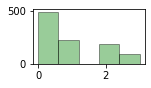

Track generation: 1228..1539 -> 311-tiles track
Episodi 5: recompensa = -93.5484


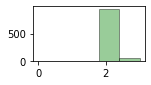

Track generation: 1304..1634 -> 330-tiles track
Episodi 6: recompensa = -93.921


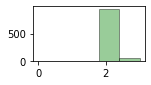

Track generation: 1168..1464 -> 296-tiles track
Episodi 7: recompensa = -93.2203


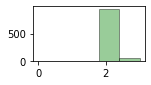

Track generation: 1215..1523 -> 308-tiles track
Episodi 8: recompensa = -93.4853


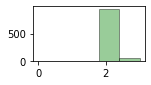

Track generation: 1031..1292 -> 261-tiles track
Episodi 9: recompensa = 680.7692


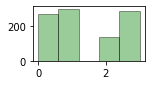

AvaluaAgent() Acabat


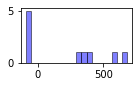


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_197
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1170..1476 -> 306-tiles track
Episodi 0: recompensa = 326.2295


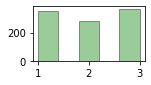

Track generation: 1084..1359 -> 275-tiles track
Episodi 1: recompensa = -92.7007


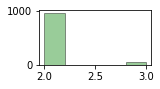

Track generation: 1040..1304 -> 264-tiles track
Episodi 2: recompensa = -92.3954


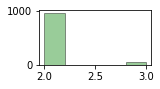

Track generation: 1157..1451 -> 294-tiles track
Episodi 3: recompensa = 545.0512


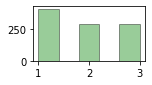

Track generation: 1320..1654 -> 334-tiles track
Episodi 4: recompensa = -93.994


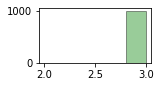

Track generation: 1311..1643 -> 332-tiles track
Episodi 5: recompensa = -93.9577


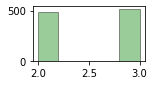

Track generation: 1063..1338 -> 275-tiles track
Episodi 6: recompensa = 640.8759


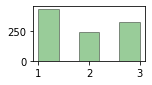

Track generation: 1060..1329 -> 269-tiles track
Episodi 7: recompensa = 463.4328


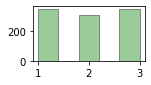

Track generation: 1122..1406 -> 284-tiles track
Episodi 8: recompensa = -92.9329


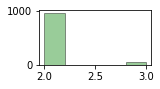

Track generation: 1191..1501 -> 310-tiles track
Episodi 9: recompensa = 547.2492


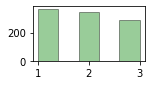

AvaluaAgent() Acabat


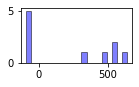


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_198
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1136..1424 -> 288-tiles track
Episodi 0: recompensa = -93.0314


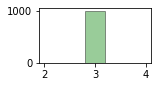

Track generation: 1203..1508 -> 305-tiles track
Episodi 1: recompensa = -93.4211


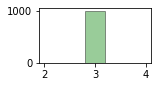

Track generation: 1169..1472 -> 303-tiles track
Episodi 2: recompensa = 45.6954


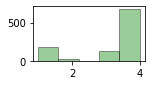

Track generation: 1254..1572 -> 318-tiles track
Episodi 3: recompensa = -93.6909


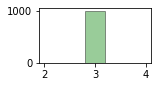

Track generation: 1288..1614 -> 326-tiles track
Episodi 4: recompensa = -93.8462


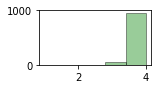

Track generation: 1167..1463 -> 296-tiles track
Episodi 5: recompensa = -93.2203


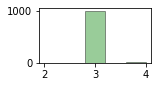

Track generation: 1124..1409 -> 285-tiles track
Episodi 6: recompensa = -92.9577


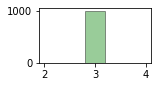

Track generation: 1149..1443 -> 294-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1168..1464 -> 296-tiles track
Episodi 7: recompensa = -93.2203


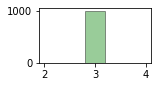

Track generation: 1230..1542 -> 312-tiles track
Episodi 8: recompensa = -93.5691


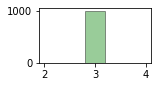

Track generation: 969..1221 -> 252-tiles track
Episodi 9: recompensa = 71.3147


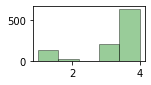

AvaluaAgent() Acabat


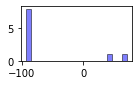


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_199
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1095..1373 -> 278-tiles track
Episodi 0: recompensa = -92.7798


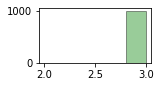

Track generation: 1068..1341 -> 273-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1112..1396 -> 284-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1128..1414 -> 286-tiles track
Episodi 1: recompensa = -92.9825


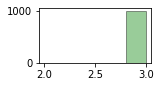

Track generation: 1237..1551 -> 314-tiles track
Episodi 2: recompensa = -93.6102


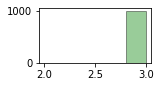

Track generation: 1008..1264 -> 256-tiles track
Episodi 3: recompensa = -92.1569


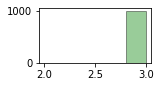

Track generation: 1141..1431 -> 290-tiles track
Episodi 4: recompensa = -93.0796


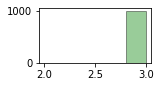

Track generation: 1022..1282 -> 260-tiles track
Episodi 5: recompensa = -92.278


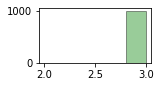

Track generation: 1061..1337 -> 276-tiles track
Episodi 6: recompensa = -92.7273


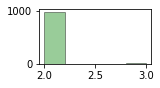

Track generation: 1122..1407 -> 285-tiles track
Episodi 7: recompensa = -92.9577


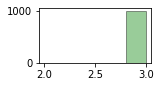

Track generation: 1125..1411 -> 286-tiles track
Episodi 8: recompensa = -92.9825


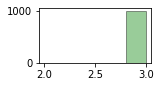

Track generation: 1139..1428 -> 289-tiles track
Episodi 9: recompensa = -93.0556


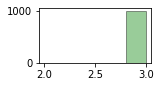

AvaluaAgent() Acabat


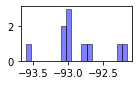


Nova Iteració. Ara toca el fitxer  AgentDQN_v1_iteracio_200
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1041..1305 -> 264-tiles track
Episodi 0: recompensa = -92.3954


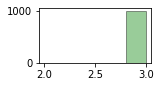

Track generation: 1061..1330 -> 269-tiles track
Episodi 1: recompensa = -92.5373


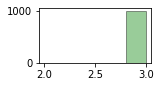

Track generation: 1226..1536 -> 310-tiles track
Episodi 2: recompensa = -93.5275


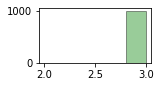

Track generation: 1423..1783 -> 360-tiles track
Episodi 3: recompensa = -94.429


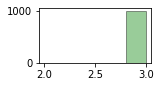

Track generation: 1164..1459 -> 295-tiles track
Episodi 4: recompensa = -93.1973


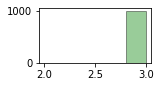

Track generation: 1101..1383 -> 282-tiles track
Episodi 5: recompensa = -92.8826


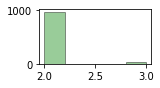

Track generation: 1080..1364 -> 284-tiles track
Episodi 6: recompensa = -92.9329


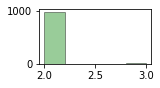

Track generation: 1081..1355 -> 274-tiles track
Episodi 7: recompensa = -92.674


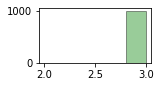

Track generation: 1152..1444 -> 292-tiles track
Episodi 8: recompensa = -93.1271


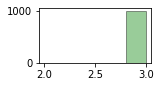

Track generation: 1104..1384 -> 280-tiles track
Episodi 9: recompensa = -92.8315


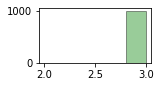

AvaluaAgent() Acabat


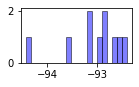

Acabat


In [17]:
nomFitxerCSV = "dadesEntrenamentsPrimerAgent.csv"
with open(nomFitxerCSV,"w",newline='') as fitxer:
        writer = csv.writer(fitxer)
        writer.writerow(["iteracio", "mean", "StDev", "minim", "maxim"])

for i in range(229):
    araToca = "primeraProvaDQN_iteracio_{}".format(i)
    print("\nNova Iteració. Ara toca el fitxer ",araToca)
    LLrewMitjana = AvaluaAgent(araToca,5,False)
    # per comprovar si són normals
#     fig = plt.figure(figsize=(2,1))
#     plt.hist(LLrewMitjana,bins = 20, alpha = 0.5, edgecolor = 'black',color="b")
#     plt.show(); plt.close()
    print(LLrewMitjana)
    mitja,desv = np.mean(LLrewMitjana), np.std(LLrewMitjana,ddof=1)
    valMax, valMin = max(LLrewMitjana), min(LLrewMitjana)
    
    with open(nomFitxerCSV,"a",newline='') as fitxer:
        writer = csv.writer(fitxer)
        writer.writerow([i, mitja, desv, valMin, valMax])

        
for i in range(201):
    araToca = "AgentDQN_v1_iteracio_{}".format(i)
    print("\nNova Iteració. Ara toca el fitxer ",araToca)
    LLrewMitjana = AvaluaAgent(araToca,5,False)
    # per comprovar si són normals
#     fig = plt.figure(figsize=(2,1))
#     plt.hist(LLrewMitjana,bins = 20, alpha = 0.5, edgecolor = 'black',color="b")
#     plt.show(); plt.close()
    print(LLrewMitjana)
    mitja,desv = np.mean(LLrewMitjana), np.std(LLrewMitjana,ddof=1)
    valMax, valMin = max(LLrewMitjana), min(LLrewMitjana)
    
    with open(nomFitxerCSV,"a",newline='') as fitxer:
        writer = csv.writer(fitxer)
        writer.writerow([229+i, mitja, desv, valMin, valMax])     
        
        
for i in range(96):
    araToca = "AgentDQN_v2_iteracio_{}".format(i)
    print("\nNova Iteració. Ara toca el fitxer ",araToca)
    LLrewMitjana = AvaluaAgent(araToca,5,False)
    # per comprovar si són normals
#     fig = plt.figure(figsize=(2,1))
#     plt.hist(LLrewMitjana,bins = 20, alpha = 0.5, edgecolor = 'black',color="b")
#     plt.show(); plt.close()
    print(LLrewMitjana)
    mitja,desv = np.mean(LLrewMitjana), np.std(LLrewMitjana,ddof=1)
    valMax, valMin = max(LLrewMitjana), min(LLrewMitjana)
    
    with open(nomFitxerCSV,"a",newline='') as fitxer:
        writer = csv.writer(fitxer)
        writer.writerow([201+229+i, mitja, desv, valMin, valMax])      
            
        
print("Acabat")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1053..1323 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1231..1542 -> 311-tiles track
Episodi 0: recompensa = 538.7097


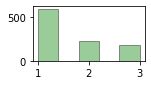

Track generation: 1064..1338 -> 274-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1107..1388 -> 281-tiles track
Episodi 1: recompensa = 832.1429


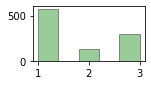

Track generation: 1166..1470 -> 304-tiles track
Episodi 2: recompensa = 487.4587


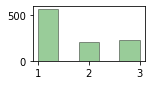

Track generation: 978..1232 -> 254-tiles track
Episodi 3: recompensa = 848.6166


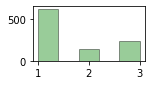

AvaluaAgent() Acabat


[538.709677419341, 832.1428571428394, 487.45874587457376, 848.6166007905017]

In [17]:
AvaluaAgent("Agent2_v1",4,True)
# AvaluaAgent("Agent2_v2",4,True)

### 200 episodis

Iteració  0
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 948..1189 -> 241-tiles track
Episodi 0: recompensa = 858.3333


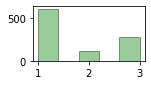

AvaluaAgent() Acabat
Iteració  1
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1055..1331 -> 276-tiles track
Episodi 0: recompensa = 816.3636


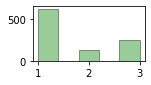

AvaluaAgent() Acabat
Iteració  2
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1233..1545 -> 312-tiles track
Episodi 0: recompensa = 829.2605


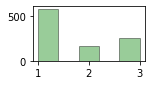

AvaluaAgent() Acabat
Iteració  3
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1301..1630 -> 329-tiles track
Episodi 0: recompensa = 567.6829


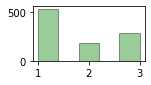

AvaluaAgent() Acabat
Iteració  4
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1342..1681 -> 339-tiles track
Episodi 0: recompensa = 689.9408


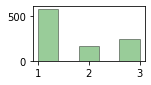

AvaluaAgent() Acabat
Iteració  5
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1215..1533 -> 318-tiles track
Episodi 0: recompensa = 594.0063


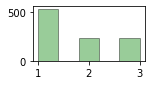

AvaluaAgent() Acabat
Iteració  6
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1176..1474 -> 298-tiles track
Episodi 0: recompensa = 573.4007


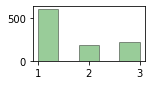

AvaluaAgent() Acabat
Iteració  7
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1175..1473 -> 298-tiles track
Episodi 0: recompensa = 664.3098


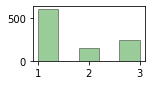

AvaluaAgent() Acabat
Iteració  8
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1235..1548 -> 313-tiles track
Episodi 0: recompensa = 791.0256


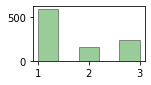

AvaluaAgent() Acabat
Iteració  9
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 953..1200 -> 247-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1125..1411 -> 286-tiles track
Episodi 0: recompensa = 805.2632


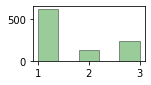

AvaluaAgent() Acabat
Iteració  10
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1198..1509 -> 311-tiles track
Episodi 0: recompensa = 654.8387


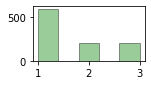

AvaluaAgent() Acabat
Iteració  11
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 973..1226 -> 253-tiles track
Episodi 0: recompensa = 574.6032


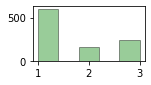

AvaluaAgent() Acabat
Iteració  12
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 980..1229 -> 249-tiles track
Episodi 0: recompensa = 819.3548


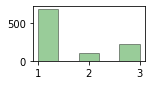

AvaluaAgent() Acabat
Iteració  13
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1214..1521 -> 307-tiles track
Episodi 0: recompensa = 772.549


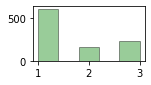

AvaluaAgent() Acabat
Iteració  14
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1171..1468 -> 297-tiles track
Episodi 0: recompensa = 798.6486


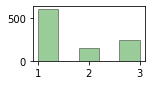

AvaluaAgent() Acabat
Iteració  15
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1175..1475 -> 300-tiles track
Episodi 0: recompensa = 799.6656


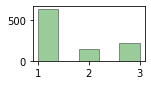

AvaluaAgent() Acabat
Iteració  16
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1056..1324 -> 268-tiles track
Episodi 0: recompensa = 870.0375


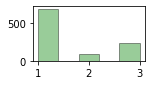

AvaluaAgent() Acabat
Iteració  17
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1048..1339 -> 291-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1182..1482 -> 300-tiles track
Episodi 0: recompensa = 806.3545


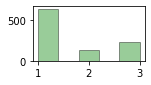

AvaluaAgent() Acabat
Iteració  18
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1040..1308 -> 268-tiles track
Episodi 0: recompensa = 851.3109


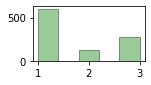

AvaluaAgent() Acabat
Iteració  19
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1052..1326 -> 274-tiles track
Episodi 0: recompensa = 863.37


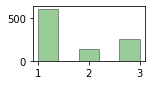

AvaluaAgent() Acabat
Iteració  20
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1157..1450 -> 293-tiles track
Episodi 0: recompensa = 855.4795


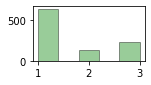

AvaluaAgent() Acabat
Iteració  21
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1240..1554 -> 314-tiles track
Episodi 0: recompensa = 740.2556


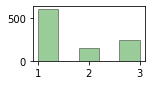

AvaluaAgent() Acabat
Iteració  22
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1263..1590 -> 327-tiles track
Episodi 0: recompensa = 761.9632


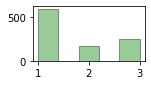

AvaluaAgent() Acabat
Iteració  23
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1026..1287 -> 261-tiles track
Episodi 0: recompensa = 461.5385


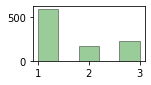

AvaluaAgent() Acabat
Iteració  24
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1168..1464 -> 296-tiles track
Episodi 0: recompensa = 438.9831


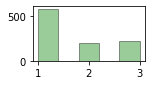

AvaluaAgent() Acabat
Iteració  25
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1149..1442 -> 293-tiles track
Episodi 0: recompensa = 807.5342


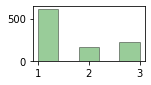

AvaluaAgent() Acabat
Iteració  26
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1120..1404 -> 284-tiles track
Episodi 0: recompensa = 836.3958


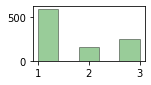

AvaluaAgent() Acabat
Iteració  27
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1191..1493 -> 302-tiles track
Episodi 0: recompensa = 773.7542


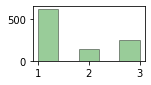

AvaluaAgent() Acabat
Iteració  28
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1338..1674 -> 336-tiles track
Episodi 0: recompensa = 682.0896


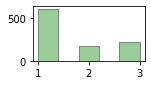

AvaluaAgent() Acabat
Iteració  29
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1155..1453 -> 298-tiles track
Episodi 0: recompensa = 745.1178


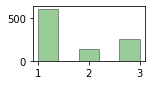

AvaluaAgent() Acabat
Iteració  30
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1283..1608 -> 325-tiles track
Episodi 0: recompensa = 526.5432


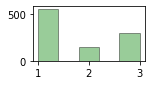

AvaluaAgent() Acabat
Iteració  31
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1021..1290 -> 269-tiles track
Episodi 0: recompensa = 635.0746


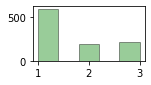

AvaluaAgent() Acabat
Iteració  32
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1183..1483 -> 300-tiles track
Episodi 0: recompensa = 819.7324


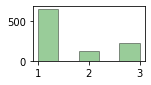

AvaluaAgent() Acabat
Iteració  33
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1098..1377 -> 279-tiles track
Episodi 0: recompensa = 763.3094


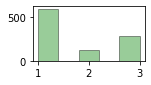

AvaluaAgent() Acabat
Iteració  34
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1072..1344 -> 272-tiles track
Episodi 0: recompensa = 608.4871


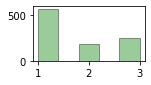

AvaluaAgent() Acabat
Iteració  35
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1216..1532 -> 316-tiles track
Episodi 0: recompensa = 582.5397


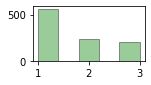

AvaluaAgent() Acabat
Iteració  36
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1217..1525 -> 308-tiles track
Episodi 0: recompensa = 789.2508


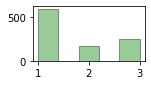

AvaluaAgent() Acabat
Iteració  37
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 988..1246 -> 258-tiles track
Episodi 0: recompensa = 802.7237


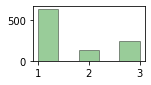

AvaluaAgent() Acabat
Iteració  38
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1063..1333 -> 270-tiles track
Episodi 0: recompensa = 810.7807


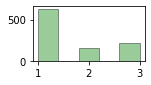

AvaluaAgent() Acabat
Iteració  39
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1112..1394 -> 282-tiles track
Episodi 0: recompensa = 512.0996


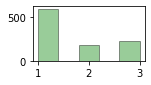

AvaluaAgent() Acabat
Iteració  40
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1128..1414 -> 286-tiles track
Episodi 0: recompensa = 847.3684


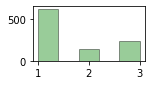

AvaluaAgent() Acabat
Iteració  41
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1228..1539 -> 311-tiles track
Episodi 0: recompensa = 751.6129


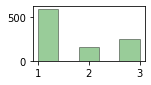

AvaluaAgent() Acabat
Iteració  42
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1203..1508 -> 305-tiles track
Episodi 0: recompensa = 827.6316


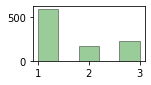

AvaluaAgent() Acabat
Iteració  43
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1156..1450 -> 294-tiles track
Episodi 0: recompensa = 698.6348


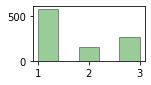

AvaluaAgent() Acabat
Iteració  44
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1052..1319 -> 267-tiles track
Episodi 0: recompensa = 501.5038


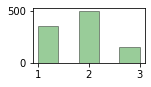

AvaluaAgent() Acabat
Iteració  45
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1213..1524 -> 311-tiles track
Episodi 0: recompensa = 751.6129


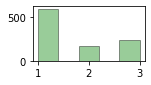

AvaluaAgent() Acabat
Iteració  46
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1219..1528 -> 309-tiles track
Episodi 0: recompensa = 838.3117


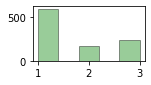

AvaluaAgent() Acabat
Iteració  47
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1108..1389 -> 281-tiles track
Episodi 0: recompensa = 850.0


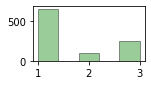

AvaluaAgent() Acabat
Iteració  48
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1160..1462 -> 302-tiles track
Episodi 0: recompensa = 816.9435


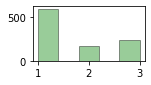

AvaluaAgent() Acabat
Iteració  49
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1183..1483 -> 300-tiles track
Episodi 0: recompensa = 655.8528


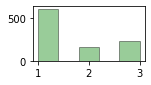

AvaluaAgent() Acabat
Iteració  50
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1075..1348 -> 273-tiles track
Episodi 0: recompensa = 852.2059


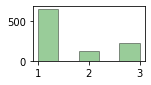

AvaluaAgent() Acabat
Iteració  51
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1289..1615 -> 326-tiles track
Episodi 0: recompensa = 441.5385


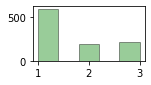

AvaluaAgent() Acabat
Iteració  52
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1211..1518 -> 307-tiles track
Episodi 0: recompensa = 533.9869


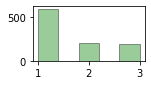

AvaluaAgent() Acabat
Iteració  53
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1028..1289 -> 261-tiles track
Episodi 0: recompensa = 830.7692


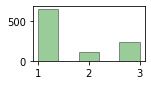

AvaluaAgent() Acabat
Iteració  54
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1219..1528 -> 309-tiles track
Episodi 0: recompensa = 779.8701


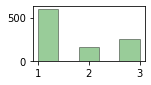

AvaluaAgent() Acabat
Iteració  55
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1239..1553 -> 314-tiles track
Episodi 0: recompensa = 449.5208


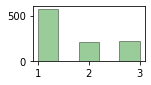

AvaluaAgent() Acabat
Iteració  56
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1231..1543 -> 312-tiles track
Episodi 0: recompensa = 411.254


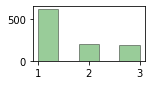

AvaluaAgent() Acabat
Iteració  57
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1111..1393 -> 282-tiles track
Episodi 0: recompensa = 843.0605


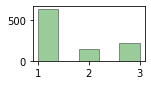

AvaluaAgent() Acabat
Iteració  58
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1128..1414 -> 286-tiles track
Episodi 0: recompensa = 436.8421


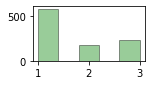

AvaluaAgent() Acabat
Iteració  59
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1038..1309 -> 271-tiles track
Episodi 0: recompensa = 825.9259


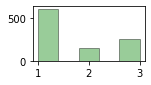

AvaluaAgent() Acabat
Iteració  60
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1124..1409 -> 285-tiles track
Episodi 0: recompensa = 667.6056


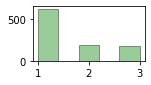

AvaluaAgent() Acabat
Iteració  61
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1118..1409 -> 291-tiles track
Episodi 0: recompensa = 796.5517


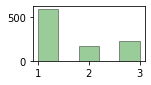

AvaluaAgent() Acabat
Iteració  62
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1279..1611 -> 332-tiles track
Episodi 0: recompensa = 764.0483


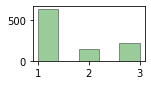

AvaluaAgent() Acabat
Iteració  63
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1136..1424 -> 288-tiles track
Episodi 0: recompensa = 854.7038


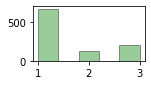

AvaluaAgent() Acabat
Iteració  64
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1075..1348 -> 273-tiles track
Episodi 0: recompensa = 837.5


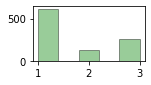

AvaluaAgent() Acabat
Iteració  65
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1137..1425 -> 288-tiles track
Episodi 0: recompensa = 610.8014


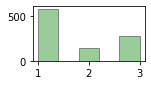

AvaluaAgent() Acabat
Iteració  66
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1136..1424 -> 288-tiles track
Episodi 0: recompensa = 722.2997


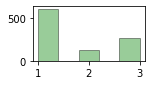

AvaluaAgent() Acabat
Iteració  67
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1174..1472 -> 298-tiles track
Episodi 0: recompensa = 825.9259


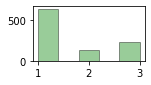

AvaluaAgent() Acabat
Iteració  68
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1085..1360 -> 275-tiles track
Episodi 0: recompensa = 483.9416


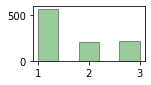

AvaluaAgent() Acabat
Iteració  69
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1216..1524 -> 308-tiles track
Episodi 0: recompensa = 818.5668


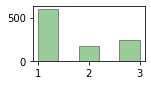

AvaluaAgent() Acabat
Iteració  70
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1188..1489 -> 301-tiles track
Episodi 0: recompensa = 413.3333


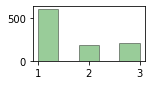

AvaluaAgent() Acabat
Iteració  71
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1117..1401 -> 284-tiles track
Episodi 0: recompensa = 790.4594


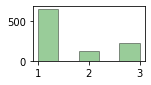

AvaluaAgent() Acabat
Iteració  72
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1099..1378 -> 279-tiles track
Episodi 0: recompensa = 741.7266


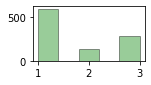

AvaluaAgent() Acabat
Iteració  73
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1143..1436 -> 293-tiles track
Episodi 0: recompensa = 773.2877


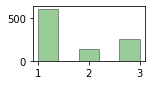

AvaluaAgent() Acabat
Iteració  74
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1027..1290 -> 263-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1131..1418 -> 287-tiles track
Episodi 0: recompensa = 693.7063


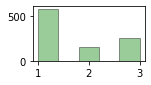

AvaluaAgent() Acabat
Iteració  75
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1136..1424 -> 288-tiles track
Episodi 0: recompensa = 795.4704


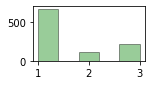

AvaluaAgent() Acabat
Iteració  76
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1164..1459 -> 295-tiles track
Episodi 0: recompensa = 685.7143


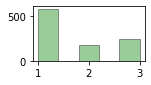

AvaluaAgent() Acabat
Iteració  77
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1122..1408 -> 286-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1038..1305 -> 267-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1160..1454 -> 294-tiles track
Episodi 0: recompensa = 828.3276


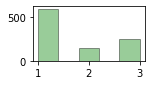

AvaluaAgent() Acabat
Iteració  78
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1056..1324 -> 268-tiles track
Episodi 0: recompensa = 862.5468


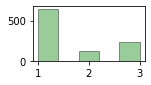

AvaluaAgent() Acabat
Iteració  79
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1155..1451 -> 296-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1230..1542 -> 312-tiles track
Episodi 0: recompensa = 469.1318


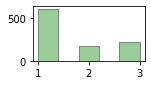

AvaluaAgent() Acabat
Iteració  80
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1283..1608 -> 325-tiles track
Episodi 0: recompensa = 714.8148


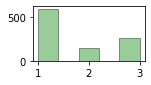

AvaluaAgent() Acabat
Iteració  81
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1088..1364 -> 276-tiles track
Episodi 0: recompensa = 780.0


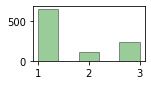

AvaluaAgent() Acabat
Iteració  82
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1073..1350 -> 277-tiles track
Episodi 0: recompensa = 773.1884


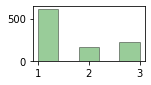

AvaluaAgent() Acabat
Iteració  83
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1058..1333 -> 275-tiles track
Episodi 0: recompensa = 823.3577


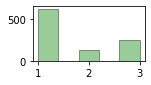

AvaluaAgent() Acabat
Iteració  84
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1063..1332 -> 269-tiles track
Episodi 0: recompensa = 761.9403


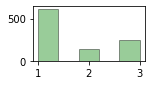

AvaluaAgent() Acabat
Iteració  85
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1149..1448 -> 299-tiles track
Episodi 0: recompensa = 644.9664


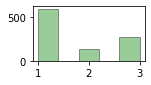

AvaluaAgent() Acabat
Iteració  86
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1263..1583 -> 320-tiles track
Episodi 0: recompensa = 539.4984


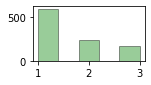

AvaluaAgent() Acabat
Iteració  87
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1030..1299 -> 269-tiles track
Episodi 0: recompensa = 683.5821


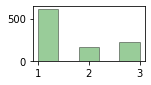

AvaluaAgent() Acabat
Iteració  88
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1107..1394 -> 287-tiles track
Episodi 0: recompensa = 837.0629


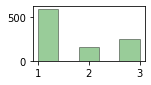

AvaluaAgent() Acabat
Iteració  89
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1182..1490 -> 308-tiles track
Episodi 0: recompensa = 541.6938


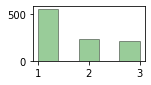

AvaluaAgent() Acabat
Iteració  90
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1267..1588 -> 321-tiles track
Episodi 0: recompensa = 809.375


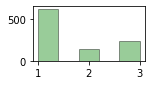

AvaluaAgent() Acabat
Iteració  91
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1144..1434 -> 290-tiles track
Episodi 0: recompensa = 806.5744


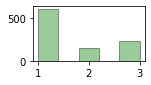

AvaluaAgent() Acabat
Iteració  92
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1073..1354 -> 281-tiles track
Episodi 0: recompensa = 807.1429


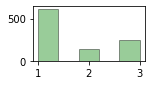

AvaluaAgent() Acabat
Iteració  93
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1188..1489 -> 301-tiles track
Episodi 0: recompensa = 830.0


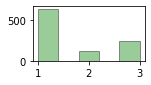

AvaluaAgent() Acabat
Iteració  94
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1092..1379 -> 287-tiles track
Episodi 0: recompensa = 872.028


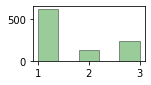

AvaluaAgent() Acabat
Iteració  95
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1182..1482 -> 300-tiles track
Episodi 0: recompensa = 803.01


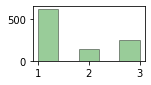

AvaluaAgent() Acabat
Iteració  96
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1020..1279 -> 259-tiles track
Episodi 0: recompensa = 717.8295


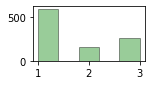

AvaluaAgent() Acabat
Iteració  97
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1095..1373 -> 278-tiles track
Episodi 0: recompensa = 286.2816


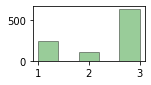

AvaluaAgent() Acabat
Iteració  98
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1080..1354 -> 274-tiles track
Episodi 0: recompensa = 845.0549


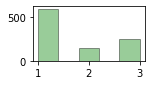

AvaluaAgent() Acabat
Iteració  99
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1116..1399 -> 283-tiles track
Episodi 0: recompensa = 708.5106


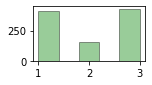

AvaluaAgent() Acabat
Iteració  100
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1140..1437 -> 297-tiles track
Episodi 0: recompensa = 548.6486


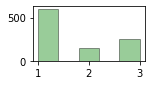

AvaluaAgent() Acabat
Iteració  101
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1164..1459 -> 295-tiles track
Episodi 0: recompensa = 389.7959


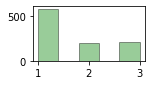

AvaluaAgent() Acabat
Iteració  102
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1183..1483 -> 300-tiles track
Episodi 0: recompensa = 816.388


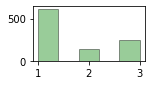

AvaluaAgent() Acabat
Iteració  103
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1009..1273 -> 264-tiles track
Episodi 0: recompensa = 827.7567


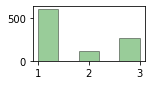

AvaluaAgent() Acabat
Iteració  104
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1291..1618 -> 327-tiles track
Episodi 0: recompensa = 798.773


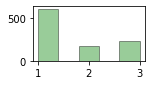

AvaluaAgent() Acabat
Iteració  105
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1183..1483 -> 300-tiles track
Episodi 0: recompensa = 826.4214


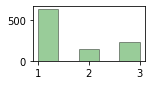

AvaluaAgent() Acabat
Iteració  106
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1217..1525 -> 308-tiles track
Episodi 0: recompensa = 414.658


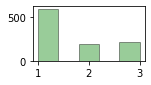

AvaluaAgent() Acabat
Iteració  107
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1110..1391 -> 281-tiles track
Episodi 0: recompensa = 875.0


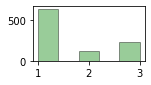

AvaluaAgent() Acabat
Iteració  108
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1055..1323 -> 268-tiles track
Episodi 0: recompensa = 855.0562


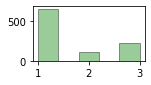

AvaluaAgent() Acabat
Iteració  109
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1272..1594 -> 322-tiles track
Episodi 0: recompensa = 644.5483


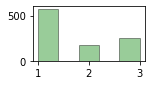

AvaluaAgent() Acabat
Iteració  110
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1064..1334 -> 270-tiles track
Episodi 0: recompensa = 833.0855


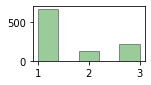

AvaluaAgent() Acabat
Iteració  111
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1169..1465 -> 296-tiles track
Episodi 0: recompensa = 781.3559


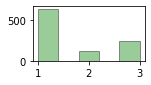

AvaluaAgent() Acabat
Iteració  112
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1120..1404 -> 284-tiles track
Episodi 0: recompensa = 825.7951


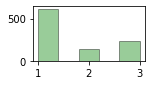

AvaluaAgent() Acabat
Iteració  113
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1173..1479 -> 306-tiles track
Episodi 0: recompensa = 640.9836


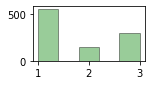

AvaluaAgent() Acabat
Iteració  114
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1154..1447 -> 293-tiles track
Episodi 0: recompensa = 807.5342


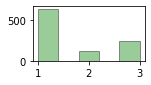

AvaluaAgent() Acabat
Iteració  115
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1336..1674 -> 338-tiles track
Episodi 0: recompensa = 692.2849


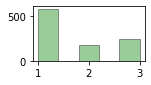

AvaluaAgent() Acabat
Iteració  116
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1084..1359 -> 275-tiles track
Episodi 0: recompensa = 764.9635


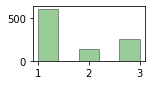

AvaluaAgent() Acabat
Iteració  117
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1038..1308 -> 270-tiles track
Episodi 0: recompensa = 847.9554


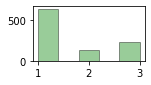

AvaluaAgent() Acabat
Iteració  118
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1271..1593 -> 322-tiles track
Episodi 0: recompensa = 797.1963


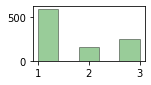

AvaluaAgent() Acabat
Iteració  119
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 995..1251 -> 256-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1168..1464 -> 296-tiles track
Episodi 0: recompensa = 788.1356


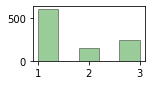

AvaluaAgent() Acabat
Iteració  120
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1197..1500 -> 303-tiles track
Episodi 0: recompensa = 747.6821


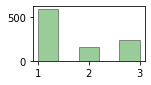

AvaluaAgent() Acabat
Iteració  121
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1066..1340 -> 274-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1227..1538 -> 311-tiles track
Episodi 0: recompensa = 800.0


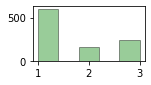

AvaluaAgent() Acabat
Iteració  122
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1181..1480 -> 299-tiles track
Episodi 0: recompensa = 856.3758


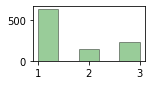

AvaluaAgent() Acabat
Iteració  123
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1274..1597 -> 323-tiles track
Episodi 0: recompensa = 757.1429


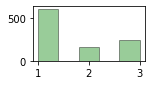

AvaluaAgent() Acabat
Iteració  124
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1177..1475 -> 298-tiles track
Episodi 0: recompensa = 856.229


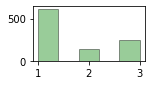

AvaluaAgent() Acabat
Iteració  125
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1187..1487 -> 300-tiles track
Episodi 0: recompensa = 796.3211


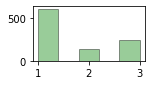

AvaluaAgent() Acabat
Iteració  126
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1131..1424 -> 293-tiles track
Episodi 0: recompensa = 550.6849


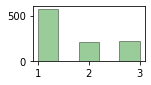

AvaluaAgent() Acabat
Iteració  127
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1117..1400 -> 283-tiles track
Episodi 0: recompensa = 836.1702


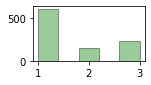

AvaluaAgent() Acabat
Iteració  128
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1310..1641 -> 331-tiles track
Episodi 0: recompensa = 754.5455


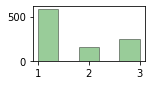

AvaluaAgent() Acabat
Iteració  129
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1212..1519 -> 307-tiles track
Episodi 0: recompensa = 579.7386


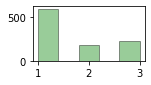

AvaluaAgent() Acabat
Iteració  130
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1229..1540 -> 311-tiles track
Episodi 0: recompensa = 761.2903


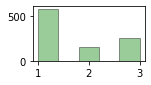

AvaluaAgent() Acabat
Iteració  131
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1220..1529 -> 309-tiles track
Episodi 0: recompensa = 526.6234


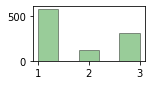

AvaluaAgent() Acabat
Iteració  132
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1087..1363 -> 276-tiles track
Episodi 0: recompensa = 820.0


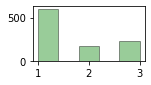

AvaluaAgent() Acabat
Iteració  133
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1307..1638 -> 331-tiles track
Episodi 0: recompensa = 778.7879


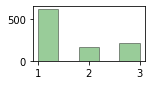

AvaluaAgent() Acabat
Iteració  134
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1183..1483 -> 300-tiles track
Episodi 0: recompensa = 829.7659


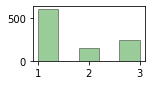

AvaluaAgent() Acabat
Iteració  135
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1085..1360 -> 275-tiles track
Episodi 0: recompensa = 874.4526


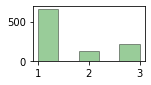

AvaluaAgent() Acabat
Iteració  136
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1247..1563 -> 316-tiles track
Episodi 0: recompensa = 846.0317


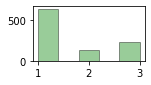

AvaluaAgent() Acabat
Iteració  137
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1119..1403 -> 284-tiles track
Episodi 0: recompensa = 850.53


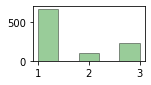

AvaluaAgent() Acabat
Iteració  138
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1197..1509 -> 312-tiles track
Episodi 0: recompensa = 424.1158


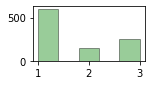

AvaluaAgent() Acabat
Iteració  139
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1137..1425 -> 288-tiles track
Episodi 0: recompensa = 809.4077


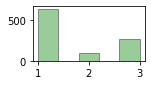

AvaluaAgent() Acabat
Iteració  140
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1150..1442 -> 292-tiles track
Episodi 0: recompensa = 810.6529


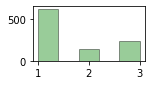

AvaluaAgent() Acabat
Iteració  141
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 977..1229 -> 252-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1140..1429 -> 289-tiles track
Episodi 0: recompensa = 809.7222


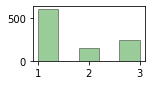

AvaluaAgent() Acabat
Iteració  142
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1131..1427 -> 296-tiles track
Episodi 0: recompensa = 835.5932


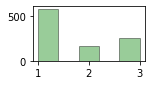

AvaluaAgent() Acabat
Iteració  143
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1081..1363 -> 282-tiles track
Episodi 0: recompensa = 800.3559


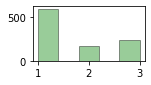

AvaluaAgent() Acabat
Iteració  144
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1084..1359 -> 275-tiles track
Episodi 0: recompensa = 797.8102


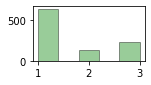

AvaluaAgent() Acabat
Iteració  145
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1166..1467 -> 301-tiles track
Episodi 0: recompensa = 726.6667


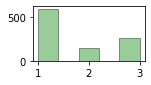

AvaluaAgent() Acabat
Iteració  146
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1171..1468 -> 297-tiles track
Episodi 0: recompensa = 775.0


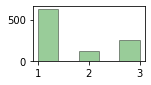

AvaluaAgent() Acabat
Iteració  147
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1202..1507 -> 305-tiles track
Episodi 0: recompensa = 673.0263


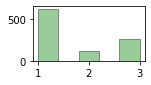

AvaluaAgent() Acabat
Iteració  148
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1106..1389 -> 283-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1354..1696 -> 342-tiles track
Episodi 0: recompensa = 430.7918


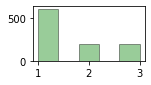

AvaluaAgent() Acabat
Iteració  149
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1155..1448 -> 293-tiles track
Episodi 0: recompensa = 845.2055


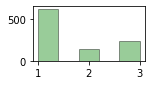

AvaluaAgent() Acabat
Iteració  150
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1304..1634 -> 330-tiles track
Episodi 0: recompensa = 781.459


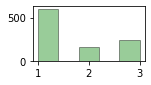

AvaluaAgent() Acabat
Iteració  151
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1114..1396 -> 282-tiles track
Episodi 0: recompensa = 537.0107


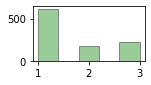

AvaluaAgent() Acabat
Iteració  152
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1350..1693 -> 343-tiles track
Episodi 0: recompensa = 511.1111


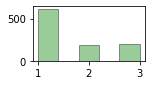

AvaluaAgent() Acabat
Iteració  153
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1127..1413 -> 286-tiles track
Episodi 0: recompensa = 826.3158


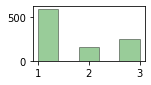

AvaluaAgent() Acabat
Iteració  154
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1208..1515 -> 307-tiles track
Episodi 0: recompensa = 766.0131


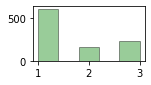

AvaluaAgent() Acabat
Iteració  155
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1161..1455 -> 294-tiles track
Episodi 0: recompensa = 801.0239


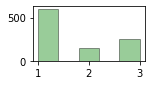

AvaluaAgent() Acabat
Iteració  156
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1112..1394 -> 282-tiles track
Episodi 0: recompensa = 803.9146


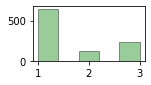

AvaluaAgent() Acabat
Iteració  157
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1319..1653 -> 334-tiles track
Episodi 0: recompensa = 782.8829


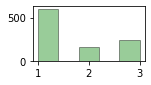

AvaluaAgent() Acabat
Iteració  158
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1114..1400 -> 286-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1050..1315 -> 265-tiles track
Episodi 0: recompensa = 684.0909


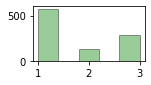

AvaluaAgent() Acabat
Iteració  159
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1153..1453 -> 300-tiles track
Episodi 0: recompensa = 702.6756


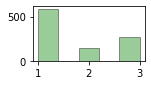

AvaluaAgent() Acabat
Iteració  160
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1146..1438 -> 292-tiles track
Episodi 0: recompensa = 786.5979


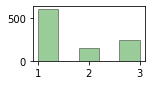

AvaluaAgent() Acabat
Iteració  161
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1132..1419 -> 287-tiles track
Episodi 0: recompensa = 809.0909


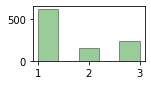

AvaluaAgent() Acabat
Iteració  162
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1151..1443 -> 292-tiles track
Episodi 0: recompensa = 803.7801


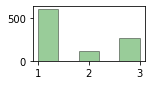

AvaluaAgent() Acabat
Iteració  163
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1127..1413 -> 286-tiles track
Episodi 0: recompensa = 812.2807


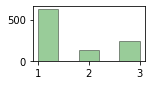

AvaluaAgent() Acabat
Iteració  164
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1135..1423 -> 288-tiles track
Episodi 0: recompensa = 837.2822


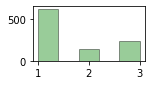

AvaluaAgent() Acabat
Iteració  165
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1291..1618 -> 327-tiles track
Episodi 0: recompensa = 774.2331


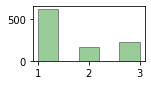

AvaluaAgent() Acabat
Iteració  166
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1036..1304 -> 268-tiles track
Episodi 0: recompensa = 813.8577


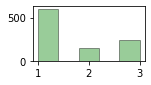

AvaluaAgent() Acabat
Iteració  167
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1311..1643 -> 332-tiles track
Episodi 0: recompensa = 782.1752


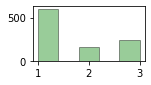

AvaluaAgent() Acabat
Iteració  168
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1175..1473 -> 298-tiles track
Episodi 0: recompensa = 758.5859


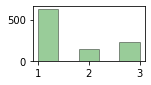

AvaluaAgent() Acabat
Iteració  169
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 964..1209 -> 245-tiles track
Episodi 0: recompensa = 473.7705


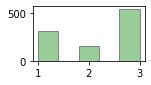

AvaluaAgent() Acabat
Iteració  170
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1240..1554 -> 314-tiles track
Episodi 0: recompensa = 797.7636


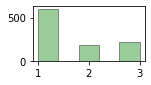

AvaluaAgent() Acabat
Iteració  171
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1060..1329 -> 269-tiles track
Episodi 0: recompensa = 844.0299


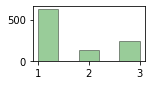

AvaluaAgent() Acabat
Iteració  172
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1188..1489 -> 301-tiles track
Episodi 0: recompensa = 846.6667


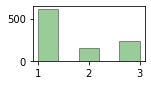

AvaluaAgent() Acabat
Iteració  173
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1089..1374 -> 285-tiles track
Episodi 0: recompensa = 826.0563


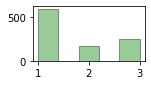

AvaluaAgent() Acabat
Iteració  174
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1300..1630 -> 330-tiles track
Episodi 0: recompensa = 444.0729


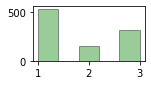

AvaluaAgent() Acabat
Iteració  175
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1095..1373 -> 278-tiles track
Episodi 0: recompensa = 809.7473


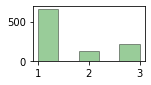

AvaluaAgent() Acabat
Iteració  176
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1299..1628 -> 329-tiles track
Episodi 0: recompensa = 348.1707


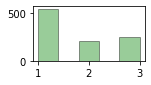

AvaluaAgent() Acabat
Iteració  177
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1187..1488 -> 301-tiles track
Episodi 0: recompensa = 826.6667


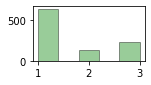

AvaluaAgent() Acabat
Iteració  178
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1056..1324 -> 268-tiles track
Episodi 0: recompensa = 862.5468


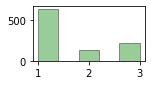

AvaluaAgent() Acabat
Iteració  179
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1227..1539 -> 312-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1128..1414 -> 286-tiles track
Episodi 0: recompensa = 366.6667


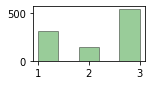

AvaluaAgent() Acabat
Iteració  180
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 980..1229 -> 249-tiles track
Episodi 0: recompensa = 867.7419


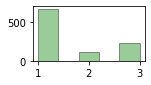

AvaluaAgent() Acabat
Iteració  181
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1132..1420 -> 288-tiles track
Episodi 0: recompensa = 708.3624


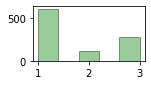

AvaluaAgent() Acabat
Iteració  182
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1209..1516 -> 307-tiles track
Episodi 0: recompensa = 733.3333


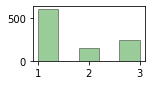

AvaluaAgent() Acabat
Iteració  183
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1136..1424 -> 288-tiles track
Episodi 0: recompensa = 826.8293


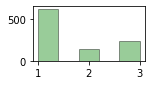

AvaluaAgent() Acabat
Iteració  184
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1182..1481 -> 299-tiles track
Episodi 0: recompensa = 795.9732


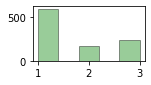

AvaluaAgent() Acabat
Iteració  185
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1243..1567 -> 324-tiles track
Episodi 0: recompensa = 60.9907


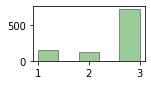

AvaluaAgent() Acabat
Iteració  186
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1084..1359 -> 275-tiles track
Episodi 0: recompensa = 830.6569


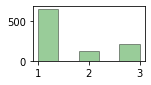

AvaluaAgent() Acabat
Iteració  187
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1178..1476 -> 298-tiles track
Episodi 0: recompensa = 825.9259


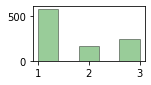

AvaluaAgent() Acabat
Iteració  188
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1118..1402 -> 284-tiles track
Episodi 0: recompensa = 793.9929


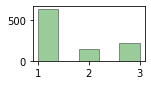

AvaluaAgent() Acabat
Iteració  189
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1079..1359 -> 280-tiles track
Episodi 0: recompensa = 545.1613


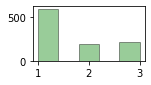

AvaluaAgent() Acabat
Iteració  190
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1191..1473 -> 282-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1152..1452 -> 300-tiles track
Episodi 0: recompensa = 421.7391


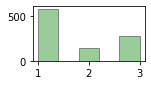

AvaluaAgent() Acabat
Iteració  191
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1122..1407 -> 285-tiles track
Episodi 0: recompensa = 847.1831


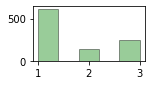

AvaluaAgent() Acabat
Iteració  192
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1168..1469 -> 301-tiles track
Episodi 0: recompensa = 756.6667


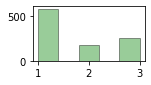

AvaluaAgent() Acabat
Iteració  193
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1240..1554 -> 314-tiles track
Episodi 0: recompensa = 775.3994


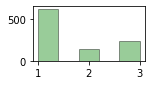

AvaluaAgent() Acabat
Iteració  194
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1076..1349 -> 273-tiles track
Episodi 0: recompensa = 808.0882


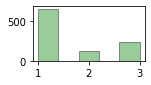

AvaluaAgent() Acabat
Iteració  195
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1336..1674 -> 338-tiles track
Episodi 0: recompensa = 650.7418


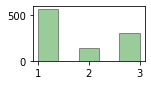

AvaluaAgent() Acabat
Iteració  196
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1175..1480 -> 305-tiles track
Episodi 0: recompensa = 771.7105


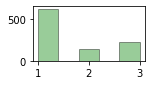

AvaluaAgent() Acabat
Iteració  197
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1132..1419 -> 287-tiles track
Episodi 0: recompensa = 480.4196


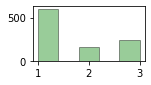

AvaluaAgent() Acabat
Iteració  198
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 986..1240 -> 254-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1155..1448 -> 293-tiles track
Episodi 0: recompensa = 225.3425


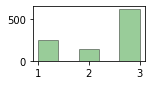

AvaluaAgent() Acabat
Iteració  199
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Track generation: 1255..1573 -> 318-tiles track
Episodi 0: recompensa = 805.3628


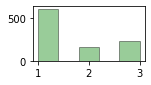

AvaluaAgent() Acabat


In [37]:
nomFitxerCSV = "performance200Agent2.csv"

with open(nomFitxerCSV,"w",newline='') as fitxer:
        writer = csv.writer(fitxer)
        writer.writerow(["iteracio", "recompensa"])

for i in range(200):
    print("Iteració ",i)
    LLrewMitjana = AvaluaAgent("Agent2_v1",1,False)
    with open(nomFitxerCSV,"a",newline='') as fitxer:
        writer = csv.writer(fitxer)
        writer.writerow([i, LLrewMitjana[0]])